# IMPORTS

In [1]:
import os
import re
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from collections import defaultdict
from scipy.stats import beta
from scipy.special import betaln
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'hsd-random'
epochs = 10
batch_size = 32
sequence_length = 64

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/multi-label-hate-speech-2/re_dataset.csv', encoding='latin-1')

alay_dict = pd.read_csv('/kaggle/input/multi-label-hate-speech-2/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})

print("Shape: ", data.shape)
data.head()

Shape:  (13169, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [7]:
data.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [8]:
data.HS.value_counts()

HS
0    7608
1    5561
Name: count, dtype: int64

In [9]:
data.Abusive.value_counts()

Abusive
0    8126
1    5043
Name: count, dtype: int64

In [10]:
print("Toxic shape: ", data[(data['HS'] == 1) | (data['Abusive'] == 1)].shape)
print("Non-toxic shape: ", data[(data['HS'] == 0) & (data['Abusive'] == 0)].shape)

Toxic shape:  (7309, 13)
Non-toxic shape:  (5860, 13)


In [11]:
print("Shape: ", alay_dict.shape)
alay_dict.head(15)

Shape:  (15167, 2)


,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
5,aamiin,amin
6,aamiinn,amin
7,aamin,amin
8,aammiin,amin
9,abis,habis


In [12]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('url', ' ', text) # Remove every URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub(r'\b(?:x[a-fA-F0-9]{2}\s*)+\b', '', text) # Remove emoji bytecode
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

print("remove_nonaplhanumeric: ", remove_nonaplhanumeric("Halooo,,,,, duniaa \x8f \xd2\1 !!"))
print("lowercase: ", lowercase("Halooo, duniaa!"))
print("remove_unnecessary_char: ", remove_unnecessary_char("Hehe\n\n RT USER USER apa kabs www.google.com\n  hehe URL xf8 x2a x89"))
print("normalize_alay: ", normalize_alay("aamiin adek abis"))

remove_nonaplhanumeric:  Halooo duniaa 
lowercase:  halooo, duniaa!
remove_unnecessary_char:  Hehe RT USER USER apa kabs hehe URL 
normalize_alay:  amin adik habis


In [13]:
def preprocess(text):
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    text = normalize_alay(text) 

    return text

In [14]:
data['Tweet'] = data['Tweet'].apply(preprocess)

# Define the labels columns for multi-label classification
label_columns = data.columns[1:]  # Assuming label columns start from the third column

train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Extract features and labels for training and validation
X_train = train_data['Tweet'].values
y_train = train_data[label_columns].values
X_val = val_data['Tweet'].values
y_val = val_data[label_columns].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(10535,) (10535, 12)
(2634,) (2634, 12)


# BUILD DATASET & DATALOADERS

In [15]:
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=64, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float if self.use_float else torch.long)
        return item

    def get_per_class_probs(self):
        """
        Calculate the spread of labels (0 and 1) for each class in the dataset.
        Returns:
            dict: A dictionary where keys are class indices and values are [count_0, count_1].
        """

        # Initialize a dictionary to store counts for each class
        label_counts = defaultdict(lambda: [0, 0])  # [count_0, count_1] for each class

        for i in range(len(self)):
            # Get the labels for the i-th sample
            labels = self[i]['labels']

            # Update counts for each class
            for class_idx, label in enumerate(labels):
                label_counts[class_idx][int(label)] += 1

        for key in label_counts.keys():
            total = sum(label_counts[key])
            label_counts[key] = [x / total for x in label_counts[key]]

        return label_counts

    def get_global_probs(self):
        """
        Calculate the global count of 0s and 1s across all classes in the dataset.
        Returns:
            dict: A dictionary with keys '0' and '1' representing their global counts.
        """
        global_counts = {'0': 0, '1': 0}

        for i in range(len(self)):
            # Get the labels for the i-th sample
            labels = self[i]['labels']

            # Update global counts
            for label in labels:
                global_counts[str(int(label))] += 1

        total = global_counts['0'] + global_counts['1']
        for key in global_counts.keys():
            global_counts[key] /= total

        return global_counts


# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [16]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=64, num_workers=4):
    train_dataset = HateSpeechDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = HateSpeechDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [17]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [18]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong'],
        zero_division=0
    )   
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [19]:
def train_model(current_train_size, train_indices, metrics, trials, i):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(label_columns),
            problem_type="multi_label_classification"
        )
        
    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials+1}-model-{i+1}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"Model {i+1} - Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
        
    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Training completed in {duration} s")
    
    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(best_result['accuracy'])
        metrics[1].append(best_result['f1_micro'])
        metrics[2].append(best_result['f1_macro'])

# PLOT RESULT

In [20]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [21]:
def beta_score(p, y, alpha=0.1, beta=3):
    """Calculates Beta score for a given probability p and label y."""
    
    if y == 1:
        return -betaln(alpha, beta + 1) + betaln(alpha + p, beta + 1 - p)
    elif y == 0:
        return -betaln(alpha + 1, beta) + betaln(alpha + 1 - p, beta + p)
    else:
        raise ValueError("Invalid label: y must be 0 or 1.")

def bayesian_update(prior, likelihood, evidence, alpha=0.1, beta_param=3):
    """ 
    Bayes' Theorem: P(y'|x') = P(x'|y') * P(y') / P(x')
    P(y'|x') or likelihood = model probs
    p(y') or prior = class probabilities
    p(x') or evidence = 1 / number of data
    """
    
    # Using the Beta score to simulate the posterior
    posterior = (likelihood * prior) / evidence
    
    # We calculate the posterior using the Beta distribution
    return posterior

def compute_expected_score_change(predicted_prob, class_probs, label_probs, class_idx):
    scores_before = []
    scores_after = []

    # Before data addition: calculate Beta score for predicted prob
    scores_before.append(beta_score(predicted_prob, int(1 if predicted_prob >= 0.5 else 0)))
    scores_before.append(beta_score(1-predicted_prob, int(1 if predicted_prob >= 0.5 else 0)))
    
    # After data addition: use Bayesian update (posterior probability)
    for k in range(2):
        prior = predicted_prob
        likelihood = class_probs[class_idx][k]  # Likelihood is the true label (0 or 1)
        posterior = bayesian_update(prior, likelihood, 1)
        scores_after.append(beta_score(posterior, int(1 if posterior >= 0.5 else 0)))

    score_diff_0 = scores_after[0] - scores_before[0]
    score_diff_1 = scores_after[1] - scores_before[1]
    return label_probs['0'] * score_diff_0 + label_probs['1'] * score_diff_1

# Function to compute Expected Score Change (∆Q)
def besra_sampling(models, X_pool, train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, trials, n_clusters=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device
    
    dataset = HateSpeechDataset(X_pool, np.zeros((len(X_pool), 12)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )

    current_train_size = len(train_indices)
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    labeled_dataset = HateSpeechDataset(current_X_train, current_y_train, tokenizer, max_length=sequence_length)
    label_probs = labeled_dataset.get_global_probs()
    class_probs = labeled_dataset.get_per_class_probs()

    for model in models:
        model.to(device)
        model.eval()
    start_time = time.time()
    score_changes = []

    for batch in dataloader:
        input_ids = batch['input_ids'].to(model.device)
        attention_mask = batch['attention_mask'].to(model.device)
        labels = batch['labels'].to(model.device)

        model_probs = []

        for model in models:
            with torch.no_grad():
                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                probs = torch.sigmoid(logits)  # Multi-label classification uses sigmoid
                model_probs.append(probs.unsqueeze(0))  # Add batch dimension for averaging
        
        # Stack all model predictions and compute the mean across models
        model_probs = torch.cat(model_probs, dim=0)  # Concatenate predictions across models
        probs = model_probs.mean(dim=0)  # Take the mean along the model axis

        # Calculate Beta scores before and after data addition
        for i in range(len(probs)):
            score_diff = []
            for class_idx in range(probs.shape[1]):
                predicted_prob = probs[i, class_idx].item()
                score_diff.append(compute_expected_score_change(predicted_prob, class_probs, label_probs, class_idx))
            
            score_changes.append(np.mean(score_diff))

    # Perform K-means clustering
    collected_indices = set()  # Initialize set to store selected indices
    
    accelerator.wait_for_everyone()
    
    if accelerator.is_local_main_process:
        num_of_candidates = len(score_changes[:math.ceil(0.1 * len(score_changes))])
        nearest_cp = 0
        arrived_at_cp = False
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break

        # Determine number of clusters
        if num_of_candidates <= n_clusters and n_clusters < nearest_cp - current_train_size:
            n_clusters = n_clusters
        elif num_of_candidates > n_clusters and num_of_candidates < nearest_cp - current_train_size:
            n_clusters = num_of_candidates
        else:
            arrived_at_cp = True
            n_clusters = nearest_cp - current_train_size

        score_changes = np.array(score_changes)
        score_changes = score_changes.reshape(-1, 1)
            
        kmeans=KMeans(n_clusters=n_clusters, n_init=1)
        kmeans.fit(score_changes)

        if current_train_size > checkpoints[len(checkpoints)-1] - min_increment:
            end_time = time.time()
            duration = end_time - start_time
            
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'HS': [y_train[i][0] for i in temp],
                'Abusive': [y_train[i][1] for i in temp],
                'HS_Individual': [y_train[i][2] for i in temp],
                'HS_Group': [y_train[i][3] for i in temp],
                'HS_Religion': [y_train[i][4] for i in temp],
                'HS_Race': [y_train[i][5] for i in temp],
                'HS_Physical': [y_train[i][6] for i in temp],
                'HS_Gender': [y_train[i][7] for i in temp],
                'HS_Other': [y_train[i][8] for i in temp],
                'HS_Weak': [y_train[i][9] for i in temp],
                'HS_Moderate': [y_train[i][10] for i in temp],
                'HS_Strong': [y_train[i][11] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

            print("Nearest checkpoint:", nearest_cp)
            print("Samples above threshold:", num_of_candidates)
            print("Acquired samples:", len(remaining_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in remaining_indices:
                new_samples.append(i)
        else:
            for cluster_id in range(n_clusters):
                # Cluster center and indices of samples in the current cluster
                cluster_center = kmeans.cluster_centers_[cluster_id]
                cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]  # Indices of samples in the current cluster
                
                if cluster_indices.size == 0:
                    # Skip clusters with no members
                    print(f"Cluster {cluster_id} has no members, skipping.")
                    continue
            
                # Calculate distances to the cluster center
                cluster_distances = np.linalg.norm(score_changes[cluster_indices] - cluster_center, axis=1)
                closest_sample_index = cluster_indices[np.argmin(cluster_distances)]  # Closest sample index
                collected_indices.add(closest_sample_index)

            end_time = time.time() 
            duration = end_time - start_time 
            
            if arrived_at_cp:
                temp = train_indices.copy()
                temp.extend(collected_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    'HS': [y_train[i][0] for i in temp],
                    'Abusive': [y_train[i][1] for i in temp],
                    'HS_Individual': [y_train[i][2] for i in temp],
                    'HS_Group': [y_train[i][3] for i in temp],
                    'HS_Religion': [y_train[i][4] for i in temp],
                    'HS_Race': [y_train[i][5] for i in temp],
                    'HS_Physical': [y_train[i][6] for i in temp],
                    'HS_Gender': [y_train[i][7] for i in temp],
                    'HS_Other': [y_train[i][8] for i in temp],
                    'HS_Weak': [y_train[i][9] for i in temp],
                    'HS_Moderate': [y_train[i][10] for i in temp],
                    'HS_Strong': [y_train[i][11] for i in temp],
                })
                acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

            print("Nearest checkpoint:", nearest_cp)
            print("Samples above threshold:", num_of_candidates)
            print("Acquired samples:", len(collected_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in collected_indices:
                new_samples.append(remaining_indices[i])

# MAIN LOOP

In [22]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        model_accuracies = manager.list()
        model_f1_micros = manager.list()
        model_f1_macros = manager.list()
        
        # Train the model
        for j in range(3):
            set_seed(seed[j])
            args = (current_train_size, train_indices, (model_accuracies, model_f1_micros, model_f1_macros), i, j)
            notebook_launcher(train_model, args, num_processes=2)

        data_used.append(current_train_size)
        accuracies.append(np.mean(model_accuracies))
        f1_micros.append(np.mean(model_f1_micros))
        f1_macros.append(np.mean(model_f1_macros))
        print(f"Averaged - Iteration {current_train_size}: Accuracy: {round(np.mean(accuracies), 4)}, F1 Micro: {round(np.mean(f1_micros), 4)}, F1 Macro: {round(np.mean(f1_macros), 4)}")

        models = []
        for j in range(3):
            model = BertForSequenceClassification.from_pretrained(f'{filename}-{i+1}-model-{j+1}')
            models.append(model)
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (models, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, i)
        notebook_launcher(besra_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    model_accuracies = manager.list()
    model_f1_micros = manager.list()
    model_f1_macros = manager.list()
    
    for j in range(3):
        set_seed(seed[j])
        args = (current_train_size, train_indices, (model_accuracies, model_f1_micros, model_f1_macros), i, j)
        notebook_launcher(train_model, args, num_processes=2)
        
    data_used.append(current_train_size)
    accuracies.append(np.mean(model_accuracies))
    f1_micros.append(np.mean(model_f1_micros))
    f1_macros.append(np.mean(model_f1_macros))
    print(f"Averaged - Iteration {current_train_size}: Accuracy: {round(np.mean(accuracies), 4)}, F1 Micro: {round(np.mean(f1_micros), 4)}, F1 Macro: {round(np.mean(f1_macros), 4)}")
        
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [23]:
seeds = [[50, 67, 42], [81, 90, 11], [14, 7, 33], [3, 44, 85], [94, 21, 5]]

## RUN 1

TRIAL 1
Random seed: [50, 67, 42]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5517, Accuracy: 0.8265, F1 Micro: 0.0155, F1 Macro: 0.0059
Epoch 2/10, Train Loss: 0.4241, Accuracy: 0.8268, F1 Micro: 0.0004, F1 Macro: 0.0002
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3823, Accuracy: 0.8302, F1 Micro: 0.042, F1 Macro: 0.0178
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3708, Accuracy: 0.8524, F1 Micro: 0.3073, F1 Macro: 0.1027
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.35, Accuracy: 0.8693, F1 Micro: 0.4709, F1 Macro: 0.2027
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3063, Accuracy: 0.8818, F1 Micro: 0.5906, F1 Macro: 0.3067
Epoch 7/10, Train Loss: 0.2676, Accuracy: 0.8832, F1 Micro: 0.5756, F1 Macro: 0.3189
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2521, Accuracy: 0.889, F1 Micro: 0.634, F1 Macro: 0.3836
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2218, Accuracy: 0.8902, F1 Micro: 0.6449, F1 Macro: 0.3921
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5678, Accuracy: 0.8341, F1 Micro: 0.1921, F1 Macro: 0.0601
Epoch 2/10, Train Loss: 0.4277, Accuracy: 0.8335, F1 Micro: 0.0876, F1 Macro: 0.033
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3813, Accuracy: 0.8458, F1 Micro: 0.2494, F1 Macro: 0.0854
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3672, Accuracy: 0.8583, F1 Micro: 0.4137, F1 Macro: 0.1329
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3474, Accuracy: 0.8698, F1 Micro: 0.4975, F1 Macro: 0.2121
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3019, Accuracy: 0.8788, F1 Micro: 0.589, F1 Macro: 0.2859
Epoch 7/10, Train Loss: 0.2681, Accuracy: 0.8791, F1 Micro: 0.5536, F1 Macro: 0.2828
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2536, Accuracy: 0.8843, F1 Micro: 0.5984, F1 Macro: 0.3202
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2307, Accuracy: 0.8866, F1 Micro: 0.631, F1 Macro: 0.3694
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.58, Accuracy: 0.8362, F1 Micro: 0.2748, F1 Macro: 0.0842
Epoch 2/10, Train Loss: 0.4275, Accuracy: 0.8286, F1 Micro: 0.0261, F1 Macro: 0.0113
Epoch 3/10, Train Loss: 0.3807, Accuracy: 0.8374, F1 Micro: 0.1411, F1 Macro: 0.0531
Epoch 4/10, Train Loss: 0.3712, Accuracy: 0.8484, F1 Micro: 0.2715, F1 Macro: 0.0928
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3527, Accuracy: 0.8608, F1 Micro: 0.3932, F1 Macro: 0.1447
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3105, Accuracy: 0.8769, F1 Micro: 0.5572, F1 Macro: 0.2737
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2779, Accuracy: 0.8805, F1 Micro: 0.5651, F1 Macro: 0.3034
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2567, Accuracy: 0.8842, F1 Micro: 0.5902, F1 Macro: 0.3608
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2319, Accuracy: 0.8885, F1 Micro: 0.6304, F1 Macro: 0.3777
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5008, Accuracy: 0.8313, F1 Micro: 0.3992, F1 Macro: 0.1091
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4175, Accuracy: 0.8632, F1 Micro: 0.5527, F1 Macro: 0.2479
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.362, Accuracy: 0.8902, F1 Micro: 0.6346, F1 Macro: 0.3488
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3065, Accuracy: 0.897, F1 Micro: 0.6375, F1 Macro: 0.4287
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2599, Accuracy: 0.903, F1 Micro: 0.6971, F1 Macro: 0.5301
Epoch 6/10, Train Loss: 0.2167, Accuracy: 0.9035, F1 Micro: 0.6764, F1 Macro: 0.5093
Epoch 7/10, Train Loss: 0.1866, Accuracy: 0.9046, F1 Micro: 0.6903, F1 Macro: 0.5165
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1546, Accuracy: 0.9061, F1 Micro: 0.7078, F1 Macro: 0.5554
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1363, Accuracy: 0.9067, F1 Micro: 0.7119, F1 Macro: 0.5504
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5126, Accuracy: 0.8424, F1 Micro: 0.4024, F1 Macro: 0.1127
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4186, Accuracy: 0.8621, F1 Micro: 0.5342, F1 Macro: 0.2191
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3694, Accuracy: 0.8872, F1 Micro: 0.6215, F1 Macro: 0.3343
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3103, Accuracy: 0.8961, F1 Micro: 0.6417, F1 Macro: 0.4273
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2645, Accuracy: 0.9016, F1 Micro: 0.6706, F1 Macro: 0.476
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2267, Accuracy: 0.9029, F1 Micro: 0.677, F1 Macro: 0.5059
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1938, Accuracy: 0.9037, F1 Micro: 0.6881, F1 Macro: 0.5026
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.162, Accuracy: 0.906, F1 Micro: 0.7106, F1 Macro: 0.5554
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5124, Accuracy: 0.8312, F1 Micro: 0.4032, F1 Macro: 0.1096
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4161, Accuracy: 0.8615, F1 Micro: 0.5133, F1 Macro: 0.2157
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.367, Accuracy: 0.8895, F1 Micro: 0.632, F1 Macro: 0.3587
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3116, Accuracy: 0.8973, F1 Micro: 0.639, F1 Macro: 0.4306
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2677, Accuracy: 0.9041, F1 Micro: 0.6788, F1 Macro: 0.4938
Epoch 6/10, Train Loss: 0.2274, Accuracy: 0.904, F1 Micro: 0.6784, F1 Macro: 0.5358
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1933, Accuracy: 0.9075, F1 Micro: 0.7054, F1 Macro: 0.5319
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1603, Accuracy: 0.9069, F1 Micro: 0.7066, F1 Macro: 0.5493
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1426, Accuracy: 0.9071, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4758, Accuracy: 0.8311, F1 Micro: 0.409, F1 Macro: 0.1193
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3855, Accuracy: 0.8908, F1 Micro: 0.6388, F1 Macro: 0.3749
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3282, Accuracy: 0.9055, F1 Micro: 0.7084, F1 Macro: 0.5318
Epoch 4/10, Train Loss: 0.2708, Accuracy: 0.9059, F1 Micro: 0.6984, F1 Macro: 0.5121
Epoch 5/10, Train Loss: 0.2231, Accuracy: 0.9097, F1 Micro: 0.6989, F1 Macro: 0.5364
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1851, Accuracy: 0.9131, F1 Micro: 0.7283, F1 Macro: 0.5803
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1541, Accuracy: 0.913, F1 Micro: 0.733, F1 Macro: 0.5976
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1224, Accuracy: 0.9125, F1 Micro: 0.7345, F1 Macro: 0.5966
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.103, Accuracy: 0.9137, F1 Micro: 0.7362, F1 Macro: 0.6001
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.485, Accuracy: 0.8386, F1 Micro: 0.4164, F1 Macro: 0.1252
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3885, Accuracy: 0.8878, F1 Micro: 0.6102, F1 Macro: 0.3222
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3318, Accuracy: 0.905, F1 Micro: 0.708, F1 Macro: 0.5205
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2778, Accuracy: 0.908, F1 Micro: 0.7103, F1 Macro: 0.5234
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2287, Accuracy: 0.9111, F1 Micro: 0.7178, F1 Macro: 0.5448
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1968, Accuracy: 0.9149, F1 Micro: 0.7319, F1 Macro: 0.5814
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1632, Accuracy: 0.9145, F1 Micro: 0.7364, F1 Macro: 0.5944
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1245, Accuracy: 0.9134, F1 Micro: 0.7401, F1 Macro: 0.6051
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4815, Accuracy: 0.8344, F1 Micro: 0.4173, F1 Macro: 0.1296
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3885, Accuracy: 0.886, F1 Micro: 0.6002, F1 Macro: 0.3332
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3309, Accuracy: 0.9038, F1 Micro: 0.7044, F1 Macro: 0.5299
Epoch 4/10, Train Loss: 0.2789, Accuracy: 0.9081, F1 Micro: 0.6985, F1 Macro: 0.5154
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2315, Accuracy: 0.9114, F1 Micro: 0.7136, F1 Macro: 0.5528
Epoch 6/10, Train Loss: 0.1941, Accuracy: 0.9116, F1 Micro: 0.7109, F1 Macro: 0.5687
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1608, Accuracy: 0.9159, F1 Micro: 0.7377, F1 Macro: 0.5967
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1251, Accuracy: 0.912, F1 Micro: 0.7432, F1 Macro: 0.6049
Epoch 9/10, Train Loss: 0.107, Accuracy: 0.9108, F1 Micro: 0.743, F1 Macro: 0.6076
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4656, Accuracy: 0.8588, F1 Micro: 0.5205, F1 Macro: 0.2367
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3624, Accuracy: 0.8999, F1 Micro: 0.6708, F1 Macro: 0.4103
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2949, Accuracy: 0.9072, F1 Micro: 0.708, F1 Macro: 0.4838
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2453, Accuracy: 0.9115, F1 Micro: 0.7364, F1 Macro: 0.5545
Epoch 5/10, Train Loss: 0.1982, Accuracy: 0.9137, F1 Micro: 0.7146, F1 Macro: 0.5688
Epoch 6/10, Train Loss: 0.163, Accuracy: 0.916, F1 Micro: 0.7359, F1 Macro: 0.6018
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1346, Accuracy: 0.9133, F1 Micro: 0.7458, F1 Macro: 0.6034
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1096, Accuracy: 0.9156, F1 Micro: 0.7504, F1 Macro: 0.6295
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.094, Accuracy: 0.9152, F1 Micro: 0.7527, F1 Macro: 0.6354
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4713, Accuracy: 0.8638, F1 Micro: 0.5243, F1 Macro: 0.2211
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3675, Accuracy: 0.8981, F1 Micro: 0.6709, F1 Macro: 0.3882
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3005, Accuracy: 0.9074, F1 Micro: 0.7158, F1 Macro: 0.4773
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2542, Accuracy: 0.9132, F1 Micro: 0.7335, F1 Macro: 0.5449
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2048, Accuracy: 0.9186, F1 Micro: 0.7422, F1 Macro: 0.5789
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1666, Accuracy: 0.9191, F1 Micro: 0.7499, F1 Macro: 0.6187
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1405, Accuracy: 0.9142, F1 Micro: 0.7566, F1 Macro: 0.6232
Epoch 8/10, Train Loss: 0.1159, Accuracy: 0.9159, F1 Micro: 0.7527, F1 Macro: 0.6335
Epoch 9/10, Train Loss: 0.0968, Accuracy: 0.9155, F1 Micro: 0.7489, F1 Macro: 0.6274
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4696, Accuracy: 0.8533, F1 Micro: 0.4934, F1 Macro: 0.2146
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3708, Accuracy: 0.8961, F1 Micro: 0.6598, F1 Macro: 0.3934
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3023, Accuracy: 0.9072, F1 Micro: 0.7157, F1 Macro: 0.5082
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2544, Accuracy: 0.9109, F1 Micro: 0.7379, F1 Macro: 0.5575
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2037, Accuracy: 0.9168, F1 Micro: 0.7388, F1 Macro: 0.5819
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.167, Accuracy: 0.9169, F1 Micro: 0.7425, F1 Macro: 0.6092
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1387, Accuracy: 0.9169, F1 Micro: 0.7532, F1 Macro: 0.6122
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1122, Accuracy: 0.9146, F1 Micro: 0.7546, F1 Macro: 0.6315
Epoch 9/10, Train Loss: 0.0983, Accuracy: 0.9165, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4527, Accuracy: 0.8679, F1 Micro: 0.5151, F1 Macro: 0.2235
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3507, Accuracy: 0.9058, F1 Micro: 0.7181, F1 Macro: 0.5095
Epoch 3/10, Train Loss: 0.282, Accuracy: 0.9096, F1 Micro: 0.7123, F1 Macro: 0.5078
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2311, Accuracy: 0.9185, F1 Micro: 0.7456, F1 Macro: 0.5978
Epoch 5/10, Train Loss: 0.1882, Accuracy: 0.9175, F1 Micro: 0.7398, F1 Macro: 0.598
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1582, Accuracy: 0.9182, F1 Micro: 0.7582, F1 Macro: 0.6501
Epoch 7/10, Train Loss: 0.1225, Accuracy: 0.9204, F1 Micro: 0.7558, F1 Macro: 0.6357
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1075, Accuracy: 0.9159, F1 Micro: 0.7614, F1 Macro: 0.6372
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0869, Accuracy: 0.9188, F1 Micro: 0.7618, F1 Macro: 0.6443
Epoch 10/10, Train Loss: 0.0746, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.46, Accuracy: 0.8689, F1 Micro: 0.5326, F1 Macro: 0.2302
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3565, Accuracy: 0.9017, F1 Micro: 0.7127, F1 Macro: 0.515
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2896, Accuracy: 0.9122, F1 Micro: 0.7179, F1 Macro: 0.5099
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.238, Accuracy: 0.9201, F1 Micro: 0.7532, F1 Macro: 0.6008
Epoch 5/10, Train Loss: 0.1945, Accuracy: 0.919, F1 Micro: 0.7497, F1 Macro: 0.6033
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1657, Accuracy: 0.9158, F1 Micro: 0.7575, F1 Macro: 0.6463
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.127, Accuracy: 0.9193, F1 Micro: 0.7599, F1 Macro: 0.6492
Epoch 8/10, Train Loss: 0.1069, Accuracy: 0.9197, F1 Micro: 0.757, F1 Macro: 0.6427
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0911, Accuracy: 0.9158, F1 Micro: 0.7603, F1 Macro: 0.6468
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4582, Accuracy: 0.8606, F1 Micro: 0.5014, F1 Macro: 0.2206
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.358, Accuracy: 0.9008, F1 Micro: 0.701, F1 Macro: 0.4993
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2906, Accuracy: 0.9099, F1 Micro: 0.7049, F1 Macro: 0.503
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2408, Accuracy: 0.9178, F1 Micro: 0.7491, F1 Macro: 0.5943
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1939, Accuracy: 0.9201, F1 Micro: 0.7593, F1 Macro: 0.6065
Epoch 6/10, Train Loss: 0.1606, Accuracy: 0.9177, F1 Micro: 0.7578, F1 Macro: 0.6399
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1262, Accuracy: 0.9204, F1 Micro: 0.7655, F1 Macro: 0.6419
Epoch 8/10, Train Loss: 0.1097, Accuracy: 0.9193, F1 Micro: 0.7485, F1 Macro: 0.618
Epoch 9/10, Train Loss: 0.0912, Accuracy: 0.9202, F1 Micro: 0.7606, F1 Macro: 0.6327
Epoch 10/10, Train Loss: 0.0802, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4403, Accuracy: 0.8727, F1 Micro: 0.6426, F1 Macro: 0.3594
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.333, Accuracy: 0.9101, F1 Micro: 0.7333, F1 Macro: 0.5522
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2709, Accuracy: 0.9175, F1 Micro: 0.7472, F1 Macro: 0.5967
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2236, Accuracy: 0.9212, F1 Micro: 0.7607, F1 Macro: 0.6217
Epoch 5/10, Train Loss: 0.1758, Accuracy: 0.9199, F1 Micro: 0.7566, F1 Macro: 0.6296
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1477, Accuracy: 0.921, F1 Micro: 0.762, F1 Macro: 0.655
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1123, Accuracy: 0.9223, F1 Micro: 0.7636, F1 Macro: 0.6497
Epoch 8/10, Train Loss: 0.1019, Accuracy: 0.9219, F1 Micro: 0.7612, F1 Macro: 0.6678
Epoch 9/10, Train Loss: 0.0831, Accuracy: 0.9218, F1 Micro: 0.7621, F1 Macro: 0.6707
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4445, Accuracy: 0.8824, F1 Micro: 0.6301, F1 Macro: 0.328
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3364, Accuracy: 0.9092, F1 Micro: 0.7292, F1 Macro: 0.536
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2755, Accuracy: 0.9171, F1 Micro: 0.738, F1 Macro: 0.5849
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2276, Accuracy: 0.9209, F1 Micro: 0.7566, F1 Macro: 0.6074
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1783, Accuracy: 0.9217, F1 Micro: 0.7615, F1 Macro: 0.6375
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1446, Accuracy: 0.921, F1 Micro: 0.7668, F1 Macro: 0.6568
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1213, Accuracy: 0.923, F1 Micro: 0.7703, F1 Macro: 0.6531
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1016, Accuracy: 0.9237, F1 Micro: 0.7737, F1 Macro: 0.6724
Epoch 9/10, Train Loss: 0.0801, Accuracy: 0.9226, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4429, Accuracy: 0.8676, F1 Micro: 0.6301, F1 Macro: 0.3635
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3379, Accuracy: 0.9087, F1 Micro: 0.7264, F1 Macro: 0.5372
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2761, Accuracy: 0.9169, F1 Micro: 0.7497, F1 Macro: 0.6018
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2294, Accuracy: 0.9188, F1 Micro: 0.7626, F1 Macro: 0.6114
Epoch 5/10, Train Loss: 0.1778, Accuracy: 0.9218, F1 Micro: 0.7612, F1 Macro: 0.6321
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1491, Accuracy: 0.9229, F1 Micro: 0.7697, F1 Macro: 0.6512
Epoch 7/10, Train Loss: 0.1212, Accuracy: 0.9216, F1 Micro: 0.7637, F1 Macro: 0.6412
Epoch 8/10, Train Loss: 0.0996, Accuracy: 0.9227, F1 Micro: 0.7647, F1 Macro: 0.6476
Epoch 9/10, Train Loss: 0.0816, Accuracy: 0.9211, F1 Micro: 0.7663, F1 Macro: 0.6658
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0736, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4339, Accuracy: 0.8886, F1 Micro: 0.6536, F1 Macro: 0.3856
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3244, Accuracy: 0.9107, F1 Micro: 0.7111, F1 Macro: 0.5559
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2605, Accuracy: 0.9181, F1 Micro: 0.7511, F1 Macro: 0.608
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2117, Accuracy: 0.9192, F1 Micro: 0.7599, F1 Macro: 0.6163
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1695, Accuracy: 0.9238, F1 Micro: 0.7761, F1 Macro: 0.6807
Epoch 6/10, Train Loss: 0.1391, Accuracy: 0.9223, F1 Micro: 0.7702, F1 Macro: 0.667
Epoch 7/10, Train Loss: 0.1089, Accuracy: 0.9211, F1 Micro: 0.7749, F1 Macro: 0.6684
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0896, Accuracy: 0.9224, F1 Micro: 0.7762, F1 Macro: 0.6833
Epoch 9/10, Train Loss: 0.0788, Accuracy: 0.9226, F1 Micro: 0.7715, F1 Macro: 0.7037
Epoch 10/10, Train Loss: 0.0653, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.44, Accuracy: 0.8848, F1 Micro: 0.6441, F1 Macro: 0.3566
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3293, Accuracy: 0.9121, F1 Micro: 0.712, F1 Macro: 0.5545
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2659, Accuracy: 0.9205, F1 Micro: 0.7544, F1 Macro: 0.6057
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2183, Accuracy: 0.9207, F1 Micro: 0.7674, F1 Macro: 0.6303
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1693, Accuracy: 0.923, F1 Micro: 0.7694, F1 Macro: 0.6645
Epoch 6/10, Train Loss: 0.1402, Accuracy: 0.9233, F1 Micro: 0.7681, F1 Macro: 0.6664
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1109, Accuracy: 0.9224, F1 Micro: 0.7778, F1 Macro: 0.6848
Epoch 8/10, Train Loss: 0.0914, Accuracy: 0.9222, F1 Micro: 0.772, F1 Macro: 0.6936
Epoch 9/10, Train Loss: 0.0788, Accuracy: 0.922, F1 Micro: 0.7665, F1 Macro: 0.6836
Epoch 10/10, Train Loss: 0.0677, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4394, Accuracy: 0.8821, F1 Micro: 0.62, F1 Macro: 0.336
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3313, Accuracy: 0.911, F1 Micro: 0.7115, F1 Macro: 0.5531
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2645, Accuracy: 0.919, F1 Micro: 0.7537, F1 Macro: 0.608
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2173, Accuracy: 0.9196, F1 Micro: 0.764, F1 Macro: 0.6167
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1735, Accuracy: 0.9247, F1 Micro: 0.7678, F1 Macro: 0.6517
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1418, Accuracy: 0.9221, F1 Micro: 0.7687, F1 Macro: 0.6475
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.113, Accuracy: 0.9234, F1 Micro: 0.7747, F1 Macro: 0.6644
Epoch 8/10, Train Loss: 0.093, Accuracy: 0.9238, F1 Micro: 0.7704, F1 Macro: 0.6785
Epoch 9/10, Train Loss: 0.0773, Accuracy: 0.9213, F1 Micro: 0.7668, F1 Macro: 0.6834
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4291, Accuracy: 0.8911, F1 Micro: 0.6466, F1 Macro: 0.4119
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3166, Accuracy: 0.9117, F1 Micro: 0.7084, F1 Macro: 0.5299
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2505, Accuracy: 0.9191, F1 Micro: 0.7433, F1 Macro: 0.6125
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2048, Accuracy: 0.9184, F1 Micro: 0.7621, F1 Macro: 0.6354
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1637, Accuracy: 0.9208, F1 Micro: 0.768, F1 Macro: 0.6563
Epoch 6/10, Train Loss: 0.1359, Accuracy: 0.9217, F1 Micro: 0.76, F1 Macro: 0.6298
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1049, Accuracy: 0.9223, F1 Micro: 0.7755, F1 Macro: 0.6859
Epoch 8/10, Train Loss: 0.0825, Accuracy: 0.9227, F1 Micro: 0.7708, F1 Macro: 0.7006
Epoch 9/10, Train Loss: 0.0791, Accuracy: 0.9233, F1 Micro: 0.7701, F1 Macro: 0.7016
Epoch 10/10, Train Loss: 0.0629, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4331, Accuracy: 0.8916, F1 Micro: 0.6374, F1 Macro: 0.3966
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3194, Accuracy: 0.9132, F1 Micro: 0.7291, F1 Macro: 0.5496
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2563, Accuracy: 0.9212, F1 Micro: 0.7523, F1 Macro: 0.6024
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2123, Accuracy: 0.9188, F1 Micro: 0.7632, F1 Macro: 0.6241
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1645, Accuracy: 0.9187, F1 Micro: 0.7664, F1 Macro: 0.6415
Epoch 6/10, Train Loss: 0.1373, Accuracy: 0.9235, F1 Micro: 0.7653, F1 Macro: 0.6478
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1087, Accuracy: 0.9249, F1 Micro: 0.7784, F1 Macro: 0.6767
Epoch 8/10, Train Loss: 0.0853, Accuracy: 0.9244, F1 Micro: 0.7733, F1 Macro: 0.6886
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0779, Accuracy: 0.9258, F1 Micro: 0.7792, F1 Macro: 0.703
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4331, Accuracy: 0.8883, F1 Micro: 0.6336, F1 Macro: 0.4031
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.32, Accuracy: 0.9117, F1 Micro: 0.7203, F1 Macro: 0.5386
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2545, Accuracy: 0.9185, F1 Micro: 0.7384, F1 Macro: 0.5823
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2114, Accuracy: 0.9169, F1 Micro: 0.7619, F1 Macro: 0.6073
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1679, Accuracy: 0.9222, F1 Micro: 0.7619, F1 Macro: 0.638
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1365, Accuracy: 0.9225, F1 Micro: 0.7701, F1 Macro: 0.6452
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1094, Accuracy: 0.9245, F1 Micro: 0.7736, F1 Macro: 0.6607
Epoch 8/10, Train Loss: 0.0867, Accuracy: 0.9203, F1 Micro: 0.7688, F1 Macro: 0.6854
Epoch 9/10, Train Loss: 0.0773, Accuracy: 0.9243, F1 Micro: 0.7705, F1 Macro: 0.6971
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4229, Accuracy: 0.8952, F1 Micro: 0.6685, F1 Macro: 0.4172
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3072, Accuracy: 0.9171, F1 Micro: 0.7476, F1 Macro: 0.5928
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2452, Accuracy: 0.9204, F1 Micro: 0.7607, F1 Macro: 0.6007
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1959, Accuracy: 0.9227, F1 Micro: 0.7716, F1 Macro: 0.6469
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1617, Accuracy: 0.925, F1 Micro: 0.779, F1 Macro: 0.6797
Epoch 6/10, Train Loss: 0.1266, Accuracy: 0.9229, F1 Micro: 0.7756, F1 Macro: 0.6678
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1032, Accuracy: 0.9241, F1 Micro: 0.7822, F1 Macro: 0.7069
Epoch 8/10, Train Loss: 0.0887, Accuracy: 0.9247, F1 Micro: 0.7721, F1 Macro: 0.6964
Epoch 9/10, Train Loss: 0.0708, Accuracy: 0.9229, F1 Micro: 0.7746, F1 Macro: 0.7073
Epoch 10/10, Train Loss: 0.0605, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4268, Accuracy: 0.8956, F1 Micro: 0.6619, F1 Macro: 0.3977
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3119, Accuracy: 0.9167, F1 Micro: 0.7457, F1 Macro: 0.5758
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2508, Accuracy: 0.9218, F1 Micro: 0.7663, F1 Macro: 0.6045
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1989, Accuracy: 0.9229, F1 Micro: 0.7746, F1 Macro: 0.6544
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1629, Accuracy: 0.9251, F1 Micro: 0.7818, F1 Macro: 0.679
Epoch 6/10, Train Loss: 0.1299, Accuracy: 0.9239, F1 Micro: 0.7752, F1 Macro: 0.6872
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.109, Accuracy: 0.9233, F1 Micro: 0.783, F1 Macro: 0.7017
Epoch 8/10, Train Loss: 0.0885, Accuracy: 0.9226, F1 Micro: 0.7732, F1 Macro: 0.7044
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0751, Accuracy: 0.9265, F1 Micro: 0.7844, F1 Macro: 0.711
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4263, Accuracy: 0.893, F1 Micro: 0.6644, F1 Macro: 0.4259
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3116, Accuracy: 0.9154, F1 Micro: 0.7504, F1 Macro: 0.5922
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2522, Accuracy: 0.9197, F1 Micro: 0.7602, F1 Macro: 0.597
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1997, Accuracy: 0.9219, F1 Micro: 0.7756, F1 Macro: 0.6362
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1654, Accuracy: 0.9215, F1 Micro: 0.7782, F1 Macro: 0.6691
Epoch 6/10, Train Loss: 0.132, Accuracy: 0.9231, F1 Micro: 0.7773, F1 Macro: 0.6898
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1076, Accuracy: 0.9226, F1 Micro: 0.781, F1 Macro: 0.6973
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0909, Accuracy: 0.9269, F1 Micro: 0.7822, F1 Macro: 0.7049
Epoch 9/10, Train Loss: 0.0752, Accuracy: 0.9207, F1 Micro: 0.7754, F1 Macro: 0.7008
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.415, Accuracy: 0.8971, F1 Micro: 0.6761, F1 Macro: 0.4254
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3019, Accuracy: 0.9146, F1 Micro: 0.7514, F1 Macro: 0.5963
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.244, Accuracy: 0.922, F1 Micro: 0.7685, F1 Macro: 0.6221
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1936, Accuracy: 0.9205, F1 Micro: 0.7731, F1 Macro: 0.648
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1586, Accuracy: 0.9259, F1 Micro: 0.7803, F1 Macro: 0.6806
Epoch 6/10, Train Loss: 0.1255, Accuracy: 0.9218, F1 Micro: 0.7799, F1 Macro: 0.6841
Epoch 7/10, Train Loss: 0.1011, Accuracy: 0.9223, F1 Micro: 0.7797, F1 Macro: 0.7066
Epoch 8/10, Train Loss: 0.0845, Accuracy: 0.925, F1 Micro: 0.7711, F1 Macro: 0.6988
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0689, Accuracy: 0.9266, F1 Micro: 0.783, F1 Macro: 0.7168
Epoch 10/10, Train Loss: 0.0595, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4193, Accuracy: 0.8971, F1 Micro: 0.646, F1 Macro: 0.3977
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3059, Accuracy: 0.9156, F1 Micro: 0.7543, F1 Macro: 0.5971
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2508, Accuracy: 0.921, F1 Micro: 0.7676, F1 Macro: 0.6112
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1949, Accuracy: 0.9259, F1 Micro: 0.7826, F1 Macro: 0.6533
Epoch 5/10, Train Loss: 0.1572, Accuracy: 0.9234, F1 Micro: 0.774, F1 Macro: 0.6643
Epoch 6/10, Train Loss: 0.1283, Accuracy: 0.9255, F1 Micro: 0.7816, F1 Macro: 0.6804
Epoch 7/10, Train Loss: 0.1014, Accuracy: 0.9225, F1 Micro: 0.7789, F1 Macro: 0.6937
Epoch 8/10, Train Loss: 0.089, Accuracy: 0.925, F1 Micro: 0.7721, F1 Macro: 0.6974
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0736, Accuracy: 0.9273, F1 Micro: 0.7854, F1 Macro: 0.721
Epoch 10/10, Train Loss: 0.0603, Accuracy: 0.9263, F1 Micro: 0.7836, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4187, Accuracy: 0.8946, F1 Micro: 0.6441, F1 Macro: 0.396
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3073, Accuracy: 0.9157, F1 Micro: 0.7484, F1 Macro: 0.5913
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.248, Accuracy: 0.9238, F1 Micro: 0.7702, F1 Macro: 0.6187
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1963, Accuracy: 0.9249, F1 Micro: 0.7783, F1 Macro: 0.6506
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1606, Accuracy: 0.9244, F1 Micro: 0.7823, F1 Macro: 0.662
Epoch 6/10, Train Loss: 0.1268, Accuracy: 0.9213, F1 Micro: 0.7744, F1 Macro: 0.6663
Epoch 7/10, Train Loss: 0.1061, Accuracy: 0.9221, F1 Micro: 0.7781, F1 Macro: 0.6827
Epoch 8/10, Train Loss: 0.0856, Accuracy: 0.9264, F1 Micro: 0.7817, F1 Macro: 0.7018
Epoch 9/10, Train Loss: 0.072, Accuracy: 0.9254, F1 Micro: 0.7799, F1 Macro: 0.7026
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0607, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4116, Accuracy: 0.8964, F1 Micro: 0.6378, F1 Macro: 0.4011
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2907, Accuracy: 0.9137, F1 Micro: 0.7536, F1 Macro: 0.6016
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2298, Accuracy: 0.9224, F1 Micro: 0.7773, F1 Macro: 0.6345
Epoch 4/10, Train Loss: 0.1868, Accuracy: 0.9203, F1 Micro: 0.7695, F1 Macro: 0.6304
Epoch 5/10, Train Loss: 0.1533, Accuracy: 0.9247, F1 Micro: 0.7752, F1 Macro: 0.6884
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1206, Accuracy: 0.921, F1 Micro: 0.7788, F1 Macro: 0.7024
Epoch 7/10, Train Loss: 0.0998, Accuracy: 0.9256, F1 Micro: 0.7773, F1 Macro: 0.6937
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0791, Accuracy: 0.9246, F1 Micro: 0.7862, F1 Macro: 0.7131
Epoch 9/10, Train Loss: 0.0645, Accuracy: 0.9239, F1 Micro: 0.7775, F1 Macro: 0.7157
Epoch 10/10, Train Loss: 0.0549, Accuracy: 0.9248, F1 Micro: 0.7755, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4145, Accuracy: 0.8983, F1 Micro: 0.6711, F1 Macro: 0.43
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2946, Accuracy: 0.9116, F1 Micro: 0.749, F1 Macro: 0.5978
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2363, Accuracy: 0.9222, F1 Micro: 0.776, F1 Macro: 0.6268
Epoch 4/10, Train Loss: 0.1884, Accuracy: 0.9189, F1 Micro: 0.7702, F1 Macro: 0.6352
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1515, Accuracy: 0.9266, F1 Micro: 0.7807, F1 Macro: 0.6952
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1212, Accuracy: 0.925, F1 Micro: 0.7826, F1 Macro: 0.7081
Epoch 7/10, Train Loss: 0.0978, Accuracy: 0.9268, F1 Micro: 0.7819, F1 Macro: 0.7136
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0805, Accuracy: 0.9281, F1 Micro: 0.79, F1 Macro: 0.723
Epoch 9/10, Train Loss: 0.0652, Accuracy: 0.9261, F1 Micro: 0.7839, F1 Macro: 0.7201
Epoch 10/10, Train Loss: 0.0564, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4135, Accuracy: 0.8975, F1 Micro: 0.6715, F1 Macro: 0.4512
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2943, Accuracy: 0.9136, F1 Micro: 0.7515, F1 Macro: 0.6024
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2363, Accuracy: 0.9214, F1 Micro: 0.7764, F1 Macro: 0.6265
Epoch 4/10, Train Loss: 0.1894, Accuracy: 0.9224, F1 Micro: 0.7692, F1 Macro: 0.6213
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1532, Accuracy: 0.925, F1 Micro: 0.7778, F1 Macro: 0.6876
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1216, Accuracy: 0.925, F1 Micro: 0.7842, F1 Macro: 0.7037
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1002, Accuracy: 0.9262, F1 Micro: 0.7859, F1 Macro: 0.7076
Epoch 8/10, Train Loss: 0.0804, Accuracy: 0.927, F1 Micro: 0.7795, F1 Macro: 0.7051
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0694, Accuracy: 0.9275, F1 Micro: 0.7863, F1 Macro: 0.7208
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.404, Accuracy: 0.8999, F1 Micro: 0.6688, F1 Macro: 0.4597
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2925, Accuracy: 0.9172, F1 Micro: 0.7356, F1 Macro: 0.5763
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2305, Accuracy: 0.9228, F1 Micro: 0.768, F1 Macro: 0.6257
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1897, Accuracy: 0.9266, F1 Micro: 0.7716, F1 Macro: 0.6395
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1518, Accuracy: 0.9237, F1 Micro: 0.7829, F1 Macro: 0.6692
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1211, Accuracy: 0.9268, F1 Micro: 0.783, F1 Macro: 0.7106
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0938, Accuracy: 0.9265, F1 Micro: 0.7855, F1 Macro: 0.7181
Epoch 8/10, Train Loss: 0.0779, Accuracy: 0.9283, F1 Micro: 0.784, F1 Macro: 0.7153
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.068, Accuracy: 0.9266, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4087, Accuracy: 0.9013, F1 Micro: 0.6797, F1 Macro: 0.4301
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2957, Accuracy: 0.9187, F1 Micro: 0.7455, F1 Macro: 0.5804
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2329, Accuracy: 0.9237, F1 Micro: 0.7753, F1 Macro: 0.6337
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1891, Accuracy: 0.927, F1 Micro: 0.7818, F1 Macro: 0.6508
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1544, Accuracy: 0.9252, F1 Micro: 0.7826, F1 Macro: 0.6654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1224, Accuracy: 0.9247, F1 Micro: 0.7827, F1 Macro: 0.6977
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0968, Accuracy: 0.9297, F1 Micro: 0.7902, F1 Macro: 0.7001
Epoch 8/10, Train Loss: 0.084, Accuracy: 0.9276, F1 Micro: 0.7872, F1 Macro: 0.7107
Epoch 9/10, Train Loss: 0.0721, Accuracy: 0.9277, F1 Micro: 0.7868, F1 Macro: 0.7189
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4084, Accuracy: 0.8988, F1 Micro: 0.6625, F1 Macro: 0.4374
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2971, Accuracy: 0.9168, F1 Micro: 0.7394, F1 Macro: 0.5738
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2341, Accuracy: 0.9241, F1 Micro: 0.7745, F1 Macro: 0.6178
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1907, Accuracy: 0.927, F1 Micro: 0.7764, F1 Macro: 0.6439
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1546, Accuracy: 0.9265, F1 Micro: 0.7853, F1 Macro: 0.6609
Epoch 6/10, Train Loss: 0.122, Accuracy: 0.9256, F1 Micro: 0.7805, F1 Macro: 0.6729
Epoch 7/10, Train Loss: 0.1009, Accuracy: 0.9282, F1 Micro: 0.7846, F1 Macro: 0.6958
Epoch 8/10, Train Loss: 0.0814, Accuracy: 0.9288, F1 Micro: 0.7834, F1 Macro: 0.7012
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0682, Accuracy: 0.927, F1 Micro: 0.7869, F1 Macro: 0.7122
Epoch 10/10, Train Loss: 0.056, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3971, Accuracy: 0.8993, F1 Micro: 0.6759, F1 Macro: 0.4184
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2778, Accuracy: 0.9154, F1 Micro: 0.7211, F1 Macro: 0.5687
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2229, Accuracy: 0.9208, F1 Micro: 0.773, F1 Macro: 0.6447
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1803, Accuracy: 0.9289, F1 Micro: 0.7813, F1 Macro: 0.6626
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1418, Accuracy: 0.9257, F1 Micro: 0.7841, F1 Macro: 0.6862
Epoch 6/10, Train Loss: 0.1148, Accuracy: 0.9278, F1 Micro: 0.7766, F1 Macro: 0.6935
Epoch 7/10, Train Loss: 0.0946, Accuracy: 0.9278, F1 Micro: 0.7818, F1 Macro: 0.6967
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0742, Accuracy: 0.9246, F1 Micro: 0.7866, F1 Macro: 0.719
Epoch 9/10, Train Loss: 0.0636, Accuracy: 0.9262, F1 Micro: 0.7845, F1 Macro: 0.7314
Epoch 10/10, Train Loss: 0.0545, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4017, Accuracy: 0.8976, F1 Micro: 0.6902, F1 Macro: 0.4343
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2793, Accuracy: 0.9127, F1 Micro: 0.701, F1 Macro: 0.5368
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2261, Accuracy: 0.9202, F1 Micro: 0.77, F1 Macro: 0.6379
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1836, Accuracy: 0.9278, F1 Micro: 0.7825, F1 Macro: 0.6542
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1455, Accuracy: 0.9275, F1 Micro: 0.7848, F1 Macro: 0.6952
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1168, Accuracy: 0.9272, F1 Micro: 0.7855, F1 Macro: 0.707
Epoch 7/10, Train Loss: 0.0963, Accuracy: 0.9269, F1 Micro: 0.7815, F1 Macro: 0.7026
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0769, Accuracy: 0.9258, F1 Micro: 0.7874, F1 Macro: 0.719
Epoch 9/10, Train Loss: 0.0691, Accuracy: 0.9244, F1 Micro: 0.7828, F1 Macro: 0.7204
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4019, Accuracy: 0.8975, F1 Micro: 0.6711, F1 Macro: 0.406
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2809, Accuracy: 0.9161, F1 Micro: 0.7257, F1 Macro: 0.5739
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2289, Accuracy: 0.9224, F1 Micro: 0.7732, F1 Macro: 0.6208
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1838, Accuracy: 0.9261, F1 Micro: 0.7736, F1 Macro: 0.6342
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1483, Accuracy: 0.9234, F1 Micro: 0.7774, F1 Macro: 0.6842
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1178, Accuracy: 0.9275, F1 Micro: 0.7825, F1 Macro: 0.6945
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0976, Accuracy: 0.9277, F1 Micro: 0.7852, F1 Macro: 0.7047
Epoch 8/10, Train Loss: 0.0777, Accuracy: 0.9248, F1 Micro: 0.7759, F1 Macro: 0.7013
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0687, Accuracy: 0.9265, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3879, Accuracy: 0.9015, F1 Micro: 0.6793, F1 Macro: 0.4272
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2732, Accuracy: 0.9186, F1 Micro: 0.747, F1 Macro: 0.6019
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2155, Accuracy: 0.9234, F1 Micro: 0.7757, F1 Macro: 0.6579
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1779, Accuracy: 0.9273, F1 Micro: 0.7828, F1 Macro: 0.6653
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1402, Accuracy: 0.9286, F1 Micro: 0.7859, F1 Macro: 0.6799
Epoch 6/10, Train Loss: 0.1109, Accuracy: 0.9284, F1 Micro: 0.7815, F1 Macro: 0.6745
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0903, Accuracy: 0.9291, F1 Micro: 0.7873, F1 Macro: 0.7119
Epoch 8/10, Train Loss: 0.0741, Accuracy: 0.9249, F1 Micro: 0.7848, F1 Macro: 0.7169
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0641, Accuracy: 0.9285, F1 Micro: 0.7899, F1 Macro: 0.7313
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3926, Accuracy: 0.8998, F1 Micro: 0.6703, F1 Macro: 0.3874
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.276, Accuracy: 0.9195, F1 Micro: 0.7538, F1 Macro: 0.5983
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2169, Accuracy: 0.9234, F1 Micro: 0.7653, F1 Macro: 0.6328
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1801, Accuracy: 0.9265, F1 Micro: 0.7837, F1 Macro: 0.6686
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.147, Accuracy: 0.9296, F1 Micro: 0.7851, F1 Macro: 0.6746
Epoch 6/10, Train Loss: 0.1144, Accuracy: 0.9287, F1 Micro: 0.7791, F1 Macro: 0.6832
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0952, Accuracy: 0.9282, F1 Micro: 0.7927, F1 Macro: 0.7267
Epoch 8/10, Train Loss: 0.0741, Accuracy: 0.9261, F1 Micro: 0.7868, F1 Macro: 0.7217
Epoch 9/10, Train Loss: 0.0653, Accuracy: 0.9284, F1 Micro: 0.79, F1 Macro: 0.7243
Epoch 10/10, Train Loss: 0.0565, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3908, Accuracy: 0.8986, F1 Micro: 0.6564, F1 Macro: 0.4122
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2771, Accuracy: 0.9185, F1 Micro: 0.7405, F1 Macro: 0.5838
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2199, Accuracy: 0.925, F1 Micro: 0.7761, F1 Macro: 0.6329
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1802, Accuracy: 0.9279, F1 Micro: 0.7824, F1 Macro: 0.6485
Epoch 5/10, Train Loss: 0.148, Accuracy: 0.929, F1 Micro: 0.7799, F1 Macro: 0.6716
Epoch 6/10, Train Loss: 0.118, Accuracy: 0.9269, F1 Micro: 0.7809, F1 Macro: 0.6889
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0929, Accuracy: 0.9287, F1 Micro: 0.7886, F1 Macro: 0.7114
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0746, Accuracy: 0.9273, F1 Micro: 0.7897, F1 Macro: 0.7165
Epoch 9/10, Train Loss: 0.0636, Accuracy: 0.9274, F1 Micro: 0.7895, F1 Macro: 0.7191
Epoch 10/10, Train Loss: 0.0524, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3849, Accuracy: 0.9052, F1 Micro: 0.7072, F1 Macro: 0.5007
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2678, Accuracy: 0.9154, F1 Micro: 0.7615, F1 Macro: 0.5973
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2073, Accuracy: 0.9246, F1 Micro: 0.7696, F1 Macro: 0.6139
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1634, Accuracy: 0.9263, F1 Micro: 0.78, F1 Macro: 0.6795
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1371, Accuracy: 0.9284, F1 Micro: 0.7811, F1 Macro: 0.6795
Epoch 6/10, Train Loss: 0.1079, Accuracy: 0.9279, F1 Micro: 0.7802, F1 Macro: 0.702
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0883, Accuracy: 0.9305, F1 Micro: 0.7955, F1 Macro: 0.723
Epoch 8/10, Train Loss: 0.072, Accuracy: 0.9273, F1 Micro: 0.7875, F1 Macro: 0.7194
Epoch 9/10, Train Loss: 0.0592, Accuracy: 0.9296, F1 Micro: 0.7877, F1 Macro: 0.7275
Epoch 10/10, Train Loss: 0.0524, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3888, Accuracy: 0.9045, F1 Micro: 0.7028, F1 Macro: 0.4832
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2687, Accuracy: 0.9154, F1 Micro: 0.7603, F1 Macro: 0.591
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2114, Accuracy: 0.925, F1 Micro: 0.7731, F1 Macro: 0.6098
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1669, Accuracy: 0.9283, F1 Micro: 0.7805, F1 Macro: 0.6722
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1407, Accuracy: 0.927, F1 Micro: 0.7842, F1 Macro: 0.6615
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1102, Accuracy: 0.9254, F1 Micro: 0.785, F1 Macro: 0.7021
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0867, Accuracy: 0.9269, F1 Micro: 0.7902, F1 Macro: 0.7232
Epoch 8/10, Train Loss: 0.0744, Accuracy: 0.9257, F1 Micro: 0.7834, F1 Macro: 0.715
Epoch 9/10, Train Loss: 0.0613, Accuracy: 0.9271, F1 Micro: 0.7809, F1 Macro: 0.7141
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3895, Accuracy: 0.9021, F1 Micro: 0.6952, F1 Macro: 0.4985
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2703, Accuracy: 0.9133, F1 Micro: 0.7601, F1 Macro: 0.5959
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2128, Accuracy: 0.9241, F1 Micro: 0.7725, F1 Macro: 0.6043
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1656, Accuracy: 0.925, F1 Micro: 0.7804, F1 Macro: 0.6763
Epoch 5/10, Train Loss: 0.1442, Accuracy: 0.9279, F1 Micro: 0.775, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1094, Accuracy: 0.9282, F1 Micro: 0.7863, F1 Macro: 0.6955
Epoch 7/10, Train Loss: 0.088, Accuracy: 0.9297, F1 Micro: 0.7861, F1 Macro: 0.7074
Epoch 8/10, Train Loss: 0.076, Accuracy: 0.9282, F1 Micro: 0.7835, F1 Macro: 0.7068
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0624, Accuracy: 0.9273, F1 Micro: 0.7873, F1 Macro: 0.7189
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3756, Accuracy: 0.9048, F1 Micro: 0.6984, F1 Macro: 0.4924
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2632, Accuracy: 0.9193, F1 Micro: 0.7416, F1 Macro: 0.563
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2128, Accuracy: 0.9248, F1 Micro: 0.7737, F1 Macro: 0.6247
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1683, Accuracy: 0.9266, F1 Micro: 0.7838, F1 Macro: 0.6728
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1345, Accuracy: 0.925, F1 Micro: 0.7893, F1 Macro: 0.7142
Epoch 6/10, Train Loss: 0.1039, Accuracy: 0.9262, F1 Micro: 0.7829, F1 Macro: 0.7027
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.09, Accuracy: 0.9285, F1 Micro: 0.7907, F1 Macro: 0.7215
Epoch 8/10, Train Loss: 0.0722, Accuracy: 0.9275, F1 Micro: 0.7888, F1 Macro: 0.7153
Epoch 9/10, Train Loss: 0.0597, Accuracy: 0.9276, F1 Micro: 0.7841, F1 Macro: 0.7207
Epoch 10/10, Train Loss: 0.0528, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.38, Accuracy: 0.9045, F1 Micro: 0.7003, F1 Macro: 0.4854
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2639, Accuracy: 0.9175, F1 Micro: 0.7356, F1 Macro: 0.5391
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.214, Accuracy: 0.9227, F1 Micro: 0.7743, F1 Macro: 0.6293
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.169, Accuracy: 0.9291, F1 Micro: 0.7861, F1 Macro: 0.6618
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1353, Accuracy: 0.9276, F1 Micro: 0.7872, F1 Macro: 0.7013
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1037, Accuracy: 0.9287, F1 Micro: 0.7885, F1 Macro: 0.7159
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0884, Accuracy: 0.9292, F1 Micro: 0.7902, F1 Macro: 0.7221
Epoch 8/10, Train Loss: 0.0741, Accuracy: 0.9189, F1 Micro: 0.775, F1 Macro: 0.7034
Epoch 9/10, Train Loss: 0.0624, Accuracy: 0.9267, F1 Micro: 0.7868, F1 Macro: 0.7145
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3791, Accuracy: 0.904, F1 Micro: 0.6997, F1 Macro: 0.4859
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2637, Accuracy: 0.9187, F1 Micro: 0.7388, F1 Macro: 0.5714
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2155, Accuracy: 0.9238, F1 Micro: 0.7742, F1 Macro: 0.625
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1701, Accuracy: 0.9255, F1 Micro: 0.7802, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1357, Accuracy: 0.9263, F1 Micro: 0.7871, F1 Macro: 0.6911
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1095, Accuracy: 0.9287, F1 Micro: 0.791, F1 Macro: 0.6957
Epoch 7/10, Train Loss: 0.0918, Accuracy: 0.9288, F1 Micro: 0.7876, F1 Macro: 0.7059
Epoch 8/10, Train Loss: 0.0718, Accuracy: 0.9274, F1 Micro: 0.7879, F1 Macro: 0.7063
Epoch 9/10, Train Loss: 0.0619, Accuracy: 0.9282, F1 Micro: 0.7892, F1 Macro: 0.7152
Epoch 10/10, Train Loss: 0.0528, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3725, Accuracy: 0.9052, F1 Micro: 0.6938, F1 Macro: 0.5005
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2587, Accuracy: 0.9195, F1 Micro: 0.7479, F1 Macro: 0.5839
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.202, Accuracy: 0.9248, F1 Micro: 0.7602, F1 Macro: 0.6172
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1639, Accuracy: 0.9272, F1 Micro: 0.7788, F1 Macro: 0.652
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.132, Accuracy: 0.9284, F1 Micro: 0.7799, F1 Macro: 0.6963
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1051, Accuracy: 0.9284, F1 Micro: 0.7874, F1 Macro: 0.6974
Epoch 7/10, Train Loss: 0.0855, Accuracy: 0.9285, F1 Micro: 0.7855, F1 Macro: 0.7044
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0652, Accuracy: 0.9288, F1 Micro: 0.7888, F1 Macro: 0.7239
Epoch 9/10, Train Loss: 0.059, Accuracy: 0.9242, F1 Micro: 0.7789, F1 Macro: 0.7189
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.375, Accuracy: 0.9044, F1 Micro: 0.6894, F1 Macro: 0.5006
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2611, Accuracy: 0.918, F1 Micro: 0.7438, F1 Macro: 0.5758
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2047, Accuracy: 0.9241, F1 Micro: 0.7568, F1 Macro: 0.6235
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1669, Accuracy: 0.9277, F1 Micro: 0.7832, F1 Macro: 0.6466
Epoch 5/10, Train Loss: 0.1378, Accuracy: 0.9283, F1 Micro: 0.7818, F1 Macro: 0.6967
Epoch 6/10, Train Loss: 0.1112, Accuracy: 0.9246, F1 Micro: 0.7826, F1 Macro: 0.6881
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0871, Accuracy: 0.9291, F1 Micro: 0.7901, F1 Macro: 0.7171
Epoch 8/10, Train Loss: 0.0689, Accuracy: 0.9287, F1 Micro: 0.7889, F1 Macro: 0.7229
Epoch 9/10, Train Loss: 0.0586, Accuracy: 0.9264, F1 Micro: 0.7872, F1 Macro: 0.7227
Epoch 10/10, Train Loss: 0.0515, Accuracy: 0.9276, F1 Micro: 0.7812, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3761, Accuracy: 0.9037, F1 Micro: 0.6925, F1 Macro: 0.5021
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2601, Accuracy: 0.9183, F1 Micro: 0.7434, F1 Macro: 0.5817
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2061, Accuracy: 0.9252, F1 Micro: 0.765, F1 Macro: 0.615
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1665, Accuracy: 0.924, F1 Micro: 0.7777, F1 Macro: 0.6416
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1346, Accuracy: 0.9281, F1 Micro: 0.7875, F1 Macro: 0.6904
Epoch 6/10, Train Loss: 0.1098, Accuracy: 0.9266, F1 Micro: 0.786, F1 Macro: 0.6915
Epoch 7/10, Train Loss: 0.0836, Accuracy: 0.9282, F1 Micro: 0.786, F1 Macro: 0.7066
Epoch 8/10, Train Loss: 0.0682, Accuracy: 0.9289, F1 Micro: 0.7777, F1 Macro: 0.7
Epoch 9/10, Train Loss: 0.0605, Accuracy: 0.9255, F1 Micro: 0.7861, F1 Macro: 0.7173
Epoch 10/10, Train Loss: 0.0469, Accuracy: 0.9237, F1 Micro: 0.7814, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3697, Accuracy: 0.9028, F1 Micro: 0.6863, F1 Macro: 0.4814
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2491, Accuracy: 0.9184, F1 Micro: 0.7513, F1 Macro: 0.5868
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2043, Accuracy: 0.9236, F1 Micro: 0.7796, F1 Macro: 0.6392
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1616, Accuracy: 0.9275, F1 Micro: 0.7907, F1 Macro: 0.6791
Epoch 5/10, Train Loss: 0.1292, Accuracy: 0.9281, F1 Micro: 0.7883, F1 Macro: 0.6965
Epoch 6/10, Train Loss: 0.1, Accuracy: 0.9283, F1 Micro: 0.7797, F1 Macro: 0.7032
Epoch 7/10, Train Loss: 0.0812, Accuracy: 0.9224, F1 Micro: 0.7809, F1 Macro: 0.7143
Epoch 8/10, Train Loss: 0.0676, Accuracy: 0.9245, F1 Micro: 0.7776, F1 Macro: 0.7185
Epoch 9/10, Train Loss: 0.0549, Accuracy: 0.9275, F1 Micro: 0.7873, F1 Macro: 0.7249
Epoch 10/10, Train Loss: 0.0502, Accuracy: 0.9271, F1 Micro: 0.7868, F1 Macro: 0.7212
Model 1 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3759, Accuracy: 0.9052, F1 Micro: 0.6895, F1 Macro: 0.4953
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2528, Accuracy: 0.921, F1 Micro: 0.758, F1 Macro: 0.5901
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2056, Accuracy: 0.9235, F1 Micro: 0.7752, F1 Macro: 0.6455
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1613, Accuracy: 0.9254, F1 Micro: 0.7839, F1 Macro: 0.6653
Epoch 5/10, Train Loss: 0.1307, Accuracy: 0.9278, F1 Micro: 0.7832, F1 Macro: 0.7017
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1019, Accuracy: 0.9274, F1 Micro: 0.7842, F1 Macro: 0.704
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0863, Accuracy: 0.9277, F1 Micro: 0.7855, F1 Macro: 0.7121
Epoch 8/10, Train Loss: 0.0691, Accuracy: 0.925, F1 Micro: 0.7791, F1 Macro: 0.7144
Epoch 9/10, Train Loss: 0.0596, Accuracy: 0.9296, F1 Micro: 0.7837, F1 Macro: 0.7258
Epoch 10/10, Train Loss: 0.0494, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3745, Accuracy: 0.9037, F1 Micro: 0.688, F1 Macro: 0.4919
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2547, Accuracy: 0.92, F1 Micro: 0.7603, F1 Macro: 0.5977
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2055, Accuracy: 0.9267, F1 Micro: 0.7811, F1 Macro: 0.6292
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1642, Accuracy: 0.9266, F1 Micro: 0.7875, F1 Macro: 0.6586
Epoch 5/10, Train Loss: 0.1319, Accuracy: 0.9263, F1 Micro: 0.7849, F1 Macro: 0.6801
Epoch 6/10, Train Loss: 0.1052, Accuracy: 0.927, F1 Micro: 0.7854, F1 Macro: 0.6898
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0823, Accuracy: 0.9283, F1 Micro: 0.7942, F1 Macro: 0.7067
Epoch 8/10, Train Loss: 0.0702, Accuracy: 0.9278, F1 Micro: 0.7867, F1 Macro: 0.7159
Epoch 9/10, Train Loss: 0.0593, Accuracy: 0.9297, F1 Micro: 0.7911, F1 Macro: 0.7213
Epoch 10/10, Train Loss: 0.0512, Accuracy: 0.9247, F1 Micro: 0.7864, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3646, Accuracy: 0.9033, F1 Micro: 0.6948, F1 Macro: 0.4367
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2448, Accuracy: 0.9186, F1 Micro: 0.7538, F1 Macro: 0.6078
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.196, Accuracy: 0.9254, F1 Micro: 0.775, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1562, Accuracy: 0.9275, F1 Micro: 0.7895, F1 Macro: 0.6734
Epoch 5/10, Train Loss: 0.1249, Accuracy: 0.9256, F1 Micro: 0.7853, F1 Macro: 0.7094
Epoch 6/10, Train Loss: 0.0994, Accuracy: 0.9253, F1 Micro: 0.7874, F1 Macro: 0.7101
Epoch 7/10, Train Loss: 0.0807, Accuracy: 0.9288, F1 Micro: 0.7886, F1 Macro: 0.7209
Epoch 8/10, Train Loss: 0.0677, Accuracy: 0.9283, F1 Micro: 0.7858, F1 Macro: 0.7246
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0551, Accuracy: 0.9298, F1 Micro: 0.7901, F1 Macro: 0.7267
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0468, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3689, Accuracy: 0.9029, F1 Micro: 0.6911, F1 Macro: 0.4222
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2469, Accuracy: 0.92, F1 Micro: 0.7541, F1 Macro: 0.6028
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1979, Accuracy: 0.925, F1 Micro: 0.7621, F1 Macro: 0.6279
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1597, Accuracy: 0.927, F1 Micro: 0.7861, F1 Macro: 0.6676
Epoch 5/10, Train Loss: 0.1299, Accuracy: 0.9195, F1 Micro: 0.7711, F1 Macro: 0.6656
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1047, Accuracy: 0.9271, F1 Micro: 0.789, F1 Macro: 0.6847
Epoch 7/10, Train Loss: 0.0842, Accuracy: 0.9251, F1 Micro: 0.7812, F1 Macro: 0.7102
Epoch 8/10, Train Loss: 0.0704, Accuracy: 0.9273, F1 Micro: 0.7818, F1 Macro: 0.713
Epoch 9/10, Train Loss: 0.057, Accuracy: 0.925, F1 Micro: 0.7794, F1 Macro: 0.7119
Epoch 10/10, Train Loss: 0.0475, Accuracy: 0.9228, F1 Micro: 0.7825, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3686, Accuracy: 0.9026, F1 Micro: 0.6829, F1 Macro: 0.4162
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2484, Accuracy: 0.9191, F1 Micro: 0.7483, F1 Macro: 0.5996
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1975, Accuracy: 0.9252, F1 Micro: 0.7736, F1 Macro: 0.6294
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1591, Accuracy: 0.924, F1 Micro: 0.7825, F1 Macro: 0.6678
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1302, Accuracy: 0.927, F1 Micro: 0.7878, F1 Macro: 0.6844
Epoch 6/10, Train Loss: 0.1013, Accuracy: 0.9259, F1 Micro: 0.7848, F1 Macro: 0.6905
Epoch 7/10, Train Loss: 0.0821, Accuracy: 0.9258, F1 Micro: 0.7854, F1 Macro: 0.7147
Epoch 8/10, Train Loss: 0.0718, Accuracy: 0.9281, F1 Micro: 0.7732, F1 Macro: 0.7004
Epoch 9/10, Train Loss: 0.0606, Accuracy: 0.9285, F1 Micro: 0.7845, F1 Macro: 0.7214
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0484, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3581, Accuracy: 0.9039, F1 Micro: 0.6915, F1 Macro: 0.4219
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2443, Accuracy: 0.9187, F1 Micro: 0.7654, F1 Macro: 0.6066
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.192, Accuracy: 0.9264, F1 Micro: 0.7674, F1 Macro: 0.6358
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1508, Accuracy: 0.9247, F1 Micro: 0.785, F1 Macro: 0.6777
Epoch 5/10, Train Loss: 0.1231, Accuracy: 0.9266, F1 Micro: 0.7837, F1 Macro: 0.6881
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1, Accuracy: 0.9296, F1 Micro: 0.7871, F1 Macro: 0.7028
Epoch 7/10, Train Loss: 0.0813, Accuracy: 0.9286, F1 Micro: 0.785, F1 Macro: 0.7147
Epoch 8/10, Train Loss: 0.0651, Accuracy: 0.9274, F1 Micro: 0.7854, F1 Macro: 0.715
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0534, Accuracy: 0.929, F1 Micro: 0.7928, F1 Macro: 0.7296
Epoch 10/10, Train Loss: 0.0466, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3622, Accuracy: 0.9032, F1 Micro: 0.6816, F1 Macro: 0.4027
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2488, Accuracy: 0.9202, F1 Micro: 0.7701, F1 Macro: 0.61
Epoch 3/10, Train Loss: 0.1959, Accuracy: 0.9267, F1 Micro: 0.7675, F1 Macro: 0.6297
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1565, Accuracy: 0.9212, F1 Micro: 0.7768, F1 Macro: 0.6672
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1242, Accuracy: 0.924, F1 Micro: 0.7813, F1 Macro: 0.6722
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1051, Accuracy: 0.9293, F1 Micro: 0.7878, F1 Macro: 0.7125
Epoch 7/10, Train Loss: 0.079, Accuracy: 0.9268, F1 Micro: 0.7844, F1 Macro: 0.7125
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0674, Accuracy: 0.9289, F1 Micro: 0.7881, F1 Macro: 0.7233
Epoch 9/10, Train Loss: 0.052, Accuracy: 0.9287, F1 Micro: 0.7878, F1 Macro: 0.7312
Epoch 10/10, Train Loss: 0.0458, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3616, Accuracy: 0.9022, F1 Micro: 0.6704, F1 Macro: 0.3944
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2465, Accuracy: 0.9214, F1 Micro: 0.7685, F1 Macro: 0.6044
Epoch 3/10, Train Loss: 0.1951, Accuracy: 0.9258, F1 Micro: 0.7657, F1 Macro: 0.6174
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1552, Accuracy: 0.9255, F1 Micro: 0.7854, F1 Macro: 0.6839
Epoch 5/10, Train Loss: 0.1243, Accuracy: 0.9255, F1 Micro: 0.7829, F1 Macro: 0.6719
Epoch 6/10, Train Loss: 0.102, Accuracy: 0.9254, F1 Micro: 0.783, F1 Macro: 0.6825
Epoch 7/10, Train Loss: 0.0803, Accuracy: 0.9241, F1 Micro: 0.7797, F1 Macro: 0.6994
Epoch 8/10, Train Loss: 0.0681, Accuracy: 0.9186, F1 Micro: 0.774, F1 Macro: 0.7053
Epoch 9/10, Train Loss: 0.0562, Accuracy: 0.9276, F1 Micro: 0.7846, F1 Macro: 0.7142
Epoch 10/10, Train Loss: 0.0468, Accuracy: 0.9275, F1 Micro: 0.7831, F1 Macro: 0.7172
Model 3 - Iteration 9216: Accuracy: 0.9255, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.359, Accuracy: 0.9059, F1 Micro: 0.6931, F1 Macro: 0.4779
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2446, Accuracy: 0.9184, F1 Micro: 0.7461, F1 Macro: 0.5959
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1922, Accuracy: 0.9253, F1 Micro: 0.773, F1 Macro: 0.6306
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1578, Accuracy: 0.9265, F1 Micro: 0.7736, F1 Macro: 0.6786
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1244, Accuracy: 0.9294, F1 Micro: 0.7919, F1 Macro: 0.6903
Epoch 6/10, Train Loss: 0.0982, Accuracy: 0.9282, F1 Micro: 0.7895, F1 Macro: 0.7204
Epoch 7/10, Train Loss: 0.076, Accuracy: 0.9282, F1 Micro: 0.7835, F1 Macro: 0.7126
Epoch 8/10, Train Loss: 0.0643, Accuracy: 0.9281, F1 Micro: 0.7825, F1 Macro: 0.7201
Epoch 9/10, Train Loss: 0.0507, Accuracy: 0.9247, F1 Micro: 0.785, F1 Macro: 0.7227
Epoch 10/10, Train Loss: 0.0447, Accuracy: 0.9278, F1 Micro: 0.7902, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3635, Accuracy: 0.9059, F1 Micro: 0.703, F1 Macro: 0.5003
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2465, Accuracy: 0.9193, F1 Micro: 0.7556, F1 Macro: 0.6058
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1928, Accuracy: 0.9262, F1 Micro: 0.7789, F1 Macro: 0.6348
Epoch 4/10, Train Loss: 0.1591, Accuracy: 0.9272, F1 Micro: 0.7753, F1 Macro: 0.6644
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1242, Accuracy: 0.9287, F1 Micro: 0.7874, F1 Macro: 0.694
Epoch 6/10, Train Loss: 0.0981, Accuracy: 0.928, F1 Micro: 0.7872, F1 Macro: 0.7084
Epoch 7/10, Train Loss: 0.0747, Accuracy: 0.9243, F1 Micro: 0.7836, F1 Macro: 0.7146
Epoch 8/10, Train Loss: 0.0646, Accuracy: 0.924, F1 Micro: 0.7843, F1 Macro: 0.7194
Epoch 9/10, Train Loss: 0.056, Accuracy: 0.9238, F1 Micro: 0.7841, F1 Macro: 0.7154
Epoch 10/10, Train Loss: 0.0473, Accuracy: 0.9257, F1 Micro: 0.7828, F1 Macro: 0.7108
Model 2 - Iteration 92

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3637, Accuracy: 0.9059, F1 Micro: 0.7021, F1 Macro: 0.5011
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2465, Accuracy: 0.9189, F1 Micro: 0.7512, F1 Macro: 0.6041
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1961, Accuracy: 0.9252, F1 Micro: 0.7761, F1 Macro: 0.6334
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1619, Accuracy: 0.9275, F1 Micro: 0.7785, F1 Macro: 0.6667
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1255, Accuracy: 0.929, F1 Micro: 0.7893, F1 Macro: 0.6906
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0991, Accuracy: 0.9262, F1 Micro: 0.7911, F1 Macro: 0.6979
Epoch 7/10, Train Loss: 0.0787, Accuracy: 0.9242, F1 Micro: 0.783, F1 Macro: 0.7096
Epoch 8/10, Train Loss: 0.069, Accuracy: 0.9268, F1 Micro: 0.7805, F1 Macro: 0.6999
Epoch 9/10, Train Loss: 0.0565, Accuracy: 0.9265, F1 Micro: 0.7835, F1 Macro: 0.7203
Epoch 10/10, Train Loss: 0.0494, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3531, Accuracy: 0.9063, F1 Micro: 0.7088, F1 Macro: 0.4924
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2384, Accuracy: 0.9189, F1 Micro: 0.7365, F1 Macro: 0.5532
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1903, Accuracy: 0.9251, F1 Micro: 0.7798, F1 Macro: 0.6625
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1473, Accuracy: 0.9218, F1 Micro: 0.7828, F1 Macro: 0.6658
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1212, Accuracy: 0.9288, F1 Micro: 0.7868, F1 Macro: 0.6944
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0985, Accuracy: 0.9278, F1 Micro: 0.7885, F1 Macro: 0.6998
Epoch 7/10, Train Loss: 0.0772, Accuracy: 0.9262, F1 Micro: 0.7848, F1 Macro: 0.7105
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0618, Accuracy: 0.9297, F1 Micro: 0.7889, F1 Macro: 0.725
Epoch 9/10, Train Loss: 0.0547, Accuracy: 0.927, F1 Micro: 0.7879, F1 Macro: 0.7174
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3546, Accuracy: 0.9045, F1 Micro: 0.6881, F1 Macro: 0.471
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2415, Accuracy: 0.9185, F1 Micro: 0.7345, F1 Macro: 0.5491
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1926, Accuracy: 0.925, F1 Micro: 0.776, F1 Macro: 0.6609
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1523, Accuracy: 0.9216, F1 Micro: 0.7794, F1 Macro: 0.6677
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1244, Accuracy: 0.9288, F1 Micro: 0.7865, F1 Macro: 0.7012
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1014, Accuracy: 0.9273, F1 Micro: 0.7908, F1 Macro: 0.6913
Epoch 7/10, Train Loss: 0.0826, Accuracy: 0.9279, F1 Micro: 0.7885, F1 Macro: 0.7165
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0634, Accuracy: 0.929, F1 Micro: 0.7912, F1 Macro: 0.7158
Epoch 9/10, Train Loss: 0.0531, Accuracy: 0.9262, F1 Micro: 0.789, F1 Macro: 0.7281
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3561, Accuracy: 0.9036, F1 Micro: 0.6774, F1 Macro: 0.4623
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2412, Accuracy: 0.9186, F1 Micro: 0.736, F1 Macro: 0.5609
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.193, Accuracy: 0.926, F1 Micro: 0.7797, F1 Macro: 0.6549
Epoch 4/10, Train Loss: 0.1521, Accuracy: 0.9216, F1 Micro: 0.7791, F1 Macro: 0.6512
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1225, Accuracy: 0.9291, F1 Micro: 0.7806, F1 Macro: 0.6782
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1028, Accuracy: 0.9265, F1 Micro: 0.7888, F1 Macro: 0.6834
Epoch 7/10, Train Loss: 0.0816, Accuracy: 0.9245, F1 Micro: 0.7805, F1 Macro: 0.7026
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.064, Accuracy: 0.929, F1 Micro: 0.7907, F1 Macro: 0.7154
Epoch 9/10, Train Loss: 0.0553, Accuracy: 0.9269, F1 Micro: 0.7863, F1 Macro: 0.7127
Epoch 10/10, Train Loss: 0.0478, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3502, Accuracy: 0.9015, F1 Micro: 0.6783, F1 Macro: 0.4977
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.236, Accuracy: 0.9218, F1 Micro: 0.7567, F1 Macro: 0.5926
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1823, Accuracy: 0.9271, F1 Micro: 0.7812, F1 Macro: 0.6702
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.151, Accuracy: 0.928, F1 Micro: 0.7891, F1 Macro: 0.6761
Epoch 5/10, Train Loss: 0.1163, Accuracy: 0.9275, F1 Micro: 0.785, F1 Macro: 0.6951
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0928, Accuracy: 0.9271, F1 Micro: 0.7923, F1 Macro: 0.717
Epoch 7/10, Train Loss: 0.0782, Accuracy: 0.9286, F1 Micro: 0.7904, F1 Macro: 0.7147
Epoch 8/10, Train Loss: 0.0596, Accuracy: 0.9289, F1 Micro: 0.7877, F1 Macro: 0.7245
Epoch 9/10, Train Loss: 0.0512, Accuracy: 0.9244, F1 Micro: 0.7838, F1 Macro: 0.7245
Epoch 10/10, Train Loss: 0.0444, Accuracy: 0.9243, F1 Micro: 0.7827, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3509, Accuracy: 0.9037, F1 Micro: 0.6902, F1 Macro: 0.5129
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2376, Accuracy: 0.9232, F1 Micro: 0.7597, F1 Macro: 0.5936
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1869, Accuracy: 0.9284, F1 Micro: 0.7829, F1 Macro: 0.6598
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1543, Accuracy: 0.9287, F1 Micro: 0.7845, F1 Macro: 0.6737
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.122, Accuracy: 0.9282, F1 Micro: 0.7899, F1 Macro: 0.709
Epoch 6/10, Train Loss: 0.0956, Accuracy: 0.9281, F1 Micro: 0.7879, F1 Macro: 0.702
Epoch 7/10, Train Loss: 0.0763, Accuracy: 0.927, F1 Micro: 0.7893, F1 Macro: 0.7191
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0634, Accuracy: 0.9292, F1 Micro: 0.7926, F1 Macro: 0.7318
Epoch 9/10, Train Loss: 0.052, Accuracy: 0.9266, F1 Micro: 0.7884, F1 Macro: 0.721
Epoch 10/10, Train Loss: 0.0458, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3509, Accuracy: 0.9044, F1 Micro: 0.6921, F1 Macro: 0.5123
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2371, Accuracy: 0.9212, F1 Micro: 0.753, F1 Macro: 0.594
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1878, Accuracy: 0.9277, F1 Micro: 0.783, F1 Macro: 0.6491
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1525, Accuracy: 0.9291, F1 Micro: 0.79, F1 Macro: 0.6698
Epoch 5/10, Train Loss: 0.1198, Accuracy: 0.925, F1 Micro: 0.7845, F1 Macro: 0.6849
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0949, Accuracy: 0.9265, F1 Micro: 0.7915, F1 Macro: 0.7083
Epoch 7/10, Train Loss: 0.0782, Accuracy: 0.9286, F1 Micro: 0.7885, F1 Macro: 0.7041
Epoch 8/10, Train Loss: 0.0613, Accuracy: 0.9262, F1 Micro: 0.7902, F1 Macro: 0.7174
Epoch 9/10, Train Loss: 0.0566, Accuracy: 0.9269, F1 Micro: 0.7863, F1 Macro: 0.7191
Epoch 10/10, Train Loss: 0.0502, Accuracy: 0.9296, F1 Micro: 0.7909, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3472, Accuracy: 0.8977, F1 Micro: 0.634, F1 Macro: 0.3573
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2297, Accuracy: 0.9197, F1 Micro: 0.7525, F1 Macro: 0.5764
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1789, Accuracy: 0.9251, F1 Micro: 0.7724, F1 Macro: 0.6387
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1445, Accuracy: 0.9223, F1 Micro: 0.7768, F1 Macro: 0.665
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1201, Accuracy: 0.9277, F1 Micro: 0.7918, F1 Macro: 0.6927
Epoch 6/10, Train Loss: 0.0945, Accuracy: 0.9295, F1 Micro: 0.7892, F1 Macro: 0.7063
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0736, Accuracy: 0.9295, F1 Micro: 0.7928, F1 Macro: 0.7289
Epoch 8/10, Train Loss: 0.0626, Accuracy: 0.9276, F1 Micro: 0.7921, F1 Macro: 0.7246
Epoch 9/10, Train Loss: 0.0497, Accuracy: 0.9275, F1 Micro: 0.7917, F1 Macro: 0.7265
Epoch 10/10, Train Loss: 0.0436, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3499, Accuracy: 0.897, F1 Micro: 0.6286, F1 Macro: 0.3661
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2317, Accuracy: 0.9173, F1 Micro: 0.7417, F1 Macro: 0.556
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.182, Accuracy: 0.9254, F1 Micro: 0.7743, F1 Macro: 0.6358
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.145, Accuracy: 0.9235, F1 Micro: 0.7796, F1 Macro: 0.6575
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1217, Accuracy: 0.9269, F1 Micro: 0.7848, F1 Macro: 0.6772
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0991, Accuracy: 0.9269, F1 Micro: 0.7911, F1 Macro: 0.7104
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0776, Accuracy: 0.9279, F1 Micro: 0.7912, F1 Macro: 0.7193
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0628, Accuracy: 0.9264, F1 Micro: 0.7932, F1 Macro: 0.7297
Epoch 9/10, Train Loss: 0.0526, Accuracy: 0.9281, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3493, Accuracy: 0.898, F1 Micro: 0.6354, F1 Macro: 0.3722
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2309, Accuracy: 0.9194, F1 Micro: 0.7572, F1 Macro: 0.5844
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1821, Accuracy: 0.9277, F1 Micro: 0.7843, F1 Macro: 0.6468
Epoch 4/10, Train Loss: 0.1465, Accuracy: 0.9232, F1 Micro: 0.7811, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1248, Accuracy: 0.9277, F1 Micro: 0.7892, F1 Macro: 0.6745
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0966, Accuracy: 0.9282, F1 Micro: 0.7912, F1 Macro: 0.6967
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0781, Accuracy: 0.9277, F1 Micro: 0.7918, F1 Macro: 0.7145
Epoch 8/10, Train Loss: 0.064, Accuracy: 0.9245, F1 Micro: 0.786, F1 Macro: 0.7216
Epoch 9/10, Train Loss: 0.0525, Accuracy: 0.9303, F1 Micro: 0.7874, F1 Macro: 0.7133
Epoch 10/10, Train Loss: 0.044, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3371, Accuracy: 0.9055, F1 Micro: 0.71, F1 Macro: 0.4716
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2216, Accuracy: 0.9196, F1 Micro: 0.7513, F1 Macro: 0.6032
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1792, Accuracy: 0.9263, F1 Micro: 0.7793, F1 Macro: 0.6399
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1419, Accuracy: 0.9274, F1 Micro: 0.7925, F1 Macro: 0.6913
Epoch 5/10, Train Loss: 0.1153, Accuracy: 0.9284, F1 Micro: 0.7798, F1 Macro: 0.6842
Epoch 6/10, Train Loss: 0.0893, Accuracy: 0.9274, F1 Micro: 0.7889, F1 Macro: 0.7067
Epoch 7/10, Train Loss: 0.0732, Accuracy: 0.9277, F1 Micro: 0.7859, F1 Macro: 0.7159
Epoch 8/10, Train Loss: 0.0597, Accuracy: 0.9271, F1 Micro: 0.7884, F1 Macro: 0.7192
Epoch 9/10, Train Loss: 0.0483, Accuracy: 0.927, F1 Micro: 0.7886, F1 Macro: 0.7183
Epoch 10/10, Train Loss: 0.0432, Accuracy: 0.9233, F1 Micro: 0.7817, F1 Macro: 0.7116
Model 1 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3393, Accuracy: 0.9032, F1 Micro: 0.6997, F1 Macro: 0.4514
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2269, Accuracy: 0.921, F1 Micro: 0.7565, F1 Macro: 0.6049
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1827, Accuracy: 0.9235, F1 Micro: 0.7768, F1 Macro: 0.6318
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1461, Accuracy: 0.9279, F1 Micro: 0.7811, F1 Macro: 0.672
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.118, Accuracy: 0.9261, F1 Micro: 0.7853, F1 Macro: 0.6844
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.09, Accuracy: 0.9286, F1 Micro: 0.793, F1 Macro: 0.7073
Epoch 7/10, Train Loss: 0.0767, Accuracy: 0.9268, F1 Micro: 0.7889, F1 Macro: 0.7202
Epoch 8/10, Train Loss: 0.0587, Accuracy: 0.9244, F1 Micro: 0.7871, F1 Macro: 0.7169
Epoch 9/10, Train Loss: 0.0521, Accuracy: 0.9242, F1 Micro: 0.7866, F1 Macro: 0.7192
Epoch 10/10, Train Loss: 0.0451, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3399, Accuracy: 0.9055, F1 Micro: 0.6971, F1 Macro: 0.464
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2245, Accuracy: 0.9202, F1 Micro: 0.7618, F1 Macro: 0.6072
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1827, Accuracy: 0.9275, F1 Micro: 0.7814, F1 Macro: 0.6239
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1465, Accuracy: 0.9267, F1 Micro: 0.7844, F1 Macro: 0.6699
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.118, Accuracy: 0.9291, F1 Micro: 0.7889, F1 Macro: 0.6896
Epoch 6/10, Train Loss: 0.0906, Accuracy: 0.9281, F1 Micro: 0.7842, F1 Macro: 0.7001
Epoch 7/10, Train Loss: 0.0759, Accuracy: 0.9263, F1 Micro: 0.7873, F1 Macro: 0.7101
Epoch 8/10, Train Loss: 0.0582, Accuracy: 0.9268, F1 Micro: 0.7866, F1 Macro: 0.7185
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0472, Accuracy: 0.9296, F1 Micro: 0.7914, F1 Macro: 0.7237
Epoch 10/10, Train Loss: 0.0445, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3339, Accuracy: 0.905, F1 Micro: 0.6788, F1 Macro: 0.47
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2258, Accuracy: 0.9192, F1 Micro: 0.7642, F1 Macro: 0.5982
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1765, Accuracy: 0.9235, F1 Micro: 0.7809, F1 Macro: 0.6505
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1432, Accuracy: 0.9249, F1 Micro: 0.7866, F1 Macro: 0.6761
Epoch 5/10, Train Loss: 0.1092, Accuracy: 0.9228, F1 Micro: 0.7864, F1 Macro: 0.6794
Epoch 6/10, Train Loss: 0.0895, Accuracy: 0.9271, F1 Micro: 0.7861, F1 Macro: 0.6921
Epoch 7/10, Train Loss: 0.0713, Accuracy: 0.927, F1 Micro: 0.7834, F1 Macro: 0.7201
Epoch 8/10, Train Loss: 0.0582, Accuracy: 0.9271, F1 Micro: 0.786, F1 Macro: 0.7208
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0478, Accuracy: 0.9274, F1 Micro: 0.7875, F1 Macro: 0.7195
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0414, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3358, Accuracy: 0.9054, F1 Micro: 0.6825, F1 Macro: 0.4838
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2294, Accuracy: 0.9182, F1 Micro: 0.7576, F1 Macro: 0.578
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1767, Accuracy: 0.9217, F1 Micro: 0.7772, F1 Macro: 0.6261
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1445, Accuracy: 0.9275, F1 Micro: 0.7898, F1 Macro: 0.7004
Epoch 5/10, Train Loss: 0.113, Accuracy: 0.9237, F1 Micro: 0.7843, F1 Macro: 0.6859
Epoch 6/10, Train Loss: 0.0932, Accuracy: 0.9235, F1 Micro: 0.7823, F1 Macro: 0.6879
Epoch 7/10, Train Loss: 0.0761, Accuracy: 0.9259, F1 Micro: 0.7846, F1 Macro: 0.7201
Epoch 8/10, Train Loss: 0.0617, Accuracy: 0.9262, F1 Micro: 0.7863, F1 Macro: 0.7199
Epoch 9/10, Train Loss: 0.0492, Accuracy: 0.9282, F1 Micro: 0.7845, F1 Macro: 0.7179
Epoch 10/10, Train Loss: 0.0441, Accuracy: 0.9181, F1 Micro: 0.7783, F1 Macro: 0.7037
Model 2 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3374, Accuracy: 0.9068, F1 Micro: 0.6928, F1 Macro: 0.4982
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2271, Accuracy: 0.9183, F1 Micro: 0.7581, F1 Macro: 0.5877
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1761, Accuracy: 0.9242, F1 Micro: 0.7795, F1 Macro: 0.6249
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1459, Accuracy: 0.926, F1 Micro: 0.7874, F1 Macro: 0.6888
Epoch 5/10, Train Loss: 0.1116, Accuracy: 0.9243, F1 Micro: 0.7844, F1 Macro: 0.6555
Epoch 6/10, Train Loss: 0.0913, Accuracy: 0.9261, F1 Micro: 0.7857, F1 Macro: 0.6799
Epoch 7/10, Train Loss: 0.0725, Accuracy: 0.9261, F1 Micro: 0.784, F1 Macro: 0.7191
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.061, Accuracy: 0.9246, F1 Micro: 0.7894, F1 Macro: 0.7295
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0512, Accuracy: 0.9287, F1 Micro: 0.7928, F1 Macro: 0.7199
Epoch 10/10, Train Loss: 0.0427, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3297, Accuracy: 0.9075, F1 Micro: 0.7116, F1 Macro: 0.4972
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2246, Accuracy: 0.9229, F1 Micro: 0.7693, F1 Macro: 0.6064
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1775, Accuracy: 0.926, F1 Micro: 0.7757, F1 Macro: 0.644
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1407, Accuracy: 0.9279, F1 Micro: 0.7931, F1 Macro: 0.6769
Epoch 5/10, Train Loss: 0.1093, Accuracy: 0.9259, F1 Micro: 0.7887, F1 Macro: 0.6766
Epoch 6/10, Train Loss: 0.0835, Accuracy: 0.9262, F1 Micro: 0.7895, F1 Macro: 0.7073
Epoch 7/10, Train Loss: 0.0708, Accuracy: 0.9276, F1 Micro: 0.7771, F1 Macro: 0.7048
Epoch 8/10, Train Loss: 0.0583, Accuracy: 0.9292, F1 Micro: 0.788, F1 Macro: 0.7132
Epoch 9/10, Train Loss: 0.0488, Accuracy: 0.9271, F1 Micro: 0.7865, F1 Macro: 0.7265
Epoch 10/10, Train Loss: 0.0408, Accuracy: 0.9265, F1 Micro: 0.7901, F1 Macro: 0.7299
Model 1 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3312, Accuracy: 0.9069, F1 Micro: 0.7139, F1 Macro: 0.5008
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2253, Accuracy: 0.9218, F1 Micro: 0.7688, F1 Macro: 0.6028
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1785, Accuracy: 0.925, F1 Micro: 0.7767, F1 Macro: 0.6376
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1406, Accuracy: 0.9269, F1 Micro: 0.7862, F1 Macro: 0.6713
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1085, Accuracy: 0.9261, F1 Micro: 0.787, F1 Macro: 0.6771
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0862, Accuracy: 0.9261, F1 Micro: 0.7893, F1 Macro: 0.7103
Epoch 7/10, Train Loss: 0.0699, Accuracy: 0.9257, F1 Micro: 0.7769, F1 Macro: 0.6989
Epoch 8/10, Train Loss: 0.0581, Accuracy: 0.9249, F1 Micro: 0.7843, F1 Macro: 0.7203
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0506, Accuracy: 0.9299, F1 Micro: 0.7909, F1 Macro: 0.7254
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3322, Accuracy: 0.9058, F1 Micro: 0.6968, F1 Macro: 0.4802
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2253, Accuracy: 0.9214, F1 Micro: 0.7684, F1 Macro: 0.6033
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.178, Accuracy: 0.9245, F1 Micro: 0.7785, F1 Macro: 0.6359
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1439, Accuracy: 0.9291, F1 Micro: 0.7887, F1 Macro: 0.6607
Epoch 5/10, Train Loss: 0.1096, Accuracy: 0.9276, F1 Micro: 0.7815, F1 Macro: 0.6543
Epoch 6/10, Train Loss: 0.0867, Accuracy: 0.9265, F1 Micro: 0.7849, F1 Macro: 0.7071
Epoch 7/10, Train Loss: 0.0731, Accuracy: 0.9276, F1 Micro: 0.7852, F1 Macro: 0.707
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0583, Accuracy: 0.9284, F1 Micro: 0.7906, F1 Macro: 0.7228
Epoch 9/10, Train Loss: 0.0502, Accuracy: 0.9293, F1 Micro: 0.7868, F1 Macro: 0.7212
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.042, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3293, Accuracy: 0.9031, F1 Micro: 0.7184, F1 Macro: 0.4909
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2128, Accuracy: 0.921, F1 Micro: 0.767, F1 Macro: 0.6025
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1692, Accuracy: 0.9238, F1 Micro: 0.7749, F1 Macro: 0.6324
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1374, Accuracy: 0.9274, F1 Micro: 0.7894, F1 Macro: 0.6957
Epoch 5/10, Train Loss: 0.1116, Accuracy: 0.9255, F1 Micro: 0.7886, F1 Macro: 0.6939
Epoch 6/10, Train Loss: 0.0842, Accuracy: 0.9258, F1 Micro: 0.7876, F1 Macro: 0.7081
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0687, Accuracy: 0.9302, F1 Micro: 0.7942, F1 Macro: 0.7273
Epoch 8/10, Train Loss: 0.0593, Accuracy: 0.9293, F1 Micro: 0.7898, F1 Macro: 0.7244
Epoch 9/10, Train Loss: 0.0463, Accuracy: 0.9284, F1 Micro: 0.7892, F1 Macro: 0.7273
Epoch 10/10, Train Loss: 0.041, Accuracy: 0.926, F1 Micro: 0.786, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3324, Accuracy: 0.9042, F1 Micro: 0.7197, F1 Macro: 0.4895
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2149, Accuracy: 0.9223, F1 Micro: 0.7671, F1 Macro: 0.5999
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1728, Accuracy: 0.9231, F1 Micro: 0.7715, F1 Macro: 0.621
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1406, Accuracy: 0.928, F1 Micro: 0.7897, F1 Macro: 0.693
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1154, Accuracy: 0.9293, F1 Micro: 0.7933, F1 Macro: 0.7126
Epoch 6/10, Train Loss: 0.0857, Accuracy: 0.9278, F1 Micro: 0.7896, F1 Macro: 0.701
Epoch 7/10, Train Loss: 0.0716, Accuracy: 0.9264, F1 Micro: 0.7912, F1 Macro: 0.7203
Epoch 8/10, Train Loss: 0.0587, Accuracy: 0.9306, F1 Micro: 0.7905, F1 Macro: 0.7202
Epoch 9/10, Train Loss: 0.0479, Accuracy: 0.9294, F1 Micro: 0.7888, F1 Macro: 0.728
Epoch 10/10, Train Loss: 0.0433, Accuracy: 0.924, F1 Micro: 0.7895, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3336, Accuracy: 0.9025, F1 Micro: 0.7138, F1 Macro: 0.4713
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.214, Accuracy: 0.9221, F1 Micro: 0.7684, F1 Macro: 0.6075
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1725, Accuracy: 0.9251, F1 Micro: 0.781, F1 Macro: 0.6216
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1391, Accuracy: 0.9279, F1 Micro: 0.7854, F1 Macro: 0.6841
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1146, Accuracy: 0.9294, F1 Micro: 0.7967, F1 Macro: 0.6965
Epoch 6/10, Train Loss: 0.0868, Accuracy: 0.9267, F1 Micro: 0.7853, F1 Macro: 0.6872
Epoch 7/10, Train Loss: 0.0732, Accuracy: 0.9268, F1 Micro: 0.7902, F1 Macro: 0.7215
Epoch 8/10, Train Loss: 0.0597, Accuracy: 0.9297, F1 Micro: 0.7795, F1 Macro: 0.7094
Epoch 9/10, Train Loss: 0.0503, Accuracy: 0.9295, F1 Micro: 0.7901, F1 Macro: 0.7229
Epoch 10/10, Train Loss: 0.0411, Accuracy: 0.9281, F1 Micro: 0.7912, F1 

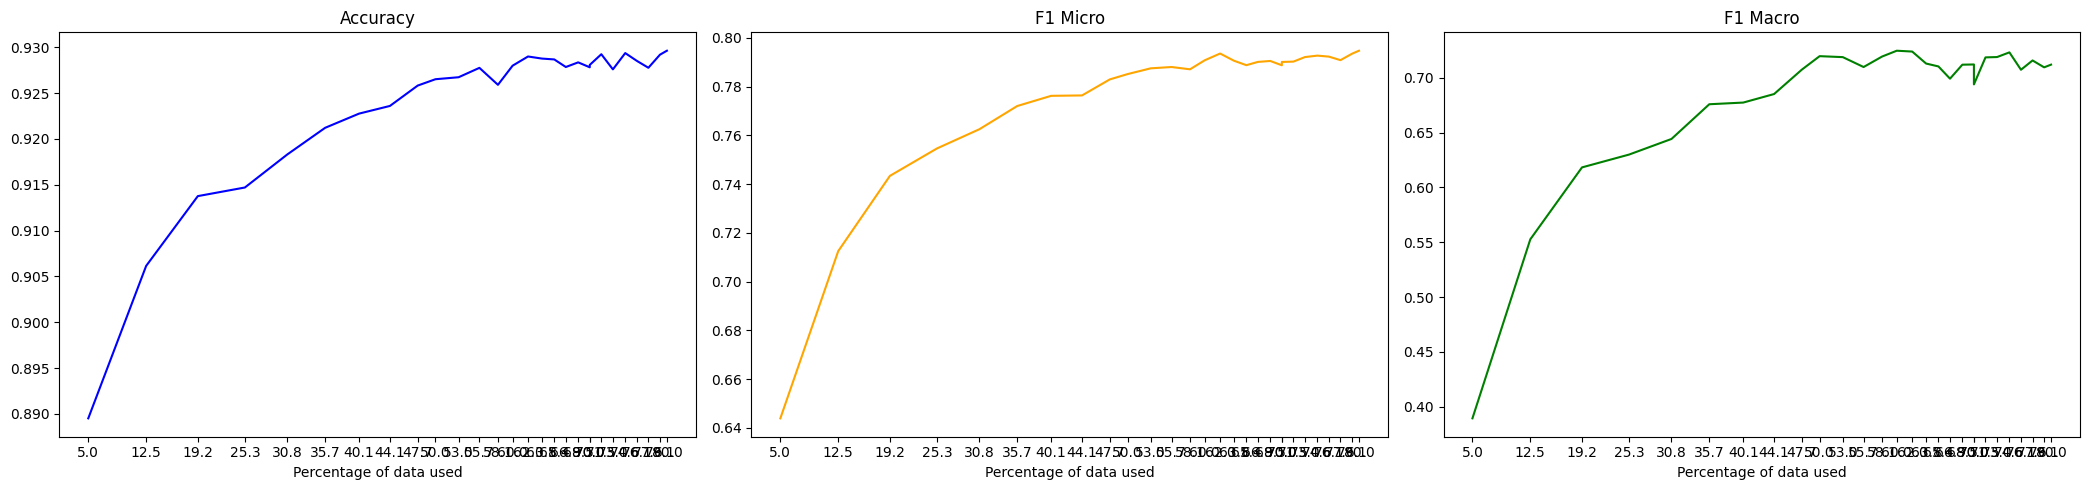

In [24]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: [81, 90, 11]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5341, Accuracy: 0.8263, F1 Micro: 0.2896, F1 Macro: 0.0616
Epoch 2/10, Train Loss: 0.4179, Accuracy: 0.8282, F1 Micro: 0.0243, F1 Macro: 0.0105
Epoch 3/10, Train Loss: 0.3769, Accuracy: 0.8377, F1 Micro: 0.1431, F1 Macro: 0.0548
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3632, Accuracy: 0.8542, F1 Micro: 0.3403, F1 Macro: 0.1159
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3417, Accuracy: 0.8717, F1 Micro: 0.4938, F1 Macro: 0.2223
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2995, Accuracy: 0.8823, F1 Micro: 0.5895, F1 Macro: 0.2882
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2634, Accuracy: 0.886, F1 Micro: 0.6182, F1 Macro: 0.3134
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2462, Accuracy: 0.8873, F1 Micro: 0.6237, F1 Macro: 0.3587
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2127, Accuracy: 0.89, F1 Micro: 0.6317, F1 Macro: 0.3787
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5496, Accuracy: 0.8306, F1 Micro: 0.1731, F1 Macro: 0.06
Epoch 2/10, Train Loss: 0.4186, Accuracy: 0.8311, F1 Micro: 0.0568, F1 Macro: 0.0229
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.375, Accuracy: 0.8478, F1 Micro: 0.2581, F1 Macro: 0.0895
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3589, Accuracy: 0.8582, F1 Micro: 0.3871, F1 Macro: 0.1215
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3376, Accuracy: 0.8704, F1 Micro: 0.4795, F1 Macro: 0.2006
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2961, Accuracy: 0.879, F1 Micro: 0.5587, F1 Macro: 0.2789
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2586, Accuracy: 0.8827, F1 Micro: 0.5789, F1 Macro: 0.3154
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2424, Accuracy: 0.8877, F1 Micro: 0.6226, F1 Macro: 0.3637
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2175, Accuracy: 0.8897, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5569, Accuracy: 0.8269, F1 Micro: 0.0396, F1 Macro: 0.0186
Epoch 2/10, Train Loss: 0.4196, Accuracy: 0.8275, F1 Micro: 0.0089, F1 Macro: 0.004
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3774, Accuracy: 0.8362, F1 Micro: 0.1188, F1 Macro: 0.046
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3697, Accuracy: 0.8451, F1 Micro: 0.2465, F1 Macro: 0.0833
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3528, Accuracy: 0.859, F1 Micro: 0.3944, F1 Macro: 0.1369
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3121, Accuracy: 0.8744, F1 Micro: 0.5122, F1 Macro: 0.2371
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2777, Accuracy: 0.8784, F1 Micro: 0.5484, F1 Macro: 0.285
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2545, Accuracy: 0.8875, F1 Micro: 0.6283, F1 Macro: 0.3757
Epoch 9/10, Train Loss: 0.2275, Accuracy: 0.8873, F1 Micro: 0.6105, F1 Macro: 0.3622
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.495, Accuracy: 0.8355, F1 Micro: 0.3998, F1 Macro: 0.1098
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4133, Accuracy: 0.8631, F1 Micro: 0.5826, F1 Macro: 0.29
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3577, Accuracy: 0.8937, F1 Micro: 0.6715, F1 Macro: 0.4107
Epoch 4/10, Train Loss: 0.301, Accuracy: 0.9016, F1 Micro: 0.668, F1 Macro: 0.4615
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2563, Accuracy: 0.9039, F1 Micro: 0.7035, F1 Macro: 0.5163
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2128, Accuracy: 0.9062, F1 Micro: 0.7171, F1 Macro: 0.5374
Epoch 7/10, Train Loss: 0.1968, Accuracy: 0.9088, F1 Micro: 0.7012, F1 Macro: 0.5253
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1552, Accuracy: 0.9083, F1 Micro: 0.7268, F1 Macro: 0.5588
Epoch 9/10, Train Loss: 0.1345, Accuracy: 0.9084, F1 Micro: 0.7218, F1 Macro: 0.5629
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5023, Accuracy: 0.8361, F1 Micro: 0.394, F1 Macro: 0.1089
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4153, Accuracy: 0.8724, F1 Micro: 0.5601, F1 Macro: 0.2504
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3578, Accuracy: 0.8897, F1 Micro: 0.6635, F1 Macro: 0.3958
Epoch 4/10, Train Loss: 0.3041, Accuracy: 0.9012, F1 Micro: 0.6606, F1 Macro: 0.4615
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2601, Accuracy: 0.9056, F1 Micro: 0.7071, F1 Macro: 0.5152
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2203, Accuracy: 0.9077, F1 Micro: 0.7197, F1 Macro: 0.5429
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1956, Accuracy: 0.9089, F1 Micro: 0.7221, F1 Macro: 0.5614
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1542, Accuracy: 0.9083, F1 Micro: 0.7279, F1 Macro: 0.5795
Epoch 9/10, Train Loss: 0.1334, Accuracy: 0.9097, F1 Micro: 0.712, F1 Macro: 0.5477
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5041, Accuracy: 0.8355, F1 Micro: 0.372, F1 Macro: 0.103
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4204, Accuracy: 0.8582, F1 Micro: 0.557, F1 Macro: 0.2672
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3643, Accuracy: 0.8909, F1 Micro: 0.654, F1 Macro: 0.3835
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3043, Accuracy: 0.8996, F1 Micro: 0.6589, F1 Macro: 0.477
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2577, Accuracy: 0.9042, F1 Micro: 0.7114, F1 Macro: 0.5198
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.217, Accuracy: 0.9066, F1 Micro: 0.7238, F1 Macro: 0.5493
Epoch 7/10, Train Loss: 0.1972, Accuracy: 0.9064, F1 Micro: 0.6973, F1 Macro: 0.5348
Epoch 8/10, Train Loss: 0.1493, Accuracy: 0.9055, F1 Micro: 0.7237, F1 Macro: 0.5647
Epoch 9/10, Train Loss: 0.1331, Accuracy: 0.9086, F1 Micro: 0.7141, F1 Macro: 0.5647
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.475, Accuracy: 0.8413, F1 Micro: 0.4597, F1 Macro: 0.1721
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3896, Accuracy: 0.893, F1 Micro: 0.6463, F1 Macro: 0.3533
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.318, Accuracy: 0.9049, F1 Micro: 0.7066, F1 Macro: 0.5102
Epoch 4/10, Train Loss: 0.2683, Accuracy: 0.9089, F1 Micro: 0.698, F1 Macro: 0.5261
Epoch 5/10, Train Loss: 0.2261, Accuracy: 0.9099, F1 Micro: 0.706, F1 Macro: 0.5343
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1925, Accuracy: 0.9152, F1 Micro: 0.7409, F1 Macro: 0.5833
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1569, Accuracy: 0.912, F1 Micro: 0.7449, F1 Macro: 0.6168
Epoch 8/10, Train Loss: 0.1272, Accuracy: 0.9162, F1 Micro: 0.7437, F1 Macro: 0.6189
Epoch 9/10, Train Loss: 0.1084, Accuracy: 0.9141, F1 Micro: 0.7448, F1 Macro: 0.6363
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0916, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4786, Accuracy: 0.8418, F1 Micro: 0.4203, F1 Macro: 0.1265
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3862, Accuracy: 0.8911, F1 Micro: 0.6146, F1 Macro: 0.3277
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3179, Accuracy: 0.906, F1 Micro: 0.7025, F1 Macro: 0.5087
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2657, Accuracy: 0.9113, F1 Micro: 0.709, F1 Macro: 0.5505
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2249, Accuracy: 0.9114, F1 Micro: 0.7282, F1 Macro: 0.5604
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1909, Accuracy: 0.9144, F1 Micro: 0.7389, F1 Macro: 0.6101
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1536, Accuracy: 0.9138, F1 Micro: 0.7443, F1 Macro: 0.634
Epoch 8/10, Train Loss: 0.1266, Accuracy: 0.9144, F1 Micro: 0.744, F1 Macro: 0.6335
Epoch 9/10, Train Loss: 0.106, Accuracy: 0.9128, F1 Micro: 0.7403, F1 Macro: 0.6385
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4803, Accuracy: 0.8339, F1 Micro: 0.4232, F1 Macro: 0.133
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3925, Accuracy: 0.8908, F1 Micro: 0.6377, F1 Macro: 0.3837
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3219, Accuracy: 0.9035, F1 Micro: 0.6997, F1 Macro: 0.4895
Epoch 4/10, Train Loss: 0.2689, Accuracy: 0.9064, F1 Micro: 0.6813, F1 Macro: 0.5043
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2274, Accuracy: 0.9125, F1 Micro: 0.7334, F1 Macro: 0.5797
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.189, Accuracy: 0.9132, F1 Micro: 0.7426, F1 Macro: 0.6196
Epoch 7/10, Train Loss: 0.1531, Accuracy: 0.9114, F1 Micro: 0.7408, F1 Macro: 0.618
Epoch 8/10, Train Loss: 0.1248, Accuracy: 0.9171, F1 Micro: 0.7423, F1 Macro: 0.6365
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1069, Accuracy: 0.9133, F1 Micro: 0.7439, F1 Macro: 0.6483
Epoch 10/10, Train Loss: 0.0906, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.453, Accuracy: 0.8534, F1 Micro: 0.5809, F1 Macro: 0.2855
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3617, Accuracy: 0.9, F1 Micro: 0.6939, F1 Macro: 0.4925
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2969, Accuracy: 0.911, F1 Micro: 0.7305, F1 Macro: 0.5557
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2451, Accuracy: 0.9127, F1 Micro: 0.7401, F1 Macro: 0.5806
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1993, Accuracy: 0.9135, F1 Micro: 0.7403, F1 Macro: 0.5887
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1655, Accuracy: 0.9167, F1 Micro: 0.7498, F1 Macro: 0.6039
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1359, Accuracy: 0.9177, F1 Micro: 0.7582, F1 Macro: 0.6293
Epoch 8/10, Train Loss: 0.1114, Accuracy: 0.9179, F1 Micro: 0.7547, F1 Macro: 0.6473
Epoch 9/10, Train Loss: 0.1014, Accuracy: 0.9167, F1 Micro: 0.7397, F1 Macro: 0.6472
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4581, Accuracy: 0.8601, F1 Micro: 0.4997, F1 Macro: 0.1955
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3586, Accuracy: 0.8983, F1 Micro: 0.6876, F1 Macro: 0.5056
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2992, Accuracy: 0.9099, F1 Micro: 0.7325, F1 Macro: 0.5676
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2462, Accuracy: 0.9132, F1 Micro: 0.7419, F1 Macro: 0.5838
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2025, Accuracy: 0.9144, F1 Micro: 0.745, F1 Macro: 0.6038
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1678, Accuracy: 0.9138, F1 Micro: 0.7535, F1 Macro: 0.6257
Epoch 7/10, Train Loss: 0.1337, Accuracy: 0.916, F1 Micro: 0.7492, F1 Macro: 0.6333
Epoch 8/10, Train Loss: 0.1178, Accuracy: 0.9154, F1 Micro: 0.7471, F1 Macro: 0.651
Epoch 9/10, Train Loss: 0.0974, Accuracy: 0.9156, F1 Micro: 0.7412, F1 Macro: 0.6472
Epoch 10/10, Train Loss: 0.0811, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4611, Accuracy: 0.8541, F1 Micro: 0.5373, F1 Macro: 0.2484
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3662, Accuracy: 0.8987, F1 Micro: 0.6892, F1 Macro: 0.476
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2992, Accuracy: 0.9098, F1 Micro: 0.7309, F1 Macro: 0.5651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2446, Accuracy: 0.9128, F1 Micro: 0.74, F1 Macro: 0.5959
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1985, Accuracy: 0.9129, F1 Micro: 0.741, F1 Macro: 0.605
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1633, Accuracy: 0.9147, F1 Micro: 0.7481, F1 Macro: 0.6471
Epoch 7/10, Train Loss: 0.1365, Accuracy: 0.9185, F1 Micro: 0.7465, F1 Macro: 0.6445
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1151, Accuracy: 0.915, F1 Micro: 0.7504, F1 Macro: 0.6558
Epoch 9/10, Train Loss: 0.0958, Accuracy: 0.9161, F1 Micro: 0.7455, F1 Macro: 0.6568
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4457, Accuracy: 0.8685, F1 Micro: 0.5568, F1 Macro: 0.26
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3467, Accuracy: 0.9079, F1 Micro: 0.7233, F1 Macro: 0.5393
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2823, Accuracy: 0.9142, F1 Micro: 0.7243, F1 Macro: 0.5684
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2336, Accuracy: 0.9167, F1 Micro: 0.7419, F1 Macro: 0.5805
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1842, Accuracy: 0.9141, F1 Micro: 0.7544, F1 Macro: 0.6131
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1492, Accuracy: 0.9182, F1 Micro: 0.7544, F1 Macro: 0.6431
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1167, Accuracy: 0.9178, F1 Micro: 0.7608, F1 Macro: 0.636
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1002, Accuracy: 0.9202, F1 Micro: 0.7627, F1 Macro: 0.6389
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4476, Accuracy: 0.875, F1 Micro: 0.5692, F1 Macro: 0.273
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3421, Accuracy: 0.9068, F1 Micro: 0.7215, F1 Macro: 0.5375
Epoch 3/10, Train Loss: 0.2808, Accuracy: 0.912, F1 Micro: 0.7108, F1 Macro: 0.5668
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2345, Accuracy: 0.9158, F1 Micro: 0.7468, F1 Macro: 0.5946
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1875, Accuracy: 0.9172, F1 Micro: 0.7612, F1 Macro: 0.6273
Epoch 6/10, Train Loss: 0.1559, Accuracy: 0.9199, F1 Micro: 0.7609, F1 Macro: 0.6432
Epoch 7/10, Train Loss: 0.1202, Accuracy: 0.9168, F1 Micro: 0.7565, F1 Macro: 0.6347
Epoch 8/10, Train Loss: 0.1072, Accuracy: 0.9201, F1 Micro: 0.7513, F1 Macro: 0.6251
Epoch 9/10, Train Loss: 0.0874, Accuracy: 0.9187, F1 Micro: 0.7544, F1 Macro: 0.6598
Epoch 10/10, Train Loss: 0.0746, Accuracy: 0.92, F1 Micro: 0.7607, F1 Macro: 0.6752
Model 2 - Iteration 40

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4505, Accuracy: 0.8686, F1 Micro: 0.5279, F1 Macro: 0.2402
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3459, Accuracy: 0.9054, F1 Micro: 0.717, F1 Macro: 0.5289
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2781, Accuracy: 0.9155, F1 Micro: 0.7289, F1 Macro: 0.5821
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2305, Accuracy: 0.9177, F1 Micro: 0.7468, F1 Macro: 0.6001
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1848, Accuracy: 0.9168, F1 Micro: 0.7564, F1 Macro: 0.6383
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1453, Accuracy: 0.9163, F1 Micro: 0.7603, F1 Macro: 0.6484
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1172, Accuracy: 0.9186, F1 Micro: 0.7634, F1 Macro: 0.6565
Epoch 8/10, Train Loss: 0.1005, Accuracy: 0.9218, F1 Micro: 0.7591, F1 Macro: 0.6634
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0783, Accuracy: 0.9186, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4363, Accuracy: 0.8827, F1 Micro: 0.6086, F1 Macro: 0.3046
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3308, Accuracy: 0.9081, F1 Micro: 0.6969, F1 Macro: 0.4793
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2769, Accuracy: 0.9108, F1 Micro: 0.7522, F1 Macro: 0.5882
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2193, Accuracy: 0.9195, F1 Micro: 0.7674, F1 Macro: 0.6257
Epoch 5/10, Train Loss: 0.1792, Accuracy: 0.9146, F1 Micro: 0.7619, F1 Macro: 0.6175
Epoch 6/10, Train Loss: 0.145, Accuracy: 0.9142, F1 Micro: 0.7608, F1 Macro: 0.644
Epoch 7/10, Train Loss: 0.1142, Accuracy: 0.9206, F1 Micro: 0.7667, F1 Macro: 0.6356
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0952, Accuracy: 0.9207, F1 Micro: 0.7706, F1 Macro: 0.6739
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0783, Accuracy: 0.9247, F1 Micro: 0.7734, F1 Macro: 0.6875
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4378, Accuracy: 0.8838, F1 Micro: 0.6229, F1 Macro: 0.299
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3265, Accuracy: 0.908, F1 Micro: 0.7047, F1 Macro: 0.4835
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2778, Accuracy: 0.9145, F1 Micro: 0.7565, F1 Macro: 0.6003
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2227, Accuracy: 0.9193, F1 Micro: 0.7675, F1 Macro: 0.6388
Epoch 5/10, Train Loss: 0.1845, Accuracy: 0.914, F1 Micro: 0.761, F1 Macro: 0.6284
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1452, Accuracy: 0.921, F1 Micro: 0.7696, F1 Macro: 0.6686
Epoch 7/10, Train Loss: 0.1164, Accuracy: 0.9164, F1 Micro: 0.7648, F1 Macro: 0.6485
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0933, Accuracy: 0.9233, F1 Micro: 0.7707, F1 Macro: 0.6776
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.083, Accuracy: 0.9222, F1 Micro: 0.7729, F1 Macro: 0.6835
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4425, Accuracy: 0.8834, F1 Micro: 0.6055, F1 Macro: 0.2936
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3298, Accuracy: 0.907, F1 Micro: 0.6996, F1 Macro: 0.4785
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2776, Accuracy: 0.9116, F1 Micro: 0.7524, F1 Macro: 0.6002
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2193, Accuracy: 0.9217, F1 Micro: 0.7594, F1 Macro: 0.633
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1798, Accuracy: 0.9143, F1 Micro: 0.7609, F1 Macro: 0.6313
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1443, Accuracy: 0.9199, F1 Micro: 0.7642, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1149, Accuracy: 0.9201, F1 Micro: 0.7677, F1 Macro: 0.6672
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.091, Accuracy: 0.9211, F1 Micro: 0.7693, F1 Macro: 0.6813
Epoch 9/10, Train Loss: 0.0761, Accuracy: 0.9218, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4291, Accuracy: 0.8842, F1 Micro: 0.6162, F1 Macro: 0.3643
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3242, Accuracy: 0.9073, F1 Micro: 0.6761, F1 Macro: 0.4801
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2665, Accuracy: 0.9186, F1 Micro: 0.7557, F1 Macro: 0.5946
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2139, Accuracy: 0.923, F1 Micro: 0.7586, F1 Macro: 0.6253
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1724, Accuracy: 0.9223, F1 Micro: 0.7728, F1 Macro: 0.6526
Epoch 6/10, Train Loss: 0.1398, Accuracy: 0.9216, F1 Micro: 0.7648, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1125, Accuracy: 0.9251, F1 Micro: 0.775, F1 Macro: 0.6715
Epoch 8/10, Train Loss: 0.0918, Accuracy: 0.9196, F1 Micro: 0.7731, F1 Macro: 0.6869
Epoch 9/10, Train Loss: 0.0786, Accuracy: 0.9203, F1 Micro: 0.7739, F1 Macro: 0.6967
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4289, Accuracy: 0.8875, F1 Micro: 0.6244, F1 Macro: 0.3382
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3226, Accuracy: 0.9084, F1 Micro: 0.6856, F1 Macro: 0.5032
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2659, Accuracy: 0.9181, F1 Micro: 0.7557, F1 Macro: 0.5891
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.218, Accuracy: 0.9218, F1 Micro: 0.7619, F1 Macro: 0.6314
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1793, Accuracy: 0.9185, F1 Micro: 0.7684, F1 Macro: 0.6495
Epoch 6/10, Train Loss: 0.14, Accuracy: 0.9226, F1 Micro: 0.7638, F1 Macro: 0.6474
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1168, Accuracy: 0.9223, F1 Micro: 0.7702, F1 Macro: 0.6727
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0928, Accuracy: 0.9231, F1 Micro: 0.7749, F1 Macro: 0.6788
Epoch 9/10, Train Loss: 0.0791, Accuracy: 0.9213, F1 Micro: 0.77, F1 Macro: 0.6908
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4328, Accuracy: 0.8846, F1 Micro: 0.6065, F1 Macro: 0.3526
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.325, Accuracy: 0.9051, F1 Micro: 0.6615, F1 Macro: 0.479
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2637, Accuracy: 0.919, F1 Micro: 0.7577, F1 Macro: 0.606
Epoch 4/10, Train Loss: 0.2128, Accuracy: 0.9216, F1 Micro: 0.7572, F1 Macro: 0.6455
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1776, Accuracy: 0.9218, F1 Micro: 0.7728, F1 Macro: 0.6695
Epoch 6/10, Train Loss: 0.1352, Accuracy: 0.9236, F1 Micro: 0.7671, F1 Macro: 0.6598
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1133, Accuracy: 0.9238, F1 Micro: 0.7779, F1 Macro: 0.6878
Epoch 8/10, Train Loss: 0.0896, Accuracy: 0.9241, F1 Micro: 0.7761, F1 Macro: 0.686
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0776, Accuracy: 0.9244, F1 Micro: 0.7796, F1 Macro: 0.7015
Epoch 10/10, Train Loss: 0.0655, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4213, Accuracy: 0.8883, F1 Micro: 0.6529, F1 Macro: 0.3798
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3204, Accuracy: 0.9139, F1 Micro: 0.7248, F1 Macro: 0.5374
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2561, Accuracy: 0.9163, F1 Micro: 0.759, F1 Macro: 0.6102
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2089, Accuracy: 0.925, F1 Micro: 0.7706, F1 Macro: 0.6352
Epoch 5/10, Train Loss: 0.1659, Accuracy: 0.9233, F1 Micro: 0.7681, F1 Macro: 0.6779
Epoch 6/10, Train Loss: 0.1272, Accuracy: 0.9248, F1 Micro: 0.7706, F1 Macro: 0.6757
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1094, Accuracy: 0.9228, F1 Micro: 0.7766, F1 Macro: 0.6993
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0933, Accuracy: 0.9262, F1 Micro: 0.7829, F1 Macro: 0.6893
Epoch 9/10, Train Loss: 0.0743, Accuracy: 0.9264, F1 Micro: 0.782, F1 Macro: 0.7084
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4234, Accuracy: 0.8897, F1 Micro: 0.67, F1 Macro: 0.4199
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3205, Accuracy: 0.9138, F1 Micro: 0.72, F1 Macro: 0.5347
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2531, Accuracy: 0.9154, F1 Micro: 0.7605, F1 Macro: 0.6193
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2058, Accuracy: 0.9257, F1 Micro: 0.777, F1 Macro: 0.6389
Epoch 5/10, Train Loss: 0.1699, Accuracy: 0.9236, F1 Micro: 0.7732, F1 Macro: 0.6653
Epoch 6/10, Train Loss: 0.1322, Accuracy: 0.923, F1 Micro: 0.7679, F1 Macro: 0.6791
Epoch 7/10, Train Loss: 0.1086, Accuracy: 0.9227, F1 Micro: 0.7695, F1 Macro: 0.69
Epoch 8/10, Train Loss: 0.0963, Accuracy: 0.9188, F1 Micro: 0.7724, F1 Macro: 0.6768
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.077, Accuracy: 0.9246, F1 Micro: 0.7782, F1 Macro: 0.7023
Epoch 10/10, Train Loss: 0.0681, Accuracy: 0.9204, F1 Micro: 0.7767, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.426, Accuracy: 0.8904, F1 Micro: 0.666, F1 Macro: 0.4384
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3196, Accuracy: 0.9134, F1 Micro: 0.7212, F1 Macro: 0.546
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2547, Accuracy: 0.9175, F1 Micro: 0.7613, F1 Macro: 0.6152
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2077, Accuracy: 0.9225, F1 Micro: 0.7713, F1 Macro: 0.649
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1667, Accuracy: 0.9254, F1 Micro: 0.7739, F1 Macro: 0.6813
Epoch 6/10, Train Loss: 0.1285, Accuracy: 0.9233, F1 Micro: 0.7686, F1 Macro: 0.69
Epoch 7/10, Train Loss: 0.1052, Accuracy: 0.9264, F1 Micro: 0.7736, F1 Macro: 0.6944
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0899, Accuracy: 0.9219, F1 Micro: 0.774, F1 Macro: 0.6862
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0759, Accuracy: 0.9267, F1 Micro: 0.7823, F1 Macro: 0.7177
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4157, Accuracy: 0.8925, F1 Micro: 0.6742, F1 Macro: 0.4456
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.305, Accuracy: 0.9147, F1 Micro: 0.7315, F1 Macro: 0.573
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2487, Accuracy: 0.9226, F1 Micro: 0.7684, F1 Macro: 0.6205
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1934, Accuracy: 0.9228, F1 Micro: 0.774, F1 Macro: 0.6387
Epoch 5/10, Train Loss: 0.1565, Accuracy: 0.9244, F1 Micro: 0.771, F1 Macro: 0.6391
Epoch 6/10, Train Loss: 0.1295, Accuracy: 0.924, F1 Micro: 0.7736, F1 Macro: 0.6734
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1005, Accuracy: 0.9235, F1 Micro: 0.7765, F1 Macro: 0.6966
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0853, Accuracy: 0.9203, F1 Micro: 0.779, F1 Macro: 0.7069
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0728, Accuracy: 0.9247, F1 Micro: 0.7851, F1 Macro: 0.7121
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4174, Accuracy: 0.8945, F1 Micro: 0.6796, F1 Macro: 0.4622
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3064, Accuracy: 0.9162, F1 Micro: 0.7362, F1 Macro: 0.5712
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2477, Accuracy: 0.9207, F1 Micro: 0.7674, F1 Macro: 0.6203
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1964, Accuracy: 0.9228, F1 Micro: 0.772, F1 Macro: 0.6265
Epoch 5/10, Train Loss: 0.158, Accuracy: 0.9225, F1 Micro: 0.7712, F1 Macro: 0.6493
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1313, Accuracy: 0.9218, F1 Micro: 0.7741, F1 Macro: 0.6701
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1029, Accuracy: 0.9243, F1 Micro: 0.7757, F1 Macro: 0.6995
Epoch 8/10, Train Loss: 0.0861, Accuracy: 0.9184, F1 Micro: 0.7738, F1 Macro: 0.6904
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0719, Accuracy: 0.9214, F1 Micro: 0.7761, F1 Macro: 0.707
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4199, Accuracy: 0.8906, F1 Micro: 0.6771, F1 Macro: 0.447
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3067, Accuracy: 0.9165, F1 Micro: 0.7386, F1 Macro: 0.5867
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.246, Accuracy: 0.9212, F1 Micro: 0.7653, F1 Macro: 0.6194
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1928, Accuracy: 0.9225, F1 Micro: 0.7747, F1 Macro: 0.6462
Epoch 5/10, Train Loss: 0.1543, Accuracy: 0.9244, F1 Micro: 0.7702, F1 Macro: 0.6409
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1285, Accuracy: 0.9263, F1 Micro: 0.7778, F1 Macro: 0.7019
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.101, Accuracy: 0.9261, F1 Micro: 0.7815, F1 Macro: 0.7081
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0812, Accuracy: 0.922, F1 Micro: 0.7815, F1 Macro: 0.711
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0735, Accuracy: 0.9254, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4128, Accuracy: 0.8973, F1 Micro: 0.6724, F1 Macro: 0.4276
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3049, Accuracy: 0.9177, F1 Micro: 0.7481, F1 Macro: 0.578
Epoch 3/10, Train Loss: 0.2417, Accuracy: 0.9204, F1 Micro: 0.7451, F1 Macro: 0.5813
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1973, Accuracy: 0.9233, F1 Micro: 0.7643, F1 Macro: 0.6271
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1581, Accuracy: 0.9256, F1 Micro: 0.7782, F1 Macro: 0.6732
Epoch 6/10, Train Loss: 0.1222, Accuracy: 0.9223, F1 Micro: 0.7705, F1 Macro: 0.665
Epoch 7/10, Train Loss: 0.1039, Accuracy: 0.9247, F1 Micro: 0.7685, F1 Macro: 0.6779
Epoch 8/10, Train Loss: 0.0872, Accuracy: 0.9251, F1 Micro: 0.7713, F1 Macro: 0.6903
Epoch 9/10, Train Loss: 0.0735, Accuracy: 0.9264, F1 Micro: 0.773, F1 Macro: 0.7014
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0617, Accuracy: 0.9277, F1 Micro: 0.7887, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4142, Accuracy: 0.8991, F1 Micro: 0.6869, F1 Macro: 0.4926
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3023, Accuracy: 0.918, F1 Micro: 0.7466, F1 Macro: 0.5785
Epoch 3/10, Train Loss: 0.24, Accuracy: 0.9184, F1 Micro: 0.7352, F1 Macro: 0.5726
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.198, Accuracy: 0.9237, F1 Micro: 0.7626, F1 Macro: 0.6323
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1623, Accuracy: 0.9248, F1 Micro: 0.7747, F1 Macro: 0.6773
Epoch 6/10, Train Loss: 0.1265, Accuracy: 0.9214, F1 Micro: 0.7719, F1 Macro: 0.6636
Epoch 7/10, Train Loss: 0.1089, Accuracy: 0.924, F1 Micro: 0.771, F1 Macro: 0.6879
Epoch 8/10, Train Loss: 0.0833, Accuracy: 0.9235, F1 Micro: 0.7729, F1 Macro: 0.6874
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0715, Accuracy: 0.9235, F1 Micro: 0.7795, F1 Macro: 0.7118
Epoch 10/10, Train Loss: 0.0616, Accuracy: 0.9253, F1 Micro: 0.7763, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4167, Accuracy: 0.8974, F1 Micro: 0.6739, F1 Macro: 0.4663
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3051, Accuracy: 0.9167, F1 Micro: 0.7468, F1 Macro: 0.5845
Epoch 3/10, Train Loss: 0.2408, Accuracy: 0.9209, F1 Micro: 0.7434, F1 Macro: 0.5769
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1941, Accuracy: 0.9247, F1 Micro: 0.7646, F1 Macro: 0.6335
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1584, Accuracy: 0.9256, F1 Micro: 0.7798, F1 Macro: 0.6847
Epoch 6/10, Train Loss: 0.1196, Accuracy: 0.9217, F1 Micro: 0.768, F1 Macro: 0.6889
Epoch 7/10, Train Loss: 0.1001, Accuracy: 0.9245, F1 Micro: 0.7739, F1 Macro: 0.7
Epoch 8/10, Train Loss: 0.0822, Accuracy: 0.9237, F1 Micro: 0.7707, F1 Macro: 0.7055
Epoch 9/10, Train Loss: 0.0714, Accuracy: 0.9213, F1 Micro: 0.7792, F1 Macro: 0.7179
Epoch 10/10, Train Loss: 0.0609, Accuracy: 0.9247, F1 Micro: 0.7779, F1 Macro: 0.7107
Model 3 - Iteration 6

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4034, Accuracy: 0.8872, F1 Micro: 0.6883, F1 Macro: 0.4718
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2958, Accuracy: 0.9134, F1 Micro: 0.7107, F1 Macro: 0.5396
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.237, Accuracy: 0.9204, F1 Micro: 0.7695, F1 Macro: 0.621
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1962, Accuracy: 0.9273, F1 Micro: 0.7833, F1 Macro: 0.6501
Epoch 5/10, Train Loss: 0.1583, Accuracy: 0.925, F1 Micro: 0.7813, F1 Macro: 0.6695
Epoch 6/10, Train Loss: 0.1192, Accuracy: 0.9253, F1 Micro: 0.7819, F1 Macro: 0.7022
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0976, Accuracy: 0.9255, F1 Micro: 0.7845, F1 Macro: 0.6887
Epoch 8/10, Train Loss: 0.0862, Accuracy: 0.9235, F1 Micro: 0.7764, F1 Macro: 0.7101
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0674, Accuracy: 0.9278, F1 Micro: 0.7856, F1 Macro: 0.7084
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4038, Accuracy: 0.8939, F1 Micro: 0.6966, F1 Macro: 0.4781
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2942, Accuracy: 0.9167, F1 Micro: 0.731, F1 Macro: 0.5655
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2382, Accuracy: 0.9226, F1 Micro: 0.7723, F1 Macro: 0.6207
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1953, Accuracy: 0.9263, F1 Micro: 0.7785, F1 Macro: 0.6565
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1591, Accuracy: 0.9249, F1 Micro: 0.7795, F1 Macro: 0.6718
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1194, Accuracy: 0.9238, F1 Micro: 0.78, F1 Macro: 0.7026
Epoch 7/10, Train Loss: 0.0971, Accuracy: 0.9203, F1 Micro: 0.7762, F1 Macro: 0.6967
Epoch 8/10, Train Loss: 0.084, Accuracy: 0.9241, F1 Micro: 0.7657, F1 Macro: 0.6982
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0666, Accuracy: 0.9264, F1 Micro: 0.7843, F1 Macro: 0.7121
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4065, Accuracy: 0.8829, F1 Micro: 0.6854, F1 Macro: 0.4805
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2946, Accuracy: 0.9159, F1 Micro: 0.7221, F1 Macro: 0.5524
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2356, Accuracy: 0.9231, F1 Micro: 0.7702, F1 Macro: 0.6211
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1905, Accuracy: 0.9255, F1 Micro: 0.7768, F1 Macro: 0.6573
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1546, Accuracy: 0.9245, F1 Micro: 0.779, F1 Macro: 0.6701
Epoch 6/10, Train Loss: 0.1188, Accuracy: 0.9229, F1 Micro: 0.7758, F1 Macro: 0.7049
Epoch 7/10, Train Loss: 0.0969, Accuracy: 0.9242, F1 Micro: 0.7769, F1 Macro: 0.7
Epoch 8/10, Train Loss: 0.0828, Accuracy: 0.9241, F1 Micro: 0.7683, F1 Macro: 0.7082
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0679, Accuracy: 0.9227, F1 Micro: 0.7811, F1 Macro: 0.7139
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3967, Accuracy: 0.9015, F1 Micro: 0.6622, F1 Macro: 0.4189
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2893, Accuracy: 0.916, F1 Micro: 0.7322, F1 Macro: 0.5529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2307, Accuracy: 0.9213, F1 Micro: 0.7722, F1 Macro: 0.6228
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1856, Accuracy: 0.9264, F1 Micro: 0.783, F1 Macro: 0.6536
Epoch 5/10, Train Loss: 0.148, Accuracy: 0.9261, F1 Micro: 0.775, F1 Macro: 0.6797
Epoch 6/10, Train Loss: 0.1181, Accuracy: 0.9258, F1 Micro: 0.7776, F1 Macro: 0.6822
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0975, Accuracy: 0.9281, F1 Micro: 0.784, F1 Macro: 0.6903
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0791, Accuracy: 0.9284, F1 Micro: 0.7884, F1 Macro: 0.7161
Epoch 9/10, Train Loss: 0.0646, Accuracy: 0.9236, F1 Micro: 0.7802, F1 Macro: 0.7071
Epoch 10/10, Train Loss: 0.0576, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3979, Accuracy: 0.9016, F1 Micro: 0.6623, F1 Macro: 0.4392
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2891, Accuracy: 0.9176, F1 Micro: 0.7375, F1 Macro: 0.5688
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2312, Accuracy: 0.9228, F1 Micro: 0.7778, F1 Macro: 0.6427
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.187, Accuracy: 0.9255, F1 Micro: 0.7806, F1 Macro: 0.6492
Epoch 5/10, Train Loss: 0.1516, Accuracy: 0.9233, F1 Micro: 0.7767, F1 Macro: 0.6795
Epoch 6/10, Train Loss: 0.1195, Accuracy: 0.9254, F1 Micro: 0.779, F1 Macro: 0.676
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0974, Accuracy: 0.9261, F1 Micro: 0.784, F1 Macro: 0.692
Epoch 8/10, Train Loss: 0.0809, Accuracy: 0.9245, F1 Micro: 0.7816, F1 Macro: 0.7054
Epoch 9/10, Train Loss: 0.0679, Accuracy: 0.9266, F1 Micro: 0.7831, F1 Macro: 0.7109
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0573, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4003, Accuracy: 0.9, F1 Micro: 0.659, F1 Macro: 0.4426
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2883, Accuracy: 0.9181, F1 Micro: 0.7382, F1 Macro: 0.5806
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2282, Accuracy: 0.921, F1 Micro: 0.7694, F1 Macro: 0.6221
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1818, Accuracy: 0.9248, F1 Micro: 0.7729, F1 Macro: 0.6486
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1451, Accuracy: 0.9268, F1 Micro: 0.7801, F1 Macro: 0.6883
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1177, Accuracy: 0.926, F1 Micro: 0.7811, F1 Macro: 0.6899
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0947, Accuracy: 0.9266, F1 Micro: 0.7867, F1 Macro: 0.7042
Epoch 8/10, Train Loss: 0.0789, Accuracy: 0.9257, F1 Micro: 0.7856, F1 Macro: 0.7194
Epoch 9/10, Train Loss: 0.0673, Accuracy: 0.9286, F1 Micro: 0.7853, F1 Macro: 0.722
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.391, Accuracy: 0.9004, F1 Micro: 0.693, F1 Macro: 0.4427
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2805, Accuracy: 0.9197, F1 Micro: 0.7562, F1 Macro: 0.5861
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2214, Accuracy: 0.9211, F1 Micro: 0.7723, F1 Macro: 0.6124
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1802, Accuracy: 0.927, F1 Micro: 0.7764, F1 Macro: 0.6569
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1424, Accuracy: 0.9264, F1 Micro: 0.7858, F1 Macro: 0.7019
Epoch 6/10, Train Loss: 0.1157, Accuracy: 0.9272, F1 Micro: 0.7762, F1 Macro: 0.6892
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0912, Accuracy: 0.9281, F1 Micro: 0.7904, F1 Macro: 0.7188
Epoch 8/10, Train Loss: 0.0723, Accuracy: 0.9276, F1 Micro: 0.7856, F1 Macro: 0.7063
Epoch 9/10, Train Loss: 0.0641, Accuracy: 0.9288, F1 Micro: 0.7892, F1 Macro: 0.7137
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3919, Accuracy: 0.9005, F1 Micro: 0.6997, F1 Macro: 0.4585
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2799, Accuracy: 0.919, F1 Micro: 0.7567, F1 Macro: 0.5975
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2243, Accuracy: 0.9194, F1 Micro: 0.7685, F1 Macro: 0.6084
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1827, Accuracy: 0.9275, F1 Micro: 0.775, F1 Macro: 0.6459
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1476, Accuracy: 0.9258, F1 Micro: 0.7779, F1 Macro: 0.6794
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1168, Accuracy: 0.9284, F1 Micro: 0.784, F1 Macro: 0.6913
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0938, Accuracy: 0.926, F1 Micro: 0.785, F1 Macro: 0.7077
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0761, Accuracy: 0.9271, F1 Micro: 0.7883, F1 Macro: 0.7247
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.06

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.395, Accuracy: 0.8994, F1 Micro: 0.6991, F1 Macro: 0.4646
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.28, Accuracy: 0.9198, F1 Micro: 0.7562, F1 Macro: 0.5922
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2223, Accuracy: 0.9222, F1 Micro: 0.7715, F1 Macro: 0.6376
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.179, Accuracy: 0.927, F1 Micro: 0.7748, F1 Macro: 0.6752
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.143, Accuracy: 0.9247, F1 Micro: 0.7835, F1 Macro: 0.7033
Epoch 6/10, Train Loss: 0.114, Accuracy: 0.9263, F1 Micro: 0.7741, F1 Macro: 0.7019
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0876, Accuracy: 0.927, F1 Micro: 0.7862, F1 Macro: 0.7153
Epoch 8/10, Train Loss: 0.0722, Accuracy: 0.9274, F1 Micro: 0.7852, F1 Macro: 0.7137
Epoch 9/10, Train Loss: 0.0651, Accuracy: 0.9272, F1 Micro: 0.7845, F1 Macro: 0.7172
Higher F1 achieved, saving model
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3873, Accuracy: 0.9032, F1 Micro: 0.6999, F1 Macro: 0.4775
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2763, Accuracy: 0.9177, F1 Micro: 0.756, F1 Macro: 0.601
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2189, Accuracy: 0.9217, F1 Micro: 0.7752, F1 Macro: 0.6332
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1738, Accuracy: 0.9261, F1 Micro: 0.7782, F1 Macro: 0.6421
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1409, Accuracy: 0.927, F1 Micro: 0.7832, F1 Macro: 0.6564
Epoch 6/10, Train Loss: 0.1135, Accuracy: 0.9265, F1 Micro: 0.7822, F1 Macro: 0.6813
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0868, Accuracy: 0.931, F1 Micro: 0.7943, F1 Macro: 0.7097
Epoch 8/10, Train Loss: 0.0742, Accuracy: 0.9273, F1 Micro: 0.7888, F1 Macro: 0.6969
Epoch 9/10, Train Loss: 0.0629, Accuracy: 0.9268, F1 Micro: 0.7883, F1 Macro: 0.7228
Epoch 10/10, Train Loss: 0.0536, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3858, Accuracy: 0.9049, F1 Micro: 0.7042, F1 Macro: 0.4887
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2733, Accuracy: 0.9173, F1 Micro: 0.7609, F1 Macro: 0.608
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2189, Accuracy: 0.9238, F1 Micro: 0.7802, F1 Macro: 0.6549
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1751, Accuracy: 0.9275, F1 Micro: 0.7836, F1 Macro: 0.6563
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.142, Accuracy: 0.9285, F1 Micro: 0.7859, F1 Macro: 0.6607
Epoch 6/10, Train Loss: 0.1174, Accuracy: 0.9256, F1 Micro: 0.7743, F1 Macro: 0.6809
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0961, Accuracy: 0.9269, F1 Micro: 0.7873, F1 Macro: 0.705
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0749, Accuracy: 0.9288, F1 Micro: 0.7901, F1 Macro: 0.7077
Epoch 9/10, Train Loss: 0.0646, Accuracy: 0.9275, F1 Micro: 0.7831, F1 Macro: 0.7167
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3906, Accuracy: 0.9017, F1 Micro: 0.7028, F1 Macro: 0.5041
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2751, Accuracy: 0.9164, F1 Micro: 0.7583, F1 Macro: 0.6074
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2204, Accuracy: 0.9226, F1 Micro: 0.7784, F1 Macro: 0.665
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1745, Accuracy: 0.9269, F1 Micro: 0.7826, F1 Macro: 0.6583
Epoch 5/10, Train Loss: 0.1412, Accuracy: 0.9274, F1 Micro: 0.7767, F1 Macro: 0.6646
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1137, Accuracy: 0.9294, F1 Micro: 0.7872, F1 Macro: 0.7049
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0885, Accuracy: 0.9276, F1 Micro: 0.7876, F1 Macro: 0.7153
Epoch 8/10, Train Loss: 0.0711, Accuracy: 0.9273, F1 Micro: 0.7778, F1 Macro: 0.6955
Epoch 9/10, Train Loss: 0.0642, Accuracy: 0.926, F1 Micro: 0.7847, F1 Macro: 0.7193
Epoch 10/10, Train Loss: 0.0547, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3859, Accuracy: 0.9028, F1 Micro: 0.6901, F1 Macro: 0.4574
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2747, Accuracy: 0.919, F1 Micro: 0.7613, F1 Macro: 0.5912
Epoch 3/10, Train Loss: 0.2159, Accuracy: 0.9231, F1 Micro: 0.754, F1 Macro: 0.5962
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1744, Accuracy: 0.9225, F1 Micro: 0.7782, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1422, Accuracy: 0.9254, F1 Micro: 0.7822, F1 Macro: 0.6746
Epoch 6/10, Train Loss: 0.1073, Accuracy: 0.9268, F1 Micro: 0.7778, F1 Macro: 0.6893
Epoch 7/10, Train Loss: 0.0908, Accuracy: 0.9252, F1 Micro: 0.7789, F1 Macro: 0.6995
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0757, Accuracy: 0.9286, F1 Micro: 0.7878, F1 Macro: 0.7172
Epoch 9/10, Train Loss: 0.0638, Accuracy: 0.9272, F1 Micro: 0.7858, F1 Macro: 0.7151
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0556, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3847, Accuracy: 0.9036, F1 Micro: 0.6903, F1 Macro: 0.4665
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.272, Accuracy: 0.9195, F1 Micro: 0.7623, F1 Macro: 0.601
Epoch 3/10, Train Loss: 0.2173, Accuracy: 0.9195, F1 Micro: 0.7332, F1 Macro: 0.583
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1745, Accuracy: 0.9207, F1 Micro: 0.7777, F1 Macro: 0.6604
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1431, Accuracy: 0.9267, F1 Micro: 0.7824, F1 Macro: 0.6726
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.113, Accuracy: 0.9289, F1 Micro: 0.7869, F1 Macro: 0.7049
Epoch 7/10, Train Loss: 0.0935, Accuracy: 0.9248, F1 Micro: 0.78, F1 Macro: 0.6941
Epoch 8/10, Train Loss: 0.0741, Accuracy: 0.9254, F1 Micro: 0.7812, F1 Macro: 0.7014
Epoch 9/10, Train Loss: 0.0634, Accuracy: 0.9252, F1 Micro: 0.7828, F1 Macro: 0.7158
Epoch 10/10, Train Loss: 0.0544, Accuracy: 0.9231, F1 Micro: 0.7797, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3879, Accuracy: 0.9031, F1 Micro: 0.6899, F1 Macro: 0.4713
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2715, Accuracy: 0.9181, F1 Micro: 0.7597, F1 Macro: 0.604
Epoch 3/10, Train Loss: 0.2134, Accuracy: 0.9218, F1 Micro: 0.7412, F1 Macro: 0.5901
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1698, Accuracy: 0.9219, F1 Micro: 0.7782, F1 Macro: 0.6712
Epoch 5/10, Train Loss: 0.1404, Accuracy: 0.9232, F1 Micro: 0.7704, F1 Macro: 0.6833
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1067, Accuracy: 0.9284, F1 Micro: 0.7846, F1 Macro: 0.7073
Epoch 7/10, Train Loss: 0.0891, Accuracy: 0.9255, F1 Micro: 0.7732, F1 Macro: 0.6973
Epoch 8/10, Train Loss: 0.0743, Accuracy: 0.9257, F1 Micro: 0.7827, F1 Macro: 0.7162
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0604, Accuracy: 0.9265, F1 Micro: 0.7853, F1 Macro: 0.7204
Epoch 10/10, Train Loss: 0.0524, Accuracy: 0.9271, F1 Micro: 0.7826, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.376, Accuracy: 0.9036, F1 Micro: 0.7046, F1 Macro: 0.4751
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2623, Accuracy: 0.9199, F1 Micro: 0.7605, F1 Macro: 0.5981
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2138, Accuracy: 0.9235, F1 Micro: 0.7734, F1 Macro: 0.6062
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1673, Accuracy: 0.9271, F1 Micro: 0.7834, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1352, Accuracy: 0.9282, F1 Micro: 0.7878, F1 Macro: 0.699
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1007, Accuracy: 0.9281, F1 Micro: 0.7896, F1 Macro: 0.7089
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0883, Accuracy: 0.9282, F1 Micro: 0.7918, F1 Macro: 0.7192
Epoch 8/10, Train Loss: 0.07, Accuracy: 0.9277, F1 Micro: 0.7865, F1 Macro: 0.7123
Epoch 9/10, Train Loss: 0.0637, Accuracy: 0.9266, F1 Micro: 0.7841, F1 Macro: 0.715
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3759, Accuracy: 0.9046, F1 Micro: 0.7107, F1 Macro: 0.5107
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2606, Accuracy: 0.92, F1 Micro: 0.7599, F1 Macro: 0.5939
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2134, Accuracy: 0.9237, F1 Micro: 0.7758, F1 Macro: 0.6274
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1679, Accuracy: 0.9258, F1 Micro: 0.7814, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.139, Accuracy: 0.9284, F1 Micro: 0.7838, F1 Macro: 0.6853
Epoch 6/10, Train Loss: 0.1036, Accuracy: 0.9284, F1 Micro: 0.7825, F1 Macro: 0.7043
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0915, Accuracy: 0.9282, F1 Micro: 0.787, F1 Macro: 0.7077
Epoch 8/10, Train Loss: 0.0735, Accuracy: 0.9257, F1 Micro: 0.7822, F1 Macro: 0.7075
Epoch 9/10, Train Loss: 0.0628, Accuracy: 0.9293, F1 Micro: 0.7866, F1 Macro: 0.7187
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3805, Accuracy: 0.9028, F1 Micro: 0.7044, F1 Macro: 0.4888
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.262, Accuracy: 0.9195, F1 Micro: 0.7571, F1 Macro: 0.5919
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2117, Accuracy: 0.9237, F1 Micro: 0.7783, F1 Macro: 0.6339
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1693, Accuracy: 0.9262, F1 Micro: 0.7812, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.136, Accuracy: 0.9283, F1 Micro: 0.7831, F1 Macro: 0.6989
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1003, Accuracy: 0.9276, F1 Micro: 0.784, F1 Macro: 0.7092
Epoch 7/10, Train Loss: 0.087, Accuracy: 0.9271, F1 Micro: 0.7828, F1 Macro: 0.7154
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0723, Accuracy: 0.9244, F1 Micro: 0.785, F1 Macro: 0.7192
Epoch 9/10, Train Loss: 0.0589, Accuracy: 0.926, F1 Micro: 0.7825, F1 Macro: 0.7203
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3673, Accuracy: 0.9056, F1 Micro: 0.7094, F1 Macro: 0.4929
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2561, Accuracy: 0.9177, F1 Micro: 0.734, F1 Macro: 0.5617
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2062, Accuracy: 0.9237, F1 Micro: 0.7624, F1 Macro: 0.6097
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1634, Accuracy: 0.9261, F1 Micro: 0.7847, F1 Macro: 0.6884
Epoch 5/10, Train Loss: 0.1352, Accuracy: 0.9268, F1 Micro: 0.7812, F1 Macro: 0.6907
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1066, Accuracy: 0.9289, F1 Micro: 0.7894, F1 Macro: 0.7046
Epoch 7/10, Train Loss: 0.0885, Accuracy: 0.9302, F1 Micro: 0.7851, F1 Macro: 0.7021
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0705, Accuracy: 0.9289, F1 Micro: 0.7923, F1 Macro: 0.7233
Epoch 9/10, Train Loss: 0.0601, Accuracy: 0.9275, F1 Micro: 0.7921, F1 Macro: 0.7258
Epoch 10/10, Train Loss: 0.0509, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3675, Accuracy: 0.9043, F1 Micro: 0.7046, F1 Macro: 0.4763
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2553, Accuracy: 0.9184, F1 Micro: 0.7375, F1 Macro: 0.5773
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2047, Accuracy: 0.9226, F1 Micro: 0.7633, F1 Macro: 0.6187
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1661, Accuracy: 0.923, F1 Micro: 0.7831, F1 Macro: 0.6817
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1358, Accuracy: 0.9265, F1 Micro: 0.7838, F1 Macro: 0.6967
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1083, Accuracy: 0.9273, F1 Micro: 0.787, F1 Macro: 0.7012
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0876, Accuracy: 0.9299, F1 Micro: 0.7907, F1 Macro: 0.7159
Epoch 8/10, Train Loss: 0.069, Accuracy: 0.9257, F1 Micro: 0.783, F1 Macro: 0.7203
Epoch 9/10, Train Loss: 0.0602, Accuracy: 0.9279, F1 Micro: 0.7893, F1 Macro: 0.7308
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.372, Accuracy: 0.9052, F1 Micro: 0.7065, F1 Macro: 0.4984
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2538, Accuracy: 0.9185, F1 Micro: 0.7399, F1 Macro: 0.5803
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2013, Accuracy: 0.9245, F1 Micro: 0.7681, F1 Macro: 0.6255
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1623, Accuracy: 0.9272, F1 Micro: 0.7866, F1 Macro: 0.6917
Epoch 5/10, Train Loss: 0.1345, Accuracy: 0.9239, F1 Micro: 0.7741, F1 Macro: 0.6789
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1049, Accuracy: 0.9288, F1 Micro: 0.7882, F1 Macro: 0.7067
Epoch 7/10, Train Loss: 0.0849, Accuracy: 0.9287, F1 Micro: 0.7819, F1 Macro: 0.7081
Epoch 8/10, Train Loss: 0.0658, Accuracy: 0.9258, F1 Micro: 0.7836, F1 Macro: 0.7173
Epoch 9/10, Train Loss: 0.0575, Accuracy: 0.9254, F1 Micro: 0.7866, F1 Macro: 0.7243
Epoch 10/10, Train Loss: 0.0489, Accuracy: 0.9269, F1 Micro: 0.7881, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3638, Accuracy: 0.904, F1 Micro: 0.6992, F1 Macro: 0.468
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2509, Accuracy: 0.9178, F1 Micro: 0.7613, F1 Macro: 0.6018
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.204, Accuracy: 0.925, F1 Micro: 0.7754, F1 Macro: 0.6247
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.167, Accuracy: 0.928, F1 Micro: 0.7854, F1 Macro: 0.6731
Epoch 5/10, Train Loss: 0.1321, Accuracy: 0.9265, F1 Micro: 0.7849, F1 Macro: 0.6803
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1005, Accuracy: 0.9294, F1 Micro: 0.7881, F1 Macro: 0.6761
Epoch 7/10, Train Loss: 0.0817, Accuracy: 0.9291, F1 Micro: 0.7862, F1 Macro: 0.7139
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0673, Accuracy: 0.9296, F1 Micro: 0.7932, F1 Macro: 0.7232
Epoch 9/10, Train Loss: 0.0577, Accuracy: 0.9266, F1 Micro: 0.7855, F1 Macro: 0.7097
Epoch 10/10, Train Loss: 0.0495, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3644, Accuracy: 0.9037, F1 Micro: 0.7004, F1 Macro: 0.4862
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2516, Accuracy: 0.9188, F1 Micro: 0.7621, F1 Macro: 0.5964
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2028, Accuracy: 0.9266, F1 Micro: 0.7808, F1 Macro: 0.6329
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.165, Accuracy: 0.9296, F1 Micro: 0.7892, F1 Macro: 0.6789
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1319, Accuracy: 0.9284, F1 Micro: 0.7893, F1 Macro: 0.6958
Epoch 6/10, Train Loss: 0.1033, Accuracy: 0.928, F1 Micro: 0.7856, F1 Macro: 0.6743
Epoch 7/10, Train Loss: 0.0829, Accuracy: 0.9279, F1 Micro: 0.7855, F1 Macro: 0.7135
Epoch 8/10, Train Loss: 0.0679, Accuracy: 0.9289, F1 Micro: 0.7851, F1 Macro: 0.7064
Epoch 9/10, Train Loss: 0.0597, Accuracy: 0.9267, F1 Micro: 0.7839, F1 Macro: 0.7198
Epoch 10/10, Train Loss: 0.0472, Accuracy: 0.9254, F1 Micro: 0.7805, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.368, Accuracy: 0.9045, F1 Micro: 0.6847, F1 Macro: 0.4622
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2498, Accuracy: 0.9188, F1 Micro: 0.7628, F1 Macro: 0.6085
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2012, Accuracy: 0.9258, F1 Micro: 0.7753, F1 Macro: 0.6274
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1617, Accuracy: 0.9289, F1 Micro: 0.7798, F1 Macro: 0.6877
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1297, Accuracy: 0.9263, F1 Micro: 0.786, F1 Macro: 0.6938
Epoch 6/10, Train Loss: 0.1012, Accuracy: 0.9288, F1 Micro: 0.7829, F1 Macro: 0.6916
Epoch 7/10, Train Loss: 0.0806, Accuracy: 0.9265, F1 Micro: 0.7843, F1 Macro: 0.7221
Epoch 8/10, Train Loss: 0.0652, Accuracy: 0.9286, F1 Micro: 0.7847, F1 Macro: 0.7127
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0589, Accuracy: 0.9283, F1 Micro: 0.7878, F1 Macro: 0.7214
Epoch 10/10, Train Loss: 0.0482, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3607, Accuracy: 0.9075, F1 Micro: 0.694, F1 Macro: 0.4704
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2438, Accuracy: 0.9167, F1 Micro: 0.7594, F1 Macro: 0.5824
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1941, Accuracy: 0.9248, F1 Micro: 0.7792, F1 Macro: 0.6327
Epoch 4/10, Train Loss: 0.1552, Accuracy: 0.9275, F1 Micro: 0.7786, F1 Macro: 0.6418
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1284, Accuracy: 0.9278, F1 Micro: 0.7792, F1 Macro: 0.6702
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0997, Accuracy: 0.93, F1 Micro: 0.7906, F1 Macro: 0.6907
Epoch 7/10, Train Loss: 0.0812, Accuracy: 0.9266, F1 Micro: 0.7864, F1 Macro: 0.7083
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.068, Accuracy: 0.9283, F1 Micro: 0.7912, F1 Macro: 0.7164
Epoch 9/10, Train Loss: 0.0546, Accuracy: 0.9272, F1 Micro: 0.7864, F1 Macro: 0.719
Epoch 10/10, Train Loss: 0.0499, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3599, Accuracy: 0.9065, F1 Micro: 0.6852, F1 Macro: 0.4603
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2424, Accuracy: 0.9173, F1 Micro: 0.76, F1 Macro: 0.5832
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1954, Accuracy: 0.9256, F1 Micro: 0.7771, F1 Macro: 0.6389
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1583, Accuracy: 0.9291, F1 Micro: 0.7793, F1 Macro: 0.6443
Epoch 5/10, Train Loss: 0.1321, Accuracy: 0.9271, F1 Micro: 0.7735, F1 Macro: 0.6598
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1016, Accuracy: 0.928, F1 Micro: 0.786, F1 Macro: 0.686
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0828, Accuracy: 0.9261, F1 Micro: 0.7861, F1 Macro: 0.7075
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0696, Accuracy: 0.9273, F1 Micro: 0.7886, F1 Macro: 0.7202
Epoch 9/10, Train Loss: 0.0584, Accuracy: 0.9257, F1 Micro: 0.784, F1 Macro: 0.7178
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3648, Accuracy: 0.908, F1 Micro: 0.7034, F1 Macro: 0.4706
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2411, Accuracy: 0.9177, F1 Micro: 0.7586, F1 Macro: 0.5817
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1942, Accuracy: 0.9262, F1 Micro: 0.7792, F1 Macro: 0.6476
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1557, Accuracy: 0.9278, F1 Micro: 0.7847, F1 Macro: 0.6496
Epoch 5/10, Train Loss: 0.1237, Accuracy: 0.9267, F1 Micro: 0.7786, F1 Macro: 0.6915
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0993, Accuracy: 0.9272, F1 Micro: 0.7885, F1 Macro: 0.6904
Epoch 7/10, Train Loss: 0.0794, Accuracy: 0.9274, F1 Micro: 0.7846, F1 Macro: 0.7132
Epoch 8/10, Train Loss: 0.0652, Accuracy: 0.9254, F1 Micro: 0.7815, F1 Macro: 0.7169
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0549, Accuracy: 0.9271, F1 Micro: 0.7886, F1 Macro: 0.7279
Epoch 10/10, Train Loss: 0.0467, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3586, Accuracy: 0.9066, F1 Micro: 0.7154, F1 Macro: 0.5296
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2474, Accuracy: 0.9198, F1 Micro: 0.7444, F1 Macro: 0.5649
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1947, Accuracy: 0.9248, F1 Micro: 0.7721, F1 Macro: 0.628
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1545, Accuracy: 0.9287, F1 Micro: 0.7826, F1 Macro: 0.648
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1244, Accuracy: 0.9237, F1 Micro: 0.7847, F1 Macro: 0.6712
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0966, Accuracy: 0.9281, F1 Micro: 0.7915, F1 Macro: 0.6868
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0799, Accuracy: 0.9287, F1 Micro: 0.7919, F1 Macro: 0.7095
Epoch 8/10, Train Loss: 0.0666, Accuracy: 0.9283, F1 Micro: 0.7868, F1 Macro: 0.7236
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0539, Accuracy: 0.9293, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3577, Accuracy: 0.9063, F1 Micro: 0.7158, F1 Macro: 0.5364
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2469, Accuracy: 0.9213, F1 Micro: 0.7549, F1 Macro: 0.5778
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1951, Accuracy: 0.927, F1 Micro: 0.7762, F1 Macro: 0.6455
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1561, Accuracy: 0.9282, F1 Micro: 0.7786, F1 Macro: 0.6462
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1222, Accuracy: 0.925, F1 Micro: 0.7823, F1 Macro: 0.6798
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0964, Accuracy: 0.9263, F1 Micro: 0.7861, F1 Macro: 0.7057
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0802, Accuracy: 0.9277, F1 Micro: 0.7869, F1 Macro: 0.703
Epoch 8/10, Train Loss: 0.0692, Accuracy: 0.9277, F1 Micro: 0.7843, F1 Macro: 0.712
Epoch 9/10, Train Loss: 0.0532, Accuracy: 0.9249, F1 Micro: 0.7823, F1 Macro: 0.7131
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3605, Accuracy: 0.906, F1 Micro: 0.7201, F1 Macro: 0.5406
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.246, Accuracy: 0.922, F1 Micro: 0.7576, F1 Macro: 0.5912
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1929, Accuracy: 0.9256, F1 Micro: 0.7739, F1 Macro: 0.6483
Epoch 4/10, Train Loss: 0.1503, Accuracy: 0.9267, F1 Micro: 0.7721, F1 Macro: 0.6609
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1223, Accuracy: 0.9274, F1 Micro: 0.7885, F1 Macro: 0.6845
Epoch 6/10, Train Loss: 0.0928, Accuracy: 0.9254, F1 Micro: 0.7874, F1 Macro: 0.704
Epoch 7/10, Train Loss: 0.0781, Accuracy: 0.9257, F1 Micro: 0.7808, F1 Macro: 0.7077
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0664, Accuracy: 0.9266, F1 Micro: 0.7897, F1 Macro: 0.7241
Epoch 9/10, Train Loss: 0.0549, Accuracy: 0.927, F1 Micro: 0.7863, F1 Macro: 0.7188
Epoch 10/10, Train Loss: 0.045, Accuracy: 0.9267, F1 Micro: 0.7838, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3543, Accuracy: 0.9075, F1 Micro: 0.7058, F1 Macro: 0.4891
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2407, Accuracy: 0.9219, F1 Micro: 0.7657, F1 Macro: 0.6059
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1914, Accuracy: 0.9257, F1 Micro: 0.7747, F1 Macro: 0.6176
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1549, Accuracy: 0.9263, F1 Micro: 0.7865, F1 Macro: 0.6622
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1243, Accuracy: 0.9307, F1 Micro: 0.7889, F1 Macro: 0.6768
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0956, Accuracy: 0.9306, F1 Micro: 0.7948, F1 Macro: 0.7044
Epoch 7/10, Train Loss: 0.0799, Accuracy: 0.9298, F1 Micro: 0.7847, F1 Macro: 0.7096
Epoch 8/10, Train Loss: 0.0694, Accuracy: 0.9294, F1 Micro: 0.7933, F1 Macro: 0.7181
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0525, Accuracy: 0.9302, F1 Micro: 0.7974, F1 Macro: 0.7219
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3542, Accuracy: 0.908, F1 Micro: 0.7124, F1 Macro: 0.4964
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2408, Accuracy: 0.9218, F1 Micro: 0.7547, F1 Macro: 0.5976
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1909, Accuracy: 0.9264, F1 Micro: 0.7753, F1 Macro: 0.6235
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1564, Accuracy: 0.928, F1 Micro: 0.7914, F1 Macro: 0.662
Epoch 5/10, Train Loss: 0.1262, Accuracy: 0.9293, F1 Micro: 0.783, F1 Macro: 0.6733
Epoch 6/10, Train Loss: 0.0986, Accuracy: 0.93, F1 Micro: 0.7908, F1 Macro: 0.7081
Epoch 7/10, Train Loss: 0.0798, Accuracy: 0.9271, F1 Micro: 0.7856, F1 Macro: 0.711
Epoch 8/10, Train Loss: 0.068, Accuracy: 0.9297, F1 Micro: 0.7884, F1 Macro: 0.7195
Epoch 9/10, Train Loss: 0.0535, Accuracy: 0.9258, F1 Micro: 0.7884, F1 Macro: 0.7206
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0454, Accuracy: 0.9282, F1 Micro: 0.7942, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3582, Accuracy: 0.9062, F1 Micro: 0.6815, F1 Macro: 0.4778
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2397, Accuracy: 0.9227, F1 Micro: 0.7574, F1 Macro: 0.6038
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1918, Accuracy: 0.9266, F1 Micro: 0.7782, F1 Macro: 0.6292
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1532, Accuracy: 0.9269, F1 Micro: 0.7859, F1 Macro: 0.6734
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1203, Accuracy: 0.9308, F1 Micro: 0.7893, F1 Macro: 0.6989
Epoch 6/10, Train Loss: 0.0937, Accuracy: 0.928, F1 Micro: 0.7858, F1 Macro: 0.7159
Epoch 7/10, Train Loss: 0.0775, Accuracy: 0.9277, F1 Micro: 0.7745, F1 Macro: 0.7057
Epoch 8/10, Train Loss: 0.0653, Accuracy: 0.9276, F1 Micro: 0.7822, F1 Macro: 0.716
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0547, Accuracy: 0.9292, F1 Micro: 0.7899, F1 Macro: 0.7172
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3527, Accuracy: 0.9074, F1 Micro: 0.7069, F1 Macro: 0.4817
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2359, Accuracy: 0.9206, F1 Micro: 0.7482, F1 Macro: 0.5729
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1909, Accuracy: 0.9215, F1 Micro: 0.7492, F1 Macro: 0.6011
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1529, Accuracy: 0.9246, F1 Micro: 0.7812, F1 Macro: 0.669
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1201, Accuracy: 0.9223, F1 Micro: 0.7845, F1 Macro: 0.6721
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0988, Accuracy: 0.9266, F1 Micro: 0.7882, F1 Macro: 0.6867
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0769, Accuracy: 0.9295, F1 Micro: 0.7912, F1 Macro: 0.7163
Epoch 8/10, Train Loss: 0.0667, Accuracy: 0.9276, F1 Micro: 0.7836, F1 Macro: 0.7149
Epoch 9/10, Train Loss: 0.0564, Accuracy: 0.9297, F1 Micro: 0.7876, F1 Macro: 0.7189
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3536, Accuracy: 0.9068, F1 Micro: 0.7119, F1 Macro: 0.5084
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2367, Accuracy: 0.9223, F1 Micro: 0.7605, F1 Macro: 0.5912
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1898, Accuracy: 0.9248, F1 Micro: 0.7677, F1 Macro: 0.6219
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1537, Accuracy: 0.9249, F1 Micro: 0.7826, F1 Macro: 0.6815
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1208, Accuracy: 0.9246, F1 Micro: 0.7858, F1 Macro: 0.6829
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0987, Accuracy: 0.9279, F1 Micro: 0.7915, F1 Macro: 0.6992
Epoch 7/10, Train Loss: 0.0784, Accuracy: 0.9291, F1 Micro: 0.7881, F1 Macro: 0.7031
Epoch 8/10, Train Loss: 0.0658, Accuracy: 0.928, F1 Micro: 0.7876, F1 Macro: 0.7175
Epoch 9/10, Train Loss: 0.0548, Accuracy: 0.9275, F1 Micro: 0.7863, F1 Macro: 0.7226
Epoch 10/10, Train Loss: 0.0461, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3582, Accuracy: 0.907, F1 Micro: 0.7094, F1 Macro: 0.5048
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2348, Accuracy: 0.9207, F1 Micro: 0.7515, F1 Macro: 0.5897
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1895, Accuracy: 0.9251, F1 Micro: 0.7593, F1 Macro: 0.6302
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1502, Accuracy: 0.9257, F1 Micro: 0.7803, F1 Macro: 0.675
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1179, Accuracy: 0.9255, F1 Micro: 0.7894, F1 Macro: 0.6962
Epoch 6/10, Train Loss: 0.0928, Accuracy: 0.9289, F1 Micro: 0.7838, F1 Macro: 0.6881
Epoch 7/10, Train Loss: 0.0767, Accuracy: 0.9235, F1 Micro: 0.7809, F1 Macro: 0.7036
Epoch 8/10, Train Loss: 0.0632, Accuracy: 0.9271, F1 Micro: 0.7814, F1 Macro: 0.7145
Epoch 9/10, Train Loss: 0.0554, Accuracy: 0.9282, F1 Micro: 0.7865, F1 Macro: 0.7219
Epoch 10/10, Train Loss: 0.0442, Accuracy: 0.9262, F1 Micro: 0.7821, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3446, Accuracy: 0.9069, F1 Micro: 0.7145, F1 Macro: 0.5236
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2375, Accuracy: 0.9211, F1 Micro: 0.7613, F1 Macro: 0.5994
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1873, Accuracy: 0.9275, F1 Micro: 0.7818, F1 Macro: 0.652
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.153, Accuracy: 0.9294, F1 Micro: 0.7877, F1 Macro: 0.6604
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1144, Accuracy: 0.9278, F1 Micro: 0.7896, F1 Macro: 0.6909
Epoch 6/10, Train Loss: 0.0919, Accuracy: 0.9244, F1 Micro: 0.7855, F1 Macro: 0.7064
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0742, Accuracy: 0.9298, F1 Micro: 0.7957, F1 Macro: 0.7219
Epoch 8/10, Train Loss: 0.062, Accuracy: 0.9278, F1 Micro: 0.7766, F1 Macro: 0.7014
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0526, Accuracy: 0.932, F1 Micro: 0.7991, F1 Macro: 0.7323
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3445, Accuracy: 0.9054, F1 Micro: 0.7051, F1 Macro: 0.5158
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2391, Accuracy: 0.9208, F1 Micro: 0.7666, F1 Macro: 0.6054
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1882, Accuracy: 0.9256, F1 Micro: 0.7801, F1 Macro: 0.6486
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1552, Accuracy: 0.9282, F1 Micro: 0.7829, F1 Macro: 0.6525
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1194, Accuracy: 0.9272, F1 Micro: 0.7888, F1 Macro: 0.6797
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0937, Accuracy: 0.9287, F1 Micro: 0.7894, F1 Macro: 0.7021
Epoch 7/10, Train Loss: 0.0768, Accuracy: 0.926, F1 Micro: 0.787, F1 Macro: 0.7157
Epoch 8/10, Train Loss: 0.0617, Accuracy: 0.9276, F1 Micro: 0.7886, F1 Macro: 0.7155
Epoch 9/10, Train Loss: 0.0551, Accuracy: 0.9246, F1 Micro: 0.7842, F1 Macro: 0.7204
Epoch 10/10, Train Loss: 0.0462, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3486, Accuracy: 0.9077, F1 Micro: 0.712, F1 Macro: 0.5197
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.235, Accuracy: 0.9222, F1 Micro: 0.7645, F1 Macro: 0.6015
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1855, Accuracy: 0.9269, F1 Micro: 0.7803, F1 Macro: 0.6499
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1498, Accuracy: 0.9282, F1 Micro: 0.7841, F1 Macro: 0.6639
Epoch 5/10, Train Loss: 0.1123, Accuracy: 0.9266, F1 Micro: 0.7837, F1 Macro: 0.687
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.091, Accuracy: 0.9286, F1 Micro: 0.7883, F1 Macro: 0.7091
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0732, Accuracy: 0.9267, F1 Micro: 0.7883, F1 Macro: 0.7154
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0623, Accuracy: 0.9258, F1 Micro: 0.7887, F1 Macro: 0.7186
Epoch 9/10, Train Loss: 0.0499, Accuracy: 0.9267, F1 Micro: 0.7882, F1 Macro: 0.7175
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3417, Accuracy: 0.9085, F1 Micro: 0.7129, F1 Macro: 0.5056
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2249, Accuracy: 0.9215, F1 Micro: 0.7653, F1 Macro: 0.6066
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1831, Accuracy: 0.9272, F1 Micro: 0.7795, F1 Macro: 0.6288
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1433, Accuracy: 0.9254, F1 Micro: 0.788, F1 Macro: 0.6653
Epoch 5/10, Train Loss: 0.1173, Accuracy: 0.9293, F1 Micro: 0.7878, F1 Macro: 0.6668
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.093, Accuracy: 0.9276, F1 Micro: 0.7882, F1 Macro: 0.6985
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0777, Accuracy: 0.9289, F1 Micro: 0.7939, F1 Macro: 0.7074
Epoch 8/10, Train Loss: 0.0606, Accuracy: 0.9281, F1 Micro: 0.7902, F1 Macro: 0.708
Epoch 9/10, Train Loss: 0.0528, Accuracy: 0.9293, F1 Micro: 0.7851, F1 Macro: 0.7122
Epoch 10/10, Train Loss: 0.0438, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3428, Accuracy: 0.9082, F1 Micro: 0.7124, F1 Macro: 0.5105
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2246, Accuracy: 0.9204, F1 Micro: 0.7609, F1 Macro: 0.6017
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1828, Accuracy: 0.9258, F1 Micro: 0.7779, F1 Macro: 0.6381
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1462, Accuracy: 0.9283, F1 Micro: 0.7902, F1 Macro: 0.6671
Epoch 5/10, Train Loss: 0.1157, Accuracy: 0.9298, F1 Micro: 0.7875, F1 Macro: 0.6659
Epoch 6/10, Train Loss: 0.0922, Accuracy: 0.9275, F1 Micro: 0.7878, F1 Macro: 0.7006
Epoch 7/10, Train Loss: 0.0763, Accuracy: 0.9285, F1 Micro: 0.7887, F1 Macro: 0.7156
Epoch 8/10, Train Loss: 0.0619, Accuracy: 0.9273, F1 Micro: 0.7864, F1 Macro: 0.7204
Epoch 9/10, Train Loss: 0.0527, Accuracy: 0.929, F1 Micro: 0.788, F1 Macro: 0.7159
Epoch 10/10, Train Loss: 0.042, Accuracy: 0.9257, F1 Micro: 0.7834, F1 Macro: 0.722
Model 2 - Iteration 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3472, Accuracy: 0.9082, F1 Micro: 0.7202, F1 Macro: 0.5375
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2261, Accuracy: 0.9211, F1 Micro: 0.763, F1 Macro: 0.6082
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1806, Accuracy: 0.9268, F1 Micro: 0.7771, F1 Macro: 0.6412
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1422, Accuracy: 0.9278, F1 Micro: 0.7855, F1 Macro: 0.6792
Epoch 5/10, Train Loss: 0.1155, Accuracy: 0.9276, F1 Micro: 0.7848, F1 Macro: 0.6892
Epoch 6/10, Train Loss: 0.0919, Accuracy: 0.9258, F1 Micro: 0.7849, F1 Macro: 0.7137
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.073, Accuracy: 0.9277, F1 Micro: 0.7926, F1 Macro: 0.7248
Epoch 8/10, Train Loss: 0.06, Accuracy: 0.9283, F1 Micro: 0.7877, F1 Macro: 0.7184
Epoch 9/10, Train Loss: 0.0505, Accuracy: 0.9268, F1 Micro: 0.785, F1 Macro: 0.7145
Epoch 10/10, Train Loss: 0.0409, Accuracy: 0.9267, F1 Micro: 0.7853, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3378, Accuracy: 0.9069, F1 Micro: 0.6951, F1 Macro: 0.4916
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2261, Accuracy: 0.9186, F1 Micro: 0.7592, F1 Macro: 0.5805
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1792, Accuracy: 0.9259, F1 Micro: 0.7768, F1 Macro: 0.6225
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1439, Accuracy: 0.9265, F1 Micro: 0.7878, F1 Macro: 0.6556
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1114, Accuracy: 0.93, F1 Micro: 0.7895, F1 Macro: 0.6943
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0918, Accuracy: 0.9275, F1 Micro: 0.7898, F1 Macro: 0.6991
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0735, Accuracy: 0.9283, F1 Micro: 0.7913, F1 Macro: 0.7185
Epoch 8/10, Train Loss: 0.0618, Accuracy: 0.9283, F1 Micro: 0.7874, F1 Macro: 0.711
Epoch 9/10, Train Loss: 0.0522, Accuracy: 0.9232, F1 Micro: 0.7843, F1 Macro: 0.7107
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.336, Accuracy: 0.9044, F1 Micro: 0.6682, F1 Macro: 0.4499
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2266, Accuracy: 0.9198, F1 Micro: 0.76, F1 Macro: 0.5841
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1784, Accuracy: 0.9246, F1 Micro: 0.782, F1 Macro: 0.6397
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1456, Accuracy: 0.9228, F1 Micro: 0.7832, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1143, Accuracy: 0.9249, F1 Micro: 0.7865, F1 Macro: 0.6851
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.095, Accuracy: 0.9262, F1 Micro: 0.7865, F1 Macro: 0.7089
Epoch 7/10, Train Loss: 0.0782, Accuracy: 0.9281, F1 Micro: 0.7856, F1 Macro: 0.7139
Epoch 8/10, Train Loss: 0.0634, Accuracy: 0.9266, F1 Micro: 0.7841, F1 Macro: 0.7126
Epoch 9/10, Train Loss: 0.051, Accuracy: 0.923, F1 Micro: 0.7842, F1 Macro: 0.7159
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.341, Accuracy: 0.9045, F1 Micro: 0.6732, F1 Macro: 0.4711
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2263, Accuracy: 0.9152, F1 Micro: 0.7559, F1 Macro: 0.5828
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.178, Accuracy: 0.9241, F1 Micro: 0.7726, F1 Macro: 0.6177
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1431, Accuracy: 0.9225, F1 Micro: 0.7795, F1 Macro: 0.6544
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1105, Accuracy: 0.9253, F1 Micro: 0.7802, F1 Macro: 0.6947
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0917, Accuracy: 0.9272, F1 Micro: 0.7842, F1 Macro: 0.6907
Epoch 7/10, Train Loss: 0.0737, Accuracy: 0.9271, F1 Micro: 0.784, F1 Macro: 0.7186
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0608, Accuracy: 0.93, F1 Micro: 0.7935, F1 Macro: 0.7246
Epoch 9/10, Train Loss: 0.0506, Accuracy: 0.9273, F1 Micro: 0.7904, F1 Macro: 0.7256
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3286, Accuracy: 0.9084, F1 Micro: 0.713, F1 Macro: 0.4891
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2225, Accuracy: 0.9174, F1 Micro: 0.7514, F1 Macro: 0.5653
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1731, Accuracy: 0.928, F1 Micro: 0.7832, F1 Macro: 0.6423
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1383, Accuracy: 0.9278, F1 Micro: 0.7886, F1 Macro: 0.6684
Epoch 5/10, Train Loss: 0.1134, Accuracy: 0.9229, F1 Micro: 0.7828, F1 Macro: 0.6954
Epoch 6/10, Train Loss: 0.0876, Accuracy: 0.9276, F1 Micro: 0.7865, F1 Macro: 0.7115
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0697, Accuracy: 0.9325, F1 Micro: 0.7988, F1 Macro: 0.727
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0564, Accuracy: 0.9315, F1 Micro: 0.8019, F1 Macro: 0.7359
Epoch 9/10, Train Loss: 0.0482, Accuracy: 0.9301, F1 Micro: 0.7974, F1 Macro: 0.731
Epoch 10/10, Train Loss: 0.0408, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3277, Accuracy: 0.9076, F1 Micro: 0.7087, F1 Macro: 0.4819
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2243, Accuracy: 0.921, F1 Micro: 0.7638, F1 Macro: 0.5889
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1729, Accuracy: 0.9293, F1 Micro: 0.7831, F1 Macro: 0.655
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.14, Accuracy: 0.9232, F1 Micro: 0.784, F1 Macro: 0.6691
Epoch 5/10, Train Loss: 0.1143, Accuracy: 0.9267, F1 Micro: 0.7816, F1 Macro: 0.6889
Epoch 6/10, Train Loss: 0.0887, Accuracy: 0.9285, F1 Micro: 0.7788, F1 Macro: 0.6893
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0705, Accuracy: 0.9296, F1 Micro: 0.785, F1 Macro: 0.7035
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0587, Accuracy: 0.9305, F1 Micro: 0.791, F1 Macro: 0.7243
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0474, Accuracy: 0.9296, F1 Micro: 0.7963, F1 Macro: 0.7311
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3319, Accuracy: 0.908, F1 Micro: 0.7139, F1 Macro: 0.5031
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2225, Accuracy: 0.92, F1 Micro: 0.7642, F1 Macro: 0.6008
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1732, Accuracy: 0.9257, F1 Micro: 0.7765, F1 Macro: 0.6372
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1387, Accuracy: 0.9261, F1 Micro: 0.7848, F1 Macro: 0.6813
Epoch 5/10, Train Loss: 0.1112, Accuracy: 0.9242, F1 Micro: 0.7828, F1 Macro: 0.6902
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0849, Accuracy: 0.9301, F1 Micro: 0.7898, F1 Macro: 0.7139
Epoch 7/10, Train Loss: 0.0686, Accuracy: 0.9275, F1 Micro: 0.7821, F1 Macro: 0.7177
Epoch 8/10, Train Loss: 0.0561, Accuracy: 0.9287, F1 Micro: 0.7836, F1 Macro: 0.723
Epoch 9/10, Train Loss: 0.0494, Accuracy: 0.9246, F1 Micro: 0.7867, F1 Macro: 0.7184
Epoch 10/10, Train Loss: 0.0394, Accuracy: 0.9257, F1 Micro: 0.7872, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3247, Accuracy: 0.9074, F1 Micro: 0.7172, F1 Macro: 0.5103
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2159, Accuracy: 0.9215, F1 Micro: 0.757, F1 Macro: 0.5823
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1761, Accuracy: 0.9275, F1 Micro: 0.7799, F1 Macro: 0.6358
Epoch 4/10, Train Loss: 0.1355, Accuracy: 0.9258, F1 Micro: 0.7754, F1 Macro: 0.6324
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1075, Accuracy: 0.9286, F1 Micro: 0.7823, F1 Macro: 0.662
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0859, Accuracy: 0.9299, F1 Micro: 0.7922, F1 Macro: 0.7044
Epoch 7/10, Train Loss: 0.0676, Accuracy: 0.9277, F1 Micro: 0.7842, F1 Macro: 0.7134
Epoch 8/10, Train Loss: 0.0558, Accuracy: 0.9273, F1 Micro: 0.7871, F1 Macro: 0.7211
Epoch 9/10, Train Loss: 0.0464, Accuracy: 0.9253, F1 Micro: 0.7871, F1 Macro: 0.7183
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0418, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3259, Accuracy: 0.9071, F1 Micro: 0.7148, F1 Macro: 0.4976
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2172, Accuracy: 0.9219, F1 Micro: 0.7565, F1 Macro: 0.5911
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1771, Accuracy: 0.9271, F1 Micro: 0.7784, F1 Macro: 0.6402
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.138, Accuracy: 0.9272, F1 Micro: 0.7828, F1 Macro: 0.6634
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1089, Accuracy: 0.9271, F1 Micro: 0.7834, F1 Macro: 0.6661
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.088, Accuracy: 0.9295, F1 Micro: 0.789, F1 Macro: 0.7106
Epoch 7/10, Train Loss: 0.0697, Accuracy: 0.9268, F1 Micro: 0.7871, F1 Macro: 0.7153
Epoch 8/10, Train Loss: 0.0564, Accuracy: 0.9258, F1 Micro: 0.7882, F1 Macro: 0.7197
Epoch 9/10, Train Loss: 0.0496, Accuracy: 0.9229, F1 Micro: 0.7812, F1 Macro: 0.722
Epoch 10/10, Train Loss: 0.041, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3301, Accuracy: 0.9077, F1 Micro: 0.7169, F1 Macro: 0.5013
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2156, Accuracy: 0.9225, F1 Micro: 0.7647, F1 Macro: 0.599
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1733, Accuracy: 0.9258, F1 Micro: 0.7802, F1 Macro: 0.6505
Epoch 4/10, Train Loss: 0.1348, Accuracy: 0.9279, F1 Micro: 0.7787, F1 Macro: 0.6618
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1062, Accuracy: 0.9276, F1 Micro: 0.7845, F1 Macro: 0.6871
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0854, Accuracy: 0.9277, F1 Micro: 0.7856, F1 Macro: 0.7122
Epoch 7/10, Train Loss: 0.0663, Accuracy: 0.9299, F1 Micro: 0.7852, F1 Macro: 0.7111
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0537, Accuracy: 0.9289, F1 Micro: 0.7907, F1 Macro: 0.7215
Epoch 9/10, Train Loss: 0.0474, Accuracy: 0.928, F1 Micro: 0.7901, F1 Macro: 0.723
Epoch 10/10, Train Loss: 0.038, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3295, Accuracy: 0.906, F1 Micro: 0.7138, F1 Macro: 0.4818
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2154, Accuracy: 0.9151, F1 Micro: 0.7632, F1 Macro: 0.6034
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1717, Accuracy: 0.9264, F1 Micro: 0.7694, F1 Macro: 0.6124
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1367, Accuracy: 0.9216, F1 Micro: 0.775, F1 Macro: 0.6419
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1139, Accuracy: 0.9289, F1 Micro: 0.7918, F1 Macro: 0.6979
Epoch 6/10, Train Loss: 0.0868, Accuracy: 0.9243, F1 Micro: 0.7865, F1 Macro: 0.6918
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.075, Accuracy: 0.9289, F1 Micro: 0.7937, F1 Macro: 0.7214
Epoch 8/10, Train Loss: 0.0568, Accuracy: 0.9287, F1 Micro: 0.7844, F1 Macro: 0.7127
Epoch 9/10, Train Loss: 0.0474, Accuracy: 0.9303, F1 Micro: 0.791, F1 Macro: 0.7222
Epoch 10/10, Train Loss: 0.0413, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.329, Accuracy: 0.9027, F1 Micro: 0.6998, F1 Macro: 0.4266
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2179, Accuracy: 0.9169, F1 Micro: 0.7652, F1 Macro: 0.6031
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1745, Accuracy: 0.9252, F1 Micro: 0.7666, F1 Macro: 0.5988
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1385, Accuracy: 0.9192, F1 Micro: 0.7727, F1 Macro: 0.6347
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1147, Accuracy: 0.9304, F1 Micro: 0.7899, F1 Macro: 0.6998
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0901, Accuracy: 0.9265, F1 Micro: 0.7932, F1 Macro: 0.7079
Epoch 7/10, Train Loss: 0.0763, Accuracy: 0.9268, F1 Micro: 0.7917, F1 Macro: 0.7172
Epoch 8/10, Train Loss: 0.0581, Accuracy: 0.9282, F1 Micro: 0.7852, F1 Macro: 0.7128
Epoch 9/10, Train Loss: 0.0491, Accuracy: 0.9289, F1 Micro: 0.7906, F1 Macro: 0.7299
Epoch 10/10, Train Loss: 0.041, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.333, Accuracy: 0.9062, F1 Micro: 0.7137, F1 Macro: 0.4818
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2145, Accuracy: 0.9135, F1 Micro: 0.7562, F1 Macro: 0.5837
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1713, Accuracy: 0.9244, F1 Micro: 0.7635, F1 Macro: 0.6195
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.136, Accuracy: 0.9185, F1 Micro: 0.7694, F1 Macro: 0.6401
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1092, Accuracy: 0.9266, F1 Micro: 0.7853, F1 Macro: 0.7092
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0873, Accuracy: 0.9289, F1 Micro: 0.787, F1 Macro: 0.7084
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.071, Accuracy: 0.9294, F1 Micro: 0.7908, F1 Macro: 0.728
Epoch 8/10, Train Loss: 0.0563, Accuracy: 0.9253, F1 Micro: 0.7808, F1 Macro: 0.7099
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.048, Accuracy: 0.9293, F1 Micro: 0.

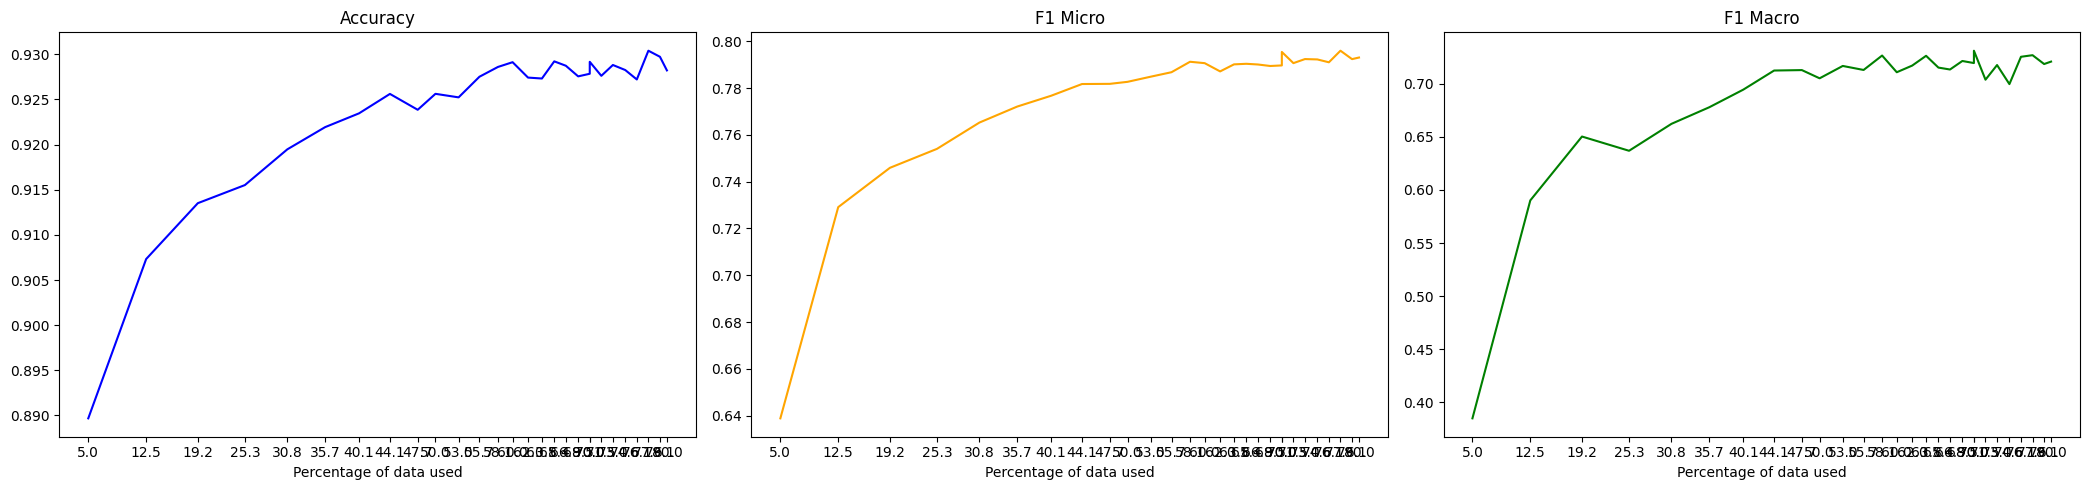

In [ ]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: [14, 7, 33]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5356, Accuracy: 0.8282, F1 Micro: 0.0362, F1 Macro: 0.0134
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4166, Accuracy: 0.8319, F1 Micro: 0.0681, F1 Macro: 0.0278
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3751, Accuracy: 0.8415, F1 Micro: 0.1821, F1 Macro: 0.0677
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3581, Accuracy: 0.8578, F1 Micro: 0.3857, F1 Macro: 0.1235
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.332, Accuracy: 0.8682, F1 Micro: 0.4815, F1 Macro: 0.2321
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2859, Accuracy: 0.8781, F1 Micro: 0.5652, F1 Macro: 0.3008
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2566, Accuracy: 0.8836, F1 Micro: 0.6098, F1 Macro: 0.338
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2353, Accuracy: 0.8861, F1 Micro: 0.6177, F1 Macro: 0.3756
Epoch 9/10, Train Loss: 0.2121, Accuracy: 0.887, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5536, Accuracy: 0.8278, F1 Micro: 0.0173, F1 Macro: 0.0076
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4234, Accuracy: 0.8307, F1 Micro: 0.0554, F1 Macro: 0.0223
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3784, Accuracy: 0.8389, F1 Micro: 0.1535, F1 Macro: 0.0583
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3671, Accuracy: 0.8559, F1 Micro: 0.359, F1 Macro: 0.1169
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3443, Accuracy: 0.8661, F1 Micro: 0.4565, F1 Macro: 0.1811
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2995, Accuracy: 0.8787, F1 Micro: 0.5536, F1 Macro: 0.2818
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2651, Accuracy: 0.8836, F1 Micro: 0.5869, F1 Macro: 0.3338
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2444, Accuracy: 0.8863, F1 Micro: 0.6088, F1 Macro: 0.3586
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5564, Accuracy: 0.8306, F1 Micro: 0.1013, F1 Macro: 0.0348
Epoch 2/10, Train Loss: 0.4228, Accuracy: 0.8299, F1 Micro: 0.0419, F1 Macro: 0.0174
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3793, Accuracy: 0.8449, F1 Micro: 0.2306, F1 Macro: 0.0817
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3638, Accuracy: 0.8535, F1 Micro: 0.3461, F1 Macro: 0.1102
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3389, Accuracy: 0.8684, F1 Micro: 0.4603, F1 Macro: 0.2077
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2998, Accuracy: 0.8801, F1 Micro: 0.5717, F1 Macro: 0.3078
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2586, Accuracy: 0.8866, F1 Micro: 0.6362, F1 Macro: 0.3766
Epoch 8/10, Train Loss: 0.2428, Accuracy: 0.8879, F1 Micro: 0.6247, F1 Macro: 0.3817
Epoch 9/10, Train Loss: 0.2118, Accuracy: 0.888, F1 Micro: 0.6162, F1 Macro: 0.3657
Higher F1 achieved, saving model
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4937, Accuracy: 0.831, F1 Micro: 0.4129, F1 Macro: 0.1109
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4059, Accuracy: 0.8679, F1 Micro: 0.4774, F1 Macro: 0.1921
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3543, Accuracy: 0.8908, F1 Micro: 0.6707, F1 Macro: 0.4077
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2992, Accuracy: 0.9005, F1 Micro: 0.6722, F1 Macro: 0.4638
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2545, Accuracy: 0.9024, F1 Micro: 0.7, F1 Macro: 0.5384
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.209, Accuracy: 0.9023, F1 Micro: 0.7119, F1 Macro: 0.5245
Epoch 7/10, Train Loss: 0.1879, Accuracy: 0.9045, F1 Micro: 0.6861, F1 Macro: 0.513
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1553, Accuracy: 0.9047, F1 Micro: 0.7193, F1 Macro: 0.5623
Epoch 9/10, Train Loss: 0.1313, Accuracy: 0.9059, F1 Micro: 0.7184, F1 Macro: 0.562
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5021, Accuracy: 0.8254, F1 Micro: 0.3939, F1 Macro: 0.1062
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4117, Accuracy: 0.8633, F1 Micro: 0.4912, F1 Macro: 0.1947
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3616, Accuracy: 0.8919, F1 Micro: 0.6575, F1 Macro: 0.3887
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3061, Accuracy: 0.9011, F1 Micro: 0.6823, F1 Macro: 0.4759
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2589, Accuracy: 0.8991, F1 Micro: 0.6868, F1 Macro: 0.5314
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2184, Accuracy: 0.9008, F1 Micro: 0.7127, F1 Macro: 0.5398
Epoch 7/10, Train Loss: 0.1921, Accuracy: 0.9031, F1 Micro: 0.7013, F1 Macro: 0.5189
Epoch 8/10, Train Loss: 0.1614, Accuracy: 0.9041, F1 Micro: 0.7065, F1 Macro: 0.5548
Epoch 9/10, Train Loss: 0.1351, Accuracy: 0.9045, F1 Micro: 0.705, F1 Macro: 0.5482
Epoch 10/10, Train Loss: 0.1109, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4996, Accuracy: 0.8271, F1 Micro: 0.4077, F1 Macro: 0.1093
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4113, Accuracy: 0.858, F1 Micro: 0.4692, F1 Macro: 0.1691
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3638, Accuracy: 0.892, F1 Micro: 0.6585, F1 Macro: 0.3792
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3075, Accuracy: 0.9003, F1 Micro: 0.683, F1 Macro: 0.4397
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2653, Accuracy: 0.8997, F1 Micro: 0.6939, F1 Macro: 0.5261
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2174, Accuracy: 0.9005, F1 Micro: 0.7059, F1 Macro: 0.5177
Epoch 7/10, Train Loss: 0.1887, Accuracy: 0.904, F1 Micro: 0.6873, F1 Macro: 0.511
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1609, Accuracy: 0.9052, F1 Micro: 0.7148, F1 Macro: 0.5584
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1387, Accuracy: 0.9018, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4708, Accuracy: 0.8457, F1 Micro: 0.4242, F1 Macro: 0.1225
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3771, Accuracy: 0.8834, F1 Micro: 0.5509, F1 Macro: 0.2911
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3117, Accuracy: 0.9034, F1 Micro: 0.7044, F1 Macro: 0.4885
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2629, Accuracy: 0.9089, F1 Micro: 0.7168, F1 Macro: 0.5427
Epoch 5/10, Train Loss: 0.223, Accuracy: 0.91, F1 Micro: 0.7108, F1 Macro: 0.5378
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1774, Accuracy: 0.9096, F1 Micro: 0.7197, F1 Macro: 0.5424
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1449, Accuracy: 0.9103, F1 Micro: 0.7224, F1 Macro: 0.567
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1166, Accuracy: 0.912, F1 Micro: 0.7312, F1 Macro: 0.5891
Epoch 9/10, Train Loss: 0.1018, Accuracy: 0.9097, F1 Micro: 0.7261, F1 Macro: 0.589
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4758, Accuracy: 0.8453, F1 Micro: 0.4174, F1 Macro: 0.122
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3829, Accuracy: 0.8805, F1 Micro: 0.5354, F1 Macro: 0.28
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3178, Accuracy: 0.9037, F1 Micro: 0.7086, F1 Macro: 0.5011
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2667, Accuracy: 0.9089, F1 Micro: 0.7181, F1 Macro: 0.5448
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2249, Accuracy: 0.9098, F1 Micro: 0.7187, F1 Macro: 0.5399
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1841, Accuracy: 0.9118, F1 Micro: 0.7263, F1 Macro: 0.5448
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1462, Accuracy: 0.912, F1 Micro: 0.7385, F1 Macro: 0.5791
Epoch 8/10, Train Loss: 0.1187, Accuracy: 0.9118, F1 Micro: 0.716, F1 Macro: 0.5805
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1072, Accuracy: 0.9134, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4738, Accuracy: 0.8412, F1 Micro: 0.4021, F1 Macro: 0.1247
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3821, Accuracy: 0.8842, F1 Micro: 0.5665, F1 Macro: 0.2888
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3159, Accuracy: 0.9005, F1 Micro: 0.7094, F1 Macro: 0.4766
Epoch 4/10, Train Loss: 0.2642, Accuracy: 0.908, F1 Micro: 0.7049, F1 Macro: 0.5317
Epoch 5/10, Train Loss: 0.2257, Accuracy: 0.9087, F1 Micro: 0.7045, F1 Macro: 0.5358
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1817, Accuracy: 0.9097, F1 Micro: 0.7166, F1 Macro: 0.5434
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1459, Accuracy: 0.9098, F1 Micro: 0.7264, F1 Macro: 0.571
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1177, Accuracy: 0.9098, F1 Micro: 0.7298, F1 Macro: 0.5843
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1046, Accuracy: 0.9111, F1 Micro: 0.7337, F1 Macro: 0.5946
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4546, Accuracy: 0.8608, F1 Micro: 0.4723, F1 Macro: 0.1767
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3623, Accuracy: 0.8991, F1 Micro: 0.6634, F1 Macro: 0.4436
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2991, Accuracy: 0.9077, F1 Micro: 0.7342, F1 Macro: 0.5618
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2456, Accuracy: 0.9126, F1 Micro: 0.7456, F1 Macro: 0.592
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2011, Accuracy: 0.9154, F1 Micro: 0.7464, F1 Macro: 0.5879
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1595, Accuracy: 0.911, F1 Micro: 0.7486, F1 Macro: 0.6003
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1299, Accuracy: 0.9123, F1 Micro: 0.75, F1 Macro: 0.6048
Epoch 8/10, Train Loss: 0.1109, Accuracy: 0.9167, F1 Micro: 0.7483, F1 Macro: 0.6205
Epoch 9/10, Train Loss: 0.0941, Accuracy: 0.916, F1 Micro: 0.7405, F1 Macro: 0.619
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.46, Accuracy: 0.8542, F1 Micro: 0.4831, F1 Macro: 0.1942
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3692, Accuracy: 0.8972, F1 Micro: 0.6632, F1 Macro: 0.4716
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3034, Accuracy: 0.9095, F1 Micro: 0.7263, F1 Macro: 0.5466
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2452, Accuracy: 0.9127, F1 Micro: 0.7382, F1 Macro: 0.5858
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2019, Accuracy: 0.9158, F1 Micro: 0.7468, F1 Macro: 0.5898
Epoch 6/10, Train Loss: 0.1626, Accuracy: 0.9148, F1 Micro: 0.7425, F1 Macro: 0.5993
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1363, Accuracy: 0.9156, F1 Micro: 0.7495, F1 Macro: 0.6003
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1102, Accuracy: 0.916, F1 Micro: 0.7502, F1 Macro: 0.6319
Epoch 9/10, Train Loss: 0.093, Accuracy: 0.9167, F1 Micro: 0.7427, F1 Macro: 0.6223
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4602, Accuracy: 0.8475, F1 Micro: 0.5118, F1 Macro: 0.2244
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3702, Accuracy: 0.898, F1 Micro: 0.6806, F1 Macro: 0.4837
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3033, Accuracy: 0.9088, F1 Micro: 0.732, F1 Macro: 0.5473
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2469, Accuracy: 0.9128, F1 Micro: 0.7449, F1 Macro: 0.5927
Epoch 5/10, Train Loss: 0.2009, Accuracy: 0.9146, F1 Micro: 0.743, F1 Macro: 0.5809
Epoch 6/10, Train Loss: 0.1637, Accuracy: 0.9109, F1 Micro: 0.7446, F1 Macro: 0.5911
Epoch 7/10, Train Loss: 0.1358, Accuracy: 0.9139, F1 Micro: 0.736, F1 Macro: 0.5811
Epoch 8/10, Train Loss: 0.1121, Accuracy: 0.9132, F1 Micro: 0.7438, F1 Macro: 0.6104
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0955, Accuracy: 0.9142, F1 Micro: 0.7501, F1 Macro: 0.6149
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0855, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4467, Accuracy: 0.877, F1 Micro: 0.5814, F1 Macro: 0.2846
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3349, Accuracy: 0.907, F1 Micro: 0.7164, F1 Macro: 0.5265
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2806, Accuracy: 0.9147, F1 Micro: 0.7267, F1 Macro: 0.5348
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2353, Accuracy: 0.9163, F1 Micro: 0.7282, F1 Macro: 0.5687
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1798, Accuracy: 0.9201, F1 Micro: 0.763, F1 Macro: 0.6199
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1537, Accuracy: 0.9167, F1 Micro: 0.7661, F1 Macro: 0.6331
Epoch 7/10, Train Loss: 0.1187, Accuracy: 0.9186, F1 Micro: 0.7566, F1 Macro: 0.6275
Epoch 8/10, Train Loss: 0.1071, Accuracy: 0.9202, F1 Micro: 0.7592, F1 Macro: 0.6371
Epoch 9/10, Train Loss: 0.0911, Accuracy: 0.9137, F1 Micro: 0.7627, F1 Macro: 0.6603
Epoch 10/10, Train Loss: 0.075, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4532, Accuracy: 0.8668, F1 Micro: 0.5594, F1 Macro: 0.2638
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3435, Accuracy: 0.9063, F1 Micro: 0.7064, F1 Macro: 0.497
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2858, Accuracy: 0.9138, F1 Micro: 0.7331, F1 Macro: 0.5418
Epoch 4/10, Train Loss: 0.2399, Accuracy: 0.9167, F1 Micro: 0.7283, F1 Macro: 0.5655
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1848, Accuracy: 0.9204, F1 Micro: 0.7638, F1 Macro: 0.6257
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1566, Accuracy: 0.915, F1 Micro: 0.7646, F1 Macro: 0.6436
Epoch 7/10, Train Loss: 0.1226, Accuracy: 0.9209, F1 Micro: 0.7593, F1 Macro: 0.6371
Epoch 8/10, Train Loss: 0.1067, Accuracy: 0.9211, F1 Micro: 0.7604, F1 Macro: 0.6375
Epoch 9/10, Train Loss: 0.089, Accuracy: 0.9181, F1 Micro: 0.7639, F1 Macro: 0.6603
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0727, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4516, Accuracy: 0.8631, F1 Micro: 0.5068, F1 Macro: 0.2225
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3441, Accuracy: 0.905, F1 Micro: 0.7085, F1 Macro: 0.4838
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.288, Accuracy: 0.9129, F1 Micro: 0.7344, F1 Macro: 0.5415
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2409, Accuracy: 0.9168, F1 Micro: 0.7348, F1 Macro: 0.5712
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1859, Accuracy: 0.9198, F1 Micro: 0.7631, F1 Macro: 0.6136
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1533, Accuracy: 0.9183, F1 Micro: 0.767, F1 Macro: 0.6327
Epoch 7/10, Train Loss: 0.1238, Accuracy: 0.9193, F1 Micro: 0.7584, F1 Macro: 0.6297
Epoch 8/10, Train Loss: 0.1106, Accuracy: 0.9204, F1 Micro: 0.7597, F1 Macro: 0.6337
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0863, Accuracy: 0.9221, F1 Micro: 0.7675, F1 Macro: 0.646
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4349, Accuracy: 0.8772, F1 Micro: 0.6456, F1 Macro: 0.3394
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3298, Accuracy: 0.9082, F1 Micro: 0.7341, F1 Macro: 0.5624
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2772, Accuracy: 0.9146, F1 Micro: 0.7533, F1 Macro: 0.5953
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.224, Accuracy: 0.9188, F1 Micro: 0.7569, F1 Macro: 0.6048
Epoch 5/10, Train Loss: 0.178, Accuracy: 0.9207, F1 Micro: 0.7536, F1 Macro: 0.6133
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1403, Accuracy: 0.9185, F1 Micro: 0.7612, F1 Macro: 0.6429
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1153, Accuracy: 0.9174, F1 Micro: 0.7633, F1 Macro: 0.6597
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0963, Accuracy: 0.9226, F1 Micro: 0.7672, F1 Macro: 0.6516
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.082, Accuracy: 0.9213, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4416, Accuracy: 0.8759, F1 Micro: 0.6266, F1 Macro: 0.3321
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3343, Accuracy: 0.9061, F1 Micro: 0.7333, F1 Macro: 0.5669
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2773, Accuracy: 0.9148, F1 Micro: 0.7558, F1 Macro: 0.5942
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2295, Accuracy: 0.9189, F1 Micro: 0.7642, F1 Macro: 0.6309
Epoch 5/10, Train Loss: 0.1812, Accuracy: 0.9229, F1 Micro: 0.761, F1 Macro: 0.639
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1437, Accuracy: 0.9213, F1 Micro: 0.7676, F1 Macro: 0.6655
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1138, Accuracy: 0.9206, F1 Micro: 0.7705, F1 Macro: 0.6717
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0975, Accuracy: 0.9225, F1 Micro: 0.7735, F1 Macro: 0.6741
Epoch 9/10, Train Loss: 0.0817, Accuracy: 0.9205, F1 Micro: 0.7677, F1 Macro: 0.6903
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4413, Accuracy: 0.8805, F1 Micro: 0.603, F1 Macro: 0.3112
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.333, Accuracy: 0.9075, F1 Micro: 0.7283, F1 Macro: 0.5422
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2797, Accuracy: 0.9108, F1 Micro: 0.7498, F1 Macro: 0.5875
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2293, Accuracy: 0.9174, F1 Micro: 0.7549, F1 Macro: 0.6024
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1824, Accuracy: 0.9207, F1 Micro: 0.7553, F1 Macro: 0.6099
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1413, Accuracy: 0.9183, F1 Micro: 0.7671, F1 Macro: 0.6463
Epoch 7/10, Train Loss: 0.1167, Accuracy: 0.9138, F1 Micro: 0.7646, F1 Macro: 0.6465
Epoch 8/10, Train Loss: 0.0979, Accuracy: 0.9222, F1 Micro: 0.766, F1 Macro: 0.6391
Epoch 9/10, Train Loss: 0.0858, Accuracy: 0.9202, F1 Micro: 0.7618, F1 Macro: 0.6578
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4273, Accuracy: 0.889, F1 Micro: 0.6232, F1 Macro: 0.365
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3206, Accuracy: 0.9091, F1 Micro: 0.6928, F1 Macro: 0.5007
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2599, Accuracy: 0.9152, F1 Micro: 0.7556, F1 Macro: 0.5967
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2032, Accuracy: 0.9179, F1 Micro: 0.765, F1 Macro: 0.6166
Epoch 5/10, Train Loss: 0.1699, Accuracy: 0.9221, F1 Micro: 0.7532, F1 Macro: 0.6301
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1316, Accuracy: 0.9236, F1 Micro: 0.7677, F1 Macro: 0.6389
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1034, Accuracy: 0.9224, F1 Micro: 0.7692, F1 Macro: 0.6664
Epoch 8/10, Train Loss: 0.0904, Accuracy: 0.9228, F1 Micro: 0.7676, F1 Macro: 0.6765
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0763, Accuracy: 0.9235, F1 Micro: 0.7783, F1 Macro: 0.6929
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4318, Accuracy: 0.8852, F1 Micro: 0.6215, F1 Macro: 0.3791
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.325, Accuracy: 0.9107, F1 Micro: 0.7066, F1 Macro: 0.5208
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2611, Accuracy: 0.9152, F1 Micro: 0.7525, F1 Macro: 0.5932
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2081, Accuracy: 0.9177, F1 Micro: 0.7703, F1 Macro: 0.6379
Epoch 5/10, Train Loss: 0.1736, Accuracy: 0.9223, F1 Micro: 0.7522, F1 Macro: 0.6462
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1345, Accuracy: 0.9242, F1 Micro: 0.7739, F1 Macro: 0.6657
Epoch 7/10, Train Loss: 0.1071, Accuracy: 0.921, F1 Micro: 0.7727, F1 Macro: 0.6853
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0892, Accuracy: 0.9219, F1 Micro: 0.7739, F1 Macro: 0.6909
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0765, Accuracy: 0.9233, F1 Micro: 0.7811, F1 Macro: 0.7006
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4323, Accuracy: 0.8833, F1 Micro: 0.6429, F1 Macro: 0.3758
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.325, Accuracy: 0.9097, F1 Micro: 0.7041, F1 Macro: 0.5129
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2623, Accuracy: 0.9143, F1 Micro: 0.7538, F1 Macro: 0.5982
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2132, Accuracy: 0.9198, F1 Micro: 0.7708, F1 Macro: 0.6311
Epoch 5/10, Train Loss: 0.1712, Accuracy: 0.9208, F1 Micro: 0.7604, F1 Macro: 0.6281
Epoch 6/10, Train Loss: 0.1359, Accuracy: 0.9221, F1 Micro: 0.7581, F1 Macro: 0.6287
Epoch 7/10, Train Loss: 0.1075, Accuracy: 0.9233, F1 Micro: 0.7697, F1 Macro: 0.6661
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0931, Accuracy: 0.9214, F1 Micro: 0.7758, F1 Macro: 0.6777
Epoch 9/10, Train Loss: 0.0816, Accuracy: 0.9238, F1 Micro: 0.7675, F1 Macro: 0.6709
Epoch 10/10, Train Loss: 0.0671, Accuracy: 0.9234, F1 Micro: 0.7735, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.422, Accuracy: 0.8956, F1 Micro: 0.6624, F1 Macro: 0.4297
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.31, Accuracy: 0.9134, F1 Micro: 0.7372, F1 Macro: 0.5566
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2503, Accuracy: 0.9213, F1 Micro: 0.754, F1 Macro: 0.6024
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2031, Accuracy: 0.9139, F1 Micro: 0.7594, F1 Macro: 0.6101
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1642, Accuracy: 0.9239, F1 Micro: 0.7703, F1 Macro: 0.6581
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1287, Accuracy: 0.9242, F1 Micro: 0.7743, F1 Macro: 0.668
Epoch 7/10, Train Loss: 0.1052, Accuracy: 0.9261, F1 Micro: 0.7725, F1 Macro: 0.6591
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.084, Accuracy: 0.9234, F1 Micro: 0.7769, F1 Macro: 0.6982
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0732, Accuracy: 0.9247, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4262, Accuracy: 0.8934, F1 Micro: 0.6463, F1 Macro: 0.4261
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3147, Accuracy: 0.9143, F1 Micro: 0.7416, F1 Macro: 0.5647
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.253, Accuracy: 0.9213, F1 Micro: 0.7565, F1 Macro: 0.6205
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.207, Accuracy: 0.914, F1 Micro: 0.7618, F1 Macro: 0.6311
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1648, Accuracy: 0.9193, F1 Micro: 0.7663, F1 Macro: 0.6431
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1287, Accuracy: 0.9232, F1 Micro: 0.7698, F1 Macro: 0.6657
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1049, Accuracy: 0.9225, F1 Micro: 0.7737, F1 Macro: 0.68
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0847, Accuracy: 0.9228, F1 Micro: 0.7749, F1 Macro: 0.6958
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.07

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4268, Accuracy: 0.8916, F1 Micro: 0.6223, F1 Macro: 0.3709
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.316, Accuracy: 0.9125, F1 Micro: 0.7349, F1 Macro: 0.5505
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.254, Accuracy: 0.9213, F1 Micro: 0.7526, F1 Macro: 0.603
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2053, Accuracy: 0.918, F1 Micro: 0.7662, F1 Macro: 0.628
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1664, Accuracy: 0.9209, F1 Micro: 0.7704, F1 Macro: 0.6402
Epoch 6/10, Train Loss: 0.1261, Accuracy: 0.9235, F1 Micro: 0.7664, F1 Macro: 0.6407
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1053, Accuracy: 0.9232, F1 Micro: 0.7715, F1 Macro: 0.6647
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0849, Accuracy: 0.9219, F1 Micro: 0.7725, F1 Macro: 0.6712
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0752, Accuracy: 0.9244, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4133, Accuracy: 0.8963, F1 Micro: 0.6502, F1 Macro: 0.385
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3049, Accuracy: 0.912, F1 Micro: 0.7166, F1 Macro: 0.4832
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2455, Accuracy: 0.9207, F1 Micro: 0.7531, F1 Macro: 0.5908
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2019, Accuracy: 0.9143, F1 Micro: 0.7648, F1 Macro: 0.6383
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1632, Accuracy: 0.9245, F1 Micro: 0.7802, F1 Macro: 0.666
Epoch 6/10, Train Loss: 0.1228, Accuracy: 0.9265, F1 Micro: 0.7786, F1 Macro: 0.6668
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1071, Accuracy: 0.926, F1 Micro: 0.7807, F1 Macro: 0.7056
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0854, Accuracy: 0.9292, F1 Micro: 0.7876, F1 Macro: 0.7134
Epoch 9/10, Train Loss: 0.075, Accuracy: 0.9242, F1 Micro: 0.7818, F1 Macro: 0.7098
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4181, Accuracy: 0.8944, F1 Micro: 0.6462, F1 Macro: 0.3871
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3071, Accuracy: 0.9104, F1 Micro: 0.7068, F1 Macro: 0.4794
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2488, Accuracy: 0.9216, F1 Micro: 0.7524, F1 Macro: 0.5907
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2023, Accuracy: 0.9173, F1 Micro: 0.7733, F1 Macro: 0.6586
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1657, Accuracy: 0.9268, F1 Micro: 0.7803, F1 Macro: 0.6711
Epoch 6/10, Train Loss: 0.1275, Accuracy: 0.9262, F1 Micro: 0.7747, F1 Macro: 0.673
Epoch 7/10, Train Loss: 0.1029, Accuracy: 0.9252, F1 Micro: 0.7716, F1 Macro: 0.6937
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0856, Accuracy: 0.9274, F1 Micro: 0.7858, F1 Macro: 0.7121
Epoch 9/10, Train Loss: 0.0783, Accuracy: 0.9264, F1 Micro: 0.7831, F1 Macro: 0.7169
Higher F1 achieved, saving model
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4167, Accuracy: 0.8957, F1 Micro: 0.6532, F1 Macro: 0.3929
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3078, Accuracy: 0.9111, F1 Micro: 0.7211, F1 Macro: 0.5012
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2481, Accuracy: 0.921, F1 Micro: 0.7571, F1 Macro: 0.5919
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2046, Accuracy: 0.9167, F1 Micro: 0.769, F1 Macro: 0.6433
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1628, Accuracy: 0.9227, F1 Micro: 0.7753, F1 Macro: 0.6462
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1259, Accuracy: 0.9253, F1 Micro: 0.778, F1 Macro: 0.6647
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1071, Accuracy: 0.9263, F1 Micro: 0.7781, F1 Macro: 0.6991
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.086, Accuracy: 0.9281, F1 Micro: 0.7828, F1 Macro: 0.7107
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4068, Accuracy: 0.8982, F1 Micro: 0.6628, F1 Macro: 0.4246
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2988, Accuracy: 0.9149, F1 Micro: 0.7498, F1 Macro: 0.5913
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2369, Accuracy: 0.9219, F1 Micro: 0.7649, F1 Macro: 0.6084
Epoch 4/10, Train Loss: 0.1971, Accuracy: 0.9241, F1 Micro: 0.7612, F1 Macro: 0.6202
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1594, Accuracy: 0.9236, F1 Micro: 0.7737, F1 Macro: 0.6475
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1269, Accuracy: 0.9236, F1 Micro: 0.7756, F1 Macro: 0.6674
Epoch 7/10, Train Loss: 0.1023, Accuracy: 0.9266, F1 Micro: 0.7756, F1 Macro: 0.6878
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0861, Accuracy: 0.925, F1 Micro: 0.7782, F1 Macro: 0.6967
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0721, Accuracy: 0.9266, F1 Micro: 0.7844, F1 Macro: 0.715
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4126, Accuracy: 0.8957, F1 Micro: 0.6589, F1 Macro: 0.433
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3022, Accuracy: 0.9162, F1 Micro: 0.7483, F1 Macro: 0.5877
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2424, Accuracy: 0.9229, F1 Micro: 0.7655, F1 Macro: 0.6282
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.198, Accuracy: 0.9248, F1 Micro: 0.7719, F1 Macro: 0.6383
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1601, Accuracy: 0.9227, F1 Micro: 0.7748, F1 Macro: 0.6769
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1293, Accuracy: 0.9269, F1 Micro: 0.7773, F1 Macro: 0.6815
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1024, Accuracy: 0.9286, F1 Micro: 0.7879, F1 Macro: 0.7048
Epoch 8/10, Train Loss: 0.0853, Accuracy: 0.9276, F1 Micro: 0.7834, F1 Macro: 0.709
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0709, Accuracy: 0.9281, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4105, Accuracy: 0.8952, F1 Micro: 0.653, F1 Macro: 0.3731
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.302, Accuracy: 0.9148, F1 Micro: 0.7474, F1 Macro: 0.5859
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2424, Accuracy: 0.921, F1 Micro: 0.7589, F1 Macro: 0.5926
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.199, Accuracy: 0.924, F1 Micro: 0.7713, F1 Macro: 0.6267
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1588, Accuracy: 0.9239, F1 Micro: 0.7758, F1 Macro: 0.6551
Epoch 6/10, Train Loss: 0.125, Accuracy: 0.9197, F1 Micro: 0.7676, F1 Macro: 0.6498
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1042, Accuracy: 0.9225, F1 Micro: 0.7788, F1 Macro: 0.6878
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0858, Accuracy: 0.9274, F1 Micro: 0.7818, F1 Macro: 0.7059
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0702, Accuracy: 0.9252, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.402, Accuracy: 0.8998, F1 Micro: 0.6825, F1 Macro: 0.4454
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2928, Accuracy: 0.918, F1 Micro: 0.7525, F1 Macro: 0.5851
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2345, Accuracy: 0.9243, F1 Micro: 0.7662, F1 Macro: 0.6068
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1911, Accuracy: 0.924, F1 Micro: 0.7678, F1 Macro: 0.635
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1529, Accuracy: 0.9219, F1 Micro: 0.7748, F1 Macro: 0.6606
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1179, Accuracy: 0.9283, F1 Micro: 0.7845, F1 Macro: 0.6991
Epoch 7/10, Train Loss: 0.0968, Accuracy: 0.9274, F1 Micro: 0.7834, F1 Macro: 0.7002
Epoch 8/10, Train Loss: 0.0806, Accuracy: 0.9271, F1 Micro: 0.7824, F1 Macro: 0.7038
Epoch 9/10, Train Loss: 0.0683, Accuracy: 0.9272, F1 Micro: 0.7824, F1 Macro: 0.7112
Epoch 10/10, Train Loss: 0.0608, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4077, Accuracy: 0.8979, F1 Micro: 0.679, F1 Macro: 0.4339
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2951, Accuracy: 0.9165, F1 Micro: 0.744, F1 Macro: 0.5691
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2372, Accuracy: 0.9236, F1 Micro: 0.7655, F1 Macro: 0.6139
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1919, Accuracy: 0.9261, F1 Micro: 0.7825, F1 Macro: 0.6558
Epoch 5/10, Train Loss: 0.156, Accuracy: 0.9228, F1 Micro: 0.7794, F1 Macro: 0.6835
Epoch 6/10, Train Loss: 0.1199, Accuracy: 0.9262, F1 Micro: 0.7823, F1 Macro: 0.6968
Epoch 7/10, Train Loss: 0.0987, Accuracy: 0.9269, F1 Micro: 0.7823, F1 Macro: 0.7017
Epoch 8/10, Train Loss: 0.078, Accuracy: 0.9236, F1 Micro: 0.7814, F1 Macro: 0.7022
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.07, Accuracy: 0.9244, F1 Micro: 0.784, F1 Macro: 0.7109
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0583, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4073, Accuracy: 0.8967, F1 Micro: 0.669, F1 Macro: 0.4077
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2942, Accuracy: 0.9176, F1 Micro: 0.7462, F1 Macro: 0.5577
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2348, Accuracy: 0.9199, F1 Micro: 0.7618, F1 Macro: 0.5854
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.194, Accuracy: 0.9248, F1 Micro: 0.7772, F1 Macro: 0.6471
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1566, Accuracy: 0.9244, F1 Micro: 0.7781, F1 Macro: 0.6601
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1261, Accuracy: 0.926, F1 Micro: 0.7784, F1 Macro: 0.6788
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1022, Accuracy: 0.9285, F1 Micro: 0.7875, F1 Macro: 0.6857
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0861, Accuracy: 0.9268, F1 Micro: 0.7903, F1 Macro: 0.7196
Epoch 9/10, Train Loss: 0.0727, Accuracy: 0.9266, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4005, Accuracy: 0.8952, F1 Micro: 0.6205, F1 Macro: 0.3999
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2842, Accuracy: 0.916, F1 Micro: 0.7517, F1 Macro: 0.5857
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2309, Accuracy: 0.9239, F1 Micro: 0.7723, F1 Macro: 0.6296
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1821, Accuracy: 0.9254, F1 Micro: 0.7785, F1 Macro: 0.6574
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1442, Accuracy: 0.9261, F1 Micro: 0.7827, F1 Macro: 0.6778
Epoch 6/10, Train Loss: 0.1213, Accuracy: 0.9219, F1 Micro: 0.781, F1 Macro: 0.6906
Epoch 7/10, Train Loss: 0.1016, Accuracy: 0.9251, F1 Micro: 0.7803, F1 Macro: 0.6948
Epoch 8/10, Train Loss: 0.0806, Accuracy: 0.9225, F1 Micro: 0.7741, F1 Macro: 0.7024
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0662, Accuracy: 0.9259, F1 Micro: 0.7837, F1 Macro: 0.7116
Epoch 10/10, Train Loss: 0.0581, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4064, Accuracy: 0.8885, F1 Micro: 0.5824, F1 Macro: 0.3801
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2877, Accuracy: 0.9156, F1 Micro: 0.7477, F1 Macro: 0.5807
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2323, Accuracy: 0.9231, F1 Micro: 0.7765, F1 Macro: 0.6352
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1836, Accuracy: 0.9271, F1 Micro: 0.7786, F1 Macro: 0.6516
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1464, Accuracy: 0.9283, F1 Micro: 0.7882, F1 Macro: 0.6805
Epoch 6/10, Train Loss: 0.1232, Accuracy: 0.924, F1 Micro: 0.7838, F1 Macro: 0.6927
Epoch 7/10, Train Loss: 0.0996, Accuracy: 0.9255, F1 Micro: 0.784, F1 Macro: 0.7135
Epoch 8/10, Train Loss: 0.0796, Accuracy: 0.9266, F1 Micro: 0.7845, F1 Macro: 0.7101
Epoch 9/10, Train Loss: 0.068, Accuracy: 0.9272, F1 Micro: 0.7819, F1 Macro: 0.7124
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0594, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4058, Accuracy: 0.8919, F1 Micro: 0.6032, F1 Macro: 0.3646
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.286, Accuracy: 0.9141, F1 Micro: 0.747, F1 Macro: 0.5705
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2346, Accuracy: 0.9203, F1 Micro: 0.7719, F1 Macro: 0.6256
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1862, Accuracy: 0.9253, F1 Micro: 0.7782, F1 Macro: 0.6473
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1494, Accuracy: 0.9285, F1 Micro: 0.7835, F1 Macro: 0.6713
Epoch 6/10, Train Loss: 0.1246, Accuracy: 0.9243, F1 Micro: 0.7813, F1 Macro: 0.6679
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1029, Accuracy: 0.9268, F1 Micro: 0.7884, F1 Macro: 0.712
Epoch 8/10, Train Loss: 0.0864, Accuracy: 0.9229, F1 Micro: 0.7809, F1 Macro: 0.706
Epoch 9/10, Train Loss: 0.0676, Accuracy: 0.9279, F1 Micro: 0.7873, F1 Macro: 0.7159
Epoch 10/10, Train Loss: 0.0587, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3929, Accuracy: 0.8973, F1 Micro: 0.71, F1 Macro: 0.5032
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2785, Accuracy: 0.9168, F1 Micro: 0.7566, F1 Macro: 0.5973
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2211, Accuracy: 0.9242, F1 Micro: 0.772, F1 Macro: 0.6232
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1814, Accuracy: 0.9282, F1 Micro: 0.7769, F1 Macro: 0.6459
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1424, Accuracy: 0.9275, F1 Micro: 0.787, F1 Macro: 0.6826
Epoch 6/10, Train Loss: 0.1111, Accuracy: 0.9234, F1 Micro: 0.7828, F1 Macro: 0.6861
Epoch 7/10, Train Loss: 0.094, Accuracy: 0.9266, F1 Micro: 0.7826, F1 Macro: 0.6891
Epoch 8/10, Train Loss: 0.0828, Accuracy: 0.9231, F1 Micro: 0.7821, F1 Macro: 0.7111
Epoch 9/10, Train Loss: 0.0639, Accuracy: 0.9284, F1 Micro: 0.7844, F1 Macro: 0.7211
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0593, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3974, Accuracy: 0.8959, F1 Micro: 0.7031, F1 Macro: 0.5089
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2791, Accuracy: 0.9163, F1 Micro: 0.7567, F1 Macro: 0.5959
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.223, Accuracy: 0.9248, F1 Micro: 0.7745, F1 Macro: 0.6243
Epoch 4/10, Train Loss: 0.1847, Accuracy: 0.9281, F1 Micro: 0.7736, F1 Macro: 0.6411
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1453, Accuracy: 0.9297, F1 Micro: 0.787, F1 Macro: 0.6965
Epoch 6/10, Train Loss: 0.113, Accuracy: 0.9248, F1 Micro: 0.7865, F1 Macro: 0.6847
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0951, Accuracy: 0.9262, F1 Micro: 0.7873, F1 Macro: 0.6945
Epoch 8/10, Train Loss: 0.0809, Accuracy: 0.9242, F1 Micro: 0.7842, F1 Macro: 0.6994
Epoch 9/10, Train Loss: 0.0649, Accuracy: 0.9285, F1 Micro: 0.7841, F1 Macro: 0.7154
Epoch 10/10, Train Loss: 0.0574, Accuracy: 0.9279, F1 Micro: 0.7866, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3982, Accuracy: 0.8987, F1 Micro: 0.7091, F1 Macro: 0.4996
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2796, Accuracy: 0.9156, F1 Micro: 0.7582, F1 Macro: 0.5973
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2219, Accuracy: 0.9241, F1 Micro: 0.7761, F1 Macro: 0.6159
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1845, Accuracy: 0.9282, F1 Micro: 0.7804, F1 Macro: 0.6389
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1436, Accuracy: 0.9234, F1 Micro: 0.783, F1 Macro: 0.6854
Epoch 6/10, Train Loss: 0.1155, Accuracy: 0.9194, F1 Micro: 0.7791, F1 Macro: 0.6803
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.098, Accuracy: 0.9248, F1 Micro: 0.7856, F1 Macro: 0.6881
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0814, Accuracy: 0.9245, F1 Micro: 0.7871, F1 Macro: 0.7135
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0637, Accuracy: 0.9274, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3844, Accuracy: 0.9005, F1 Micro: 0.704, F1 Macro: 0.4546
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2747, Accuracy: 0.9176, F1 Micro: 0.7632, F1 Macro: 0.6048
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2154, Accuracy: 0.9244, F1 Micro: 0.7717, F1 Macro: 0.64
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.173, Accuracy: 0.9264, F1 Micro: 0.782, F1 Macro: 0.6428
Epoch 5/10, Train Loss: 0.1396, Accuracy: 0.9274, F1 Micro: 0.7809, F1 Macro: 0.6609
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1101, Accuracy: 0.9266, F1 Micro: 0.7847, F1 Macro: 0.6864
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.093, Accuracy: 0.9278, F1 Micro: 0.7896, F1 Macro: 0.7035
Epoch 8/10, Train Loss: 0.0749, Accuracy: 0.9287, F1 Micro: 0.7848, F1 Macro: 0.7151
Epoch 9/10, Train Loss: 0.0679, Accuracy: 0.929, F1 Micro: 0.7883, F1 Macro: 0.7201
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3884, Accuracy: 0.8985, F1 Micro: 0.6993, F1 Macro: 0.4344
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2776, Accuracy: 0.919, F1 Micro: 0.7628, F1 Macro: 0.6016
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2176, Accuracy: 0.9241, F1 Micro: 0.7739, F1 Macro: 0.6496
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1742, Accuracy: 0.9265, F1 Micro: 0.7816, F1 Macro: 0.6506
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1392, Accuracy: 0.9271, F1 Micro: 0.7851, F1 Macro: 0.6879
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1143, Accuracy: 0.9273, F1 Micro: 0.7898, F1 Macro: 0.6851
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0927, Accuracy: 0.9254, F1 Micro: 0.7898, F1 Macro: 0.7127
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0731, Accuracy: 0.9305, F1 Micro: 0.7961, F1 Macro: 0.7245
Epoch 9/10, Train Loss: 0.0709, Accuracy: 0.9288, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3886, Accuracy: 0.8965, F1 Micro: 0.705, F1 Macro: 0.4612
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2793, Accuracy: 0.9173, F1 Micro: 0.7584, F1 Macro: 0.5949
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2203, Accuracy: 0.9249, F1 Micro: 0.7686, F1 Macro: 0.6212
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1772, Accuracy: 0.9232, F1 Micro: 0.7763, F1 Macro: 0.6437
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1414, Accuracy: 0.9268, F1 Micro: 0.7819, F1 Macro: 0.6703
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1165, Accuracy: 0.9256, F1 Micro: 0.784, F1 Macro: 0.7042
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0945, Accuracy: 0.9255, F1 Micro: 0.786, F1 Macro: 0.7036
Epoch 8/10, Train Loss: 0.0778, Accuracy: 0.9277, F1 Micro: 0.7836, F1 Macro: 0.7106
Epoch 9/10, Train Loss: 0.0704, Accuracy: 0.9275, F1 Micro: 0.7834, F1 Macro: 0.7074
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3777, Accuracy: 0.8995, F1 Micro: 0.7124, F1 Macro: 0.5194
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2663, Accuracy: 0.9204, F1 Micro: 0.7654, F1 Macro: 0.6032
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2104, Accuracy: 0.9265, F1 Micro: 0.7783, F1 Macro: 0.632
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1661, Accuracy: 0.9272, F1 Micro: 0.7836, F1 Macro: 0.6504
Epoch 5/10, Train Loss: 0.1368, Accuracy: 0.9267, F1 Micro: 0.7808, F1 Macro: 0.6854
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1075, Accuracy: 0.9298, F1 Micro: 0.7845, F1 Macro: 0.7057
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0859, Accuracy: 0.9299, F1 Micro: 0.7899, F1 Macro: 0.7022
Epoch 8/10, Train Loss: 0.0747, Accuracy: 0.9277, F1 Micro: 0.7883, F1 Macro: 0.7111
Epoch 9/10, Train Loss: 0.0589, Accuracy: 0.9265, F1 Micro: 0.7838, F1 Macro: 0.7034
Epoch 10/10, Train Loss: 0.0511, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3828, Accuracy: 0.8992, F1 Micro: 0.7075, F1 Macro: 0.5099
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2688, Accuracy: 0.9209, F1 Micro: 0.7597, F1 Macro: 0.5921
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2112, Accuracy: 0.9251, F1 Micro: 0.778, F1 Macro: 0.6356
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1696, Accuracy: 0.9292, F1 Micro: 0.782, F1 Macro: 0.6512
Epoch 5/10, Train Loss: 0.1381, Accuracy: 0.9252, F1 Micro: 0.7819, F1 Macro: 0.6871
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1084, Accuracy: 0.9264, F1 Micro: 0.7875, F1 Macro: 0.6996
Epoch 7/10, Train Loss: 0.0905, Accuracy: 0.9253, F1 Micro: 0.7854, F1 Macro: 0.7017
Epoch 8/10, Train Loss: 0.0737, Accuracy: 0.9269, F1 Micro: 0.7873, F1 Macro: 0.7136
Epoch 9/10, Train Loss: 0.0631, Accuracy: 0.9214, F1 Micro: 0.7809, F1 Macro: 0.7137
Epoch 10/10, Train Loss: 0.0531, Accuracy: 0.9258, F1 Micro: 0.7826, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.382, Accuracy: 0.9027, F1 Micro: 0.7122, F1 Macro: 0.5148
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2675, Accuracy: 0.9198, F1 Micro: 0.7614, F1 Macro: 0.6037
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2105, Accuracy: 0.9256, F1 Micro: 0.7765, F1 Macro: 0.6312
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1679, Accuracy: 0.9268, F1 Micro: 0.7809, F1 Macro: 0.6404
Epoch 5/10, Train Loss: 0.1368, Accuracy: 0.9249, F1 Micro: 0.7789, F1 Macro: 0.6697
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1084, Accuracy: 0.9291, F1 Micro: 0.7819, F1 Macro: 0.6926
Epoch 7/10, Train Loss: 0.0903, Accuracy: 0.9242, F1 Micro: 0.7784, F1 Macro: 0.6889
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0772, Accuracy: 0.9269, F1 Micro: 0.7853, F1 Macro: 0.7169
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0612, Accuracy: 0.9272, F1 Micro: 0.7884, F1 Macro: 0.7213
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3711, Accuracy: 0.9009, F1 Micro: 0.701, F1 Macro: 0.4298
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2605, Accuracy: 0.9204, F1 Micro: 0.7477, F1 Macro: 0.5783
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2079, Accuracy: 0.926, F1 Micro: 0.7672, F1 Macro: 0.6147
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1665, Accuracy: 0.9255, F1 Micro: 0.7843, F1 Macro: 0.6587
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1285, Accuracy: 0.9259, F1 Micro: 0.7871, F1 Macro: 0.68
Epoch 6/10, Train Loss: 0.1045, Accuracy: 0.9253, F1 Micro: 0.7859, F1 Macro: 0.7028
Epoch 7/10, Train Loss: 0.0863, Accuracy: 0.9249, F1 Micro: 0.7857, F1 Macro: 0.7097
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0759, Accuracy: 0.9275, F1 Micro: 0.7886, F1 Macro: 0.7131
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.059, Accuracy: 0.9287, F1 Micro: 0.7896, F1 Macro: 0.7219
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.376, Accuracy: 0.8997, F1 Micro: 0.697, F1 Macro: 0.4391
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2623, Accuracy: 0.9201, F1 Micro: 0.7524, F1 Macro: 0.5735
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2106, Accuracy: 0.9256, F1 Micro: 0.7673, F1 Macro: 0.6321
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1693, Accuracy: 0.9284, F1 Micro: 0.7869, F1 Macro: 0.6752
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1299, Accuracy: 0.9296, F1 Micro: 0.7885, F1 Macro: 0.6922
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1045, Accuracy: 0.9267, F1 Micro: 0.7885, F1 Macro: 0.7019
Epoch 7/10, Train Loss: 0.0874, Accuracy: 0.9241, F1 Micro: 0.7816, F1 Macro: 0.7042
Epoch 8/10, Train Loss: 0.0729, Accuracy: 0.9244, F1 Micro: 0.783, F1 Macro: 0.7083
Epoch 9/10, Train Loss: 0.0582, Accuracy: 0.9273, F1 Micro: 0.7787, F1 Macro: 0.7114
Epoch 10/10, Train Loss: 0.0513, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3755, Accuracy: 0.902, F1 Micro: 0.7006, F1 Macro: 0.4523
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2628, Accuracy: 0.9218, F1 Micro: 0.7632, F1 Macro: 0.5914
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2087, Accuracy: 0.925, F1 Micro: 0.7693, F1 Macro: 0.6063
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1672, Accuracy: 0.9241, F1 Micro: 0.7807, F1 Macro: 0.6534
Epoch 5/10, Train Loss: 0.1309, Accuracy: 0.9276, F1 Micro: 0.7807, F1 Macro: 0.6685
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1073, Accuracy: 0.9253, F1 Micro: 0.7837, F1 Macro: 0.6999
Epoch 7/10, Train Loss: 0.0876, Accuracy: 0.9265, F1 Micro: 0.7834, F1 Macro: 0.6928
Epoch 8/10, Train Loss: 0.0755, Accuracy: 0.9256, F1 Micro: 0.7833, F1 Macro: 0.7123
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0587, Accuracy: 0.9247, F1 Micro: 0.788, F1 Macro: 0.7262
Epoch 10/10, Train Loss: 0.0512, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3704, Accuracy: 0.9053, F1 Micro: 0.7084, F1 Macro: 0.4791
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2574, Accuracy: 0.918, F1 Micro: 0.7653, F1 Macro: 0.5986
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2015, Accuracy: 0.9253, F1 Micro: 0.7768, F1 Macro: 0.6355
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1599, Accuracy: 0.9286, F1 Micro: 0.7845, F1 Macro: 0.6675
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1283, Accuracy: 0.9247, F1 Micro: 0.7875, F1 Macro: 0.6892
Epoch 6/10, Train Loss: 0.1085, Accuracy: 0.9283, F1 Micro: 0.7849, F1 Macro: 0.6898
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0831, Accuracy: 0.9285, F1 Micro: 0.7921, F1 Macro: 0.7174
Epoch 8/10, Train Loss: 0.0714, Accuracy: 0.9254, F1 Micro: 0.7762, F1 Macro: 0.7075
Epoch 9/10, Train Loss: 0.0618, Accuracy: 0.9272, F1 Micro: 0.7854, F1 Macro: 0.7155
Epoch 10/10, Train Loss: 0.053, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3737, Accuracy: 0.9038, F1 Micro: 0.7025, F1 Macro: 0.4924
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2593, Accuracy: 0.9202, F1 Micro: 0.7675, F1 Macro: 0.6124
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2023, Accuracy: 0.9251, F1 Micro: 0.7816, F1 Macro: 0.6516
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1617, Accuracy: 0.9288, F1 Micro: 0.7877, F1 Macro: 0.6665
Epoch 5/10, Train Loss: 0.1314, Accuracy: 0.9245, F1 Micro: 0.7823, F1 Macro: 0.6939
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1081, Accuracy: 0.9302, F1 Micro: 0.7941, F1 Macro: 0.7047
Epoch 7/10, Train Loss: 0.0826, Accuracy: 0.9296, F1 Micro: 0.7872, F1 Macro: 0.7146
Epoch 8/10, Train Loss: 0.0709, Accuracy: 0.9264, F1 Micro: 0.775, F1 Macro: 0.7095
Epoch 9/10, Train Loss: 0.0594, Accuracy: 0.9254, F1 Micro: 0.7816, F1 Macro: 0.7162
Epoch 10/10, Train Loss: 0.0512, Accuracy: 0.9285, F1 Micro: 0.7891, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3753, Accuracy: 0.9018, F1 Micro: 0.7063, F1 Macro: 0.4696
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2627, Accuracy: 0.9211, F1 Micro: 0.7667, F1 Macro: 0.6063
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2035, Accuracy: 0.9234, F1 Micro: 0.7804, F1 Macro: 0.644
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1666, Accuracy: 0.9293, F1 Micro: 0.787, F1 Macro: 0.666
Epoch 5/10, Train Loss: 0.1321, Accuracy: 0.9235, F1 Micro: 0.7838, F1 Macro: 0.683
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.108, Accuracy: 0.9279, F1 Micro: 0.7901, F1 Macro: 0.6808
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0848, Accuracy: 0.9291, F1 Micro: 0.793, F1 Macro: 0.7222
Epoch 8/10, Train Loss: 0.0717, Accuracy: 0.9296, F1 Micro: 0.7913, F1 Macro: 0.7229
Epoch 9/10, Train Loss: 0.0595, Accuracy: 0.9275, F1 Micro: 0.7888, F1 Macro: 0.7125
Epoch 10/10, Train Loss: 0.0492, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3632, Accuracy: 0.9028, F1 Micro: 0.6961, F1 Macro: 0.463
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.253, Accuracy: 0.9187, F1 Micro: 0.7458, F1 Macro: 0.5636
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1986, Accuracy: 0.9253, F1 Micro: 0.7785, F1 Macro: 0.6573
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1573, Accuracy: 0.9248, F1 Micro: 0.7805, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1313, Accuracy: 0.9272, F1 Micro: 0.7834, F1 Macro: 0.6731
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1032, Accuracy: 0.9268, F1 Micro: 0.7875, F1 Macro: 0.6988
Epoch 7/10, Train Loss: 0.0819, Accuracy: 0.9263, F1 Micro: 0.7829, F1 Macro: 0.7134
Epoch 8/10, Train Loss: 0.0714, Accuracy: 0.9257, F1 Micro: 0.7873, F1 Macro: 0.715
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0577, Accuracy: 0.9298, F1 Micro: 0.7926, F1 Macro: 0.7287
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3685, Accuracy: 0.9033, F1 Micro: 0.7, F1 Macro: 0.4851
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2526, Accuracy: 0.9204, F1 Micro: 0.7546, F1 Macro: 0.5819
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2031, Accuracy: 0.926, F1 Micro: 0.7841, F1 Macro: 0.68
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1606, Accuracy: 0.9244, F1 Micro: 0.7841, F1 Macro: 0.6788
Epoch 5/10, Train Loss: 0.132, Accuracy: 0.9286, F1 Micro: 0.7805, F1 Macro: 0.6733
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1051, Accuracy: 0.9271, F1 Micro: 0.7871, F1 Macro: 0.702
Epoch 7/10, Train Loss: 0.0836, Accuracy: 0.9267, F1 Micro: 0.7857, F1 Macro: 0.7197
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0719, Accuracy: 0.9288, F1 Micro: 0.7872, F1 Macro: 0.7147
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0614, Accuracy: 0.9258, F1 Micro: 0.7879, F1 Macro: 0.7179
Higher F1 ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3702, Accuracy: 0.9052, F1 Micro: 0.7018, F1 Macro: 0.4749
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2529, Accuracy: 0.9194, F1 Micro: 0.7551, F1 Macro: 0.5808
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2006, Accuracy: 0.9239, F1 Micro: 0.7765, F1 Macro: 0.6372
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1577, Accuracy: 0.9284, F1 Micro: 0.7843, F1 Macro: 0.6717
Epoch 5/10, Train Loss: 0.1306, Accuracy: 0.9259, F1 Micro: 0.7742, F1 Macro: 0.6554
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.109, Accuracy: 0.9282, F1 Micro: 0.7888, F1 Macro: 0.7044
Epoch 7/10, Train Loss: 0.0854, Accuracy: 0.9261, F1 Micro: 0.7872, F1 Macro: 0.7217
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0705, Accuracy: 0.9304, F1 Micro: 0.7927, F1 Macro: 0.7149
Epoch 9/10, Train Loss: 0.0595, Accuracy: 0.9266, F1 Micro: 0.7791, F1 Macro: 0.716
Epoch 10/10, Train Loss: 0.0517, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3595, Accuracy: 0.8995, F1 Micro: 0.7151, F1 Macro: 0.4915
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2471, Accuracy: 0.9203, F1 Micro: 0.7658, F1 Macro: 0.5972
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1968, Accuracy: 0.9272, F1 Micro: 0.7724, F1 Macro: 0.6259
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1572, Accuracy: 0.9284, F1 Micro: 0.79, F1 Macro: 0.6677
Epoch 5/10, Train Loss: 0.1265, Accuracy: 0.9245, F1 Micro: 0.7819, F1 Macro: 0.6743
Epoch 6/10, Train Loss: 0.0999, Accuracy: 0.926, F1 Micro: 0.7893, F1 Macro: 0.7013
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.084, Accuracy: 0.9302, F1 Micro: 0.7955, F1 Macro: 0.7201
Epoch 8/10, Train Loss: 0.0678, Accuracy: 0.9278, F1 Micro: 0.7892, F1 Macro: 0.7186
Epoch 9/10, Train Loss: 0.0563, Accuracy: 0.9295, F1 Micro: 0.7926, F1 Macro: 0.7293
Epoch 10/10, Train Loss: 0.0492, Accuracy: 0.9284, F1 Micro: 0.7947, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3651, Accuracy: 0.9, F1 Micro: 0.7149, F1 Macro: 0.4869
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2466, Accuracy: 0.9201, F1 Micro: 0.7651, F1 Macro: 0.5979
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1974, Accuracy: 0.9278, F1 Micro: 0.778, F1 Macro: 0.6488
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1584, Accuracy: 0.9269, F1 Micro: 0.7864, F1 Macro: 0.6737
Epoch 5/10, Train Loss: 0.1306, Accuracy: 0.9257, F1 Micro: 0.7747, F1 Macro: 0.6625
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1016, Accuracy: 0.9244, F1 Micro: 0.7868, F1 Macro: 0.7075
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0845, Accuracy: 0.9269, F1 Micro: 0.7911, F1 Macro: 0.7156
Epoch 8/10, Train Loss: 0.0702, Accuracy: 0.9275, F1 Micro: 0.787, F1 Macro: 0.7123
Epoch 9/10, Train Loss: 0.0575, Accuracy: 0.9273, F1 Micro: 0.7902, F1 Macro: 0.7245
Epoch 10/10, Train Loss: 0.0498, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3646, Accuracy: 0.8933, F1 Micro: 0.7052, F1 Macro: 0.4633
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.249, Accuracy: 0.9184, F1 Micro: 0.7624, F1 Macro: 0.5928
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1959, Accuracy: 0.9278, F1 Micro: 0.7833, F1 Macro: 0.6327
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1601, Accuracy: 0.9287, F1 Micro: 0.7866, F1 Macro: 0.6644
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1296, Accuracy: 0.9274, F1 Micro: 0.7876, F1 Macro: 0.6815
Epoch 6/10, Train Loss: 0.1041, Accuracy: 0.9269, F1 Micro: 0.787, F1 Macro: 0.7031
Epoch 7/10, Train Loss: 0.089, Accuracy: 0.9265, F1 Micro: 0.7848, F1 Macro: 0.7162
Epoch 8/10, Train Loss: 0.0716, Accuracy: 0.9289, F1 Micro: 0.7866, F1 Macro: 0.7152
Epoch 9/10, Train Loss: 0.0573, Accuracy: 0.9271, F1 Micro: 0.7834, F1 Macro: 0.7124
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0506, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3514, Accuracy: 0.9079, F1 Micro: 0.7052, F1 Macro: 0.5017
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2441, Accuracy: 0.9214, F1 Micro: 0.7529, F1 Macro: 0.5963
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1914, Accuracy: 0.9274, F1 Micro: 0.7856, F1 Macro: 0.6591
Epoch 4/10, Train Loss: 0.157, Accuracy: 0.9282, F1 Micro: 0.7817, F1 Macro: 0.6573
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1268, Accuracy: 0.9281, F1 Micro: 0.7885, F1 Macro: 0.6897
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0977, Accuracy: 0.9287, F1 Micro: 0.7911, F1 Macro: 0.6925
Epoch 7/10, Train Loss: 0.0795, Accuracy: 0.9286, F1 Micro: 0.7894, F1 Macro: 0.7157
Epoch 8/10, Train Loss: 0.0652, Accuracy: 0.9259, F1 Micro: 0.7823, F1 Macro: 0.6992
Epoch 9/10, Train Loss: 0.0569, Accuracy: 0.9264, F1 Micro: 0.7902, F1 Macro: 0.7215
Epoch 10/10, Train Loss: 0.049, Accuracy: 0.9271, F1 Micro: 0.785, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3582, Accuracy: 0.906, F1 Micro: 0.7128, F1 Macro: 0.5135
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2464, Accuracy: 0.9203, F1 Micro: 0.7484, F1 Macro: 0.5903
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1922, Accuracy: 0.9259, F1 Micro: 0.777, F1 Macro: 0.6554
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1545, Accuracy: 0.9266, F1 Micro: 0.7843, F1 Macro: 0.6588
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1283, Accuracy: 0.9302, F1 Micro: 0.7921, F1 Macro: 0.7111
Epoch 6/10, Train Loss: 0.1022, Accuracy: 0.9292, F1 Micro: 0.7828, F1 Macro: 0.6952
Epoch 7/10, Train Loss: 0.0821, Accuracy: 0.9271, F1 Micro: 0.7853, F1 Macro: 0.7169
Epoch 8/10, Train Loss: 0.0683, Accuracy: 0.9256, F1 Micro: 0.7873, F1 Macro: 0.7129
Epoch 9/10, Train Loss: 0.0597, Accuracy: 0.9254, F1 Micro: 0.7888, F1 Macro: 0.7192
Epoch 10/10, Train Loss: 0.0454, Accuracy: 0.9253, F1 Micro: 0.7821, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3576, Accuracy: 0.9055, F1 Micro: 0.7166, F1 Macro: 0.4885
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2473, Accuracy: 0.9205, F1 Micro: 0.7502, F1 Macro: 0.5874
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1914, Accuracy: 0.9251, F1 Micro: 0.7758, F1 Macro: 0.6478
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1571, Accuracy: 0.9281, F1 Micro: 0.7824, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1255, Accuracy: 0.9273, F1 Micro: 0.7862, F1 Macro: 0.6812
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1006, Accuracy: 0.9297, F1 Micro: 0.7907, F1 Macro: 0.6961
Epoch 7/10, Train Loss: 0.0809, Accuracy: 0.928, F1 Micro: 0.7897, F1 Macro: 0.7155
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0693, Accuracy: 0.9284, F1 Micro: 0.7909, F1 Macro: 0.724
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0593, Accuracy: 0.9289, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3543, Accuracy: 0.9058, F1 Micro: 0.717, F1 Macro: 0.5082
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2407, Accuracy: 0.9139, F1 Micro: 0.7631, F1 Macro: 0.6076
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1935, Accuracy: 0.9244, F1 Micro: 0.7733, F1 Macro: 0.6125
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1507, Accuracy: 0.9294, F1 Micro: 0.7878, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1207, Accuracy: 0.9289, F1 Micro: 0.789, F1 Macro: 0.6765
Epoch 6/10, Train Loss: 0.0975, Accuracy: 0.9246, F1 Micro: 0.784, F1 Macro: 0.7032
Epoch 7/10, Train Loss: 0.0755, Accuracy: 0.9278, F1 Micro: 0.7858, F1 Macro: 0.7008
Epoch 8/10, Train Loss: 0.0634, Accuracy: 0.9266, F1 Micro: 0.7852, F1 Macro: 0.7144
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0541, Accuracy: 0.9289, F1 Micro: 0.7896, F1 Macro: 0.7252
Epoch 10/10, Train Loss: 0.046, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3606, Accuracy: 0.9034, F1 Micro: 0.7139, F1 Macro: 0.5011
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.242, Accuracy: 0.9132, F1 Micro: 0.7614, F1 Macro: 0.6077
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1945, Accuracy: 0.9243, F1 Micro: 0.7698, F1 Macro: 0.6204
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1548, Accuracy: 0.927, F1 Micro: 0.7766, F1 Macro: 0.638
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1225, Accuracy: 0.9254, F1 Micro: 0.7819, F1 Macro: 0.6657
Epoch 6/10, Train Loss: 0.098, Accuracy: 0.9266, F1 Micro: 0.7812, F1 Macro: 0.7042
Epoch 7/10, Train Loss: 0.079, Accuracy: 0.9273, F1 Micro: 0.7812, F1 Macro: 0.7018
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.062, Accuracy: 0.9279, F1 Micro: 0.7825, F1 Macro: 0.7112
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0554, Accuracy: 0.9288, F1 Micro: 0.7855, F1 Macro: 0.7163
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3589, Accuracy: 0.9033, F1 Micro: 0.7129, F1 Macro: 0.4945
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2443, Accuracy: 0.9133, F1 Micro: 0.7606, F1 Macro: 0.5984
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1961, Accuracy: 0.9228, F1 Micro: 0.7705, F1 Macro: 0.6022
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1518, Accuracy: 0.9272, F1 Micro: 0.7798, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1238, Accuracy: 0.929, F1 Micro: 0.7878, F1 Macro: 0.6783
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0994, Accuracy: 0.9273, F1 Micro: 0.7894, F1 Macro: 0.7134
Epoch 7/10, Train Loss: 0.0795, Accuracy: 0.928, F1 Micro: 0.7826, F1 Macro: 0.7032
Epoch 8/10, Train Loss: 0.0644, Accuracy: 0.9278, F1 Micro: 0.7891, F1 Macro: 0.7193
Epoch 9/10, Train Loss: 0.0557, Accuracy: 0.9293, F1 Micro: 0.7863, F1 Macro: 0.7204
Epoch 10/10, Train Loss: 0.049, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3473, Accuracy: 0.9052, F1 Micro: 0.7218, F1 Macro: 0.509
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2393, Accuracy: 0.9208, F1 Micro: 0.7608, F1 Macro: 0.5997
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1843, Accuracy: 0.9261, F1 Micro: 0.7678, F1 Macro: 0.614
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.154, Accuracy: 0.9273, F1 Micro: 0.7779, F1 Macro: 0.6467
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1195, Accuracy: 0.9275, F1 Micro: 0.7779, F1 Macro: 0.6756
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0972, Accuracy: 0.9262, F1 Micro: 0.7861, F1 Macro: 0.6954
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0777, Accuracy: 0.9268, F1 Micro: 0.7873, F1 Macro: 0.7091
Epoch 8/10, Train Loss: 0.064, Accuracy: 0.9281, F1 Micro: 0.7864, F1 Macro: 0.7133
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.052, Accuracy: 0.9285, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3511, Accuracy: 0.9062, F1 Micro: 0.7142, F1 Macro: 0.5057
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2401, Accuracy: 0.9201, F1 Micro: 0.7544, F1 Macro: 0.5867
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1843, Accuracy: 0.9253, F1 Micro: 0.762, F1 Macro: 0.6016
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1543, Accuracy: 0.9272, F1 Micro: 0.7798, F1 Macro: 0.645
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.123, Accuracy: 0.9295, F1 Micro: 0.7825, F1 Macro: 0.694
Epoch 6/10, Train Loss: 0.0972, Accuracy: 0.9258, F1 Micro: 0.7796, F1 Macro: 0.7027
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0771, Accuracy: 0.9254, F1 Micro: 0.785, F1 Macro: 0.7091
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0659, Accuracy: 0.9287, F1 Micro: 0.7872, F1 Macro: 0.7208
Epoch 9/10, Train Loss: 0.0521, Accuracy: 0.925, F1 Micro: 0.7818, F1 Macro: 0.718
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3507, Accuracy: 0.9036, F1 Micro: 0.717, F1 Macro: 0.4931
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2427, Accuracy: 0.9198, F1 Micro: 0.7553, F1 Macro: 0.5879
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1844, Accuracy: 0.9258, F1 Micro: 0.7637, F1 Macro: 0.6067
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1558, Accuracy: 0.9265, F1 Micro: 0.7783, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1227, Accuracy: 0.9296, F1 Micro: 0.7894, F1 Macro: 0.6952
Epoch 6/10, Train Loss: 0.0987, Accuracy: 0.9257, F1 Micro: 0.7759, F1 Macro: 0.6751
Epoch 7/10, Train Loss: 0.081, Accuracy: 0.9275, F1 Micro: 0.7889, F1 Macro: 0.7072
Epoch 8/10, Train Loss: 0.0682, Accuracy: 0.9271, F1 Micro: 0.7862, F1 Macro: 0.7175
Epoch 9/10, Train Loss: 0.0558, Accuracy: 0.9273, F1 Micro: 0.7838, F1 Macro: 0.7162
Epoch 10/10, Train Loss: 0.0465, Accuracy: 0.9242, F1 Micro: 0.784, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3419, Accuracy: 0.909, F1 Micro: 0.7152, F1 Macro: 0.4966
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2347, Accuracy: 0.9201, F1 Micro: 0.7615, F1 Macro: 0.5856
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1848, Accuracy: 0.9261, F1 Micro: 0.7791, F1 Macro: 0.634
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1451, Accuracy: 0.9257, F1 Micro: 0.7865, F1 Macro: 0.6638
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1162, Accuracy: 0.9243, F1 Micro: 0.7869, F1 Macro: 0.6951
Epoch 6/10, Train Loss: 0.0963, Accuracy: 0.9255, F1 Micro: 0.7868, F1 Macro: 0.697
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0773, Accuracy: 0.9271, F1 Micro: 0.7882, F1 Macro: 0.6962
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0625, Accuracy: 0.9291, F1 Micro: 0.7925, F1 Macro: 0.718
Epoch 9/10, Train Loss: 0.0535, Accuracy: 0.929, F1 Micro: 0.7845, F1 Macro: 0.7163
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3458, Accuracy: 0.908, F1 Micro: 0.7002, F1 Macro: 0.4998
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2338, Accuracy: 0.9205, F1 Micro: 0.756, F1 Macro: 0.5685
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1859, Accuracy: 0.9254, F1 Micro: 0.7726, F1 Macro: 0.6281
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1461, Accuracy: 0.9266, F1 Micro: 0.7896, F1 Macro: 0.6651
Epoch 5/10, Train Loss: 0.1151, Accuracy: 0.9255, F1 Micro: 0.7882, F1 Macro: 0.696
Epoch 6/10, Train Loss: 0.0961, Accuracy: 0.9285, F1 Micro: 0.7875, F1 Macro: 0.6977
Epoch 7/10, Train Loss: 0.0798, Accuracy: 0.9266, F1 Micro: 0.7861, F1 Macro: 0.7054
Epoch 8/10, Train Loss: 0.0589, Accuracy: 0.9259, F1 Micro: 0.7749, F1 Macro: 0.704
Epoch 9/10, Train Loss: 0.0527, Accuracy: 0.9283, F1 Micro: 0.7839, F1 Macro: 0.7146
Epoch 10/10, Train Loss: 0.0436, Accuracy: 0.9278, F1 Micro: 0.7778, F1 Macro: 0.7146
Model 2 - Iteration 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3487, Accuracy: 0.9071, F1 Micro: 0.6987, F1 Macro: 0.4705
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2356, Accuracy: 0.9176, F1 Micro: 0.7578, F1 Macro: 0.5622
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1857, Accuracy: 0.9247, F1 Micro: 0.7711, F1 Macro: 0.6317
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1458, Accuracy: 0.9279, F1 Micro: 0.7906, F1 Macro: 0.663
Epoch 5/10, Train Loss: 0.1162, Accuracy: 0.9244, F1 Micro: 0.782, F1 Macro: 0.6888
Epoch 6/10, Train Loss: 0.097, Accuracy: 0.924, F1 Micro: 0.7841, F1 Macro: 0.6958
Epoch 7/10, Train Loss: 0.08, Accuracy: 0.9256, F1 Micro: 0.787, F1 Macro: 0.7102
Epoch 8/10, Train Loss: 0.0624, Accuracy: 0.9282, F1 Micro: 0.7846, F1 Macro: 0.7144
Epoch 9/10, Train Loss: 0.0536, Accuracy: 0.9284, F1 Micro: 0.7847, F1 Macro: 0.72
Epoch 10/10, Train Loss: 0.0457, Accuracy: 0.9289, F1 Micro: 0.7828, F1 Macro: 0.7216
Model 3 - Iteration 9618: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3384, Accuracy: 0.9023, F1 Micro: 0.6614, F1 Macro: 0.4866
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2274, Accuracy: 0.9216, F1 Micro: 0.7664, F1 Macro: 0.5929
Epoch 3/10, Train Loss: 0.1843, Accuracy: 0.9237, F1 Micro: 0.7567, F1 Macro: 0.6239
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.14, Accuracy: 0.9262, F1 Micro: 0.7864, F1 Macro: 0.6679
Epoch 5/10, Train Loss: 0.1175, Accuracy: 0.9287, F1 Micro: 0.7861, F1 Macro: 0.6746
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.096, Accuracy: 0.9293, F1 Micro: 0.7914, F1 Macro: 0.7183
Epoch 7/10, Train Loss: 0.0736, Accuracy: 0.9258, F1 Micro: 0.7826, F1 Macro: 0.7015
Epoch 8/10, Train Loss: 0.0618, Accuracy: 0.9252, F1 Micro: 0.7852, F1 Macro: 0.712
Epoch 9/10, Train Loss: 0.0498, Accuracy: 0.9258, F1 Micro: 0.7818, F1 Macro: 0.7178
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0445, Accuracy: 0.9297, F1 Micro: 0.7955, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3433, Accuracy: 0.898, F1 Micro: 0.6296, F1 Macro: 0.459
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2287, Accuracy: 0.9178, F1 Micro: 0.7631, F1 Macro: 0.5852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1857, Accuracy: 0.9264, F1 Micro: 0.7698, F1 Macro: 0.637
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1411, Accuracy: 0.9287, F1 Micro: 0.7903, F1 Macro: 0.6708
Epoch 5/10, Train Loss: 0.1175, Accuracy: 0.9278, F1 Micro: 0.7825, F1 Macro: 0.6808
Epoch 6/10, Train Loss: 0.094, Accuracy: 0.9283, F1 Micro: 0.7898, F1 Macro: 0.7114
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.072, Accuracy: 0.9276, F1 Micro: 0.7944, F1 Macro: 0.7197
Epoch 8/10, Train Loss: 0.0621, Accuracy: 0.928, F1 Micro: 0.7794, F1 Macro: 0.7072
Epoch 9/10, Train Loss: 0.0497, Accuracy: 0.9261, F1 Micro: 0.7739, F1 Macro: 0.7003
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0462, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3425, Accuracy: 0.8978, F1 Micro: 0.6277, F1 Macro: 0.4494
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2298, Accuracy: 0.9195, F1 Micro: 0.7594, F1 Macro: 0.5824
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1872, Accuracy: 0.9268, F1 Micro: 0.771, F1 Macro: 0.6412
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1406, Accuracy: 0.9271, F1 Micro: 0.7785, F1 Macro: 0.648
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1193, Accuracy: 0.9288, F1 Micro: 0.7828, F1 Macro: 0.6717
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0981, Accuracy: 0.928, F1 Micro: 0.7892, F1 Macro: 0.7046
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0774, Accuracy: 0.9289, F1 Micro: 0.793, F1 Macro: 0.7173
Epoch 8/10, Train Loss: 0.0642, Accuracy: 0.9259, F1 Micro: 0.7899, F1 Macro: 0.7234
Epoch 9/10, Train Loss: 0.0555, Accuracy: 0.9254, F1 Micro: 0.7768, F1 Macro: 0.7053
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3328, Accuracy: 0.9071, F1 Micro: 0.7078, F1 Macro: 0.4828
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2218, Accuracy: 0.9205, F1 Micro: 0.7456, F1 Macro: 0.5928
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1823, Accuracy: 0.9253, F1 Micro: 0.778, F1 Macro: 0.6407
Epoch 4/10, Train Loss: 0.1458, Accuracy: 0.9273, F1 Micro: 0.7726, F1 Macro: 0.6538
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1134, Accuracy: 0.928, F1 Micro: 0.7891, F1 Macro: 0.6794
Epoch 6/10, Train Loss: 0.0919, Accuracy: 0.9279, F1 Micro: 0.7873, F1 Macro: 0.7015
Epoch 7/10, Train Loss: 0.0741, Accuracy: 0.9244, F1 Micro: 0.7859, F1 Macro: 0.7153
Epoch 8/10, Train Loss: 0.0603, Accuracy: 0.9274, F1 Micro: 0.7887, F1 Macro: 0.7145
Epoch 9/10, Train Loss: 0.0507, Accuracy: 0.9263, F1 Micro: 0.7771, F1 Macro: 0.7134
Epoch 10/10, Train Loss: 0.0413, Accuracy: 0.9246, F1 Micro: 0.7861, F1 Macro: 0.7182
Model 1 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3364, Accuracy: 0.9054, F1 Micro: 0.7048, F1 Macro: 0.4739
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2215, Accuracy: 0.9183, F1 Micro: 0.7387, F1 Macro: 0.5872
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1832, Accuracy: 0.926, F1 Micro: 0.777, F1 Macro: 0.6402
Epoch 4/10, Train Loss: 0.1445, Accuracy: 0.9269, F1 Micro: 0.7753, F1 Macro: 0.6554
Epoch 5/10, Train Loss: 0.117, Accuracy: 0.9269, F1 Micro: 0.7737, F1 Macro: 0.6583
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.093, Accuracy: 0.9281, F1 Micro: 0.7852, F1 Macro: 0.697
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0744, Accuracy: 0.9282, F1 Micro: 0.7882, F1 Macro: 0.7168
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0606, Accuracy: 0.9308, F1 Micro: 0.7905, F1 Macro: 0.7151
Epoch 9/10, Train Loss: 0.0512, Accuracy: 0.9264, F1 Micro: 0.7838, F1 Macro: 0.7181
Epoch 10/10, Train Loss: 0.0428, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3374, Accuracy: 0.9072, F1 Micro: 0.7084, F1 Macro: 0.4933
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2233, Accuracy: 0.9212, F1 Micro: 0.7498, F1 Macro: 0.5994
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.182, Accuracy: 0.9255, F1 Micro: 0.7762, F1 Macro: 0.6342
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1464, Accuracy: 0.9275, F1 Micro: 0.7764, F1 Macro: 0.6576
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1167, Accuracy: 0.9296, F1 Micro: 0.7903, F1 Macro: 0.6693
Epoch 6/10, Train Loss: 0.0925, Accuracy: 0.9273, F1 Micro: 0.7881, F1 Macro: 0.7003
Epoch 7/10, Train Loss: 0.0757, Accuracy: 0.9284, F1 Micro: 0.7889, F1 Macro: 0.7082
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0639, Accuracy: 0.928, F1 Micro: 0.791, F1 Macro: 0.7202
Epoch 9/10, Train Loss: 0.0545, Accuracy: 0.9283, F1 Micro: 0.7862, F1 Macro: 0.7206
Epoch 10/10, Train Loss: 0.045, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.33, Accuracy: 0.9061, F1 Micro: 0.695, F1 Macro: 0.4797
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2255, Accuracy: 0.9191, F1 Micro: 0.7334, F1 Macro: 0.5671
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.175, Accuracy: 0.9265, F1 Micro: 0.7776, F1 Macro: 0.6407
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1391, Accuracy: 0.9244, F1 Micro: 0.7854, F1 Macro: 0.6789
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1119, Accuracy: 0.9273, F1 Micro: 0.7874, F1 Macro: 0.7003
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0881, Accuracy: 0.9289, F1 Micro: 0.7926, F1 Macro: 0.7037
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0708, Accuracy: 0.9285, F1 Micro: 0.7939, F1 Macro: 0.7209
Epoch 8/10, Train Loss: 0.0611, Accuracy: 0.9259, F1 Micro: 0.7835, F1 Macro: 0.7162
Epoch 9/10, Train Loss: 0.0477, Accuracy: 0.9286, F1 Micro: 0.7906, F1 Macro: 0.7185
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3364, Accuracy: 0.9055, F1 Micro: 0.6828, F1 Macro: 0.4637
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2274, Accuracy: 0.9193, F1 Micro: 0.7372, F1 Macro: 0.5686
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1769, Accuracy: 0.9257, F1 Micro: 0.7784, F1 Macro: 0.648
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1384, Accuracy: 0.9285, F1 Micro: 0.7907, F1 Macro: 0.6653
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1119, Accuracy: 0.9299, F1 Micro: 0.7941, F1 Macro: 0.6961
Epoch 6/10, Train Loss: 0.0901, Accuracy: 0.9282, F1 Micro: 0.7868, F1 Macro: 0.6948
Epoch 7/10, Train Loss: 0.0709, Accuracy: 0.9254, F1 Micro: 0.7867, F1 Macro: 0.7183
Epoch 8/10, Train Loss: 0.0613, Accuracy: 0.9271, F1 Micro: 0.7885, F1 Macro: 0.7118
Epoch 9/10, Train Loss: 0.0476, Accuracy: 0.9284, F1 Micro: 0.7913, F1 Macro: 0.7212
Epoch 10/10, Train Loss: 0.0415, Accuracy: 0.9253, F1 Micro: 0.7834, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3367, Accuracy: 0.9045, F1 Micro: 0.6934, F1 Macro: 0.4502
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2283, Accuracy: 0.9191, F1 Micro: 0.7337, F1 Macro: 0.5698
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1767, Accuracy: 0.9269, F1 Micro: 0.7831, F1 Macro: 0.6522
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1395, Accuracy: 0.9262, F1 Micro: 0.7895, F1 Macro: 0.6696
Epoch 5/10, Train Loss: 0.1122, Accuracy: 0.9286, F1 Micro: 0.7869, F1 Macro: 0.6862
Epoch 6/10, Train Loss: 0.0906, Accuracy: 0.9275, F1 Micro: 0.7846, F1 Macro: 0.7011
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0741, Accuracy: 0.9273, F1 Micro: 0.7899, F1 Macro: 0.7161
Epoch 8/10, Train Loss: 0.0617, Accuracy: 0.9284, F1 Micro: 0.7867, F1 Macro: 0.7191
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0503, Accuracy: 0.9273, F1 Micro: 0.7928, F1 Macro: 0.7227
Epoch 10/10, Train Loss: 0.0435, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3264, Accuracy: 0.9086, F1 Micro: 0.7213, F1 Macro: 0.5272
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2168, Accuracy: 0.9223, F1 Micro: 0.7629, F1 Macro: 0.6108
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1735, Accuracy: 0.9272, F1 Micro: 0.7725, F1 Macro: 0.614
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.138, Accuracy: 0.9286, F1 Micro: 0.7912, F1 Macro: 0.6725
Epoch 5/10, Train Loss: 0.1076, Accuracy: 0.9277, F1 Micro: 0.7859, F1 Macro: 0.6945
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0889, Accuracy: 0.9318, F1 Micro: 0.7986, F1 Macro: 0.7205
Epoch 7/10, Train Loss: 0.07, Accuracy: 0.9274, F1 Micro: 0.7882, F1 Macro: 0.7089
Epoch 8/10, Train Loss: 0.0587, Accuracy: 0.9295, F1 Micro: 0.7947, F1 Macro: 0.7198
Epoch 9/10, Train Loss: 0.0494, Accuracy: 0.9271, F1 Micro: 0.7919, F1 Macro: 0.7276
Epoch 10/10, Train Loss: 0.0416, Accuracy: 0.9245, F1 Micro: 0.7858, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3318, Accuracy: 0.9057, F1 Micro: 0.7303, F1 Macro: 0.5381
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.219, Accuracy: 0.92, F1 Micro: 0.7617, F1 Macro: 0.6035
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1757, Accuracy: 0.9266, F1 Micro: 0.7721, F1 Macro: 0.634
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1396, Accuracy: 0.9263, F1 Micro: 0.7869, F1 Macro: 0.6584
Epoch 5/10, Train Loss: 0.1101, Accuracy: 0.927, F1 Micro: 0.7848, F1 Macro: 0.6881
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0918, Accuracy: 0.9313, F1 Micro: 0.7949, F1 Macro: 0.7137
Epoch 7/10, Train Loss: 0.072, Accuracy: 0.9233, F1 Micro: 0.7823, F1 Macro: 0.6958
Epoch 8/10, Train Loss: 0.0597, Accuracy: 0.9252, F1 Micro: 0.7807, F1 Macro: 0.7051
Epoch 9/10, Train Loss: 0.0508, Accuracy: 0.9277, F1 Micro: 0.788, F1 Macro: 0.7248
Epoch 10/10, Train Loss: 0.044, Accuracy: 0.9233, F1 Micro: 0.7857, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3315, Accuracy: 0.9063, F1 Micro: 0.7268, F1 Macro: 0.523
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2189, Accuracy: 0.9216, F1 Micro: 0.7658, F1 Macro: 0.6061
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1776, Accuracy: 0.9272, F1 Micro: 0.7741, F1 Macro: 0.6227
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1391, Accuracy: 0.9233, F1 Micro: 0.7849, F1 Macro: 0.655
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1113, Accuracy: 0.9282, F1 Micro: 0.7904, F1 Macro: 0.694
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0898, Accuracy: 0.9267, F1 Micro: 0.7911, F1 Macro: 0.7192
Epoch 7/10, Train Loss: 0.0725, Accuracy: 0.9297, F1 Micro: 0.787, F1 Macro: 0.715
Epoch 8/10, Train Loss: 0.0616, Accuracy: 0.9264, F1 Micro: 0.7837, F1 Macro: 0.7092
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0512, Accuracy: 0.9288, F1 Micro: 0.7926, F1 Macro: 0.7253
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3234, Accuracy: 0.907, F1 Micro: 0.7028, F1 Macro: 0.4901
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2119, Accuracy: 0.9153, F1 Micro: 0.7573, F1 Macro: 0.5739
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1714, Accuracy: 0.9232, F1 Micro: 0.7744, F1 Macro: 0.6153
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1359, Accuracy: 0.9257, F1 Micro: 0.7865, F1 Macro: 0.6774
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1098, Accuracy: 0.9275, F1 Micro: 0.7887, F1 Macro: 0.6863
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0856, Accuracy: 0.9296, F1 Micro: 0.7899, F1 Macro: 0.6928
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0717, Accuracy: 0.9289, F1 Micro: 0.7937, F1 Macro: 0.7228
Epoch 8/10, Train Loss: 0.0558, Accuracy: 0.9244, F1 Micro: 0.7866, F1 Macro: 0.7188
Epoch 9/10, Train Loss: 0.0479, Accuracy: 0.9239, F1 Micro: 0.784, F1 Macro: 0.7244
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3261, Accuracy: 0.9039, F1 Micro: 0.6717, F1 Macro: 0.45
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2123, Accuracy: 0.9152, F1 Micro: 0.7557, F1 Macro: 0.5601
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1699, Accuracy: 0.9238, F1 Micro: 0.7771, F1 Macro: 0.628
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1359, Accuracy: 0.9296, F1 Micro: 0.7908, F1 Macro: 0.68
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.11, Accuracy: 0.9288, F1 Micro: 0.7944, F1 Macro: 0.7072
Epoch 6/10, Train Loss: 0.0866, Accuracy: 0.9274, F1 Micro: 0.79, F1 Macro: 0.6919
Epoch 7/10, Train Loss: 0.0734, Accuracy: 0.9293, F1 Micro: 0.7833, F1 Macro: 0.7169
Epoch 8/10, Train Loss: 0.0583, Accuracy: 0.9267, F1 Micro: 0.7916, F1 Macro: 0.7241
Epoch 9/10, Train Loss: 0.0516, Accuracy: 0.9289, F1 Micro: 0.7828, F1 Macro: 0.7195
Epoch 10/10, Train Loss: 0.0422, Accuracy: 0.9282, F1 Micro: 0.7854, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.329, Accuracy: 0.9059, F1 Micro: 0.6994, F1 Macro: 0.4773
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2149, Accuracy: 0.9164, F1 Micro: 0.7587, F1 Macro: 0.5675
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1721, Accuracy: 0.9235, F1 Micro: 0.7723, F1 Macro: 0.6133
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1389, Accuracy: 0.926, F1 Micro: 0.787, F1 Macro: 0.6634
Epoch 5/10, Train Loss: 0.1118, Accuracy: 0.9257, F1 Micro: 0.7841, F1 Macro: 0.6686
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0842, Accuracy: 0.929, F1 Micro: 0.7924, F1 Macro: 0.6917
Epoch 7/10, Train Loss: 0.0759, Accuracy: 0.9266, F1 Micro: 0.7902, F1 Macro: 0.7232
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0582, Accuracy: 0.9281, F1 Micro: 0.793, F1 Macro: 0.7262
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0486, Accuracy: 0.9308, F1 Micro: 0.7966, F1 Macro: 0.7367
Epoch 10/

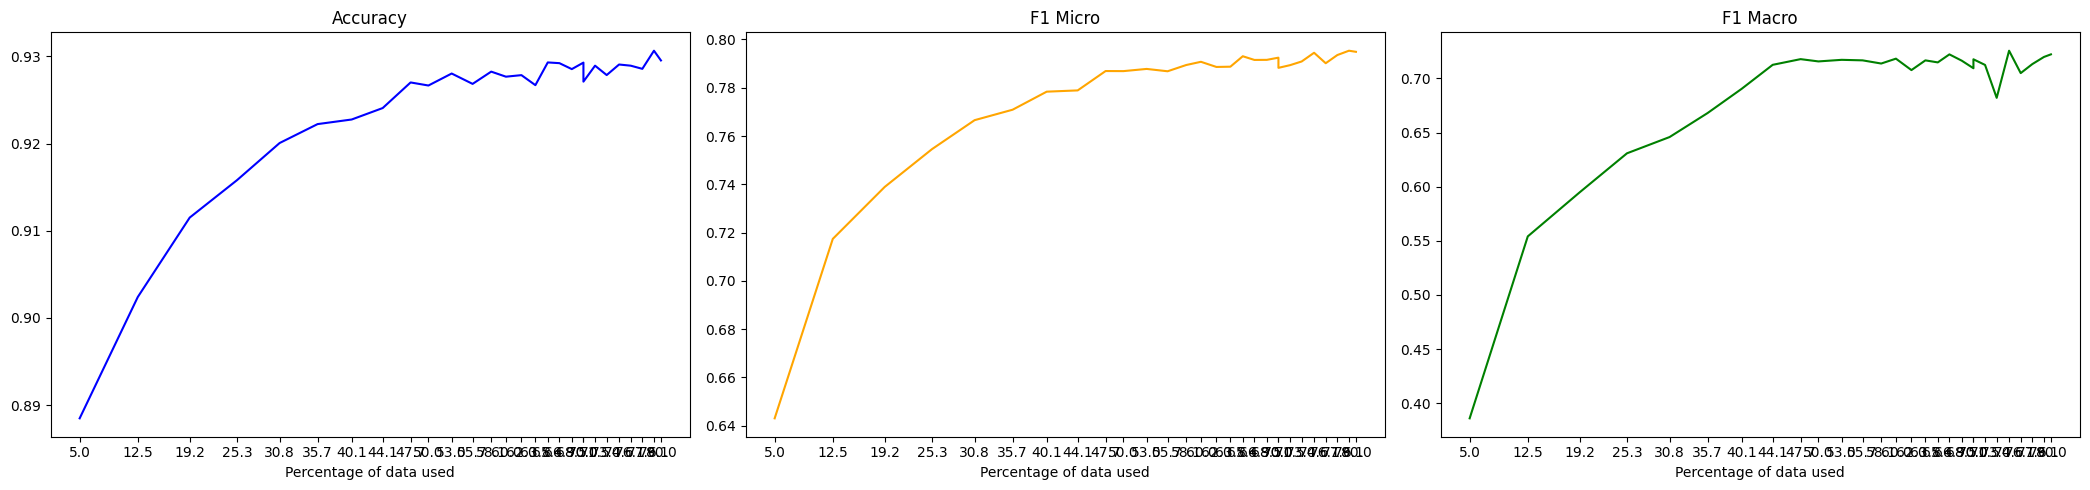

In [ ]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: [3, 44, 85]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5512, Accuracy: 0.8273, F1 Micro: 0.0155, F1 Macro: 0.0068
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4227, Accuracy: 0.8318, F1 Micro: 0.0699, F1 Macro: 0.0271
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3799, Accuracy: 0.8366, F1 Micro: 0.1263, F1 Macro: 0.0477
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3674, Accuracy: 0.8553, F1 Micro: 0.3468, F1 Macro: 0.1119
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3434, Accuracy: 0.8696, F1 Micro: 0.4666, F1 Macro: 0.2028
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2969, Accuracy: 0.8799, F1 Micro: 0.5801, F1 Macro: 0.2942
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2628, Accuracy: 0.8847, F1 Micro: 0.5994, F1 Macro: 0.3207
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.246, Accuracy: 0.8869, F1 Micro: 0.6208, F1 Macro: 0.3672
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5374, Accuracy: 0.8305, F1 Micro: 0.1019, F1 Macro: 0.0326
Epoch 2/10, Train Loss: 0.4175, Accuracy: 0.8339, F1 Micro: 0.1013, F1 Macro: 0.0392
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3741, Accuracy: 0.841, F1 Micro: 0.1781, F1 Macro: 0.066
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3619, Accuracy: 0.8561, F1 Micro: 0.3601, F1 Macro: 0.114
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3371, Accuracy: 0.8691, F1 Micro: 0.462, F1 Macro: 0.1986
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2938, Accuracy: 0.8806, F1 Micro: 0.5917, F1 Macro: 0.3113
Epoch 7/10, Train Loss: 0.2568, Accuracy: 0.8836, F1 Micro: 0.5876, F1 Macro: 0.3214
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.242, Accuracy: 0.8886, F1 Micro: 0.6376, F1 Macro: 0.3959
Epoch 9/10, Train Loss: 0.2149, Accuracy: 0.8873, F1 Micro: 0.6054, F1 Macro: 0.3649
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5412, Accuracy: 0.8273, F1 Micro: 0.0114, F1 Macro: 0.0051
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4358, Accuracy: 0.8297, F1 Micro: 0.0419, F1 Macro: 0.0174
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3866, Accuracy: 0.8344, F1 Micro: 0.1004, F1 Macro: 0.0387
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3736, Accuracy: 0.8464, F1 Micro: 0.2413, F1 Macro: 0.0848
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3538, Accuracy: 0.8609, F1 Micro: 0.3858, F1 Macro: 0.1487
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3114, Accuracy: 0.8772, F1 Micro: 0.5475, F1 Macro: 0.2626
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2704, Accuracy: 0.8818, F1 Micro: 0.5891, F1 Macro: 0.3144
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2517, Accuracy: 0.8853, F1 Micro: 0.6134, F1 Macro: 0.3634
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5031, Accuracy: 0.8266, F1 Micro: 0.3861, F1 Macro: 0.105
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4191, Accuracy: 0.8717, F1 Micro: 0.5407, F1 Macro: 0.2309
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3545, Accuracy: 0.8889, F1 Micro: 0.6442, F1 Macro: 0.3454
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3105, Accuracy: 0.8975, F1 Micro: 0.6522, F1 Macro: 0.4282
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2654, Accuracy: 0.9033, F1 Micro: 0.6915, F1 Macro: 0.5213
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2182, Accuracy: 0.9048, F1 Micro: 0.702, F1 Macro: 0.5267
Epoch 7/10, Train Loss: 0.1912, Accuracy: 0.9014, F1 Micro: 0.6669, F1 Macro: 0.5157
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1631, Accuracy: 0.9031, F1 Micro: 0.7049, F1 Macro: 0.5396
Epoch 9/10, Train Loss: 0.1343, Accuracy: 0.9057, F1 Micro: 0.6936, F1 Macro: 0.52
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4906, Accuracy: 0.8301, F1 Micro: 0.4012, F1 Macro: 0.1089
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4144, Accuracy: 0.8686, F1 Micro: 0.5511, F1 Macro: 0.2689
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3516, Accuracy: 0.8917, F1 Micro: 0.6443, F1 Macro: 0.3752
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3085, Accuracy: 0.8998, F1 Micro: 0.6645, F1 Macro: 0.4431
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2636, Accuracy: 0.9057, F1 Micro: 0.6971, F1 Macro: 0.5153
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2205, Accuracy: 0.9055, F1 Micro: 0.7088, F1 Macro: 0.5482
Epoch 7/10, Train Loss: 0.1915, Accuracy: 0.9044, F1 Micro: 0.6722, F1 Macro: 0.5301
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1611, Accuracy: 0.9071, F1 Micro: 0.7153, F1 Macro: 0.5706
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1367, Accuracy: 0.9087, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5025, Accuracy: 0.8262, F1 Micro: 0.357, F1 Macro: 0.0963
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4245, Accuracy: 0.862, F1 Micro: 0.5164, F1 Macro: 0.2123
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3601, Accuracy: 0.8874, F1 Micro: 0.6476, F1 Macro: 0.3503
Epoch 4/10, Train Loss: 0.316, Accuracy: 0.8954, F1 Micro: 0.6333, F1 Macro: 0.4376
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2674, Accuracy: 0.9014, F1 Micro: 0.7033, F1 Macro: 0.5285
Epoch 6/10, Train Loss: 0.2221, Accuracy: 0.9036, F1 Micro: 0.6923, F1 Macro: 0.5295
Epoch 7/10, Train Loss: 0.1952, Accuracy: 0.9027, F1 Micro: 0.677, F1 Macro: 0.5151
Epoch 8/10, Train Loss: 0.162, Accuracy: 0.9033, F1 Micro: 0.7021, F1 Macro: 0.552
Epoch 9/10, Train Loss: 0.1338, Accuracy: 0.9045, F1 Micro: 0.6873, F1 Macro: 0.5388
Epoch 10/10, Train Loss: 0.1135, Accuracy: 0.9048, F1 Micro: 0.7032, F1 Macro: 0.5536
Model 3 - Iteration 164

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4827, Accuracy: 0.8359, F1 Micro: 0.5034, F1 Macro: 0.2186
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3876, Accuracy: 0.8905, F1 Micro: 0.6405, F1 Macro: 0.3659
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.324, Accuracy: 0.901, F1 Micro: 0.6699, F1 Macro: 0.4461
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2668, Accuracy: 0.9093, F1 Micro: 0.7336, F1 Macro: 0.5614
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2177, Accuracy: 0.9116, F1 Micro: 0.7365, F1 Macro: 0.5841
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1869, Accuracy: 0.911, F1 Micro: 0.7399, F1 Macro: 0.5987
Epoch 7/10, Train Loss: 0.1486, Accuracy: 0.9133, F1 Micro: 0.7366, F1 Macro: 0.5861
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.122, Accuracy: 0.9141, F1 Micro: 0.7472, F1 Macro: 0.6169
Epoch 9/10, Train Loss: 0.1068, Accuracy: 0.9137, F1 Micro: 0.7403, F1 Macro: 0.6109
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.472, Accuracy: 0.8403, F1 Micro: 0.5038, F1 Macro: 0.2138
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3811, Accuracy: 0.8916, F1 Micro: 0.6298, F1 Macro: 0.3815
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3202, Accuracy: 0.9041, F1 Micro: 0.6787, F1 Macro: 0.4816
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2653, Accuracy: 0.9089, F1 Micro: 0.7344, F1 Macro: 0.5794
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2164, Accuracy: 0.9131, F1 Micro: 0.7345, F1 Macro: 0.5816
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1853, Accuracy: 0.9132, F1 Micro: 0.7433, F1 Macro: 0.6003
Epoch 7/10, Train Loss: 0.1498, Accuracy: 0.915, F1 Micro: 0.7329, F1 Macro: 0.5926
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1184, Accuracy: 0.9157, F1 Micro: 0.7435, F1 Macro: 0.5968
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1053, Accuracy: 0.9144, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4853, Accuracy: 0.8283, F1 Micro: 0.4944, F1 Macro: 0.2159
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3941, Accuracy: 0.8892, F1 Micro: 0.6337, F1 Macro: 0.3585
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3264, Accuracy: 0.9013, F1 Micro: 0.6756, F1 Macro: 0.4468
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2678, Accuracy: 0.9085, F1 Micro: 0.7282, F1 Macro: 0.5712
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2133, Accuracy: 0.9124, F1 Micro: 0.7324, F1 Macro: 0.5812
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1848, Accuracy: 0.9113, F1 Micro: 0.7329, F1 Macro: 0.5925
Epoch 7/10, Train Loss: 0.1426, Accuracy: 0.9134, F1 Micro: 0.7321, F1 Macro: 0.5939
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1206, Accuracy: 0.913, F1 Micro: 0.7362, F1 Macro: 0.5913
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1056, Accuracy: 0.9125, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4679, Accuracy: 0.8605, F1 Micro: 0.4726, F1 Macro: 0.1714
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3605, Accuracy: 0.8958, F1 Micro: 0.6984, F1 Macro: 0.4848
Epoch 3/10, Train Loss: 0.2981, Accuracy: 0.9085, F1 Micro: 0.692, F1 Macro: 0.5113
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2449, Accuracy: 0.9093, F1 Micro: 0.7255, F1 Macro: 0.5493
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1952, Accuracy: 0.9151, F1 Micro: 0.7406, F1 Macro: 0.5936
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.162, Accuracy: 0.914, F1 Micro: 0.7511, F1 Macro: 0.6068
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1271, Accuracy: 0.9168, F1 Micro: 0.7514, F1 Macro: 0.6194
Epoch 8/10, Train Loss: 0.1046, Accuracy: 0.916, F1 Micro: 0.7484, F1 Macro: 0.6274
Epoch 9/10, Train Loss: 0.0906, Accuracy: 0.9175, F1 Micro: 0.7502, F1 Macro: 0.6489
Epoch 10/10, Train Loss: 0.0765, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4591, Accuracy: 0.8651, F1 Micro: 0.5089, F1 Macro: 0.2128
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3577, Accuracy: 0.8977, F1 Micro: 0.7084, F1 Macro: 0.5331
Epoch 3/10, Train Loss: 0.2941, Accuracy: 0.9093, F1 Micro: 0.7023, F1 Macro: 0.548
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2431, Accuracy: 0.9098, F1 Micro: 0.7416, F1 Macro: 0.5663
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1964, Accuracy: 0.9171, F1 Micro: 0.7455, F1 Macro: 0.6034
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1603, Accuracy: 0.9171, F1 Micro: 0.7538, F1 Macro: 0.6072
Epoch 7/10, Train Loss: 0.1277, Accuracy: 0.914, F1 Micro: 0.7428, F1 Macro: 0.5948
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1056, Accuracy: 0.9179, F1 Micro: 0.759, F1 Macro: 0.6243
Epoch 9/10, Train Loss: 0.0945, Accuracy: 0.9187, F1 Micro: 0.7553, F1 Macro: 0.6273
Epoch 10/10, Train Loss: 0.0763, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4724, Accuracy: 0.8521, F1 Micro: 0.4881, F1 Macro: 0.1882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3663, Accuracy: 0.8963, F1 Micro: 0.6995, F1 Macro: 0.489
Epoch 3/10, Train Loss: 0.2992, Accuracy: 0.9067, F1 Micro: 0.6836, F1 Macro: 0.5145
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2444, Accuracy: 0.9102, F1 Micro: 0.732, F1 Macro: 0.5411
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1953, Accuracy: 0.9148, F1 Micro: 0.7519, F1 Macro: 0.5941
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1592, Accuracy: 0.9177, F1 Micro: 0.7525, F1 Macro: 0.608
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1271, Accuracy: 0.9176, F1 Micro: 0.7557, F1 Macro: 0.6231
Epoch 8/10, Train Loss: 0.1104, Accuracy: 0.9167, F1 Micro: 0.7407, F1 Macro: 0.6173
Epoch 9/10, Train Loss: 0.0951, Accuracy: 0.9197, F1 Micro: 0.7547, F1 Macro: 0.6402
Epoch 10/10, Train Loss: 0.0777, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4574, Accuracy: 0.875, F1 Micro: 0.6166, F1 Macro: 0.3221
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3448, Accuracy: 0.9049, F1 Micro: 0.7204, F1 Macro: 0.5192
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2817, Accuracy: 0.9113, F1 Micro: 0.7397, F1 Macro: 0.5556
Epoch 4/10, Train Loss: 0.2298, Accuracy: 0.9177, F1 Micro: 0.7356, F1 Macro: 0.5905
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1829, Accuracy: 0.917, F1 Micro: 0.7562, F1 Macro: 0.6031
Epoch 6/10, Train Loss: 0.1357, Accuracy: 0.914, F1 Micro: 0.7512, F1 Macro: 0.6147
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1159, Accuracy: 0.9159, F1 Micro: 0.7572, F1 Macro: 0.634
Epoch 8/10, Train Loss: 0.0994, Accuracy: 0.9164, F1 Micro: 0.7547, F1 Macro: 0.6548
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0792, Accuracy: 0.9172, F1 Micro: 0.7573, F1 Macro: 0.6537
Epoch 10/10, Train Loss: 0.0733, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.449, Accuracy: 0.8771, F1 Micro: 0.6123, F1 Macro: 0.3421
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3401, Accuracy: 0.9083, F1 Micro: 0.7264, F1 Macro: 0.5478
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2818, Accuracy: 0.9134, F1 Micro: 0.7377, F1 Macro: 0.561
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2277, Accuracy: 0.9195, F1 Micro: 0.7411, F1 Macro: 0.5989
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1822, Accuracy: 0.9154, F1 Micro: 0.7501, F1 Macro: 0.5966
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1419, Accuracy: 0.9181, F1 Micro: 0.7511, F1 Macro: 0.6209
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.119, Accuracy: 0.9195, F1 Micro: 0.7531, F1 Macro: 0.6362
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1018, Accuracy: 0.9186, F1 Micro: 0.7607, F1 Macro: 0.6429
Epoch 9/10, Train Loss: 0.0814, Accuracy: 0.9182, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4636, Accuracy: 0.8742, F1 Micro: 0.6043, F1 Macro: 0.3076
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3504, Accuracy: 0.9042, F1 Micro: 0.7162, F1 Macro: 0.5119
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.288, Accuracy: 0.9113, F1 Micro: 0.746, F1 Macro: 0.5798
Epoch 4/10, Train Loss: 0.2328, Accuracy: 0.9174, F1 Micro: 0.7334, F1 Macro: 0.5867
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.183, Accuracy: 0.9157, F1 Micro: 0.7601, F1 Macro: 0.6147
Epoch 6/10, Train Loss: 0.1453, Accuracy: 0.9186, F1 Micro: 0.7558, F1 Macro: 0.6236
Epoch 7/10, Train Loss: 0.1191, Accuracy: 0.9173, F1 Micro: 0.7558, F1 Macro: 0.6365
Epoch 8/10, Train Loss: 0.1026, Accuracy: 0.919, F1 Micro: 0.7552, F1 Macro: 0.6454
Epoch 9/10, Train Loss: 0.0822, Accuracy: 0.9167, F1 Micro: 0.759, F1 Macro: 0.6448
Epoch 10/10, Train Loss: 0.0778, Accuracy: 0.9187, F1 Micro: 0.7594, F1 Macro: 0.671
Model 3 - Iteration 405

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4435, Accuracy: 0.8812, F1 Micro: 0.5531, F1 Macro: 0.2762
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3384, Accuracy: 0.9027, F1 Micro: 0.7289, F1 Macro: 0.552
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.274, Accuracy: 0.9169, F1 Micro: 0.7521, F1 Macro: 0.6068
Epoch 4/10, Train Loss: 0.2219, Accuracy: 0.9204, F1 Micro: 0.7485, F1 Macro: 0.6055
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1778, Accuracy: 0.9149, F1 Micro: 0.7618, F1 Macro: 0.6517
Epoch 6/10, Train Loss: 0.1426, Accuracy: 0.9168, F1 Micro: 0.7598, F1 Macro: 0.6309
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1189, Accuracy: 0.921, F1 Micro: 0.766, F1 Macro: 0.6651
Epoch 8/10, Train Loss: 0.0904, Accuracy: 0.9164, F1 Micro: 0.7585, F1 Macro: 0.6661
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0787, Accuracy: 0.9226, F1 Micro: 0.7734, F1 Macro: 0.6983
Epoch 10/10, Train Loss: 0.0656, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4374, Accuracy: 0.8838, F1 Micro: 0.5739, F1 Macro: 0.299
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3351, Accuracy: 0.8994, F1 Micro: 0.724, F1 Macro: 0.5512
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.273, Accuracy: 0.9186, F1 Micro: 0.7561, F1 Macro: 0.6083
Epoch 4/10, Train Loss: 0.2238, Accuracy: 0.9218, F1 Micro: 0.7537, F1 Macro: 0.6103
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1804, Accuracy: 0.9136, F1 Micro: 0.7615, F1 Macro: 0.631
Epoch 6/10, Train Loss: 0.1482, Accuracy: 0.9146, F1 Micro: 0.761, F1 Macro: 0.6304
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1158, Accuracy: 0.9177, F1 Micro: 0.7625, F1 Macro: 0.6494
Epoch 8/10, Train Loss: 0.0901, Accuracy: 0.918, F1 Micro: 0.7568, F1 Macro: 0.661
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0798, Accuracy: 0.9189, F1 Micro: 0.7639, F1 Macro: 0.6669
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4502, Accuracy: 0.8776, F1 Micro: 0.5415, F1 Macro: 0.2492
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3433, Accuracy: 0.9056, F1 Micro: 0.7338, F1 Macro: 0.5605
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2739, Accuracy: 0.9177, F1 Micro: 0.7525, F1 Macro: 0.607
Epoch 4/10, Train Loss: 0.2202, Accuracy: 0.9208, F1 Micro: 0.7504, F1 Macro: 0.6087
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1787, Accuracy: 0.9164, F1 Micro: 0.7658, F1 Macro: 0.6391
Epoch 6/10, Train Loss: 0.143, Accuracy: 0.9203, F1 Micro: 0.7625, F1 Macro: 0.6334
Epoch 7/10, Train Loss: 0.1155, Accuracy: 0.9188, F1 Micro: 0.7561, F1 Macro: 0.638
Epoch 8/10, Train Loss: 0.0896, Accuracy: 0.9136, F1 Micro: 0.7575, F1 Macro: 0.6597
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.079, Accuracy: 0.9193, F1 Micro: 0.7685, F1 Macro: 0.6616
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0685, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4348, Accuracy: 0.8846, F1 Micro: 0.6425, F1 Macro: 0.3593
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3238, Accuracy: 0.912, F1 Micro: 0.7248, F1 Macro: 0.5451
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2627, Accuracy: 0.9204, F1 Micro: 0.7593, F1 Macro: 0.6101
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2076, Accuracy: 0.9209, F1 Micro: 0.7646, F1 Macro: 0.6243
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1679, Accuracy: 0.9221, F1 Micro: 0.7691, F1 Macro: 0.6493
Epoch 6/10, Train Loss: 0.1307, Accuracy: 0.9233, F1 Micro: 0.7684, F1 Macro: 0.6534
Epoch 7/10, Train Loss: 0.11, Accuracy: 0.9232, F1 Micro: 0.7667, F1 Macro: 0.6686
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0899, Accuracy: 0.9222, F1 Micro: 0.771, F1 Macro: 0.7001
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.073, Accuracy: 0.9228, F1 Micro: 0.7716, F1 Macro: 0.6898
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4286, Accuracy: 0.8888, F1 Micro: 0.6647, F1 Macro: 0.4333
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3204, Accuracy: 0.9138, F1 Micro: 0.7355, F1 Macro: 0.5806
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.263, Accuracy: 0.9204, F1 Micro: 0.7618, F1 Macro: 0.6153
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2073, Accuracy: 0.9208, F1 Micro: 0.764, F1 Macro: 0.6218
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1692, Accuracy: 0.9223, F1 Micro: 0.7716, F1 Macro: 0.6342
Epoch 6/10, Train Loss: 0.1316, Accuracy: 0.919, F1 Micro: 0.764, F1 Macro: 0.6428
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1096, Accuracy: 0.925, F1 Micro: 0.7756, F1 Macro: 0.6557
Epoch 8/10, Train Loss: 0.0935, Accuracy: 0.9252, F1 Micro: 0.7715, F1 Macro: 0.6747
Epoch 9/10, Train Loss: 0.0723, Accuracy: 0.9231, F1 Micro: 0.7736, F1 Macro: 0.685
Epoch 10/10, Train Loss: 0.0657, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.439, Accuracy: 0.8856, F1 Micro: 0.6461, F1 Macro: 0.3693
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3265, Accuracy: 0.9118, F1 Micro: 0.7257, F1 Macro: 0.557
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.264, Accuracy: 0.9197, F1 Micro: 0.7561, F1 Macro: 0.606
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2094, Accuracy: 0.9204, F1 Micro: 0.7631, F1 Macro: 0.6211
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1705, Accuracy: 0.9168, F1 Micro: 0.7668, F1 Macro: 0.643
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1318, Accuracy: 0.9234, F1 Micro: 0.7708, F1 Macro: 0.6493
Epoch 7/10, Train Loss: 0.1099, Accuracy: 0.9211, F1 Micro: 0.7612, F1 Macro: 0.6488
Epoch 8/10, Train Loss: 0.0961, Accuracy: 0.9188, F1 Micro: 0.7598, F1 Macro: 0.671
Epoch 9/10, Train Loss: 0.076, Accuracy: 0.9222, F1 Micro: 0.7694, F1 Macro: 0.6747
Epoch 10/10, Train Loss: 0.0676, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4261, Accuracy: 0.8925, F1 Micro: 0.6417, F1 Macro: 0.3925
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3116, Accuracy: 0.9136, F1 Micro: 0.7265, F1 Macro: 0.5305
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2477, Accuracy: 0.9205, F1 Micro: 0.7555, F1 Macro: 0.61
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2082, Accuracy: 0.9158, F1 Micro: 0.7673, F1 Macro: 0.6332
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1637, Accuracy: 0.9249, F1 Micro: 0.7776, F1 Macro: 0.667
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1342, Accuracy: 0.9261, F1 Micro: 0.7795, F1 Macro: 0.686
Epoch 7/10, Train Loss: 0.1077, Accuracy: 0.9232, F1 Micro: 0.7728, F1 Macro: 0.695
Epoch 8/10, Train Loss: 0.0864, Accuracy: 0.9219, F1 Micro: 0.7695, F1 Macro: 0.685
Epoch 9/10, Train Loss: 0.074, Accuracy: 0.9259, F1 Micro: 0.7794, F1 Macro: 0.7082
Epoch 10/10, Train Loss: 0.0618, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4192, Accuracy: 0.8943, F1 Micro: 0.6474, F1 Macro: 0.4372
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3111, Accuracy: 0.9143, F1 Micro: 0.7276, F1 Macro: 0.5374
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2484, Accuracy: 0.9207, F1 Micro: 0.7593, F1 Macro: 0.5973
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2113, Accuracy: 0.9155, F1 Micro: 0.7636, F1 Macro: 0.6196
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1657, Accuracy: 0.9244, F1 Micro: 0.7747, F1 Macro: 0.6572
Epoch 6/10, Train Loss: 0.1322, Accuracy: 0.9258, F1 Micro: 0.7671, F1 Macro: 0.664
Epoch 7/10, Train Loss: 0.1076, Accuracy: 0.9243, F1 Micro: 0.7603, F1 Macro: 0.6528
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0892, Accuracy: 0.9219, F1 Micro: 0.7759, F1 Macro: 0.6618
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0748, Accuracy: 0.9246, F1 Micro: 0.78, F1 Macro: 0.6959
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4301, Accuracy: 0.8909, F1 Micro: 0.6476, F1 Macro: 0.4172
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3157, Accuracy: 0.9109, F1 Micro: 0.7171, F1 Macro: 0.5202
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2488, Accuracy: 0.9187, F1 Micro: 0.7597, F1 Macro: 0.6051
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2111, Accuracy: 0.9168, F1 Micro: 0.7674, F1 Macro: 0.6249
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1649, Accuracy: 0.9246, F1 Micro: 0.7783, F1 Macro: 0.6472
Epoch 6/10, Train Loss: 0.1324, Accuracy: 0.9254, F1 Micro: 0.7757, F1 Macro: 0.6682
Epoch 7/10, Train Loss: 0.1066, Accuracy: 0.9245, F1 Micro: 0.7733, F1 Macro: 0.6756
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0879, Accuracy: 0.9247, F1 Micro: 0.782, F1 Macro: 0.6805
Epoch 9/10, Train Loss: 0.0743, Accuracy: 0.9238, F1 Micro: 0.7776, F1 Macro: 0.6849
Epoch 10/10, Train Loss: 0.0653, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4202, Accuracy: 0.8975, F1 Micro: 0.6687, F1 Macro: 0.4018
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3065, Accuracy: 0.9137, F1 Micro: 0.7515, F1 Macro: 0.5842
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2466, Accuracy: 0.9206, F1 Micro: 0.7551, F1 Macro: 0.6017
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2006, Accuracy: 0.9244, F1 Micro: 0.7682, F1 Macro: 0.635
Epoch 5/10, Train Loss: 0.1614, Accuracy: 0.9242, F1 Micro: 0.7678, F1 Macro: 0.6457
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1255, Accuracy: 0.924, F1 Micro: 0.7701, F1 Macro: 0.6764
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0998, Accuracy: 0.9258, F1 Micro: 0.7745, F1 Macro: 0.697
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0837, Accuracy: 0.921, F1 Micro: 0.776, F1 Macro: 0.706
Epoch 9/10, Train Loss: 0.0721, Accuracy: 0.9248, F1 Micro: 0.7756, F1 Macro: 0.7019
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4137, Accuracy: 0.8982, F1 Micro: 0.678, F1 Macro: 0.4371
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3045, Accuracy: 0.9141, F1 Micro: 0.7528, F1 Macro: 0.5947
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2465, Accuracy: 0.9217, F1 Micro: 0.764, F1 Macro: 0.6054
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1987, Accuracy: 0.9242, F1 Micro: 0.7752, F1 Macro: 0.6312
Epoch 5/10, Train Loss: 0.1607, Accuracy: 0.9213, F1 Micro: 0.7545, F1 Macro: 0.6263
Epoch 6/10, Train Loss: 0.1298, Accuracy: 0.9243, F1 Micro: 0.7657, F1 Macro: 0.6712
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1014, Accuracy: 0.9235, F1 Micro: 0.7802, F1 Macro: 0.6816
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0853, Accuracy: 0.9229, F1 Micro: 0.7803, F1 Macro: 0.7071
Epoch 9/10, Train Loss: 0.0727, Accuracy: 0.9238, F1 Micro: 0.7699, F1 Macro: 0.6972
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4238, Accuracy: 0.8924, F1 Micro: 0.6674, F1 Macro: 0.3991
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3081, Accuracy: 0.9122, F1 Micro: 0.7485, F1 Macro: 0.5891
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2457, Accuracy: 0.9204, F1 Micro: 0.7611, F1 Macro: 0.6019
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1963, Accuracy: 0.9246, F1 Micro: 0.7778, F1 Macro: 0.6319
Epoch 5/10, Train Loss: 0.1559, Accuracy: 0.9244, F1 Micro: 0.7666, F1 Macro: 0.6365
Epoch 6/10, Train Loss: 0.1263, Accuracy: 0.9216, F1 Micro: 0.7669, F1 Macro: 0.6558
Epoch 7/10, Train Loss: 0.1007, Accuracy: 0.9222, F1 Micro: 0.7774, F1 Macro: 0.6758
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0881, Accuracy: 0.9241, F1 Micro: 0.7808, F1 Macro: 0.695
Epoch 9/10, Train Loss: 0.0726, Accuracy: 0.9252, F1 Micro: 0.7795, F1 Macro: 0.6987
Epoch 10/10, Train Loss: 0.0662, Accuracy: 0.9235, F1 Micro: 0.7802, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4137, Accuracy: 0.8948, F1 Micro: 0.6276, F1 Macro: 0.3463
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2992, Accuracy: 0.9158, F1 Micro: 0.7307, F1 Macro: 0.5542
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2356, Accuracy: 0.922, F1 Micro: 0.751, F1 Macro: 0.6039
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1941, Accuracy: 0.9258, F1 Micro: 0.7796, F1 Macro: 0.633
Epoch 5/10, Train Loss: 0.1539, Accuracy: 0.9238, F1 Micro: 0.7772, F1 Macro: 0.6612
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1236, Accuracy: 0.926, F1 Micro: 0.7802, F1 Macro: 0.6884
Epoch 7/10, Train Loss: 0.099, Accuracy: 0.9258, F1 Micro: 0.7722, F1 Macro: 0.6801
Epoch 8/10, Train Loss: 0.0837, Accuracy: 0.9227, F1 Micro: 0.7771, F1 Macro: 0.7134
Epoch 9/10, Train Loss: 0.0709, Accuracy: 0.9239, F1 Micro: 0.7773, F1 Macro: 0.7204
Epoch 10/10, Train Loss: 0.0575, Accuracy: 0.9214, F1 Micro: 0.7724, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4071, Accuracy: 0.897, F1 Micro: 0.6413, F1 Macro: 0.3842
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2977, Accuracy: 0.9163, F1 Micro: 0.7356, F1 Macro: 0.5646
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2347, Accuracy: 0.9228, F1 Micro: 0.7562, F1 Macro: 0.6027
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1941, Accuracy: 0.9256, F1 Micro: 0.7745, F1 Macro: 0.6363
Epoch 5/10, Train Loss: 0.1555, Accuracy: 0.9228, F1 Micro: 0.7709, F1 Macro: 0.6467
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1273, Accuracy: 0.9243, F1 Micro: 0.7748, F1 Macro: 0.6638
Epoch 7/10, Train Loss: 0.0984, Accuracy: 0.9248, F1 Micro: 0.7732, F1 Macro: 0.668
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0825, Accuracy: 0.9236, F1 Micro: 0.7764, F1 Macro: 0.6979
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0689, Accuracy: 0.9266, F1 Micro: 0.7821, F1 Macro: 0.7119
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4174, Accuracy: 0.8952, F1 Micro: 0.6358, F1 Macro: 0.3594
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2994, Accuracy: 0.9163, F1 Micro: 0.7372, F1 Macro: 0.5762
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2366, Accuracy: 0.9225, F1 Micro: 0.7595, F1 Macro: 0.605
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1973, Accuracy: 0.9237, F1 Micro: 0.7748, F1 Macro: 0.6365
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1589, Accuracy: 0.9238, F1 Micro: 0.7776, F1 Macro: 0.6587
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1242, Accuracy: 0.9252, F1 Micro: 0.7788, F1 Macro: 0.6538
Epoch 7/10, Train Loss: 0.1023, Accuracy: 0.9244, F1 Micro: 0.7639, F1 Macro: 0.658
Epoch 8/10, Train Loss: 0.0897, Accuracy: 0.9249, F1 Micro: 0.7779, F1 Macro: 0.6899
Epoch 9/10, Train Loss: 0.0699, Accuracy: 0.9243, F1 Micro: 0.7721, F1 Macro: 0.6998
Epoch 10/10, Train Loss: 0.0596, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4064, Accuracy: 0.8988, F1 Micro: 0.6598, F1 Macro: 0.4112
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2962, Accuracy: 0.9142, F1 Micro: 0.7467, F1 Macro: 0.5768
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2394, Accuracy: 0.9222, F1 Micro: 0.7661, F1 Macro: 0.6107
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.189, Accuracy: 0.9204, F1 Micro: 0.774, F1 Macro: 0.6673
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1494, Accuracy: 0.9239, F1 Micro: 0.7827, F1 Macro: 0.7004
Epoch 6/10, Train Loss: 0.1205, Accuracy: 0.9266, F1 Micro: 0.7825, F1 Macro: 0.7051
Epoch 7/10, Train Loss: 0.0982, Accuracy: 0.9254, F1 Micro: 0.7769, F1 Macro: 0.7064
Epoch 8/10, Train Loss: 0.0791, Accuracy: 0.9226, F1 Micro: 0.7785, F1 Macro: 0.7103
Epoch 9/10, Train Loss: 0.0654, Accuracy: 0.9245, F1 Micro: 0.775, F1 Macro: 0.7112
Epoch 10/10, Train Loss: 0.0613, Accuracy: 0.9192, F1 Micro: 0.7721, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3989, Accuracy: 0.898, F1 Micro: 0.6607, F1 Macro: 0.4088
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2946, Accuracy: 0.9164, F1 Micro: 0.755, F1 Macro: 0.5959
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2381, Accuracy: 0.9233, F1 Micro: 0.7701, F1 Macro: 0.6117
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1907, Accuracy: 0.9194, F1 Micro: 0.775, F1 Macro: 0.6439
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1487, Accuracy: 0.9253, F1 Micro: 0.7839, F1 Macro: 0.6785
Epoch 6/10, Train Loss: 0.1223, Accuracy: 0.9255, F1 Micro: 0.7833, F1 Macro: 0.6863
Epoch 7/10, Train Loss: 0.0975, Accuracy: 0.9252, F1 Micro: 0.7734, F1 Macro: 0.6931
Epoch 8/10, Train Loss: 0.0834, Accuracy: 0.9252, F1 Micro: 0.7782, F1 Macro: 0.7117
Epoch 9/10, Train Loss: 0.0675, Accuracy: 0.9228, F1 Micro: 0.7807, F1 Macro: 0.7214
Epoch 10/10, Train Loss: 0.0571, Accuracy: 0.9246, F1 Micro: 0.783, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4122, Accuracy: 0.8976, F1 Micro: 0.6575, F1 Macro: 0.4157
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2973, Accuracy: 0.9092, F1 Micro: 0.7494, F1 Macro: 0.5918
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2403, Accuracy: 0.9218, F1 Micro: 0.7695, F1 Macro: 0.6091
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1885, Accuracy: 0.919, F1 Micro: 0.7698, F1 Macro: 0.6422
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1513, Accuracy: 0.925, F1 Micro: 0.7822, F1 Macro: 0.6696
Epoch 6/10, Train Loss: 0.1226, Accuracy: 0.9254, F1 Micro: 0.7772, F1 Macro: 0.6807
Epoch 7/10, Train Loss: 0.0992, Accuracy: 0.9248, F1 Micro: 0.7709, F1 Macro: 0.6869
Epoch 8/10, Train Loss: 0.0804, Accuracy: 0.9243, F1 Micro: 0.7762, F1 Macro: 0.6986
Epoch 9/10, Train Loss: 0.0693, Accuracy: 0.9231, F1 Micro: 0.7764, F1 Macro: 0.7014
Epoch 10/10, Train Loss: 0.0582, Accuracy: 0.9256, F1 Micro: 0.7785, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4038, Accuracy: 0.9006, F1 Micro: 0.6888, F1 Macro: 0.4456
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.289, Accuracy: 0.9181, F1 Micro: 0.7528, F1 Macro: 0.5869
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2306, Accuracy: 0.9229, F1 Micro: 0.7752, F1 Macro: 0.6409
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1837, Accuracy: 0.9225, F1 Micro: 0.7777, F1 Macro: 0.6485
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1485, Accuracy: 0.9263, F1 Micro: 0.7837, F1 Macro: 0.6927
Epoch 6/10, Train Loss: 0.1206, Accuracy: 0.9287, F1 Micro: 0.7835, F1 Macro: 0.6872
Epoch 7/10, Train Loss: 0.0977, Accuracy: 0.9272, F1 Micro: 0.7824, F1 Macro: 0.6951
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.079, Accuracy: 0.9265, F1 Micro: 0.784, F1 Macro: 0.7157
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0647, Accuracy: 0.9248, F1 Micro: 0.7874, F1 Macro: 0.7211
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3985, Accuracy: 0.9004, F1 Micro: 0.6912, F1 Macro: 0.478
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2879, Accuracy: 0.918, F1 Micro: 0.7444, F1 Macro: 0.5912
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.233, Accuracy: 0.9234, F1 Micro: 0.7787, F1 Macro: 0.6311
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1849, Accuracy: 0.9245, F1 Micro: 0.7822, F1 Macro: 0.6607
Epoch 5/10, Train Loss: 0.1496, Accuracy: 0.9263, F1 Micro: 0.7821, F1 Macro: 0.681
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1198, Accuracy: 0.9292, F1 Micro: 0.7877, F1 Macro: 0.7014
Epoch 7/10, Train Loss: 0.0944, Accuracy: 0.9269, F1 Micro: 0.7798, F1 Macro: 0.6967
Epoch 8/10, Train Loss: 0.0819, Accuracy: 0.9249, F1 Micro: 0.7826, F1 Macro: 0.7188
Epoch 9/10, Train Loss: 0.0636, Accuracy: 0.928, F1 Micro: 0.7822, F1 Macro: 0.7198
Epoch 10/10, Train Loss: 0.0593, Accuracy: 0.9252, F1 Micro: 0.7805, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4069, Accuracy: 0.8986, F1 Micro: 0.6761, F1 Macro: 0.443
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2907, Accuracy: 0.9185, F1 Micro: 0.7488, F1 Macro: 0.586
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.231, Accuracy: 0.924, F1 Micro: 0.7776, F1 Macro: 0.6266
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1826, Accuracy: 0.9237, F1 Micro: 0.7805, F1 Macro: 0.6554
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1488, Accuracy: 0.9273, F1 Micro: 0.7809, F1 Macro: 0.6708
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1178, Accuracy: 0.9274, F1 Micro: 0.7887, F1 Macro: 0.6793
Epoch 7/10, Train Loss: 0.0964, Accuracy: 0.9256, F1 Micro: 0.7723, F1 Macro: 0.6803
Epoch 8/10, Train Loss: 0.0795, Accuracy: 0.9249, F1 Micro: 0.7826, F1 Macro: 0.7095
Epoch 9/10, Train Loss: 0.0674, Accuracy: 0.9258, F1 Micro: 0.7822, F1 Macro: 0.7128
Epoch 10/10, Train Loss: 0.0613, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3957, Accuracy: 0.9019, F1 Micro: 0.6783, F1 Macro: 0.4645
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2841, Accuracy: 0.9178, F1 Micro: 0.7458, F1 Macro: 0.576
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2215, Accuracy: 0.9278, F1 Micro: 0.7773, F1 Macro: 0.6286
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1778, Accuracy: 0.9276, F1 Micro: 0.7809, F1 Macro: 0.6629
Epoch 5/10, Train Loss: 0.1434, Accuracy: 0.9272, F1 Micro: 0.7803, F1 Macro: 0.6918
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1143, Accuracy: 0.9271, F1 Micro: 0.7828, F1 Macro: 0.7044
Epoch 7/10, Train Loss: 0.0915, Accuracy: 0.928, F1 Micro: 0.7777, F1 Macro: 0.698
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0769, Accuracy: 0.927, F1 Micro: 0.7875, F1 Macro: 0.7255
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0643, Accuracy: 0.9289, F1 Micro: 0.7888, F1 Macro: 0.7248
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3888, Accuracy: 0.904, F1 Micro: 0.6998, F1 Macro: 0.5067
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2829, Accuracy: 0.9194, F1 Micro: 0.7422, F1 Macro: 0.5761
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2217, Accuracy: 0.9257, F1 Micro: 0.77, F1 Macro: 0.6106
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1788, Accuracy: 0.9285, F1 Micro: 0.7831, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1458, Accuracy: 0.9283, F1 Micro: 0.7836, F1 Macro: 0.6868
Epoch 6/10, Train Loss: 0.1146, Accuracy: 0.9282, F1 Micro: 0.7783, F1 Macro: 0.6917
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0921, Accuracy: 0.9279, F1 Micro: 0.784, F1 Macro: 0.7084
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0769, Accuracy: 0.9295, F1 Micro: 0.7906, F1 Macro: 0.7205
Epoch 9/10, Train Loss: 0.0648, Accuracy: 0.925, F1 Micro: 0.7883, F1 Macro: 0.7256
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3995, Accuracy: 0.9014, F1 Micro: 0.6967, F1 Macro: 0.4923
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2836, Accuracy: 0.9186, F1 Micro: 0.7421, F1 Macro: 0.5831
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2208, Accuracy: 0.9257, F1 Micro: 0.7678, F1 Macro: 0.6019
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1801, Accuracy: 0.9271, F1 Micro: 0.7824, F1 Macro: 0.6521
Epoch 5/10, Train Loss: 0.1457, Accuracy: 0.9268, F1 Micro: 0.7812, F1 Macro: 0.6647
Epoch 6/10, Train Loss: 0.115, Accuracy: 0.9244, F1 Micro: 0.7735, F1 Macro: 0.6688
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0931, Accuracy: 0.9273, F1 Micro: 0.7842, F1 Macro: 0.6819
Epoch 8/10, Train Loss: 0.0786, Accuracy: 0.9279, F1 Micro: 0.7841, F1 Macro: 0.7106
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0634, Accuracy: 0.9272, F1 Micro: 0.787, F1 Macro: 0.7165
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3864, Accuracy: 0.9045, F1 Micro: 0.6927, F1 Macro: 0.4853
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2804, Accuracy: 0.9157, F1 Micro: 0.7586, F1 Macro: 0.5827
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2205, Accuracy: 0.9253, F1 Micro: 0.7702, F1 Macro: 0.6366
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1774, Accuracy: 0.9272, F1 Micro: 0.7882, F1 Macro: 0.6724
Epoch 5/10, Train Loss: 0.138, Accuracy: 0.9276, F1 Micro: 0.777, F1 Macro: 0.6916
Epoch 6/10, Train Loss: 0.1083, Accuracy: 0.9284, F1 Micro: 0.788, F1 Macro: 0.7125
Epoch 7/10, Train Loss: 0.09, Accuracy: 0.9243, F1 Micro: 0.7854, F1 Macro: 0.7172
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0745, Accuracy: 0.929, F1 Micro: 0.7923, F1 Macro: 0.7264
Epoch 9/10, Train Loss: 0.0618, Accuracy: 0.9263, F1 Micro: 0.7844, F1 Macro: 0.7244
Epoch 10/10, Train Loss: 0.054, Accuracy: 0.927, F1 Micro: 0.7871, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3808, Accuracy: 0.903, F1 Micro: 0.6837, F1 Macro: 0.4552
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2791, Accuracy: 0.9176, F1 Micro: 0.7593, F1 Macro: 0.5904
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2198, Accuracy: 0.9258, F1 Micro: 0.7691, F1 Macro: 0.6258
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1751, Accuracy: 0.9279, F1 Micro: 0.7811, F1 Macro: 0.6392
Epoch 5/10, Train Loss: 0.1391, Accuracy: 0.929, F1 Micro: 0.78, F1 Macro: 0.6976
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1096, Accuracy: 0.9275, F1 Micro: 0.7868, F1 Macro: 0.7108
Epoch 7/10, Train Loss: 0.0876, Accuracy: 0.9261, F1 Micro: 0.7862, F1 Macro: 0.7101
Epoch 8/10, Train Loss: 0.075, Accuracy: 0.9272, F1 Micro: 0.7824, F1 Macro: 0.7121
Epoch 9/10, Train Loss: 0.0637, Accuracy: 0.9276, F1 Micro: 0.7831, F1 Macro: 0.7173
Epoch 10/10, Train Loss: 0.0527, Accuracy: 0.9256, F1 Micro: 0.7813, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3884, Accuracy: 0.9034, F1 Micro: 0.695, F1 Macro: 0.4972
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2817, Accuracy: 0.9166, F1 Micro: 0.7616, F1 Macro: 0.5872
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2206, Accuracy: 0.9236, F1 Micro: 0.7649, F1 Macro: 0.6194
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1788, Accuracy: 0.9263, F1 Micro: 0.7832, F1 Macro: 0.648
Epoch 5/10, Train Loss: 0.1397, Accuracy: 0.9263, F1 Micro: 0.7769, F1 Macro: 0.6653
Epoch 6/10, Train Loss: 0.1119, Accuracy: 0.9246, F1 Micro: 0.778, F1 Macro: 0.6901
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0902, Accuracy: 0.9277, F1 Micro: 0.7842, F1 Macro: 0.6912
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0754, Accuracy: 0.9285, F1 Micro: 0.7857, F1 Macro: 0.7089
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0639, Accuracy: 0.9295, F1 Micro: 0.7916, F1 Macro: 0.7179
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3814, Accuracy: 0.9039, F1 Micro: 0.7013, F1 Macro: 0.4704
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2678, Accuracy: 0.9193, F1 Micro: 0.7623, F1 Macro: 0.6081
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2077, Accuracy: 0.9246, F1 Micro: 0.7754, F1 Macro: 0.6395
Epoch 4/10, Train Loss: 0.1676, Accuracy: 0.9273, F1 Micro: 0.7723, F1 Macro: 0.6583
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1347, Accuracy: 0.927, F1 Micro: 0.7851, F1 Macro: 0.6917
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.11, Accuracy: 0.9271, F1 Micro: 0.7881, F1 Macro: 0.7154
Epoch 7/10, Train Loss: 0.0882, Accuracy: 0.9249, F1 Micro: 0.785, F1 Macro: 0.7146
Epoch 8/10, Train Loss: 0.0741, Accuracy: 0.9273, F1 Micro: 0.7833, F1 Macro: 0.7208
Epoch 9/10, Train Loss: 0.0607, Accuracy: 0.9267, F1 Micro: 0.7733, F1 Macro: 0.7161
Epoch 10/10, Train Loss: 0.0557, Accuracy: 0.9271, F1 Micro: 0.7832, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3751, Accuracy: 0.9032, F1 Micro: 0.6962, F1 Macro: 0.4745
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2651, Accuracy: 0.9198, F1 Micro: 0.7643, F1 Macro: 0.6051
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2087, Accuracy: 0.9261, F1 Micro: 0.7772, F1 Macro: 0.6314
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.167, Accuracy: 0.9291, F1 Micro: 0.7826, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1356, Accuracy: 0.9278, F1 Micro: 0.7878, F1 Macro: 0.6817
Epoch 6/10, Train Loss: 0.1085, Accuracy: 0.9179, F1 Micro: 0.7756, F1 Macro: 0.7059
Epoch 7/10, Train Loss: 0.0919, Accuracy: 0.9283, F1 Micro: 0.7809, F1 Macro: 0.7028
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0748, Accuracy: 0.929, F1 Micro: 0.7915, F1 Macro: 0.7221
Epoch 9/10, Train Loss: 0.061, Accuracy: 0.9271, F1 Micro: 0.7826, F1 Macro: 0.7241
Epoch 10/10, Train Loss: 0.0541, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3854, Accuracy: 0.9019, F1 Micro: 0.7006, F1 Macro: 0.4819
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2679, Accuracy: 0.9204, F1 Micro: 0.7615, F1 Macro: 0.6042
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2114, Accuracy: 0.9245, F1 Micro: 0.7739, F1 Macro: 0.6221
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1659, Accuracy: 0.9287, F1 Micro: 0.7838, F1 Macro: 0.6574
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1342, Accuracy: 0.9278, F1 Micro: 0.7864, F1 Macro: 0.6777
Epoch 6/10, Train Loss: 0.1115, Accuracy: 0.9249, F1 Micro: 0.7815, F1 Macro: 0.6894
Epoch 7/10, Train Loss: 0.0909, Accuracy: 0.9268, F1 Micro: 0.7802, F1 Macro: 0.6888
Epoch 8/10, Train Loss: 0.0739, Accuracy: 0.9271, F1 Micro: 0.7826, F1 Macro: 0.7101
Epoch 9/10, Train Loss: 0.0612, Accuracy: 0.9264, F1 Micro: 0.7818, F1 Macro: 0.7181
Epoch 10/10, Train Loss: 0.0531, Accuracy: 0.9237, F1 Micro: 0.7808, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3766, Accuracy: 0.9032, F1 Micro: 0.7142, F1 Macro: 0.5185
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2602, Accuracy: 0.9189, F1 Micro: 0.758, F1 Macro: 0.5955
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2077, Accuracy: 0.9235, F1 Micro: 0.7761, F1 Macro: 0.6375
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1628, Accuracy: 0.9287, F1 Micro: 0.7838, F1 Macro: 0.6666
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1312, Accuracy: 0.9277, F1 Micro: 0.7893, F1 Macro: 0.7016
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.104, Accuracy: 0.9294, F1 Micro: 0.7913, F1 Macro: 0.7144
Epoch 7/10, Train Loss: 0.0862, Accuracy: 0.9258, F1 Micro: 0.7855, F1 Macro: 0.7093
Epoch 8/10, Train Loss: 0.0711, Accuracy: 0.9283, F1 Micro: 0.7863, F1 Macro: 0.7204
Epoch 9/10, Train Loss: 0.0586, Accuracy: 0.9294, F1 Micro: 0.7842, F1 Macro: 0.717
Epoch 10/10, Train Loss: 0.0462, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3721, Accuracy: 0.9047, F1 Micro: 0.7098, F1 Macro: 0.5259
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2599, Accuracy: 0.9176, F1 Micro: 0.7613, F1 Macro: 0.6015
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2084, Accuracy: 0.9228, F1 Micro: 0.7753, F1 Macro: 0.6228
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1649, Accuracy: 0.9279, F1 Micro: 0.7817, F1 Macro: 0.6564
Epoch 5/10, Train Loss: 0.1317, Accuracy: 0.9262, F1 Micro: 0.7758, F1 Macro: 0.667
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1045, Accuracy: 0.9245, F1 Micro: 0.7833, F1 Macro: 0.7096
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0884, Accuracy: 0.9283, F1 Micro: 0.7873, F1 Macro: 0.7118
Epoch 8/10, Train Loss: 0.0732, Accuracy: 0.9273, F1 Micro: 0.785, F1 Macro: 0.7197
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0626, Accuracy: 0.9292, F1 Micro: 0.7897, F1 Macro: 0.7236
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.38, Accuracy: 0.9026, F1 Micro: 0.7048, F1 Macro: 0.5192
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2622, Accuracy: 0.9187, F1 Micro: 0.7634, F1 Macro: 0.6067
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2089, Accuracy: 0.924, F1 Micro: 0.7784, F1 Macro: 0.6269
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1656, Accuracy: 0.9291, F1 Micro: 0.7843, F1 Macro: 0.6559
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1319, Accuracy: 0.9273, F1 Micro: 0.7866, F1 Macro: 0.6807
Epoch 6/10, Train Loss: 0.1054, Accuracy: 0.926, F1 Micro: 0.7859, F1 Macro: 0.6908
Epoch 7/10, Train Loss: 0.0889, Accuracy: 0.9265, F1 Micro: 0.7841, F1 Macro: 0.6933
Epoch 8/10, Train Loss: 0.0732, Accuracy: 0.926, F1 Micro: 0.782, F1 Macro: 0.7106
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0598, Accuracy: 0.9286, F1 Micro: 0.791, F1 Macro: 0.7256
Epoch 10/10, Train Loss: 0.0516, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3728, Accuracy: 0.9052, F1 Micro: 0.714, F1 Macro: 0.4958
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2589, Accuracy: 0.9197, F1 Micro: 0.7575, F1 Macro: 0.5742
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2048, Accuracy: 0.9262, F1 Micro: 0.7741, F1 Macro: 0.643
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1611, Accuracy: 0.926, F1 Micro: 0.7745, F1 Macro: 0.6462
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1285, Accuracy: 0.927, F1 Micro: 0.7771, F1 Macro: 0.6861
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1063, Accuracy: 0.9293, F1 Micro: 0.7911, F1 Macro: 0.714
Epoch 7/10, Train Loss: 0.0844, Accuracy: 0.9289, F1 Micro: 0.786, F1 Macro: 0.7166
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0675, Accuracy: 0.9259, F1 Micro: 0.7912, F1 Macro: 0.7263
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0607, Accuracy: 0.929, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3687, Accuracy: 0.9066, F1 Micro: 0.7093, F1 Macro: 0.5006
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2582, Accuracy: 0.9211, F1 Micro: 0.7565, F1 Macro: 0.5859
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2061, Accuracy: 0.9272, F1 Micro: 0.7773, F1 Macro: 0.6333
Epoch 4/10, Train Loss: 0.1638, Accuracy: 0.9257, F1 Micro: 0.7766, F1 Macro: 0.6394
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1322, Accuracy: 0.9287, F1 Micro: 0.7858, F1 Macro: 0.6882
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1037, Accuracy: 0.9304, F1 Micro: 0.7864, F1 Macro: 0.6989
Epoch 7/10, Train Loss: 0.0861, Accuracy: 0.9286, F1 Micro: 0.7828, F1 Macro: 0.7113
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0709, Accuracy: 0.9279, F1 Micro: 0.7896, F1 Macro: 0.7236
Epoch 9/10, Train Loss: 0.0603, Accuracy: 0.9291, F1 Micro: 0.7867, F1 Macro: 0.723
Epoch 10/10, Train Loss: 0.0499, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3774, Accuracy: 0.9043, F1 Micro: 0.7044, F1 Macro: 0.4929
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2604, Accuracy: 0.9198, F1 Micro: 0.7593, F1 Macro: 0.5867
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2067, Accuracy: 0.9251, F1 Micro: 0.7669, F1 Macro: 0.6257
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1654, Accuracy: 0.9257, F1 Micro: 0.7772, F1 Macro: 0.6343
Epoch 5/10, Train Loss: 0.1319, Accuracy: 0.9251, F1 Micro: 0.7604, F1 Macro: 0.6596
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1073, Accuracy: 0.9261, F1 Micro: 0.7891, F1 Macro: 0.7028
Epoch 7/10, Train Loss: 0.0871, Accuracy: 0.9258, F1 Micro: 0.7836, F1 Macro: 0.6979
Epoch 8/10, Train Loss: 0.07, Accuracy: 0.9247, F1 Micro: 0.7817, F1 Macro: 0.7043
Epoch 9/10, Train Loss: 0.0602, Accuracy: 0.926, F1 Micro: 0.7837, F1 Macro: 0.7075
Epoch 10/10, Train Loss: 0.0527, Accuracy: 0.9268, F1 Micro: 0.7881, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.369, Accuracy: 0.9067, F1 Micro: 0.7039, F1 Macro: 0.4532
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2537, Accuracy: 0.9187, F1 Micro: 0.7374, F1 Macro: 0.5569
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1983, Accuracy: 0.9235, F1 Micro: 0.7623, F1 Macro: 0.6169
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1623, Accuracy: 0.9253, F1 Micro: 0.7851, F1 Macro: 0.6754
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.127, Accuracy: 0.9282, F1 Micro: 0.7912, F1 Macro: 0.69
Epoch 6/10, Train Loss: 0.1018, Accuracy: 0.9277, F1 Micro: 0.7853, F1 Macro: 0.7148
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0805, Accuracy: 0.9294, F1 Micro: 0.793, F1 Macro: 0.7191
Epoch 8/10, Train Loss: 0.0685, Accuracy: 0.9274, F1 Micro: 0.7903, F1 Macro: 0.7232
Epoch 9/10, Train Loss: 0.0589, Accuracy: 0.9274, F1 Micro: 0.7869, F1 Macro: 0.7222
Epoch 10/10, Train Loss: 0.0485, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3643, Accuracy: 0.9059, F1 Micro: 0.7085, F1 Macro: 0.4612
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2533, Accuracy: 0.9204, F1 Micro: 0.7527, F1 Macro: 0.5899
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1985, Accuracy: 0.9236, F1 Micro: 0.767, F1 Macro: 0.6165
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1619, Accuracy: 0.9262, F1 Micro: 0.7846, F1 Macro: 0.6711
Epoch 5/10, Train Loss: 0.1266, Accuracy: 0.925, F1 Micro: 0.7757, F1 Macro: 0.6605
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1047, Accuracy: 0.9267, F1 Micro: 0.7853, F1 Macro: 0.7101
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0825, Accuracy: 0.9286, F1 Micro: 0.7878, F1 Macro: 0.716
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0685, Accuracy: 0.9294, F1 Micro: 0.7927, F1 Macro: 0.721
Epoch 9/10, Train Loss: 0.0581, Accuracy: 0.9266, F1 Micro: 0.7762, F1 Macro: 0.7145
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3745, Accuracy: 0.9044, F1 Micro: 0.7028, F1 Macro: 0.4659
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.254, Accuracy: 0.9189, F1 Micro: 0.7427, F1 Macro: 0.5842
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2003, Accuracy: 0.9242, F1 Micro: 0.769, F1 Macro: 0.618
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1642, Accuracy: 0.9208, F1 Micro: 0.7748, F1 Macro: 0.6489
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1273, Accuracy: 0.9274, F1 Micro: 0.7858, F1 Macro: 0.664
Epoch 6/10, Train Loss: 0.1033, Accuracy: 0.925, F1 Micro: 0.7777, F1 Macro: 0.6841
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0806, Accuracy: 0.9257, F1 Micro: 0.7873, F1 Macro: 0.677
Epoch 8/10, Train Loss: 0.0701, Accuracy: 0.9276, F1 Micro: 0.7805, F1 Macro: 0.6973
Epoch 9/10, Train Loss: 0.0552, Accuracy: 0.9239, F1 Micro: 0.786, F1 Macro: 0.7185
Epoch 10/10, Train Loss: 0.0502, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3606, Accuracy: 0.9071, F1 Micro: 0.7114, F1 Macro: 0.482
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2497, Accuracy: 0.9189, F1 Micro: 0.7323, F1 Macro: 0.5593
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1939, Accuracy: 0.9252, F1 Micro: 0.7678, F1 Macro: 0.6401
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1602, Accuracy: 0.9285, F1 Micro: 0.7928, F1 Macro: 0.6913
Epoch 5/10, Train Loss: 0.1243, Accuracy: 0.9286, F1 Micro: 0.7855, F1 Macro: 0.696
Epoch 6/10, Train Loss: 0.0985, Accuracy: 0.9276, F1 Micro: 0.7869, F1 Macro: 0.7165
Epoch 7/10, Train Loss: 0.0794, Accuracy: 0.9285, F1 Micro: 0.7765, F1 Macro: 0.6995
Epoch 8/10, Train Loss: 0.0694, Accuracy: 0.9279, F1 Micro: 0.7862, F1 Macro: 0.7158
Epoch 9/10, Train Loss: 0.0535, Accuracy: 0.926, F1 Micro: 0.7837, F1 Macro: 0.7231
Epoch 10/10, Train Loss: 0.0521, Accuracy: 0.9267, F1 Micro: 0.7861, F1 Macro: 0.7246
Model 1 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3569, Accuracy: 0.9073, F1 Micro: 0.713, F1 Macro: 0.5116
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2468, Accuracy: 0.9206, F1 Micro: 0.7482, F1 Macro: 0.5853
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1936, Accuracy: 0.9235, F1 Micro: 0.7607, F1 Macro: 0.613
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1612, Accuracy: 0.9269, F1 Micro: 0.7913, F1 Macro: 0.673
Epoch 5/10, Train Loss: 0.129, Accuracy: 0.9294, F1 Micro: 0.787, F1 Macro: 0.6825
Epoch 6/10, Train Loss: 0.0989, Accuracy: 0.9272, F1 Micro: 0.7804, F1 Macro: 0.7031
Epoch 7/10, Train Loss: 0.0816, Accuracy: 0.9298, F1 Micro: 0.7899, F1 Macro: 0.7126
Epoch 8/10, Train Loss: 0.0692, Accuracy: 0.9282, F1 Micro: 0.7879, F1 Macro: 0.7162
Epoch 9/10, Train Loss: 0.0551, Accuracy: 0.9283, F1 Micro: 0.7899, F1 Macro: 0.732
Epoch 10/10, Train Loss: 0.0493, Accuracy: 0.9264, F1 Micro: 0.7841, F1 Macro: 0.7202
Model 2 - Iteration 901

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3633, Accuracy: 0.9047, F1 Micro: 0.7086, F1 Macro: 0.4745
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2491, Accuracy: 0.9186, F1 Micro: 0.7342, F1 Macro: 0.5647
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1937, Accuracy: 0.9238, F1 Micro: 0.7619, F1 Macro: 0.6266
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1608, Accuracy: 0.9265, F1 Micro: 0.7866, F1 Macro: 0.6758
Epoch 5/10, Train Loss: 0.1272, Accuracy: 0.9256, F1 Micro: 0.777, F1 Macro: 0.6683
Epoch 6/10, Train Loss: 0.1005, Accuracy: 0.9252, F1 Micro: 0.7784, F1 Macro: 0.6818
Epoch 7/10, Train Loss: 0.0817, Accuracy: 0.9263, F1 Micro: 0.7805, F1 Macro: 0.6956
Epoch 8/10, Train Loss: 0.0669, Accuracy: 0.9241, F1 Micro: 0.7819, F1 Macro: 0.7017
Epoch 9/10, Train Loss: 0.0559, Accuracy: 0.9256, F1 Micro: 0.7808, F1 Macro: 0.7101
Epoch 10/10, Train Loss: 0.0501, Accuracy: 0.9277, F1 Micro: 0.7855, F1 Macro: 0.722
Model 3 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3577, Accuracy: 0.8998, F1 Micro: 0.6435, F1 Macro: 0.4305
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2452, Accuracy: 0.9216, F1 Micro: 0.7514, F1 Macro: 0.5982
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1942, Accuracy: 0.9271, F1 Micro: 0.7776, F1 Macro: 0.6507
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1546, Accuracy: 0.9288, F1 Micro: 0.7887, F1 Macro: 0.6907
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1256, Accuracy: 0.9265, F1 Micro: 0.7913, F1 Macro: 0.7123
Epoch 6/10, Train Loss: 0.1021, Accuracy: 0.9293, F1 Micro: 0.7901, F1 Macro: 0.7109
Epoch 7/10, Train Loss: 0.0783, Accuracy: 0.9255, F1 Micro: 0.7868, F1 Macro: 0.7215
Epoch 8/10, Train Loss: 0.066, Accuracy: 0.9276, F1 Micro: 0.7899, F1 Macro: 0.7256
Epoch 9/10, Train Loss: 0.0551, Accuracy: 0.9259, F1 Micro: 0.7789, F1 Macro: 0.7123
Epoch 10/10, Train Loss: 0.0468, Accuracy: 0.9292, F1 Micro: 0.783, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3523, Accuracy: 0.8993, F1 Micro: 0.6334, F1 Macro: 0.407
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2444, Accuracy: 0.9217, F1 Micro: 0.7524, F1 Macro: 0.5998
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1944, Accuracy: 0.9271, F1 Micro: 0.7742, F1 Macro: 0.6285
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1562, Accuracy: 0.9271, F1 Micro: 0.7861, F1 Macro: 0.6662
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1254, Accuracy: 0.928, F1 Micro: 0.7905, F1 Macro: 0.6907
Epoch 6/10, Train Loss: 0.0954, Accuracy: 0.9273, F1 Micro: 0.7842, F1 Macro: 0.6917
Epoch 7/10, Train Loss: 0.0786, Accuracy: 0.9258, F1 Micro: 0.784, F1 Macro: 0.7166
Epoch 8/10, Train Loss: 0.0645, Accuracy: 0.9286, F1 Micro: 0.787, F1 Macro: 0.7253
Epoch 9/10, Train Loss: 0.0532, Accuracy: 0.9279, F1 Micro: 0.788, F1 Macro: 0.7207
Epoch 10/10, Train Loss: 0.0465, Accuracy: 0.9261, F1 Micro: 0.7873, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3616, Accuracy: 0.8972, F1 Micro: 0.6199, F1 Macro: 0.4052
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2453, Accuracy: 0.9225, F1 Micro: 0.7576, F1 Macro: 0.6026
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1945, Accuracy: 0.9263, F1 Micro: 0.7757, F1 Macro: 0.6269
Epoch 4/10, Train Loss: 0.1529, Accuracy: 0.9262, F1 Micro: 0.7689, F1 Macro: 0.639
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1285, Accuracy: 0.9241, F1 Micro: 0.7822, F1 Macro: 0.6692
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1004, Accuracy: 0.9271, F1 Micro: 0.7847, F1 Macro: 0.7014
Epoch 7/10, Train Loss: 0.0803, Accuracy: 0.9199, F1 Micro: 0.775, F1 Macro: 0.6976
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0664, Accuracy: 0.9255, F1 Micro: 0.7857, F1 Macro: 0.7111
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0562, Accuracy: 0.928, F1 Micro: 0.7866, F1 Macro: 0.7102
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3556, Accuracy: 0.9057, F1 Micro: 0.7016, F1 Macro: 0.4382
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2413, Accuracy: 0.9195, F1 Micro: 0.7491, F1 Macro: 0.569
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1928, Accuracy: 0.9194, F1 Micro: 0.7773, F1 Macro: 0.6348
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1527, Accuracy: 0.9264, F1 Micro: 0.7805, F1 Macro: 0.6696
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1211, Accuracy: 0.926, F1 Micro: 0.7842, F1 Macro: 0.6995
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0946, Accuracy: 0.9276, F1 Micro: 0.7911, F1 Macro: 0.7174
Epoch 7/10, Train Loss: 0.0772, Accuracy: 0.925, F1 Micro: 0.7865, F1 Macro: 0.7164
Epoch 8/10, Train Loss: 0.0653, Accuracy: 0.93, F1 Micro: 0.7905, F1 Macro: 0.7198
Epoch 9/10, Train Loss: 0.0532, Accuracy: 0.9254, F1 Micro: 0.78, F1 Macro: 0.712
Epoch 10/10, Train Loss: 0.0478, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3508, Accuracy: 0.9072, F1 Micro: 0.7055, F1 Macro: 0.4559
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2405, Accuracy: 0.9206, F1 Micro: 0.7492, F1 Macro: 0.5856
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1929, Accuracy: 0.9192, F1 Micro: 0.7723, F1 Macro: 0.6208
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1536, Accuracy: 0.9261, F1 Micro: 0.7853, F1 Macro: 0.6841
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1219, Accuracy: 0.9249, F1 Micro: 0.7863, F1 Macro: 0.6874
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0954, Accuracy: 0.929, F1 Micro: 0.7899, F1 Macro: 0.7055
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0791, Accuracy: 0.928, F1 Micro: 0.7906, F1 Macro: 0.7197
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0627, Accuracy: 0.9284, F1 Micro: 0.7906, F1 Macro: 0.7313
Epoch 9/10, Train Loss: 0.0562, Accuracy: 0.9253, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3592, Accuracy: 0.9067, F1 Micro: 0.7039, F1 Macro: 0.4642
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2418, Accuracy: 0.9191, F1 Micro: 0.7466, F1 Macro: 0.574
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1952, Accuracy: 0.9227, F1 Micro: 0.7777, F1 Macro: 0.6271
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1506, Accuracy: 0.9246, F1 Micro: 0.7812, F1 Macro: 0.6678
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1271, Accuracy: 0.9233, F1 Micro: 0.7831, F1 Macro: 0.6763
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0932, Accuracy: 0.9266, F1 Micro: 0.7857, F1 Macro: 0.7035
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0813, Accuracy: 0.9262, F1 Micro: 0.7918, F1 Macro: 0.7108
Epoch 8/10, Train Loss: 0.0655, Accuracy: 0.9287, F1 Micro: 0.7899, F1 Macro: 0.7228
Epoch 9/10, Train Loss: 0.0536, Accuracy: 0.9254, F1 Micro: 0.7793, F1 Macro: 0.704
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3538, Accuracy: 0.9053, F1 Micro: 0.6836, F1 Macro: 0.4887
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2383, Accuracy: 0.9185, F1 Micro: 0.7618, F1 Macro: 0.5785
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1868, Accuracy: 0.9285, F1 Micro: 0.7861, F1 Macro: 0.6728
Epoch 4/10, Train Loss: 0.1485, Accuracy: 0.9243, F1 Micro: 0.782, F1 Macro: 0.6796
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1214, Accuracy: 0.9267, F1 Micro: 0.79, F1 Macro: 0.6893
Epoch 6/10, Train Loss: 0.0992, Accuracy: 0.9282, F1 Micro: 0.7876, F1 Macro: 0.7113
Epoch 7/10, Train Loss: 0.0791, Accuracy: 0.9246, F1 Micro: 0.7874, F1 Macro: 0.7163
Epoch 8/10, Train Loss: 0.0616, Accuracy: 0.9286, F1 Micro: 0.7855, F1 Macro: 0.7216
Epoch 9/10, Train Loss: 0.0538, Accuracy: 0.9284, F1 Micro: 0.7844, F1 Macro: 0.7182
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.046, Accuracy: 0.9263, F1 Micro: 0.7942, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3481, Accuracy: 0.9049, F1 Micro: 0.6803, F1 Macro: 0.4889
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2376, Accuracy: 0.9169, F1 Micro: 0.7457, F1 Macro: 0.5491
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1879, Accuracy: 0.9255, F1 Micro: 0.777, F1 Macro: 0.6377
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1483, Accuracy: 0.926, F1 Micro: 0.7865, F1 Macro: 0.6709
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1199, Accuracy: 0.9256, F1 Micro: 0.7871, F1 Macro: 0.6798
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0971, Accuracy: 0.9273, F1 Micro: 0.7899, F1 Macro: 0.7177
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0787, Accuracy: 0.9278, F1 Micro: 0.7901, F1 Macro: 0.7143
Epoch 8/10, Train Loss: 0.0651, Accuracy: 0.9278, F1 Micro: 0.7852, F1 Macro: 0.7202
Epoch 9/10, Train Loss: 0.053, Accuracy: 0.9261, F1 Micro: 0.7791, F1 Macro: 0.7103
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3598, Accuracy: 0.9049, F1 Micro: 0.6829, F1 Macro: 0.4956
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2404, Accuracy: 0.9185, F1 Micro: 0.7595, F1 Macro: 0.5618
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1865, Accuracy: 0.9269, F1 Micro: 0.7781, F1 Macro: 0.6403
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1494, Accuracy: 0.9266, F1 Micro: 0.7853, F1 Macro: 0.6594
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1221, Accuracy: 0.9262, F1 Micro: 0.7889, F1 Macro: 0.6777
Epoch 6/10, Train Loss: 0.098, Accuracy: 0.9271, F1 Micro: 0.7817, F1 Macro: 0.6855
Epoch 7/10, Train Loss: 0.0786, Accuracy: 0.9262, F1 Micro: 0.7866, F1 Macro: 0.7056
Epoch 8/10, Train Loss: 0.0642, Accuracy: 0.9272, F1 Micro: 0.7864, F1 Macro: 0.7049
Epoch 9/10, Train Loss: 0.0527, Accuracy: 0.9271, F1 Micro: 0.7852, F1 Macro: 0.7132
Epoch 10/10, Train Loss: 0.0481, Accuracy: 0.9246, F1 Micro: 0.7845, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3467, Accuracy: 0.8995, F1 Micro: 0.6341, F1 Macro: 0.4041
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2356, Accuracy: 0.9214, F1 Micro: 0.7651, F1 Macro: 0.6015
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1894, Accuracy: 0.9231, F1 Micro: 0.7782, F1 Macro: 0.6307
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1528, Accuracy: 0.9269, F1 Micro: 0.7861, F1 Macro: 0.6643
Epoch 5/10, Train Loss: 0.1176, Accuracy: 0.928, F1 Micro: 0.7828, F1 Macro: 0.6992
Epoch 6/10, Train Loss: 0.0942, Accuracy: 0.926, F1 Micro: 0.7847, F1 Macro: 0.7118
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0729, Accuracy: 0.9296, F1 Micro: 0.7922, F1 Macro: 0.706
Epoch 8/10, Train Loss: 0.0619, Accuracy: 0.9287, F1 Micro: 0.7901, F1 Macro: 0.7215
Epoch 9/10, Train Loss: 0.0573, Accuracy: 0.9271, F1 Micro: 0.7891, F1 Macro: 0.7304
Epoch 10/10, Train Loss: 0.0451, Accuracy: 0.9275, F1 Micro: 0.7884, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3437, Accuracy: 0.9003, F1 Micro: 0.6369, F1 Macro: 0.4077
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2346, Accuracy: 0.9226, F1 Micro: 0.7658, F1 Macro: 0.6089
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1907, Accuracy: 0.9255, F1 Micro: 0.7785, F1 Macro: 0.628
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1534, Accuracy: 0.9263, F1 Micro: 0.7827, F1 Macro: 0.6554
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1223, Accuracy: 0.9274, F1 Micro: 0.7892, F1 Macro: 0.6771
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0978, Accuracy: 0.9276, F1 Micro: 0.7895, F1 Macro: 0.7135
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0763, Accuracy: 0.9284, F1 Micro: 0.7931, F1 Macro: 0.7101
Epoch 8/10, Train Loss: 0.0631, Accuracy: 0.9296, F1 Micro: 0.7854, F1 Macro: 0.7212
Epoch 9/10, Train Loss: 0.0546, Accuracy: 0.928, F1 Micro: 0.7874, F1 Macro: 0.7181
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3519, Accuracy: 0.8994, F1 Micro: 0.6351, F1 Macro: 0.4277
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2365, Accuracy: 0.9219, F1 Micro: 0.7605, F1 Macro: 0.5971
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1918, Accuracy: 0.9258, F1 Micro: 0.7726, F1 Macro: 0.6136
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1544, Accuracy: 0.9267, F1 Micro: 0.7861, F1 Macro: 0.6487
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1219, Accuracy: 0.9264, F1 Micro: 0.788, F1 Macro: 0.6735
Epoch 6/10, Train Loss: 0.0956, Accuracy: 0.9278, F1 Micro: 0.7805, F1 Macro: 0.7003
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0755, Accuracy: 0.9294, F1 Micro: 0.7895, F1 Macro: 0.6863
Epoch 8/10, Train Loss: 0.065, Accuracy: 0.928, F1 Micro: 0.7884, F1 Macro: 0.7095
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0547, Accuracy: 0.9285, F1 Micro: 0.7931, F1 Macro: 0.7118
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3444, Accuracy: 0.9054, F1 Micro: 0.6847, F1 Macro: 0.4566
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.229, Accuracy: 0.9213, F1 Micro: 0.7612, F1 Macro: 0.5938
Epoch 3/10, Train Loss: 0.1794, Accuracy: 0.9237, F1 Micro: 0.7593, F1 Macro: 0.6099
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1421, Accuracy: 0.9211, F1 Micro: 0.7777, F1 Macro: 0.6652
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1121, Accuracy: 0.9253, F1 Micro: 0.7883, F1 Macro: 0.712
Epoch 6/10, Train Loss: 0.087, Accuracy: 0.9255, F1 Micro: 0.7822, F1 Macro: 0.6995
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0738, Accuracy: 0.9297, F1 Micro: 0.7898, F1 Macro: 0.7206
Epoch 8/10, Train Loss: 0.0615, Accuracy: 0.9262, F1 Micro: 0.7843, F1 Macro: 0.723
Epoch 9/10, Train Loss: 0.0517, Accuracy: 0.9227, F1 Micro: 0.7838, F1 Macro: 0.7233
Epoch 10/10, Train Loss: 0.0474, Accuracy: 0.9281, F1 Micro: 0.7835, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.341, Accuracy: 0.908, F1 Micro: 0.7031, F1 Macro: 0.4699
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2302, Accuracy: 0.9213, F1 Micro: 0.7631, F1 Macro: 0.5992
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1804, Accuracy: 0.9259, F1 Micro: 0.7729, F1 Macro: 0.6246
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1429, Accuracy: 0.9272, F1 Micro: 0.7846, F1 Macro: 0.6704
Epoch 5/10, Train Loss: 0.1115, Accuracy: 0.9274, F1 Micro: 0.7842, F1 Macro: 0.7028
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0904, Accuracy: 0.925, F1 Micro: 0.7877, F1 Macro: 0.7097
Epoch 7/10, Train Loss: 0.0752, Accuracy: 0.9279, F1 Micro: 0.786, F1 Macro: 0.7113
Epoch 8/10, Train Loss: 0.0594, Accuracy: 0.9248, F1 Micro: 0.7793, F1 Macro: 0.7157
Epoch 9/10, Train Loss: 0.0507, Accuracy: 0.9274, F1 Micro: 0.7865, F1 Macro: 0.716
Epoch 10/10, Train Loss: 0.0416, Accuracy: 0.9266, F1 Micro: 0.7833, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3487, Accuracy: 0.9059, F1 Micro: 0.7025, F1 Macro: 0.4876
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2292, Accuracy: 0.9222, F1 Micro: 0.7612, F1 Macro: 0.591
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1786, Accuracy: 0.9247, F1 Micro: 0.7761, F1 Macro: 0.6234
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1428, Accuracy: 0.923, F1 Micro: 0.7808, F1 Macro: 0.646
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1135, Accuracy: 0.9284, F1 Micro: 0.7882, F1 Macro: 0.6809
Epoch 6/10, Train Loss: 0.0862, Accuracy: 0.925, F1 Micro: 0.7836, F1 Macro: 0.6918
Epoch 7/10, Train Loss: 0.0748, Accuracy: 0.9258, F1 Micro: 0.7832, F1 Macro: 0.7067
Epoch 8/10, Train Loss: 0.0598, Accuracy: 0.9255, F1 Micro: 0.7842, F1 Macro: 0.7114
Epoch 9/10, Train Loss: 0.0521, Accuracy: 0.9262, F1 Micro: 0.7804, F1 Macro: 0.7046
Epoch 10/10, Train Loss: 0.0451, Accuracy: 0.9241, F1 Micro: 0.7812, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3344, Accuracy: 0.8996, F1 Micro: 0.7032, F1 Macro: 0.4057
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2242, Accuracy: 0.9194, F1 Micro: 0.7473, F1 Macro: 0.5492
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.177, Accuracy: 0.9252, F1 Micro: 0.7751, F1 Macro: 0.6315
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1378, Accuracy: 0.9272, F1 Micro: 0.7866, F1 Macro: 0.6734
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1153, Accuracy: 0.9278, F1 Micro: 0.7914, F1 Macro: 0.688
Epoch 6/10, Train Loss: 0.0878, Accuracy: 0.9285, F1 Micro: 0.7877, F1 Macro: 0.7112
Epoch 7/10, Train Loss: 0.0756, Accuracy: 0.9276, F1 Micro: 0.7872, F1 Macro: 0.7096
Epoch 8/10, Train Loss: 0.0627, Accuracy: 0.9281, F1 Micro: 0.7873, F1 Macro: 0.7241
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0497, Accuracy: 0.9278, F1 Micro: 0.7916, F1 Macro: 0.7247
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3302, Accuracy: 0.903, F1 Micro: 0.7134, F1 Macro: 0.4718
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2245, Accuracy: 0.9202, F1 Micro: 0.7482, F1 Macro: 0.5585
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1778, Accuracy: 0.9251, F1 Micro: 0.7779, F1 Macro: 0.633
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1383, Accuracy: 0.9286, F1 Micro: 0.7864, F1 Macro: 0.6815
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1158, Accuracy: 0.9253, F1 Micro: 0.79, F1 Macro: 0.7028
Epoch 6/10, Train Loss: 0.088, Accuracy: 0.9264, F1 Micro: 0.786, F1 Macro: 0.7122
Epoch 7/10, Train Loss: 0.0778, Accuracy: 0.9251, F1 Micro: 0.7885, F1 Macro: 0.7187
Epoch 8/10, Train Loss: 0.0614, Accuracy: 0.9285, F1 Micro: 0.7881, F1 Macro: 0.7223
Epoch 9/10, Train Loss: 0.0495, Accuracy: 0.9253, F1 Micro: 0.7889, F1 Macro: 0.7263
Epoch 10/10, Train Loss: 0.0413, Accuracy: 0.9271, F1 Micro: 0.7744, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3359, Accuracy: 0.9022, F1 Micro: 0.7113, F1 Macro: 0.4425
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2243, Accuracy: 0.92, F1 Micro: 0.7479, F1 Macro: 0.5673
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1776, Accuracy: 0.9235, F1 Micro: 0.7806, F1 Macro: 0.6385
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1379, Accuracy: 0.9278, F1 Micro: 0.7867, F1 Macro: 0.6715
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1142, Accuracy: 0.9303, F1 Micro: 0.7936, F1 Macro: 0.6797
Epoch 6/10, Train Loss: 0.0882, Accuracy: 0.9289, F1 Micro: 0.7846, F1 Macro: 0.6944
Epoch 7/10, Train Loss: 0.0764, Accuracy: 0.9277, F1 Micro: 0.7872, F1 Macro: 0.6961
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0628, Accuracy: 0.9291, F1 Micro: 0.7963, F1 Macro: 0.7223
Epoch 9/10, Train Loss: 0.0506, Accuracy: 0.9242, F1 Micro: 0.7823, F1 Macro: 0.7101
Epoch 10/10, Train Loss: 0.0425, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3321, Accuracy: 0.9006, F1 Micro: 0.6468, F1 Macro: 0.3875
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2262, Accuracy: 0.9185, F1 Micro: 0.7558, F1 Macro: 0.5841
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1752, Accuracy: 0.924, F1 Micro: 0.7773, F1 Macro: 0.6383
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1415, Accuracy: 0.9267, F1 Micro: 0.789, F1 Macro: 0.69
Epoch 5/10, Train Loss: 0.1135, Accuracy: 0.9263, F1 Micro: 0.7819, F1 Macro: 0.7024
Epoch 6/10, Train Loss: 0.0897, Accuracy: 0.9262, F1 Micro: 0.788, F1 Macro: 0.7106
Epoch 7/10, Train Loss: 0.074, Accuracy: 0.9271, F1 Micro: 0.7859, F1 Macro: 0.7002
Epoch 8/10, Train Loss: 0.0582, Accuracy: 0.9261, F1 Micro: 0.7832, F1 Macro: 0.7161
Epoch 9/10, Train Loss: 0.0506, Accuracy: 0.9176, F1 Micro: 0.7721, F1 Macro: 0.7075
Epoch 10/10, Train Loss: 0.0411, Accuracy: 0.9256, F1 Micro: 0.7734, F1 Macro: 0.7068
Model 1 - Iteration 102

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3279, Accuracy: 0.9056, F1 Micro: 0.6857, F1 Macro: 0.4581
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2243, Accuracy: 0.9202, F1 Micro: 0.7573, F1 Macro: 0.5941
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1727, Accuracy: 0.9228, F1 Micro: 0.7782, F1 Macro: 0.6348
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1427, Accuracy: 0.9254, F1 Micro: 0.7858, F1 Macro: 0.6727
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1128, Accuracy: 0.9276, F1 Micro: 0.7886, F1 Macro: 0.6959
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0893, Accuracy: 0.9279, F1 Micro: 0.7898, F1 Macro: 0.697
Epoch 7/10, Train Loss: 0.0737, Accuracy: 0.9273, F1 Micro: 0.7896, F1 Macro: 0.7055
Epoch 8/10, Train Loss: 0.0567, Accuracy: 0.9267, F1 Micro: 0.7792, F1 Macro: 0.7156
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0513, Accuracy: 0.9269, F1 Micro: 0.7921, F1 Macro: 0.7307
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3359, Accuracy: 0.9022, F1 Micro: 0.6558, F1 Macro: 0.4115
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2256, Accuracy: 0.919, F1 Micro: 0.7608, F1 Macro: 0.5995
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1753, Accuracy: 0.9253, F1 Micro: 0.78, F1 Macro: 0.633
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1423, Accuracy: 0.9258, F1 Micro: 0.7855, F1 Macro: 0.6702
Epoch 5/10, Train Loss: 0.1128, Accuracy: 0.9269, F1 Micro: 0.7814, F1 Macro: 0.6789
Epoch 6/10, Train Loss: 0.089, Accuracy: 0.9259, F1 Micro: 0.7854, F1 Macro: 0.6815
Epoch 7/10, Train Loss: 0.0727, Accuracy: 0.9216, F1 Micro: 0.7767, F1 Macro: 0.6911
Epoch 8/10, Train Loss: 0.0614, Accuracy: 0.9256, F1 Micro: 0.7728, F1 Macro: 0.6996
Epoch 9/10, Train Loss: 0.0525, Accuracy: 0.9195, F1 Micro: 0.7789, F1 Macro: 0.7091
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.042, Accuracy: 0.9264, F1 Micro: 0.787, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3267, Accuracy: 0.9053, F1 Micro: 0.7038, F1 Macro: 0.5015
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2181, Accuracy: 0.9171, F1 Micro: 0.7282, F1 Macro: 0.5292
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1758, Accuracy: 0.9255, F1 Micro: 0.7764, F1 Macro: 0.629
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1385, Accuracy: 0.9291, F1 Micro: 0.7877, F1 Macro: 0.6694
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1067, Accuracy: 0.9286, F1 Micro: 0.7905, F1 Macro: 0.7045
Epoch 6/10, Train Loss: 0.0913, Accuracy: 0.9289, F1 Micro: 0.787, F1 Macro: 0.7052
Epoch 7/10, Train Loss: 0.0685, Accuracy: 0.924, F1 Micro: 0.7857, F1 Macro: 0.7107
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.059, Accuracy: 0.9311, F1 Micro: 0.792, F1 Macro: 0.723
Epoch 9/10, Train Loss: 0.048, Accuracy: 0.9288, F1 Micro: 0.7891, F1 Macro: 0.719
Epoch 10/10, Train Loss: 0.0399, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3236, Accuracy: 0.9067, F1 Micro: 0.6985, F1 Macro: 0.5059
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2176, Accuracy: 0.9174, F1 Micro: 0.731, F1 Macro: 0.5292
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1753, Accuracy: 0.9268, F1 Micro: 0.7763, F1 Macro: 0.6361
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1382, Accuracy: 0.9268, F1 Micro: 0.7887, F1 Macro: 0.6687
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1101, Accuracy: 0.9285, F1 Micro: 0.7931, F1 Macro: 0.7079
Epoch 6/10, Train Loss: 0.0876, Accuracy: 0.928, F1 Micro: 0.7864, F1 Macro: 0.6999
Epoch 7/10, Train Loss: 0.0676, Accuracy: 0.9255, F1 Micro: 0.7915, F1 Macro: 0.7194
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0603, Accuracy: 0.93, F1 Micro: 0.7941, F1 Macro: 0.7273
Epoch 9/10, Train Loss: 0.0492, Accuracy: 0.9271, F1 Micro: 0.7846, F1 Macro: 0.7238
Epoch 10/10, Train Loss: 0.0429, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3298, Accuracy: 0.9068, F1 Micro: 0.7034, F1 Macro: 0.5048
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2194, Accuracy: 0.9152, F1 Micro: 0.7238, F1 Macro: 0.5298
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1729, Accuracy: 0.9246, F1 Micro: 0.7758, F1 Macro: 0.627
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1391, Accuracy: 0.929, F1 Micro: 0.7916, F1 Macro: 0.6588
Epoch 5/10, Train Loss: 0.109, Accuracy: 0.9278, F1 Micro: 0.7841, F1 Macro: 0.6822
Epoch 6/10, Train Loss: 0.0916, Accuracy: 0.9274, F1 Micro: 0.7788, F1 Macro: 0.6765
Epoch 7/10, Train Loss: 0.0688, Accuracy: 0.9258, F1 Micro: 0.7864, F1 Macro: 0.7014
Epoch 8/10, Train Loss: 0.0585, Accuracy: 0.9286, F1 Micro: 0.7863, F1 Macro: 0.7079
Epoch 9/10, Train Loss: 0.0483, Accuracy: 0.925, F1 Micro: 0.7821, F1 Macro: 0.7144
Epoch 10/10, Train Loss: 0.0405, Accuracy: 0.9226, F1 Micro: 0.7832, F1 Macro: 0.7141
Model 3 - Iteration 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3271, Accuracy: 0.9037, F1 Micro: 0.6875, F1 Macro: 0.4307
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2112, Accuracy: 0.9214, F1 Micro: 0.7545, F1 Macro: 0.5778
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1708, Accuracy: 0.9255, F1 Micro: 0.78, F1 Macro: 0.6479
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1363, Accuracy: 0.9247, F1 Micro: 0.7852, F1 Macro: 0.6847
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1098, Accuracy: 0.9269, F1 Micro: 0.7881, F1 Macro: 0.7113
Epoch 6/10, Train Loss: 0.0916, Accuracy: 0.9289, F1 Micro: 0.7847, F1 Macro: 0.7011
Epoch 7/10, Train Loss: 0.0694, Accuracy: 0.9249, F1 Micro: 0.7857, F1 Macro: 0.7182
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0606, Accuracy: 0.9244, F1 Micro: 0.7884, F1 Macro: 0.7234
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0476, Accuracy: 0.929, F1 Micro: 0.7927, F1 Macro: 0.7255
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3239, Accuracy: 0.903, F1 Micro: 0.6896, F1 Macro: 0.4499
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2146, Accuracy: 0.9208, F1 Micro: 0.7539, F1 Macro: 0.5882
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1736, Accuracy: 0.9279, F1 Micro: 0.7786, F1 Macro: 0.6386
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1377, Accuracy: 0.9272, F1 Micro: 0.7892, F1 Macro: 0.6878
Epoch 5/10, Train Loss: 0.1111, Accuracy: 0.9243, F1 Micro: 0.787, F1 Macro: 0.6985
Epoch 6/10, Train Loss: 0.0906, Accuracy: 0.9266, F1 Micro: 0.7858, F1 Macro: 0.6853
Epoch 7/10, Train Loss: 0.0712, Accuracy: 0.9259, F1 Micro: 0.785, F1 Macro: 0.7175
Epoch 8/10, Train Loss: 0.0594, Accuracy: 0.9256, F1 Micro: 0.7869, F1 Macro: 0.7232
Epoch 9/10, Train Loss: 0.0459, Accuracy: 0.9266, F1 Micro: 0.7861, F1 Macro: 0.7259
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0409, Accuracy: 0.9262, F1 Micro: 0.7918, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3327, Accuracy: 0.9034, F1 Micro: 0.6943, F1 Macro: 0.4514
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2162, Accuracy: 0.9204, F1 Micro: 0.7547, F1 Macro: 0.5964
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.172, Accuracy: 0.9268, F1 Micro: 0.775, F1 Macro: 0.6291
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1398, Accuracy: 0.9249, F1 Micro: 0.7835, F1 Macro: 0.6641
Epoch 5/10, Train Loss: 0.1118, Accuracy: 0.9245, F1 Micro: 0.7795, F1 Macro: 0.6769
Epoch 6/10, Train Loss: 0.0887, Accuracy: 0.9266, F1 Micro: 0.778, F1 Macro: 0.6845
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0713, Accuracy: 0.9258, F1 Micro: 0.7844, F1 Macro: 0.711
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0605, Accuracy: 0.9241, F1 Micro: 0.7854, F1 Macro: 0.715
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.05, Accuracy: 0.9244, F1 Micro: 0.7879, F1 Macro: 0.7204
Epoch 10/10

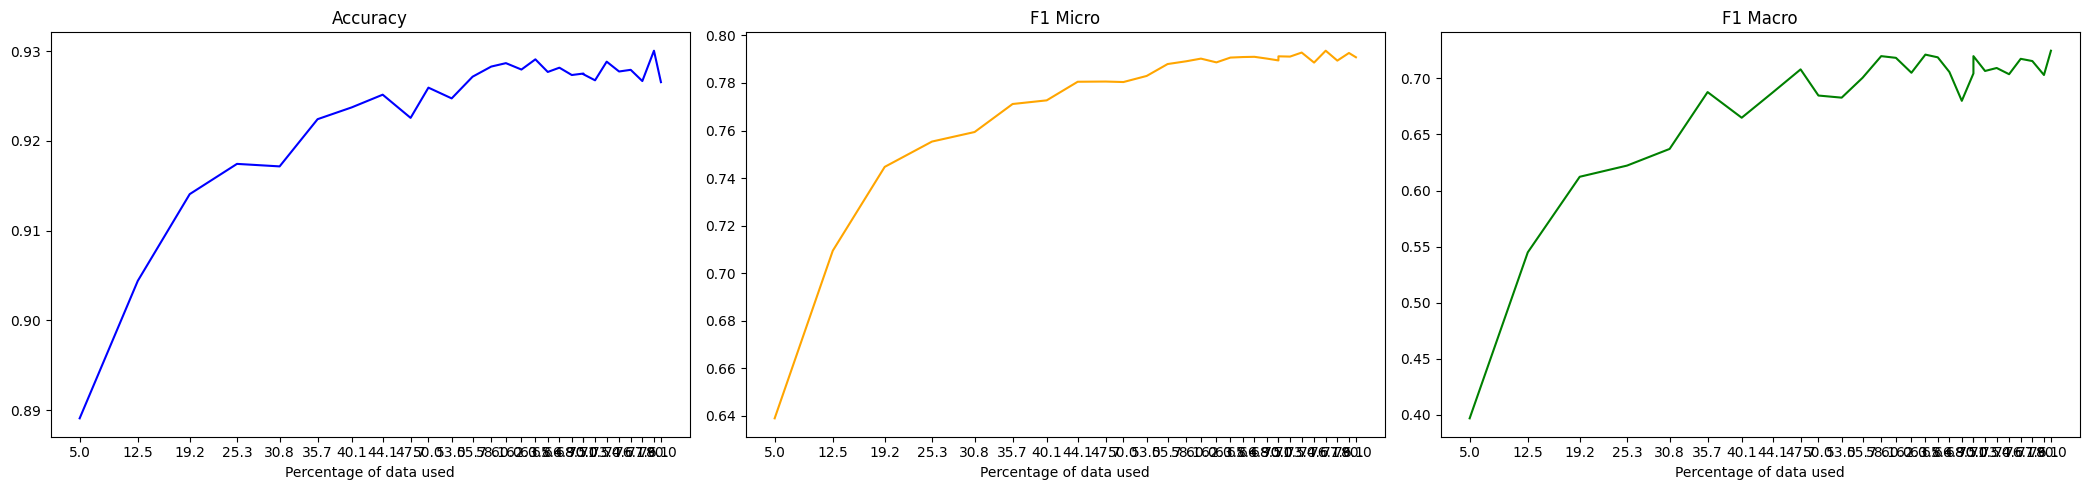

In [ ]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: [94, 21, 5]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5534, Accuracy: 0.828, F1 Micro: 0.0291, F1 Macro: 0.0124
Epoch 2/10, Train Loss: 0.4183, Accuracy: 0.8281, F1 Micro: 0.0181, F1 Macro: 0.008
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3779, Accuracy: 0.8364, F1 Micro: 0.1192, F1 Macro: 0.0469
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3644, Accuracy: 0.8572, F1 Micro: 0.3765, F1 Macro: 0.1175
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3428, Accuracy: 0.8691, F1 Micro: 0.4752, F1 Macro: 0.1966
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2967, Accuracy: 0.8805, F1 Micro: 0.5933, F1 Macro: 0.3073
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2617, Accuracy: 0.8838, F1 Micro: 0.598, F1 Macro: 0.3314
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2459, Accuracy: 0.8864, F1 Micro: 0.6033, F1 Macro: 0.3476
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2198, Accuracy: 0.8897, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5477, Accuracy: 0.828, F1 Micro: 0.0267, F1 Macro: 0.0114
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4185, Accuracy: 0.8287, F1 Micro: 0.0302, F1 Macro: 0.013
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3775, Accuracy: 0.8363, F1 Micro: 0.137, F1 Macro: 0.0485
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3663, Accuracy: 0.8517, F1 Micro: 0.3192, F1 Macro: 0.1086
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3479, Accuracy: 0.8694, F1 Micro: 0.4829, F1 Macro: 0.2143
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3027, Accuracy: 0.8784, F1 Micro: 0.5658, F1 Macro: 0.2869
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2658, Accuracy: 0.8839, F1 Micro: 0.6145, F1 Macro: 0.3334
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2469, Accuracy: 0.8866, F1 Micro: 0.6217, F1 Macro: 0.3598
Epoch 9/10, Train Loss: 0.2197, Accuracy: 0.8874, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5358, Accuracy: 0.8314, F1 Micro: 0.0672, F1 Macro: 0.0272
Epoch 2/10, Train Loss: 0.4175, Accuracy: 0.8304, F1 Micro: 0.0467, F1 Macro: 0.0193
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3757, Accuracy: 0.8411, F1 Micro: 0.1786, F1 Macro: 0.0662
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3605, Accuracy: 0.8554, F1 Micro: 0.3705, F1 Macro: 0.1174
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.337, Accuracy: 0.8696, F1 Micro: 0.4624, F1 Macro: 0.2066
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2963, Accuracy: 0.881, F1 Micro: 0.5847, F1 Macro: 0.3321
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2561, Accuracy: 0.8853, F1 Micro: 0.6121, F1 Macro: 0.372
Epoch 8/10, Train Loss: 0.2441, Accuracy: 0.8855, F1 Micro: 0.6013, F1 Macro: 0.3664
Epoch 9/10, Train Loss: 0.2112, Accuracy: 0.8856, F1 Micro: 0.6001, F1 Macro: 0.3704
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5001, Accuracy: 0.8414, F1 Micro: 0.3997, F1 Macro: 0.114
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4169, Accuracy: 0.8691, F1 Micro: 0.5635, F1 Macro: 0.2571
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3559, Accuracy: 0.8911, F1 Micro: 0.6332, F1 Macro: 0.3659
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.307, Accuracy: 0.8952, F1 Micro: 0.6858, F1 Macro: 0.452
Epoch 5/10, Train Loss: 0.26, Accuracy: 0.9034, F1 Micro: 0.6794, F1 Macro: 0.4735
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2221, Accuracy: 0.9042, F1 Micro: 0.704, F1 Macro: 0.4953
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1945, Accuracy: 0.9057, F1 Micro: 0.7125, F1 Macro: 0.5169
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1602, Accuracy: 0.9056, F1 Micro: 0.7157, F1 Macro: 0.5251
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1288, Accuracy: 0.9083, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5012, Accuracy: 0.8303, F1 Micro: 0.3884, F1 Macro: 0.1078
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4189, Accuracy: 0.8687, F1 Micro: 0.5492, F1 Macro: 0.2459
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3566, Accuracy: 0.8883, F1 Micro: 0.6563, F1 Macro: 0.3825
Epoch 4/10, Train Loss: 0.3098, Accuracy: 0.8948, F1 Micro: 0.653, F1 Macro: 0.3949
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2631, Accuracy: 0.9003, F1 Micro: 0.674, F1 Macro: 0.4667
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2273, Accuracy: 0.902, F1 Micro: 0.7035, F1 Macro: 0.5041
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1965, Accuracy: 0.9047, F1 Micro: 0.707, F1 Macro: 0.5328
Epoch 8/10, Train Loss: 0.1558, Accuracy: 0.9043, F1 Micro: 0.7056, F1 Macro: 0.5226
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1316, Accuracy: 0.9042, F1 Micro: 0.712, F1 Macro: 0.5237
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4951, Accuracy: 0.8406, F1 Micro: 0.4107, F1 Macro: 0.117
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4155, Accuracy: 0.8717, F1 Micro: 0.5526, F1 Macro: 0.2487
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3488, Accuracy: 0.8876, F1 Micro: 0.6583, F1 Macro: 0.3967
Epoch 4/10, Train Loss: 0.306, Accuracy: 0.8943, F1 Micro: 0.6507, F1 Macro: 0.3956
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2587, Accuracy: 0.9009, F1 Micro: 0.67, F1 Macro: 0.4494
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2214, Accuracy: 0.9, F1 Micro: 0.6995, F1 Macro: 0.4777
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1989, Accuracy: 0.9058, F1 Micro: 0.7045, F1 Macro: 0.5144
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1591, Accuracy: 0.9025, F1 Micro: 0.7121, F1 Macro: 0.5229
Epoch 9/10, Train Loss: 0.1318, Accuracy: 0.9044, F1 Micro: 0.6973, F1 Macro: 0.5227
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4744, Accuracy: 0.84, F1 Micro: 0.4097, F1 Macro: 0.1137
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.388, Accuracy: 0.8798, F1 Micro: 0.5314, F1 Macro: 0.2662
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.328, Accuracy: 0.8997, F1 Micro: 0.7021, F1 Macro: 0.4993
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2749, Accuracy: 0.9093, F1 Micro: 0.7199, F1 Macro: 0.5325
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2276, Accuracy: 0.9103, F1 Micro: 0.7213, F1 Macro: 0.5499
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1825, Accuracy: 0.9125, F1 Micro: 0.7271, F1 Macro: 0.5562
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1471, Accuracy: 0.9112, F1 Micro: 0.7374, F1 Macro: 0.594
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1257, Accuracy: 0.9117, F1 Micro: 0.7394, F1 Macro: 0.6035
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4754, Accuracy: 0.8322, F1 Micro: 0.4226, F1 Macro: 0.1327
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3874, Accuracy: 0.8826, F1 Micro: 0.5581, F1 Macro: 0.3095
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3318, Accuracy: 0.8978, F1 Micro: 0.6932, F1 Macro: 0.4569
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2757, Accuracy: 0.9079, F1 Micro: 0.7135, F1 Macro: 0.5128
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2282, Accuracy: 0.9092, F1 Micro: 0.7284, F1 Macro: 0.554
Epoch 6/10, Train Loss: 0.1847, Accuracy: 0.9092, F1 Micro: 0.713, F1 Macro: 0.5272
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1488, Accuracy: 0.9117, F1 Micro: 0.736, F1 Macro: 0.5716
Epoch 8/10, Train Loss: 0.1291, Accuracy: 0.914, F1 Micro: 0.7329, F1 Macro: 0.5891
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1065, Accuracy: 0.9118, F1 Micro: 0.7455, F1 Macro: 0.6172
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4712, Accuracy: 0.8411, F1 Micro: 0.4401, F1 Macro: 0.1464
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3819, Accuracy: 0.8827, F1 Micro: 0.5487, F1 Macro: 0.2943
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3248, Accuracy: 0.8992, F1 Micro: 0.6904, F1 Macro: 0.4554
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2773, Accuracy: 0.9064, F1 Micro: 0.7238, F1 Macro: 0.5216
Epoch 5/10, Train Loss: 0.23, Accuracy: 0.9099, F1 Micro: 0.7231, F1 Macro: 0.5352
Epoch 6/10, Train Loss: 0.1813, Accuracy: 0.9118, F1 Micro: 0.7136, F1 Macro: 0.5272
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1509, Accuracy: 0.911, F1 Micro: 0.7366, F1 Macro: 0.5688
Epoch 8/10, Train Loss: 0.1268, Accuracy: 0.9121, F1 Micro: 0.7265, F1 Macro: 0.5871
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.107, Accuracy: 0.912, F1 Micro: 0.7405, F1 Macro: 0.6073
Epoch 10/10, Train Loss: 0.0902, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4601, Accuracy: 0.8588, F1 Micro: 0.5248, F1 Macro: 0.2197
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3631, Accuracy: 0.9007, F1 Micro: 0.676, F1 Macro: 0.4652
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2958, Accuracy: 0.9051, F1 Micro: 0.73, F1 Macro: 0.5439
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2448, Accuracy: 0.916, F1 Micro: 0.7405, F1 Macro: 0.5765
Epoch 5/10, Train Loss: 0.1939, Accuracy: 0.916, F1 Micro: 0.737, F1 Macro: 0.5744
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1616, Accuracy: 0.9177, F1 Micro: 0.742, F1 Macro: 0.5875
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1363, Accuracy: 0.9178, F1 Micro: 0.7447, F1 Macro: 0.6018
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1022, Accuracy: 0.9154, F1 Micro: 0.7572, F1 Macro: 0.6245
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0923, Accuracy: 0.9201, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4572, Accuracy: 0.8532, F1 Micro: 0.5345, F1 Macro: 0.2355
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3657, Accuracy: 0.9, F1 Micro: 0.6768, F1 Macro: 0.4588
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2974, Accuracy: 0.9053, F1 Micro: 0.7314, F1 Macro: 0.5447
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2458, Accuracy: 0.9147, F1 Micro: 0.7381, F1 Macro: 0.5639
Epoch 5/10, Train Loss: 0.1908, Accuracy: 0.9153, F1 Micro: 0.7304, F1 Macro: 0.5538
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1562, Accuracy: 0.9177, F1 Micro: 0.7433, F1 Macro: 0.5892
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1283, Accuracy: 0.9167, F1 Micro: 0.7474, F1 Macro: 0.6018
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0998, Accuracy: 0.9166, F1 Micro: 0.7482, F1 Macro: 0.6183
Epoch 9/10, Train Loss: 0.0883, Accuracy: 0.9164, F1 Micro: 0.7475, F1 Macro: 0.6345
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4563, Accuracy: 0.8531, F1 Micro: 0.5524, F1 Macro: 0.2501
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3621, Accuracy: 0.899, F1 Micro: 0.6704, F1 Macro: 0.447
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2979, Accuracy: 0.9067, F1 Micro: 0.7264, F1 Macro: 0.5301
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2497, Accuracy: 0.9141, F1 Micro: 0.7367, F1 Macro: 0.5527
Epoch 5/10, Train Loss: 0.1976, Accuracy: 0.9133, F1 Micro: 0.7222, F1 Macro: 0.5191
Epoch 6/10, Train Loss: 0.164, Accuracy: 0.9158, F1 Micro: 0.7311, F1 Macro: 0.5604
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1352, Accuracy: 0.9165, F1 Micro: 0.7401, F1 Macro: 0.5881
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1044, Accuracy: 0.9148, F1 Micro: 0.7476, F1 Macro: 0.6282
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0905, Accuracy: 0.9181, F1 Micro: 0.7529, F1 Macro: 0.6339
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4467, Accuracy: 0.875, F1 Micro: 0.5228, F1 Macro: 0.234
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3394, Accuracy: 0.8987, F1 Micro: 0.7061, F1 Macro: 0.5012
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2827, Accuracy: 0.9106, F1 Micro: 0.7152, F1 Macro: 0.5662
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2378, Accuracy: 0.9164, F1 Micro: 0.7436, F1 Macro: 0.5854
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1916, Accuracy: 0.9178, F1 Micro: 0.7641, F1 Macro: 0.6128
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.15, Accuracy: 0.9198, F1 Micro: 0.7653, F1 Macro: 0.6277
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1214, Accuracy: 0.9178, F1 Micro: 0.7656, F1 Macro: 0.6329
Epoch 8/10, Train Loss: 0.1072, Accuracy: 0.9143, F1 Micro: 0.7601, F1 Macro: 0.6364
Epoch 9/10, Train Loss: 0.0883, Accuracy: 0.9187, F1 Micro: 0.7654, F1 Macro: 0.6485
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4487, Accuracy: 0.8697, F1 Micro: 0.5302, F1 Macro: 0.2516
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3429, Accuracy: 0.9008, F1 Micro: 0.7045, F1 Macro: 0.4845
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2893, Accuracy: 0.9091, F1 Micro: 0.733, F1 Macro: 0.5792
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2365, Accuracy: 0.9156, F1 Micro: 0.734, F1 Macro: 0.5675
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1874, Accuracy: 0.9198, F1 Micro: 0.7582, F1 Macro: 0.5982
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1535, Accuracy: 0.9188, F1 Micro: 0.7639, F1 Macro: 0.6361
Epoch 7/10, Train Loss: 0.1223, Accuracy: 0.9209, F1 Micro: 0.7635, F1 Macro: 0.627
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1027, Accuracy: 0.9187, F1 Micro: 0.7665, F1 Macro: 0.6367
Epoch 9/10, Train Loss: 0.0856, Accuracy: 0.9205, F1 Micro: 0.7659, F1 Macro: 0.6458
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4447, Accuracy: 0.8727, F1 Micro: 0.5232, F1 Macro: 0.2391
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3419, Accuracy: 0.9017, F1 Micro: 0.7047, F1 Macro: 0.482
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2884, Accuracy: 0.9067, F1 Micro: 0.7087, F1 Macro: 0.5483
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2402, Accuracy: 0.9156, F1 Micro: 0.742, F1 Macro: 0.559
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1917, Accuracy: 0.9171, F1 Micro: 0.7571, F1 Macro: 0.5946
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1494, Accuracy: 0.92, F1 Micro: 0.7594, F1 Macro: 0.65
Epoch 7/10, Train Loss: 0.1258, Accuracy: 0.9191, F1 Micro: 0.754, F1 Macro: 0.6306
Epoch 8/10, Train Loss: 0.1018, Accuracy: 0.9198, F1 Micro: 0.7538, F1 Macro: 0.6245
Epoch 9/10, Train Loss: 0.0847, Accuracy: 0.9167, F1 Micro: 0.7574, F1 Macro: 0.6461
Higher F1 achieved, saving model
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4401, Accuracy: 0.8871, F1 Micro: 0.6337, F1 Macro: 0.3246
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3333, Accuracy: 0.9078, F1 Micro: 0.7169, F1 Macro: 0.539
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2711, Accuracy: 0.9177, F1 Micro: 0.748, F1 Macro: 0.5849
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2182, Accuracy: 0.9173, F1 Micro: 0.7591, F1 Macro: 0.6165
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1804, Accuracy: 0.9209, F1 Micro: 0.7608, F1 Macro: 0.634
Epoch 6/10, Train Loss: 0.143, Accuracy: 0.9178, F1 Micro: 0.759, F1 Macro: 0.6311
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1196, Accuracy: 0.9194, F1 Micro: 0.7637, F1 Macro: 0.6483
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0961, Accuracy: 0.9173, F1 Micro: 0.7645, F1 Macro: 0.6502
Epoch 9/10, Train Loss: 0.0789, Accuracy: 0.9216, F1 Micro: 0.761, F1 Macro: 0.6707
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4427, Accuracy: 0.881, F1 Micro: 0.6096, F1 Macro: 0.3002
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3363, Accuracy: 0.9068, F1 Micro: 0.7076, F1 Macro: 0.5047
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2737, Accuracy: 0.9164, F1 Micro: 0.7423, F1 Macro: 0.5849
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2231, Accuracy: 0.9127, F1 Micro: 0.7549, F1 Macro: 0.6143
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1792, Accuracy: 0.9203, F1 Micro: 0.7605, F1 Macro: 0.6144
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1405, Accuracy: 0.9226, F1 Micro: 0.767, F1 Macro: 0.6301
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1157, Accuracy: 0.9212, F1 Micro: 0.7703, F1 Macro: 0.6458
Epoch 8/10, Train Loss: 0.0928, Accuracy: 0.9209, F1 Micro: 0.7578, F1 Macro: 0.6406
Epoch 9/10, Train Loss: 0.0793, Accuracy: 0.922, F1 Micro: 0.7675, F1 Macro: 0.6619
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4378, Accuracy: 0.8834, F1 Micro: 0.6206, F1 Macro: 0.3142
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3326, Accuracy: 0.9048, F1 Micro: 0.7173, F1 Macro: 0.5167
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.274, Accuracy: 0.916, F1 Micro: 0.7358, F1 Macro: 0.5614
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2181, Accuracy: 0.913, F1 Micro: 0.755, F1 Macro: 0.6002
Epoch 5/10, Train Loss: 0.1819, Accuracy: 0.9185, F1 Micro: 0.7482, F1 Macro: 0.6108
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1462, Accuracy: 0.9163, F1 Micro: 0.7623, F1 Macro: 0.6337
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1175, Accuracy: 0.9212, F1 Micro: 0.77, F1 Macro: 0.6631
Epoch 8/10, Train Loss: 0.0945, Accuracy: 0.9178, F1 Micro: 0.7579, F1 Macro: 0.6401
Epoch 9/10, Train Loss: 0.079, Accuracy: 0.9225, F1 Micro: 0.7633, F1 Macro: 0.6682
Epoch 10/10, Train Loss: 0.0673, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4346, Accuracy: 0.8901, F1 Micro: 0.6521, F1 Macro: 0.3921
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3212, Accuracy: 0.9103, F1 Micro: 0.7122, F1 Macro: 0.5176
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2594, Accuracy: 0.918, F1 Micro: 0.7455, F1 Macro: 0.6036
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2111, Accuracy: 0.9199, F1 Micro: 0.7695, F1 Macro: 0.635
Epoch 5/10, Train Loss: 0.1678, Accuracy: 0.9212, F1 Micro: 0.7583, F1 Macro: 0.6492
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1394, Accuracy: 0.9222, F1 Micro: 0.7703, F1 Macro: 0.6538
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1116, Accuracy: 0.9241, F1 Micro: 0.7764, F1 Macro: 0.6751
Epoch 8/10, Train Loss: 0.0932, Accuracy: 0.9236, F1 Micro: 0.7744, F1 Macro: 0.6936
Epoch 9/10, Train Loss: 0.079, Accuracy: 0.9254, F1 Micro: 0.7729, F1 Macro: 0.6975
Epoch 10/10, Train Loss: 0.0668, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4351, Accuracy: 0.8856, F1 Micro: 0.6458, F1 Macro: 0.349
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3267, Accuracy: 0.9102, F1 Micro: 0.7101, F1 Macro: 0.5511
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2627, Accuracy: 0.9181, F1 Micro: 0.7525, F1 Macro: 0.6013
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2097, Accuracy: 0.9161, F1 Micro: 0.7645, F1 Macro: 0.6157
Epoch 5/10, Train Loss: 0.1685, Accuracy: 0.92, F1 Micro: 0.7642, F1 Macro: 0.6493
Epoch 6/10, Train Loss: 0.1363, Accuracy: 0.919, F1 Micro: 0.7634, F1 Macro: 0.6422
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1113, Accuracy: 0.9227, F1 Micro: 0.7745, F1 Macro: 0.6737
Epoch 8/10, Train Loss: 0.0914, Accuracy: 0.9184, F1 Micro: 0.769, F1 Macro: 0.6957
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.079, Accuracy: 0.9234, F1 Micro: 0.7753, F1 Macro: 0.6924
Epoch 10/10, Train Loss: 0.0696, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4313, Accuracy: 0.8868, F1 Micro: 0.6639, F1 Macro: 0.4191
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3234, Accuracy: 0.9098, F1 Micro: 0.7015, F1 Macro: 0.5162
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2615, Accuracy: 0.9161, F1 Micro: 0.7379, F1 Macro: 0.5703
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2125, Accuracy: 0.9166, F1 Micro: 0.756, F1 Macro: 0.6046
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1697, Accuracy: 0.9203, F1 Micro: 0.7598, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1353, Accuracy: 0.9174, F1 Micro: 0.7604, F1 Macro: 0.6493
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1151, Accuracy: 0.9217, F1 Micro: 0.7692, F1 Macro: 0.6733
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0928, Accuracy: 0.9226, F1 Micro: 0.7704, F1 Macro: 0.6864
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4283, Accuracy: 0.8938, F1 Micro: 0.648, F1 Macro: 0.4074
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3115, Accuracy: 0.9131, F1 Micro: 0.7174, F1 Macro: 0.5489
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2457, Accuracy: 0.9198, F1 Micro: 0.7624, F1 Macro: 0.6123
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2063, Accuracy: 0.9223, F1 Micro: 0.7706, F1 Macro: 0.6326
Epoch 5/10, Train Loss: 0.1675, Accuracy: 0.9251, F1 Micro: 0.7667, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1323, Accuracy: 0.9238, F1 Micro: 0.7752, F1 Macro: 0.6742
Epoch 7/10, Train Loss: 0.1076, Accuracy: 0.9216, F1 Micro: 0.7709, F1 Macro: 0.6896
Epoch 8/10, Train Loss: 0.0894, Accuracy: 0.9221, F1 Micro: 0.7734, F1 Macro: 0.7031
Epoch 9/10, Train Loss: 0.0726, Accuracy: 0.9252, F1 Micro: 0.7696, F1 Macro: 0.697
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0676, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4298, Accuracy: 0.8885, F1 Micro: 0.6105, F1 Macro: 0.3644
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3178, Accuracy: 0.9117, F1 Micro: 0.7087, F1 Macro: 0.5443
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2506, Accuracy: 0.9174, F1 Micro: 0.7607, F1 Macro: 0.6158
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.205, Accuracy: 0.9218, F1 Micro: 0.7652, F1 Macro: 0.6192
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1632, Accuracy: 0.9214, F1 Micro: 0.767, F1 Macro: 0.6502
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1339, Accuracy: 0.9258, F1 Micro: 0.7764, F1 Macro: 0.6697
Epoch 7/10, Train Loss: 0.104, Accuracy: 0.9234, F1 Micro: 0.7678, F1 Macro: 0.6769
Epoch 8/10, Train Loss: 0.0893, Accuracy: 0.9227, F1 Micro: 0.7663, F1 Macro: 0.6953
Epoch 9/10, Train Loss: 0.0769, Accuracy: 0.9223, F1 Micro: 0.7726, F1 Macro: 0.7028
Epoch 10/10, Train Loss: 0.063, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4255, Accuracy: 0.8916, F1 Micro: 0.625, F1 Macro: 0.3889
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3169, Accuracy: 0.9136, F1 Micro: 0.7217, F1 Macro: 0.5402
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2499, Accuracy: 0.9175, F1 Micro: 0.761, F1 Macro: 0.6058
Epoch 4/10, Train Loss: 0.2039, Accuracy: 0.9219, F1 Micro: 0.7605, F1 Macro: 0.6255
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1661, Accuracy: 0.9224, F1 Micro: 0.7657, F1 Macro: 0.6591
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1306, Accuracy: 0.9227, F1 Micro: 0.7735, F1 Macro: 0.6718
Epoch 7/10, Train Loss: 0.1032, Accuracy: 0.9229, F1 Micro: 0.7694, F1 Macro: 0.6875
Epoch 8/10, Train Loss: 0.0877, Accuracy: 0.9222, F1 Micro: 0.7734, F1 Macro: 0.697
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0739, Accuracy: 0.9215, F1 Micro: 0.7737, F1 Macro: 0.7019
Epoch 10/10, Train Loss: 0.064, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.419, Accuracy: 0.8973, F1 Micro: 0.6679, F1 Macro: 0.4388
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3068, Accuracy: 0.9139, F1 Micro: 0.7502, F1 Macro: 0.5999
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.247, Accuracy: 0.9234, F1 Micro: 0.7658, F1 Macro: 0.6119
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1926, Accuracy: 0.9227, F1 Micro: 0.7742, F1 Macro: 0.6403
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1539, Accuracy: 0.9243, F1 Micro: 0.7784, F1 Macro: 0.678
Epoch 6/10, Train Loss: 0.1187, Accuracy: 0.9242, F1 Micro: 0.776, F1 Macro: 0.6768
Epoch 7/10, Train Loss: 0.1039, Accuracy: 0.9259, F1 Micro: 0.7756, F1 Macro: 0.7007
Epoch 8/10, Train Loss: 0.0874, Accuracy: 0.9236, F1 Micro: 0.7742, F1 Macro: 0.7041
Epoch 9/10, Train Loss: 0.0725, Accuracy: 0.9248, F1 Micro: 0.774, F1 Macro: 0.694
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0639, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4186, Accuracy: 0.8927, F1 Micro: 0.6335, F1 Macro: 0.3719
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3112, Accuracy: 0.9083, F1 Micro: 0.745, F1 Macro: 0.5867
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2488, Accuracy: 0.9222, F1 Micro: 0.7594, F1 Macro: 0.6045
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1979, Accuracy: 0.9233, F1 Micro: 0.7751, F1 Macro: 0.6364
Epoch 5/10, Train Loss: 0.159, Accuracy: 0.9209, F1 Micro: 0.7725, F1 Macro: 0.6741
Epoch 6/10, Train Loss: 0.1221, Accuracy: 0.9185, F1 Micro: 0.7715, F1 Macro: 0.6669
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1004, Accuracy: 0.9248, F1 Micro: 0.7779, F1 Macro: 0.6829
Epoch 8/10, Train Loss: 0.0864, Accuracy: 0.9227, F1 Micro: 0.777, F1 Macro: 0.7033
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0715, Accuracy: 0.9244, F1 Micro: 0.7801, F1 Macro: 0.7177
Epoch 10/10, Train Loss: 0.062, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4162, Accuracy: 0.8945, F1 Micro: 0.6406, F1 Macro: 0.3988
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3098, Accuracy: 0.9118, F1 Micro: 0.745, F1 Macro: 0.5792
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.247, Accuracy: 0.922, F1 Micro: 0.7605, F1 Macro: 0.5954
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1968, Accuracy: 0.9176, F1 Micro: 0.7634, F1 Macro: 0.6267
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1576, Accuracy: 0.9218, F1 Micro: 0.7758, F1 Macro: 0.687
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1217, Accuracy: 0.9228, F1 Micro: 0.777, F1 Macro: 0.683
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1001, Accuracy: 0.927, F1 Micro: 0.7858, F1 Macro: 0.693
Epoch 8/10, Train Loss: 0.0866, Accuracy: 0.9221, F1 Micro: 0.7745, F1 Macro: 0.6949
Epoch 9/10, Train Loss: 0.072, Accuracy: 0.9237, F1 Micro: 0.7769, F1 Macro: 0.699
Epoch 10/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4161, Accuracy: 0.8964, F1 Micro: 0.6444, F1 Macro: 0.4266
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3, Accuracy: 0.9163, F1 Micro: 0.7416, F1 Macro: 0.5904
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2483, Accuracy: 0.9203, F1 Micro: 0.7604, F1 Macro: 0.6065
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2084, Accuracy: 0.9243, F1 Micro: 0.767, F1 Macro: 0.6388
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1624, Accuracy: 0.9253, F1 Micro: 0.7783, F1 Macro: 0.6694
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1262, Accuracy: 0.9258, F1 Micro: 0.7792, F1 Macro: 0.6788
Epoch 7/10, Train Loss: 0.108, Accuracy: 0.9259, F1 Micro: 0.7784, F1 Macro: 0.688
Epoch 8/10, Train Loss: 0.0919, Accuracy: 0.9231, F1 Micro: 0.7721, F1 Macro: 0.7097
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0731, Accuracy: 0.9239, F1 Micro: 0.7798, F1 Macro: 0.7161
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4181, Accuracy: 0.8911, F1 Micro: 0.6172, F1 Macro: 0.3585
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3047, Accuracy: 0.9141, F1 Micro: 0.7265, F1 Macro: 0.5727
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2483, Accuracy: 0.9179, F1 Micro: 0.7429, F1 Macro: 0.5797
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2087, Accuracy: 0.9222, F1 Micro: 0.7695, F1 Macro: 0.6287
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1602, Accuracy: 0.9244, F1 Micro: 0.7774, F1 Macro: 0.6505
Epoch 6/10, Train Loss: 0.1261, Accuracy: 0.9257, F1 Micro: 0.7735, F1 Macro: 0.6701
Epoch 7/10, Train Loss: 0.1059, Accuracy: 0.9229, F1 Micro: 0.773, F1 Macro: 0.6628
Epoch 8/10, Train Loss: 0.0902, Accuracy: 0.9261, F1 Micro: 0.7752, F1 Macro: 0.7041
Epoch 9/10, Train Loss: 0.0715, Accuracy: 0.9239, F1 Micro: 0.7735, F1 Macro: 0.7039
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0611, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4164, Accuracy: 0.8932, F1 Micro: 0.6206, F1 Macro: 0.3884
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3047, Accuracy: 0.915, F1 Micro: 0.7366, F1 Macro: 0.5678
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2501, Accuracy: 0.9182, F1 Micro: 0.7446, F1 Macro: 0.5774
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2055, Accuracy: 0.9238, F1 Micro: 0.7603, F1 Macro: 0.6354
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.161, Accuracy: 0.9235, F1 Micro: 0.7796, F1 Macro: 0.6741
Epoch 6/10, Train Loss: 0.1251, Accuracy: 0.9253, F1 Micro: 0.7763, F1 Macro: 0.6817
Epoch 7/10, Train Loss: 0.1059, Accuracy: 0.9237, F1 Micro: 0.7787, F1 Macro: 0.6852
Epoch 8/10, Train Loss: 0.0831, Accuracy: 0.9226, F1 Micro: 0.7714, F1 Macro: 0.7023
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0718, Accuracy: 0.9275, F1 Micro: 0.7866, F1 Macro: 0.719
Epoch 10/10, Train Loss: 0.0608, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4056, Accuracy: 0.9002, F1 Micro: 0.6651, F1 Macro: 0.4479
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2939, Accuracy: 0.9179, F1 Micro: 0.7567, F1 Macro: 0.595
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2354, Accuracy: 0.9229, F1 Micro: 0.7585, F1 Macro: 0.5997
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1922, Accuracy: 0.9254, F1 Micro: 0.7798, F1 Macro: 0.6442
Epoch 5/10, Train Loss: 0.1528, Accuracy: 0.9239, F1 Micro: 0.7695, F1 Macro: 0.6749
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1243, Accuracy: 0.9272, F1 Micro: 0.7806, F1 Macro: 0.6823
Epoch 7/10, Train Loss: 0.1023, Accuracy: 0.924, F1 Micro: 0.7734, F1 Macro: 0.6706
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0801, Accuracy: 0.9269, F1 Micro: 0.7841, F1 Macro: 0.7156
Epoch 9/10, Train Loss: 0.0714, Accuracy: 0.9247, F1 Micro: 0.7829, F1 Macro: 0.7164
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4087, Accuracy: 0.8962, F1 Micro: 0.6539, F1 Macro: 0.4243
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2978, Accuracy: 0.9136, F1 Micro: 0.7507, F1 Macro: 0.598
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2379, Accuracy: 0.9222, F1 Micro: 0.7573, F1 Macro: 0.6128
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.191, Accuracy: 0.9208, F1 Micro: 0.7734, F1 Macro: 0.6301
Epoch 5/10, Train Loss: 0.1533, Accuracy: 0.9234, F1 Micro: 0.7727, F1 Macro: 0.6625
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1253, Accuracy: 0.9269, F1 Micro: 0.784, F1 Macro: 0.6901
Epoch 7/10, Train Loss: 0.0985, Accuracy: 0.9244, F1 Micro: 0.776, F1 Macro: 0.6841
Epoch 8/10, Train Loss: 0.0791, Accuracy: 0.9253, F1 Micro: 0.7828, F1 Macro: 0.7038
Epoch 9/10, Train Loss: 0.0684, Accuracy: 0.9238, F1 Micro: 0.7718, F1 Macro: 0.705
Epoch 10/10, Train Loss: 0.061, Accuracy: 0.9277, F1 Micro: 0.7816, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4043, Accuracy: 0.8971, F1 Micro: 0.6555, F1 Macro: 0.4456
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2956, Accuracy: 0.9131, F1 Micro: 0.7525, F1 Macro: 0.589
Epoch 3/10, Train Loss: 0.2379, Accuracy: 0.9218, F1 Micro: 0.75, F1 Macro: 0.5864
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1945, Accuracy: 0.9225, F1 Micro: 0.7796, F1 Macro: 0.6473
Epoch 5/10, Train Loss: 0.1538, Accuracy: 0.9239, F1 Micro: 0.7684, F1 Macro: 0.6686
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1237, Accuracy: 0.928, F1 Micro: 0.7809, F1 Macro: 0.6754
Epoch 7/10, Train Loss: 0.0981, Accuracy: 0.9271, F1 Micro: 0.7777, F1 Macro: 0.6747
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0829, Accuracy: 0.9251, F1 Micro: 0.7854, F1 Macro: 0.7171
Epoch 9/10, Train Loss: 0.0681, Accuracy: 0.9246, F1 Micro: 0.7827, F1 Macro: 0.7175
Epoch 10/10, Train Loss: 0.0579, Accuracy: 0.9256, F1 Micro: 0.7818, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.402, Accuracy: 0.8969, F1 Micro: 0.6347, F1 Macro: 0.3999
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2882, Accuracy: 0.916, F1 Micro: 0.7457, F1 Macro: 0.5813
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2293, Accuracy: 0.9241, F1 Micro: 0.7627, F1 Macro: 0.6108
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1839, Accuracy: 0.924, F1 Micro: 0.7734, F1 Macro: 0.6597
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1518, Accuracy: 0.9244, F1 Micro: 0.7805, F1 Macro: 0.6701
Epoch 6/10, Train Loss: 0.1215, Accuracy: 0.9248, F1 Micro: 0.7753, F1 Macro: 0.6872
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0997, Accuracy: 0.9273, F1 Micro: 0.7814, F1 Macro: 0.7076
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.085, Accuracy: 0.9254, F1 Micro: 0.786, F1 Macro: 0.7117
Epoch 9/10, Train Loss: 0.0709, Accuracy: 0.9238, F1 Micro: 0.7769, F1 Macro: 0.7076
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4034, Accuracy: 0.894, F1 Micro: 0.6223, F1 Macro: 0.3769
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2903, Accuracy: 0.9181, F1 Micro: 0.7493, F1 Macro: 0.5895
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2302, Accuracy: 0.9231, F1 Micro: 0.7622, F1 Macro: 0.613
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1845, Accuracy: 0.9237, F1 Micro: 0.7783, F1 Macro: 0.6691
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1539, Accuracy: 0.9253, F1 Micro: 0.7816, F1 Macro: 0.6652
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1204, Accuracy: 0.9235, F1 Micro: 0.7827, F1 Macro: 0.6917
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0989, Accuracy: 0.9293, F1 Micro: 0.7905, F1 Macro: 0.7095
Epoch 8/10, Train Loss: 0.0807, Accuracy: 0.9206, F1 Micro: 0.7736, F1 Macro: 0.6998
Epoch 9/10, Train Loss: 0.0691, Accuracy: 0.924, F1 Micro: 0.7806, F1 Macro: 0.7086
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4014, Accuracy: 0.8979, F1 Micro: 0.6446, F1 Macro: 0.4111
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2886, Accuracy: 0.9157, F1 Micro: 0.7406, F1 Macro: 0.5544
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.229, Accuracy: 0.9228, F1 Micro: 0.762, F1 Macro: 0.595
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1841, Accuracy: 0.9219, F1 Micro: 0.7755, F1 Macro: 0.6595
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1529, Accuracy: 0.9259, F1 Micro: 0.7849, F1 Macro: 0.6848
Epoch 6/10, Train Loss: 0.1182, Accuracy: 0.9263, F1 Micro: 0.7804, F1 Macro: 0.696
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.098, Accuracy: 0.9272, F1 Micro: 0.785, F1 Macro: 0.6982
Epoch 8/10, Train Loss: 0.0802, Accuracy: 0.9215, F1 Micro: 0.7768, F1 Macro: 0.6972
Epoch 9/10, Train Loss: 0.0654, Accuracy: 0.9253, F1 Micro: 0.773, F1 Macro: 0.7053
Epoch 10/10, Train Loss: 0.0555, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3947, Accuracy: 0.9014, F1 Micro: 0.6952, F1 Macro: 0.4411
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2812, Accuracy: 0.9133, F1 Micro: 0.7567, F1 Macro: 0.5936
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.228, Accuracy: 0.9229, F1 Micro: 0.7595, F1 Macro: 0.6156
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1814, Accuracy: 0.9271, F1 Micro: 0.7745, F1 Macro: 0.6306
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1477, Accuracy: 0.9269, F1 Micro: 0.7861, F1 Macro: 0.7045
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1157, Accuracy: 0.9276, F1 Micro: 0.7874, F1 Macro: 0.7088
Epoch 7/10, Train Loss: 0.099, Accuracy: 0.9275, F1 Micro: 0.7828, F1 Macro: 0.6951
Epoch 8/10, Train Loss: 0.081, Accuracy: 0.9268, F1 Micro: 0.782, F1 Macro: 0.7137
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0647, Accuracy: 0.9276, F1 Micro: 0.7884, F1 Macro: 0.7215
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3959, Accuracy: 0.9005, F1 Micro: 0.6764, F1 Macro: 0.413
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2829, Accuracy: 0.9158, F1 Micro: 0.7598, F1 Macro: 0.5963
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2303, Accuracy: 0.9243, F1 Micro: 0.7752, F1 Macro: 0.6319
Epoch 4/10, Train Loss: 0.182, Accuracy: 0.9256, F1 Micro: 0.7739, F1 Macro: 0.6381
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1442, Accuracy: 0.9224, F1 Micro: 0.7776, F1 Macro: 0.6669
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1164, Accuracy: 0.9244, F1 Micro: 0.7837, F1 Macro: 0.6972
Epoch 7/10, Train Loss: 0.0981, Accuracy: 0.9268, F1 Micro: 0.777, F1 Macro: 0.6847
Epoch 8/10, Train Loss: 0.079, Accuracy: 0.9266, F1 Micro: 0.7797, F1 Macro: 0.7127
Epoch 9/10, Train Loss: 0.0634, Accuracy: 0.9265, F1 Micro: 0.7806, F1 Macro: 0.7137
Epoch 10/10, Train Loss: 0.0561, Accuracy: 0.9252, F1 Micro: 0.7816, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.393, Accuracy: 0.9011, F1 Micro: 0.6924, F1 Macro: 0.4192
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2832, Accuracy: 0.9139, F1 Micro: 0.7588, F1 Macro: 0.5851
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2271, Accuracy: 0.9232, F1 Micro: 0.7695, F1 Macro: 0.6172
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1817, Accuracy: 0.9265, F1 Micro: 0.7817, F1 Macro: 0.6488
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1441, Accuracy: 0.926, F1 Micro: 0.7833, F1 Macro: 0.7024
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1163, Accuracy: 0.9261, F1 Micro: 0.7854, F1 Macro: 0.7075
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0978, Accuracy: 0.9286, F1 Micro: 0.789, F1 Macro: 0.7027
Epoch 8/10, Train Loss: 0.079, Accuracy: 0.9258, F1 Micro: 0.7774, F1 Macro: 0.7032
Epoch 9/10, Train Loss: 0.0625, Accuracy: 0.9265, F1 Micro: 0.7879, F1 Macro: 0.7094
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3909, Accuracy: 0.901, F1 Micro: 0.6956, F1 Macro: 0.4888
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2791, Accuracy: 0.9152, F1 Micro: 0.7609, F1 Macro: 0.6035
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2178, Accuracy: 0.9202, F1 Micro: 0.7733, F1 Macro: 0.6364
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1794, Accuracy: 0.9253, F1 Micro: 0.7812, F1 Macro: 0.6547
Epoch 5/10, Train Loss: 0.1429, Accuracy: 0.9274, F1 Micro: 0.7808, F1 Macro: 0.6781
Epoch 6/10, Train Loss: 0.1138, Accuracy: 0.9267, F1 Micro: 0.7804, F1 Macro: 0.6951
Epoch 7/10, Train Loss: 0.0934, Accuracy: 0.9211, F1 Micro: 0.7798, F1 Macro: 0.7008
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.076, Accuracy: 0.9251, F1 Micro: 0.7824, F1 Macro: 0.7151
Epoch 9/10, Train Loss: 0.0617, Accuracy: 0.9249, F1 Micro: 0.7808, F1 Macro: 0.7186
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0532, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3917, Accuracy: 0.8995, F1 Micro: 0.6773, F1 Macro: 0.4677
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2811, Accuracy: 0.9155, F1 Micro: 0.7586, F1 Macro: 0.5994
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2186, Accuracy: 0.9205, F1 Micro: 0.7717, F1 Macro: 0.6241
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1804, Accuracy: 0.9247, F1 Micro: 0.7766, F1 Macro: 0.6527
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1442, Accuracy: 0.9276, F1 Micro: 0.7805, F1 Macro: 0.6795
Epoch 6/10, Train Loss: 0.1131, Accuracy: 0.9266, F1 Micro: 0.7773, F1 Macro: 0.6791
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0903, Accuracy: 0.9264, F1 Micro: 0.7847, F1 Macro: 0.7159
Epoch 8/10, Train Loss: 0.0734, Accuracy: 0.9266, F1 Micro: 0.7811, F1 Macro: 0.716
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0644, Accuracy: 0.927, F1 Micro: 0.7869, F1 Macro: 0.7182
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3888, Accuracy: 0.8976, F1 Micro: 0.698, F1 Macro: 0.5021
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2802, Accuracy: 0.9147, F1 Micro: 0.7524, F1 Macro: 0.5783
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2191, Accuracy: 0.9205, F1 Micro: 0.7754, F1 Macro: 0.6201
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1794, Accuracy: 0.9247, F1 Micro: 0.7788, F1 Macro: 0.6581
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1417, Accuracy: 0.9267, F1 Micro: 0.7827, F1 Macro: 0.6871
Epoch 6/10, Train Loss: 0.1117, Accuracy: 0.9251, F1 Micro: 0.7747, F1 Macro: 0.6809
Epoch 7/10, Train Loss: 0.092, Accuracy: 0.9278, F1 Micro: 0.7821, F1 Macro: 0.702
Epoch 8/10, Train Loss: 0.0754, Accuracy: 0.9275, F1 Micro: 0.7821, F1 Macro: 0.7057
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0625, Accuracy: 0.9271, F1 Micro: 0.7879, F1 Macro: 0.7216
Epoch 10/10, Train Loss: 0.0523, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3822, Accuracy: 0.9026, F1 Micro: 0.7059, F1 Macro: 0.4918
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2664, Accuracy: 0.9203, F1 Micro: 0.7599, F1 Macro: 0.5979
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2149, Accuracy: 0.9259, F1 Micro: 0.7761, F1 Macro: 0.6233
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1751, Accuracy: 0.9269, F1 Micro: 0.777, F1 Macro: 0.6447
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1403, Accuracy: 0.9289, F1 Micro: 0.7829, F1 Macro: 0.6869
Epoch 6/10, Train Loss: 0.1134, Accuracy: 0.9254, F1 Micro: 0.7788, F1 Macro: 0.6924
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0903, Accuracy: 0.9247, F1 Micro: 0.7849, F1 Macro: 0.7062
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0733, Accuracy: 0.9266, F1 Micro: 0.7853, F1 Macro: 0.7198
Epoch 9/10, Train Loss: 0.0624, Accuracy: 0.925, F1 Micro: 0.7804, F1 Macro: 0.7108
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3838, Accuracy: 0.9026, F1 Micro: 0.7004, F1 Macro: 0.4787
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2715, Accuracy: 0.9176, F1 Micro: 0.7392, F1 Macro: 0.5746
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2172, Accuracy: 0.9258, F1 Micro: 0.7763, F1 Macro: 0.6255
Epoch 4/10, Train Loss: 0.1762, Accuracy: 0.9263, F1 Micro: 0.7703, F1 Macro: 0.6382
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1389, Accuracy: 0.9278, F1 Micro: 0.7791, F1 Macro: 0.6495
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1073, Accuracy: 0.9258, F1 Micro: 0.783, F1 Macro: 0.6877
Epoch 7/10, Train Loss: 0.0896, Accuracy: 0.9218, F1 Micro: 0.7796, F1 Macro: 0.7141
Epoch 8/10, Train Loss: 0.0711, Accuracy: 0.926, F1 Micro: 0.7788, F1 Macro: 0.7153
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.061, Accuracy: 0.9264, F1 Micro: 0.7841, F1 Macro: 0.7232
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3799, Accuracy: 0.9019, F1 Micro: 0.7063, F1 Macro: 0.4841
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2688, Accuracy: 0.9172, F1 Micro: 0.7381, F1 Macro: 0.5586
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2166, Accuracy: 0.9232, F1 Micro: 0.7768, F1 Macro: 0.6262
Epoch 4/10, Train Loss: 0.1736, Accuracy: 0.9253, F1 Micro: 0.7723, F1 Macro: 0.6379
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1411, Accuracy: 0.9267, F1 Micro: 0.7794, F1 Macro: 0.6752
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1123, Accuracy: 0.9257, F1 Micro: 0.7846, F1 Macro: 0.6918
Epoch 7/10, Train Loss: 0.0921, Accuracy: 0.9259, F1 Micro: 0.7832, F1 Macro: 0.7073
Epoch 8/10, Train Loss: 0.0721, Accuracy: 0.9244, F1 Micro: 0.7757, F1 Macro: 0.7059
Epoch 9/10, Train Loss: 0.0587, Accuracy: 0.9267, F1 Micro: 0.7809, F1 Macro: 0.7076
Epoch 10/10, Train Loss: 0.0518, Accuracy: 0.9249, F1 Micro: 0.784, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3738, Accuracy: 0.9045, F1 Micro: 0.7103, F1 Macro: 0.4758
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2631, Accuracy: 0.9212, F1 Micro: 0.7639, F1 Macro: 0.6013
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.208, Accuracy: 0.927, F1 Micro: 0.7839, F1 Macro: 0.6374
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.167, Accuracy: 0.9269, F1 Micro: 0.7854, F1 Macro: 0.6581
Epoch 5/10, Train Loss: 0.1336, Accuracy: 0.9246, F1 Micro: 0.7807, F1 Macro: 0.6732
Epoch 6/10, Train Loss: 0.1065, Accuracy: 0.9245, F1 Micro: 0.7814, F1 Macro: 0.6951
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0909, Accuracy: 0.9273, F1 Micro: 0.7863, F1 Macro: 0.7117
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0702, Accuracy: 0.9302, F1 Micro: 0.7889, F1 Macro: 0.7094
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0613, Accuracy: 0.9287, F1 Micro: 0.792, F1 Macro: 0.7181
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3768, Accuracy: 0.904, F1 Micro: 0.7014, F1 Macro: 0.4665
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2667, Accuracy: 0.9202, F1 Micro: 0.7625, F1 Macro: 0.5912
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2107, Accuracy: 0.9261, F1 Micro: 0.7789, F1 Macro: 0.6315
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1705, Accuracy: 0.9269, F1 Micro: 0.7828, F1 Macro: 0.655
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1353, Accuracy: 0.9278, F1 Micro: 0.7828, F1 Macro: 0.6797
Epoch 6/10, Train Loss: 0.107, Accuracy: 0.922, F1 Micro: 0.7742, F1 Macro: 0.6831
Epoch 7/10, Train Loss: 0.0898, Accuracy: 0.9234, F1 Micro: 0.7809, F1 Macro: 0.6942
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0726, Accuracy: 0.9279, F1 Micro: 0.7859, F1 Macro: 0.7088
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0603, Accuracy: 0.9281, F1 Micro: 0.7867, F1 Macro: 0.7171
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3727, Accuracy: 0.9015, F1 Micro: 0.691, F1 Macro: 0.4389
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.264, Accuracy: 0.9194, F1 Micro: 0.7591, F1 Macro: 0.582
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2091, Accuracy: 0.9253, F1 Micro: 0.7781, F1 Macro: 0.6237
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1709, Accuracy: 0.9267, F1 Micro: 0.7842, F1 Macro: 0.6599
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1348, Accuracy: 0.9279, F1 Micro: 0.7858, F1 Macro: 0.6762
Epoch 6/10, Train Loss: 0.1083, Accuracy: 0.921, F1 Micro: 0.7757, F1 Macro: 0.6912
Epoch 7/10, Train Loss: 0.0872, Accuracy: 0.9259, F1 Micro: 0.7853, F1 Macro: 0.6993
Epoch 8/10, Train Loss: 0.0717, Accuracy: 0.9277, F1 Micro: 0.781, F1 Macro: 0.7045
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.059, Accuracy: 0.928, F1 Micro: 0.7874, F1 Macro: 0.7084
Epoch 10/10, Train Loss: 0.0514, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3665, Accuracy: 0.9047, F1 Micro: 0.6988, F1 Macro: 0.4698
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.264, Accuracy: 0.9195, F1 Micro: 0.7432, F1 Macro: 0.5796
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2026, Accuracy: 0.9231, F1 Micro: 0.778, F1 Macro: 0.6453
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1708, Accuracy: 0.9262, F1 Micro: 0.7789, F1 Macro: 0.6638
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1337, Accuracy: 0.9282, F1 Micro: 0.788, F1 Macro: 0.7028
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1039, Accuracy: 0.9303, F1 Micro: 0.7882, F1 Macro: 0.6974
Epoch 7/10, Train Loss: 0.0886, Accuracy: 0.9262, F1 Micro: 0.7861, F1 Macro: 0.6929
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0724, Accuracy: 0.9276, F1 Micro: 0.7896, F1 Macro: 0.7192
Epoch 9/10, Train Loss: 0.0608, Accuracy: 0.928, F1 Micro: 0.7871, F1 Macro: 0.7213
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3692, Accuracy: 0.9029, F1 Micro: 0.7099, F1 Macro: 0.5009
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2658, Accuracy: 0.9197, F1 Micro: 0.7486, F1 Macro: 0.5835
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.203, Accuracy: 0.9239, F1 Micro: 0.7728, F1 Macro: 0.6313
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1696, Accuracy: 0.9242, F1 Micro: 0.7751, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1366, Accuracy: 0.9275, F1 Micro: 0.7865, F1 Macro: 0.6901
Epoch 6/10, Train Loss: 0.1047, Accuracy: 0.9247, F1 Micro: 0.7857, F1 Macro: 0.698
Epoch 7/10, Train Loss: 0.0863, Accuracy: 0.9274, F1 Micro: 0.777, F1 Macro: 0.6977
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0714, Accuracy: 0.9274, F1 Micro: 0.7867, F1 Macro: 0.708
Epoch 9/10, Train Loss: 0.0592, Accuracy: 0.928, F1 Micro: 0.785, F1 Macro: 0.7202
Epoch 10/10, Train Loss: 0.0497, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3675, Accuracy: 0.9017, F1 Micro: 0.7129, F1 Macro: 0.5058
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2647, Accuracy: 0.919, F1 Micro: 0.7485, F1 Macro: 0.5784
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2022, Accuracy: 0.9229, F1 Micro: 0.7761, F1 Macro: 0.632
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.17, Accuracy: 0.9252, F1 Micro: 0.7771, F1 Macro: 0.657
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1331, Accuracy: 0.9277, F1 Micro: 0.7804, F1 Macro: 0.6813
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1036, Accuracy: 0.9286, F1 Micro: 0.7877, F1 Macro: 0.7034
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0849, Accuracy: 0.928, F1 Micro: 0.7896, F1 Macro: 0.7125
Epoch 8/10, Train Loss: 0.0701, Accuracy: 0.9265, F1 Micro: 0.784, F1 Macro: 0.7079
Epoch 9/10, Train Loss: 0.0572, Accuracy: 0.9252, F1 Micro: 0.7852, F1 Macro: 0.715
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3682, Accuracy: 0.904, F1 Micro: 0.7115, F1 Macro: 0.4886
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.25, Accuracy: 0.9173, F1 Micro: 0.7502, F1 Macro: 0.5723
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2028, Accuracy: 0.9265, F1 Micro: 0.7824, F1 Macro: 0.6307
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1605, Accuracy: 0.9287, F1 Micro: 0.786, F1 Macro: 0.6723
Epoch 5/10, Train Loss: 0.1308, Accuracy: 0.9273, F1 Micro: 0.7822, F1 Macro: 0.6967
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.103, Accuracy: 0.9265, F1 Micro: 0.7885, F1 Macro: 0.7043
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0822, Accuracy: 0.928, F1 Micro: 0.7891, F1 Macro: 0.7183
Epoch 8/10, Train Loss: 0.0713, Accuracy: 0.9273, F1 Micro: 0.7875, F1 Macro: 0.7199
Epoch 9/10, Train Loss: 0.0558, Accuracy: 0.925, F1 Micro: 0.7845, F1 Macro: 0.7241
Epoch 10/10, Train Loss: 0.0519, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3708, Accuracy: 0.9029, F1 Micro: 0.6979, F1 Macro: 0.4611
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.254, Accuracy: 0.9176, F1 Micro: 0.75, F1 Macro: 0.5715
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2039, Accuracy: 0.9238, F1 Micro: 0.7759, F1 Macro: 0.622
Epoch 4/10, Train Loss: 0.1625, Accuracy: 0.9256, F1 Micro: 0.7709, F1 Macro: 0.6571
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.131, Accuracy: 0.9272, F1 Micro: 0.7821, F1 Macro: 0.6655
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1017, Accuracy: 0.9278, F1 Micro: 0.7904, F1 Macro: 0.7043
Epoch 7/10, Train Loss: 0.0815, Accuracy: 0.9278, F1 Micro: 0.7853, F1 Macro: 0.7128
Epoch 8/10, Train Loss: 0.0705, Accuracy: 0.9258, F1 Micro: 0.781, F1 Macro: 0.7156
Epoch 9/10, Train Loss: 0.0542, Accuracy: 0.9234, F1 Micro: 0.7851, F1 Macro: 0.7239
Epoch 10/10, Train Loss: 0.048, Accuracy: 0.926, F1 Micro: 0.7865, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3669, Accuracy: 0.9027, F1 Micro: 0.7071, F1 Macro: 0.4572
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2521, Accuracy: 0.9163, F1 Micro: 0.7409, F1 Macro: 0.5485
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.203, Accuracy: 0.9247, F1 Micro: 0.773, F1 Macro: 0.618
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1591, Accuracy: 0.9266, F1 Micro: 0.7749, F1 Macro: 0.6595
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.131, Accuracy: 0.926, F1 Micro: 0.7772, F1 Macro: 0.6977
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1026, Accuracy: 0.9266, F1 Micro: 0.7882, F1 Macro: 0.7065
Epoch 7/10, Train Loss: 0.081, Accuracy: 0.9284, F1 Micro: 0.7877, F1 Macro: 0.7137
Epoch 8/10, Train Loss: 0.0706, Accuracy: 0.9231, F1 Micro: 0.7826, F1 Macro: 0.7136
Epoch 9/10, Train Loss: 0.0554, Accuracy: 0.9275, F1 Micro: 0.783, F1 Macro: 0.7136
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3646, Accuracy: 0.9019, F1 Micro: 0.6939, F1 Macro: 0.4823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2438, Accuracy: 0.9169, F1 Micro: 0.7568, F1 Macro: 0.5808
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1965, Accuracy: 0.923, F1 Micro: 0.7816, F1 Macro: 0.6329
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1589, Accuracy: 0.9249, F1 Micro: 0.783, F1 Macro: 0.6672
Epoch 5/10, Train Loss: 0.1267, Accuracy: 0.9268, F1 Micro: 0.7803, F1 Macro: 0.6739
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1026, Accuracy: 0.9256, F1 Micro: 0.7842, F1 Macro: 0.7075
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0843, Accuracy: 0.9283, F1 Micro: 0.79, F1 Macro: 0.7145
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0664, Accuracy: 0.9283, F1 Micro: 0.791, F1 Macro: 0.7199
Epoch 9/10, Train Loss: 0.0585, Accuracy: 0.9255, F1 Micro: 0.7871, F1 Macro: 0.725
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3674, Accuracy: 0.902, F1 Micro: 0.6972, F1 Macro: 0.4626
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2471, Accuracy: 0.919, F1 Micro: 0.7562, F1 Macro: 0.587
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1955, Accuracy: 0.9246, F1 Micro: 0.7804, F1 Macro: 0.6393
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1593, Accuracy: 0.9246, F1 Micro: 0.7821, F1 Macro: 0.6469
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1247, Accuracy: 0.9266, F1 Micro: 0.7856, F1 Macro: 0.663
Epoch 6/10, Train Loss: 0.1, Accuracy: 0.9245, F1 Micro: 0.7671, F1 Macro: 0.6871
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0846, Accuracy: 0.9276, F1 Micro: 0.7867, F1 Macro: 0.7107
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0649, Accuracy: 0.9278, F1 Micro: 0.7888, F1 Macro: 0.7171
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0605, Accuracy: 0.9258, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.363, Accuracy: 0.9022, F1 Micro: 0.6957, F1 Macro: 0.4747
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2456, Accuracy: 0.9169, F1 Micro: 0.7512, F1 Macro: 0.5562
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1946, Accuracy: 0.922, F1 Micro: 0.777, F1 Macro: 0.6343
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1591, Accuracy: 0.9231, F1 Micro: 0.7822, F1 Macro: 0.6761
Epoch 5/10, Train Loss: 0.1205, Accuracy: 0.9276, F1 Micro: 0.7745, F1 Macro: 0.6703
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0997, Accuracy: 0.9271, F1 Micro: 0.7822, F1 Macro: 0.7043
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0833, Accuracy: 0.9268, F1 Micro: 0.7854, F1 Macro: 0.7075
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0648, Accuracy: 0.9277, F1 Micro: 0.7886, F1 Macro: 0.7239
Epoch 9/10, Train Loss: 0.0576, Accuracy: 0.9253, F1 Micro: 0.7863, F1 Macro: 0.7177
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.361, Accuracy: 0.9074, F1 Micro: 0.7128, F1 Macro: 0.5036
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2464, Accuracy: 0.9216, F1 Micro: 0.7613, F1 Macro: 0.6027
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1929, Accuracy: 0.923, F1 Micro: 0.7781, F1 Macro: 0.6374
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1594, Accuracy: 0.925, F1 Micro: 0.7862, F1 Macro: 0.6839
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1213, Accuracy: 0.9279, F1 Micro: 0.7891, F1 Macro: 0.694
Epoch 6/10, Train Loss: 0.0985, Accuracy: 0.927, F1 Micro: 0.7844, F1 Macro: 0.7096
Epoch 7/10, Train Loss: 0.0799, Accuracy: 0.9255, F1 Micro: 0.7839, F1 Macro: 0.7097
Epoch 8/10, Train Loss: 0.0672, Accuracy: 0.9237, F1 Micro: 0.7839, F1 Macro: 0.718
Epoch 9/10, Train Loss: 0.0542, Accuracy: 0.9261, F1 Micro: 0.7873, F1 Macro: 0.7184
Epoch 10/10, Train Loss: 0.0481, Accuracy: 0.9281, F1 Micro: 0.7787, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3631, Accuracy: 0.905, F1 Micro: 0.701, F1 Macro: 0.4691
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2482, Accuracy: 0.921, F1 Micro: 0.7619, F1 Macro: 0.6052
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.19, Accuracy: 0.926, F1 Micro: 0.7758, F1 Macro: 0.6337
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1591, Accuracy: 0.9266, F1 Micro: 0.7867, F1 Macro: 0.6737
Epoch 5/10, Train Loss: 0.1218, Accuracy: 0.9257, F1 Micro: 0.7806, F1 Macro: 0.6777
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1009, Accuracy: 0.9276, F1 Micro: 0.7907, F1 Macro: 0.7064
Epoch 7/10, Train Loss: 0.0771, Accuracy: 0.9226, F1 Micro: 0.7776, F1 Macro: 0.7098
Epoch 8/10, Train Loss: 0.0672, Accuracy: 0.9253, F1 Micro: 0.7839, F1 Macro: 0.72
Epoch 9/10, Train Loss: 0.0534, Accuracy: 0.9259, F1 Micro: 0.7775, F1 Macro: 0.7128
Epoch 10/10, Train Loss: 0.0466, Accuracy: 0.9254, F1 Micro: 0.7792, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3605, Accuracy: 0.9056, F1 Micro: 0.6982, F1 Macro: 0.4657
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2474, Accuracy: 0.9212, F1 Micro: 0.7584, F1 Macro: 0.5987
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1935, Accuracy: 0.9246, F1 Micro: 0.7733, F1 Macro: 0.6225
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1582, Accuracy: 0.9245, F1 Micro: 0.7878, F1 Macro: 0.6857
Epoch 5/10, Train Loss: 0.1199, Accuracy: 0.927, F1 Micro: 0.7866, F1 Macro: 0.6977
Epoch 6/10, Train Loss: 0.0991, Accuracy: 0.928, F1 Micro: 0.7825, F1 Macro: 0.6976
Epoch 7/10, Train Loss: 0.0781, Accuracy: 0.9262, F1 Micro: 0.785, F1 Macro: 0.7097
Epoch 8/10, Train Loss: 0.0634, Accuracy: 0.9263, F1 Micro: 0.7836, F1 Macro: 0.7167
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0531, Accuracy: 0.9279, F1 Micro: 0.79, F1 Macro: 0.723
Epoch 10/10, Train Loss: 0.0456, Accuracy: 0.9259, F1 Micro: 0.7865, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3577, Accuracy: 0.9024, F1 Micro: 0.6759, F1 Macro: 0.5035
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2471, Accuracy: 0.9174, F1 Micro: 0.7639, F1 Macro: 0.6009
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2008, Accuracy: 0.9271, F1 Micro: 0.777, F1 Macro: 0.6262
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1558, Accuracy: 0.9254, F1 Micro: 0.7828, F1 Macro: 0.6515
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1247, Accuracy: 0.9259, F1 Micro: 0.7836, F1 Macro: 0.659
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0978, Accuracy: 0.9263, F1 Micro: 0.785, F1 Macro: 0.7008
Epoch 7/10, Train Loss: 0.0826, Accuracy: 0.926, F1 Micro: 0.7829, F1 Macro: 0.7044
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0662, Accuracy: 0.9281, F1 Micro: 0.7879, F1 Macro: 0.7228
Epoch 9/10, Train Loss: 0.0561, Accuracy: 0.9227, F1 Micro: 0.7799, F1 Macro: 0.714
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3581, Accuracy: 0.9038, F1 Micro: 0.6865, F1 Macro: 0.4923
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2512, Accuracy: 0.9168, F1 Micro: 0.7623, F1 Macro: 0.5967
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1971, Accuracy: 0.9252, F1 Micro: 0.7632, F1 Macro: 0.6157
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1547, Accuracy: 0.9277, F1 Micro: 0.7897, F1 Macro: 0.6671
Epoch 5/10, Train Loss: 0.1258, Accuracy: 0.9273, F1 Micro: 0.7792, F1 Macro: 0.6643
Epoch 6/10, Train Loss: 0.0973, Accuracy: 0.9273, F1 Micro: 0.7856, F1 Macro: 0.7029
Epoch 7/10, Train Loss: 0.0797, Accuracy: 0.9264, F1 Micro: 0.7809, F1 Macro: 0.7046
Epoch 8/10, Train Loss: 0.0654, Accuracy: 0.9284, F1 Micro: 0.7883, F1 Macro: 0.7192
Epoch 9/10, Train Loss: 0.0538, Accuracy: 0.9273, F1 Micro: 0.7781, F1 Macro: 0.7111
Epoch 10/10, Train Loss: 0.046, Accuracy: 0.9272, F1 Micro: 0.7821, F1 Macro: 0.7179
Model 2 - Iteratio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3568, Accuracy: 0.9048, F1 Micro: 0.6906, F1 Macro: 0.5126
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2484, Accuracy: 0.9172, F1 Micro: 0.7581, F1 Macro: 0.583
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1966, Accuracy: 0.9254, F1 Micro: 0.7655, F1 Macro: 0.619
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1537, Accuracy: 0.9244, F1 Micro: 0.7855, F1 Macro: 0.676
Epoch 5/10, Train Loss: 0.1222, Accuracy: 0.9261, F1 Micro: 0.7727, F1 Macro: 0.6678
Epoch 6/10, Train Loss: 0.0959, Accuracy: 0.9281, F1 Micro: 0.7813, F1 Macro: 0.6909
Epoch 7/10, Train Loss: 0.0784, Accuracy: 0.9258, F1 Micro: 0.7833, F1 Macro: 0.7038
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0657, Accuracy: 0.928, F1 Micro: 0.7879, F1 Macro: 0.7199
Epoch 9/10, Train Loss: 0.0533, Accuracy: 0.9243, F1 Micro: 0.78, F1 Macro: 0.7146
Epoch 10/10, Train Loss: 0.0473, Accuracy: 0.9259, F1 Micro: 0.7812, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3531, Accuracy: 0.9049, F1 Micro: 0.7065, F1 Macro: 0.507
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2435, Accuracy: 0.9186, F1 Micro: 0.7609, F1 Macro: 0.5925
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1899, Accuracy: 0.9246, F1 Micro: 0.7793, F1 Macro: 0.6411
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1512, Accuracy: 0.9267, F1 Micro: 0.7814, F1 Macro: 0.6826
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1236, Accuracy: 0.9277, F1 Micro: 0.7899, F1 Macro: 0.6979
Epoch 6/10, Train Loss: 0.1033, Accuracy: 0.9286, F1 Micro: 0.7893, F1 Macro: 0.706
Epoch 7/10, Train Loss: 0.0819, Accuracy: 0.9262, F1 Micro: 0.7858, F1 Macro: 0.7126
Epoch 8/10, Train Loss: 0.0647, Accuracy: 0.9249, F1 Micro: 0.7859, F1 Macro: 0.7163
Epoch 9/10, Train Loss: 0.0552, Accuracy: 0.9263, F1 Micro: 0.7796, F1 Macro: 0.7169
Epoch 10/10, Train Loss: 0.0458, Accuracy: 0.9263, F1 Micro: 0.7871, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3531, Accuracy: 0.9036, F1 Micro: 0.7184, F1 Macro: 0.5321
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2453, Accuracy: 0.9171, F1 Micro: 0.7611, F1 Macro: 0.5863
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1917, Accuracy: 0.9218, F1 Micro: 0.7747, F1 Macro: 0.633
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1514, Accuracy: 0.9274, F1 Micro: 0.7791, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1196, Accuracy: 0.9301, F1 Micro: 0.7942, F1 Macro: 0.7028
Epoch 6/10, Train Loss: 0.1039, Accuracy: 0.9285, F1 Micro: 0.7827, F1 Macro: 0.6909
Epoch 7/10, Train Loss: 0.0811, Accuracy: 0.926, F1 Micro: 0.7851, F1 Macro: 0.7099
Epoch 8/10, Train Loss: 0.0627, Accuracy: 0.9267, F1 Micro: 0.7741, F1 Macro: 0.7015
Epoch 9/10, Train Loss: 0.0518, Accuracy: 0.9254, F1 Micro: 0.785, F1 Macro: 0.7234
Epoch 10/10, Train Loss: 0.0465, Accuracy: 0.9254, F1 Micro: 0.7873, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3511, Accuracy: 0.9043, F1 Micro: 0.7101, F1 Macro: 0.5185
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2448, Accuracy: 0.9142, F1 Micro: 0.7568, F1 Macro: 0.5692
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1937, Accuracy: 0.9244, F1 Micro: 0.7706, F1 Macro: 0.6269
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1507, Accuracy: 0.9251, F1 Micro: 0.7795, F1 Macro: 0.6658
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1257, Accuracy: 0.9261, F1 Micro: 0.7859, F1 Macro: 0.6839
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1003, Accuracy: 0.9292, F1 Micro: 0.7893, F1 Macro: 0.7102
Epoch 7/10, Train Loss: 0.0818, Accuracy: 0.927, F1 Micro: 0.7836, F1 Macro: 0.7069
Epoch 8/10, Train Loss: 0.0656, Accuracy: 0.9284, F1 Micro: 0.7879, F1 Macro: 0.7171
Epoch 9/10, Train Loss: 0.0524, Accuracy: 0.9272, F1 Micro: 0.7885, F1 Macro: 0.7202
Epoch 10/10, Train Loss: 0.0457, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3435, Accuracy: 0.906, F1 Micro: 0.6975, F1 Macro: 0.4676
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2324, Accuracy: 0.9169, F1 Micro: 0.7573, F1 Macro: 0.6002
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1814, Accuracy: 0.9235, F1 Micro: 0.7812, F1 Macro: 0.6355
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1485, Accuracy: 0.9284, F1 Micro: 0.7866, F1 Macro: 0.6808
Epoch 5/10, Train Loss: 0.1202, Accuracy: 0.9223, F1 Micro: 0.7811, F1 Macro: 0.6888
Epoch 6/10, Train Loss: 0.0959, Accuracy: 0.9255, F1 Micro: 0.7785, F1 Macro: 0.7036
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0763, Accuracy: 0.9276, F1 Micro: 0.7893, F1 Macro: 0.7081
Epoch 8/10, Train Loss: 0.0667, Accuracy: 0.928, F1 Micro: 0.7882, F1 Macro: 0.7042
Epoch 9/10, Train Loss: 0.0552, Accuracy: 0.9264, F1 Micro: 0.7858, F1 Macro: 0.7207
Epoch 10/10, Train Loss: 0.046, Accuracy: 0.9268, F1 Micro: 0.789, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.347, Accuracy: 0.9066, F1 Micro: 0.6952, F1 Macro: 0.4762
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2344, Accuracy: 0.9198, F1 Micro: 0.7594, F1 Macro: 0.595
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1823, Accuracy: 0.9261, F1 Micro: 0.7813, F1 Macro: 0.6295
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1456, Accuracy: 0.9285, F1 Micro: 0.7897, F1 Macro: 0.6651
Epoch 5/10, Train Loss: 0.1195, Accuracy: 0.9226, F1 Micro: 0.7833, F1 Macro: 0.6957
Epoch 6/10, Train Loss: 0.0945, Accuracy: 0.9241, F1 Micro: 0.7812, F1 Macro: 0.699
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0762, Accuracy: 0.9303, F1 Micro: 0.7901, F1 Macro: 0.715
Epoch 8/10, Train Loss: 0.0648, Accuracy: 0.922, F1 Micro: 0.7833, F1 Macro: 0.7133
Epoch 9/10, Train Loss: 0.0546, Accuracy: 0.9275, F1 Micro: 0.784, F1 Macro: 0.7131
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0481, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3459, Accuracy: 0.9056, F1 Micro: 0.6904, F1 Macro: 0.4663
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2345, Accuracy: 0.9188, F1 Micro: 0.752, F1 Macro: 0.5821
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1834, Accuracy: 0.9229, F1 Micro: 0.7795, F1 Macro: 0.6155
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1508, Accuracy: 0.9284, F1 Micro: 0.7904, F1 Macro: 0.6639
Epoch 5/10, Train Loss: 0.1199, Accuracy: 0.9236, F1 Micro: 0.7851, F1 Macro: 0.6957
Epoch 6/10, Train Loss: 0.093, Accuracy: 0.9238, F1 Micro: 0.782, F1 Macro: 0.7077
Epoch 7/10, Train Loss: 0.076, Accuracy: 0.9253, F1 Micro: 0.7861, F1 Macro: 0.7087
Epoch 8/10, Train Loss: 0.0629, Accuracy: 0.9292, F1 Micro: 0.7893, F1 Macro: 0.7055
Epoch 9/10, Train Loss: 0.0529, Accuracy: 0.9276, F1 Micro: 0.7886, F1 Macro: 0.713
Epoch 10/10, Train Loss: 0.0444, Accuracy: 0.9276, F1 Micro: 0.7886, F1 Macro: 0.718
Model 3 - Iteration 961

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3404, Accuracy: 0.9077, F1 Micro: 0.715, F1 Macro: 0.537
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2299, Accuracy: 0.9208, F1 Micro: 0.7571, F1 Macro: 0.5912
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.185, Accuracy: 0.9218, F1 Micro: 0.7772, F1 Macro: 0.6448
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1468, Accuracy: 0.9297, F1 Micro: 0.7859, F1 Macro: 0.6542
Epoch 5/10, Train Loss: 0.1189, Accuracy: 0.9288, F1 Micro: 0.7836, F1 Macro: 0.6839
Epoch 6/10, Train Loss: 0.0933, Accuracy: 0.9258, F1 Micro: 0.7847, F1 Macro: 0.6976
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0777, Accuracy: 0.9282, F1 Micro: 0.7913, F1 Macro: 0.7063
Epoch 8/10, Train Loss: 0.0624, Accuracy: 0.9294, F1 Micro: 0.7882, F1 Macro: 0.7141
Epoch 9/10, Train Loss: 0.0504, Accuracy: 0.9276, F1 Micro: 0.7815, F1 Macro: 0.7162
Epoch 10/10, Train Loss: 0.0455, Accuracy: 0.9281, F1 Micro: 0.7871, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3455, Accuracy: 0.9056, F1 Micro: 0.6857, F1 Macro: 0.4782
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2298, Accuracy: 0.9212, F1 Micro: 0.7638, F1 Macro: 0.5986
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1857, Accuracy: 0.9235, F1 Micro: 0.7785, F1 Macro: 0.6338
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1451, Accuracy: 0.9281, F1 Micro: 0.7848, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.121, Accuracy: 0.9291, F1 Micro: 0.7905, F1 Macro: 0.6913
Epoch 6/10, Train Loss: 0.0902, Accuracy: 0.9253, F1 Micro: 0.7834, F1 Macro: 0.6919
Epoch 7/10, Train Loss: 0.0714, Accuracy: 0.9282, F1 Micro: 0.7873, F1 Macro: 0.7067
Epoch 8/10, Train Loss: 0.0592, Accuracy: 0.929, F1 Micro: 0.7881, F1 Macro: 0.7194
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0516, Accuracy: 0.9299, F1 Micro: 0.7922, F1 Macro: 0.727
Epoch 10/10, Train Loss: 0.0441, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3413, Accuracy: 0.9071, F1 Micro: 0.6987, F1 Macro: 0.508
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2291, Accuracy: 0.92, F1 Micro: 0.7488, F1 Macro: 0.5689
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1857, Accuracy: 0.9217, F1 Micro: 0.777, F1 Macro: 0.6222
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1462, Accuracy: 0.9268, F1 Micro: 0.7862, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1169, Accuracy: 0.9254, F1 Micro: 0.7866, F1 Macro: 0.6952
Epoch 6/10, Train Loss: 0.0901, Accuracy: 0.9244, F1 Micro: 0.7824, F1 Macro: 0.6893
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0726, Accuracy: 0.928, F1 Micro: 0.7893, F1 Macro: 0.7146
Epoch 8/10, Train Loss: 0.0569, Accuracy: 0.9266, F1 Micro: 0.7822, F1 Macro: 0.7162
Epoch 9/10, Train Loss: 0.0507, Accuracy: 0.926, F1 Micro: 0.7804, F1 Macro: 0.7144
Epoch 10/10, Train Loss: 0.0425, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3353, Accuracy: 0.9069, F1 Micro: 0.6989, F1 Macro: 0.516
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2246, Accuracy: 0.9218, F1 Micro: 0.755, F1 Macro: 0.5917
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1814, Accuracy: 0.9251, F1 Micro: 0.7833, F1 Macro: 0.6425
Epoch 4/10, Train Loss: 0.1471, Accuracy: 0.9276, F1 Micro: 0.7784, F1 Macro: 0.6556
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1184, Accuracy: 0.927, F1 Micro: 0.7883, F1 Macro: 0.6901
Epoch 6/10, Train Loss: 0.0932, Accuracy: 0.9262, F1 Micro: 0.7805, F1 Macro: 0.6953
Epoch 7/10, Train Loss: 0.0707, Accuracy: 0.9297, F1 Micro: 0.7859, F1 Macro: 0.712
Epoch 8/10, Train Loss: 0.0602, Accuracy: 0.927, F1 Micro: 0.7779, F1 Macro: 0.7043
Epoch 9/10, Train Loss: 0.0536, Accuracy: 0.9262, F1 Micro: 0.7839, F1 Macro: 0.7096
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0422, Accuracy: 0.9288, F1 Micro: 0.7889, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3381, Accuracy: 0.9055, F1 Micro: 0.6903, F1 Macro: 0.4679
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2274, Accuracy: 0.9212, F1 Micro: 0.7534, F1 Macro: 0.589
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1815, Accuracy: 0.9263, F1 Micro: 0.7833, F1 Macro: 0.6343
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1479, Accuracy: 0.928, F1 Micro: 0.7883, F1 Macro: 0.6579
Epoch 5/10, Train Loss: 0.1169, Accuracy: 0.9275, F1 Micro: 0.7849, F1 Macro: 0.6815
Epoch 6/10, Train Loss: 0.0903, Accuracy: 0.9231, F1 Micro: 0.782, F1 Macro: 0.6838
Epoch 7/10, Train Loss: 0.0676, Accuracy: 0.927, F1 Micro: 0.7793, F1 Macro: 0.7004
Epoch 8/10, Train Loss: 0.0602, Accuracy: 0.9285, F1 Micro: 0.7866, F1 Macro: 0.7126
Epoch 9/10, Train Loss: 0.0501, Accuracy: 0.9257, F1 Micro: 0.7835, F1 Macro: 0.7149
Epoch 10/10, Train Loss: 0.0424, Accuracy: 0.9238, F1 Micro: 0.7791, F1 Macro: 0.7146
Model 2 - Iteration 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.334, Accuracy: 0.9078, F1 Micro: 0.701, F1 Macro: 0.4996
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2255, Accuracy: 0.9204, F1 Micro: 0.7537, F1 Macro: 0.576
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1833, Accuracy: 0.926, F1 Micro: 0.7817, F1 Macro: 0.6289
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1472, Accuracy: 0.9282, F1 Micro: 0.7825, F1 Macro: 0.6636
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1166, Accuracy: 0.9289, F1 Micro: 0.7878, F1 Macro: 0.6848
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0934, Accuracy: 0.928, F1 Micro: 0.789, F1 Macro: 0.7016
Epoch 7/10, Train Loss: 0.0705, Accuracy: 0.9268, F1 Micro: 0.7825, F1 Macro: 0.7106
Epoch 8/10, Train Loss: 0.0602, Accuracy: 0.9265, F1 Micro: 0.7842, F1 Macro: 0.7099
Epoch 9/10, Train Loss: 0.0504, Accuracy: 0.9253, F1 Micro: 0.7782, F1 Macro: 0.7069
Epoch 10/10, Train Loss: 0.041, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3288, Accuracy: 0.9052, F1 Micro: 0.6982, F1 Macro: 0.5217
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2238, Accuracy: 0.9177, F1 Micro: 0.765, F1 Macro: 0.6005
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1742, Accuracy: 0.9234, F1 Micro: 0.7763, F1 Macro: 0.6278
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1413, Accuracy: 0.9254, F1 Micro: 0.7801, F1 Macro: 0.658
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1162, Accuracy: 0.9277, F1 Micro: 0.7921, F1 Macro: 0.7118
Epoch 6/10, Train Loss: 0.09, Accuracy: 0.9262, F1 Micro: 0.7871, F1 Macro: 0.7017
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0718, Accuracy: 0.9301, F1 Micro: 0.7951, F1 Macro: 0.7246
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0611, Accuracy: 0.9298, F1 Micro: 0.7964, F1 Macro: 0.7271
Epoch 9/10, Train Loss: 0.052, Accuracy: 0.9227, F1 Micro: 0.782, F1 Macro: 0.714
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3317, Accuracy: 0.9036, F1 Micro: 0.6776, F1 Macro: 0.4946
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2247, Accuracy: 0.9185, F1 Micro: 0.7582, F1 Macro: 0.5929
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1771, Accuracy: 0.9249, F1 Micro: 0.7697, F1 Macro: 0.6276
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1414, Accuracy: 0.9251, F1 Micro: 0.7802, F1 Macro: 0.6606
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.115, Accuracy: 0.9271, F1 Micro: 0.7888, F1 Macro: 0.6948
Epoch 6/10, Train Loss: 0.0892, Accuracy: 0.9272, F1 Micro: 0.786, F1 Macro: 0.7025
Epoch 7/10, Train Loss: 0.0724, Accuracy: 0.9271, F1 Micro: 0.7824, F1 Macro: 0.7029
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0614, Accuracy: 0.9285, F1 Micro: 0.7928, F1 Macro: 0.717
Epoch 9/10, Train Loss: 0.0499, Accuracy: 0.9271, F1 Micro: 0.7873, F1 Macro: 0.7263
Epoch 10/10, Train Loss: 0.0434, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3294, Accuracy: 0.9058, F1 Micro: 0.6906, F1 Macro: 0.5009
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2234, Accuracy: 0.919, F1 Micro: 0.7607, F1 Macro: 0.5777
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.175, Accuracy: 0.9249, F1 Micro: 0.7712, F1 Macro: 0.6287
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1416, Accuracy: 0.9253, F1 Micro: 0.7805, F1 Macro: 0.6573
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1131, Accuracy: 0.9284, F1 Micro: 0.7889, F1 Macro: 0.7057
Epoch 6/10, Train Loss: 0.0898, Accuracy: 0.924, F1 Micro: 0.787, F1 Macro: 0.7076
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0731, Accuracy: 0.931, F1 Micro: 0.7963, F1 Macro: 0.7079
Epoch 8/10, Train Loss: 0.0575, Accuracy: 0.928, F1 Micro: 0.7833, F1 Macro: 0.7059
Epoch 9/10, Train Loss: 0.0506, Accuracy: 0.9262, F1 Micro: 0.78, F1 Macro: 0.714
Epoch 10/10, Train Loss: 0.0407, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3262, Accuracy: 0.9069, F1 Micro: 0.7072, F1 Macro: 0.4927
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2169, Accuracy: 0.9182, F1 Micro: 0.7442, F1 Macro: 0.5807
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1764, Accuracy: 0.9232, F1 Micro: 0.7636, F1 Macro: 0.6083
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.14, Accuracy: 0.9269, F1 Micro: 0.779, F1 Macro: 0.6788
Epoch 5/10, Train Loss: 0.1097, Accuracy: 0.92, F1 Micro: 0.7716, F1 Macro: 0.6751
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0896, Accuracy: 0.9205, F1 Micro: 0.7793, F1 Macro: 0.6954
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0753, Accuracy: 0.9241, F1 Micro: 0.7841, F1 Macro: 0.7141
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0594, Accuracy: 0.9279, F1 Micro: 0.7885, F1 Macro: 0.7246
Epoch 9/10, Train Loss: 0.0508, Accuracy: 0.9238, F1 Micro: 0.781, F1 Macro: 0.7132
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.329, Accuracy: 0.9081, F1 Micro: 0.722, F1 Macro: 0.5253
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2181, Accuracy: 0.9192, F1 Micro: 0.7594, F1 Macro: 0.5992
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1775, Accuracy: 0.9259, F1 Micro: 0.7792, F1 Macro: 0.6226
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1389, Accuracy: 0.9269, F1 Micro: 0.7796, F1 Macro: 0.6603
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1083, Accuracy: 0.9243, F1 Micro: 0.7826, F1 Macro: 0.6809
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0889, Accuracy: 0.924, F1 Micro: 0.7831, F1 Macro: 0.6903
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0699, Accuracy: 0.9271, F1 Micro: 0.786, F1 Macro: 0.7166
Epoch 8/10, Train Loss: 0.0564, Accuracy: 0.9242, F1 Micro: 0.7845, F1 Macro: 0.7125
Epoch 9/10, Train Loss: 0.0503, Accuracy: 0.9272, F1 Micro: 0.7859, F1 Macro: 0.7196
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3246, Accuracy: 0.9107, F1 Micro: 0.7202, F1 Macro: 0.5292
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2172, Accuracy: 0.9195, F1 Micro: 0.7498, F1 Macro: 0.5765
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1775, Accuracy: 0.9252, F1 Micro: 0.7734, F1 Macro: 0.6264
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1388, Accuracy: 0.9284, F1 Micro: 0.7817, F1 Macro: 0.6788
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1091, Accuracy: 0.9275, F1 Micro: 0.7883, F1 Macro: 0.6883
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0866, Accuracy: 0.9279, F1 Micro: 0.7927, F1 Macro: 0.7144
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.071, Accuracy: 0.9286, F1 Micro: 0.7944, F1 Macro: 0.7268
Epoch 8/10, Train Loss: 0.0585, Accuracy: 0.9284, F1 Micro: 0.7907, F1 Macro: 0.7219
Epoch 9/10, Train Loss: 0.0484, Accuracy: 0.9263, F1 Micro: 0.7837, F1 Macro: 0.7164
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3265, Accuracy: 0.9046, F1 Micro: 0.6759, F1 Macro: 0.4484
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2144, Accuracy: 0.9219, F1 Micro: 0.7634, F1 Macro: 0.608
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1706, Accuracy: 0.927, F1 Micro: 0.7739, F1 Macro: 0.6372
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1356, Accuracy: 0.9247, F1 Micro: 0.7777, F1 Macro: 0.6693
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1114, Accuracy: 0.9255, F1 Micro: 0.7833, F1 Macro: 0.6918
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0833, Accuracy: 0.9272, F1 Micro: 0.7883, F1 Macro: 0.7015
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0692, Accuracy: 0.929, F1 Micro: 0.7932, F1 Macro: 0.709
Epoch 8/10, Train Loss: 0.059, Accuracy: 0.9258, F1 Micro: 0.7869, F1 Macro: 0.7143
Epoch 9/10, Train Loss: 0.0503, Accuracy: 0.9273, F1 Micro: 0.7883, F1 Macro: 0.7191
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3289, Accuracy: 0.9053, F1 Micro: 0.6883, F1 Macro: 0.4659
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2157, Accuracy: 0.9199, F1 Micro: 0.7595, F1 Macro: 0.5918
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1714, Accuracy: 0.9274, F1 Micro: 0.7795, F1 Macro: 0.6393
Epoch 4/10, Train Loss: 0.1354, Accuracy: 0.9239, F1 Micro: 0.7727, F1 Macro: 0.6611
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1083, Accuracy: 0.9261, F1 Micro: 0.7827, F1 Macro: 0.6883
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0818, Accuracy: 0.9293, F1 Micro: 0.7861, F1 Macro: 0.7036
Epoch 7/10, Train Loss: 0.0704, Accuracy: 0.928, F1 Micro: 0.7842, F1 Macro: 0.7055
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0568, Accuracy: 0.9269, F1 Micro: 0.7866, F1 Macro: 0.7204
Epoch 9/10, Train Loss: 0.0485, Accuracy: 0.9264, F1 Micro: 0.7862, F1 Macro: 0.7233
Epoch 10/10, Train Loss: 0.0415, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3261, Accuracy: 0.9044, F1 Micro: 0.6747, F1 Macro: 0.4619
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2161, Accuracy: 0.9181, F1 Micro: 0.749, F1 Macro: 0.5582
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1726, Accuracy: 0.9259, F1 Micro: 0.776, F1 Macro: 0.6448
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1364, Accuracy: 0.9268, F1 Micro: 0.7812, F1 Macro: 0.6718
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1101, Accuracy: 0.927, F1 Micro: 0.7876, F1 Macro: 0.6951
Epoch 6/10, Train Loss: 0.0838, Accuracy: 0.9264, F1 Micro: 0.7834, F1 Macro: 0.6859
Epoch 7/10, Train Loss: 0.0696, Accuracy: 0.9279, F1 Micro: 0.7815, F1 Macro: 0.7042
Epoch 8/10, Train Loss: 0.0576, Accuracy: 0.928, F1 Micro: 0.7864, F1 Macro: 0.7126
Epoch 9/10, Train Loss: 0.0479, Accuracy: 0.9244, F1 Micro: 0.7844, F1 Macro: 0.7171
Epoch 10/10, Train Loss: 0.0422, Accuracy: 0.9261, F1 Micro: 0.7782, F1 Ma

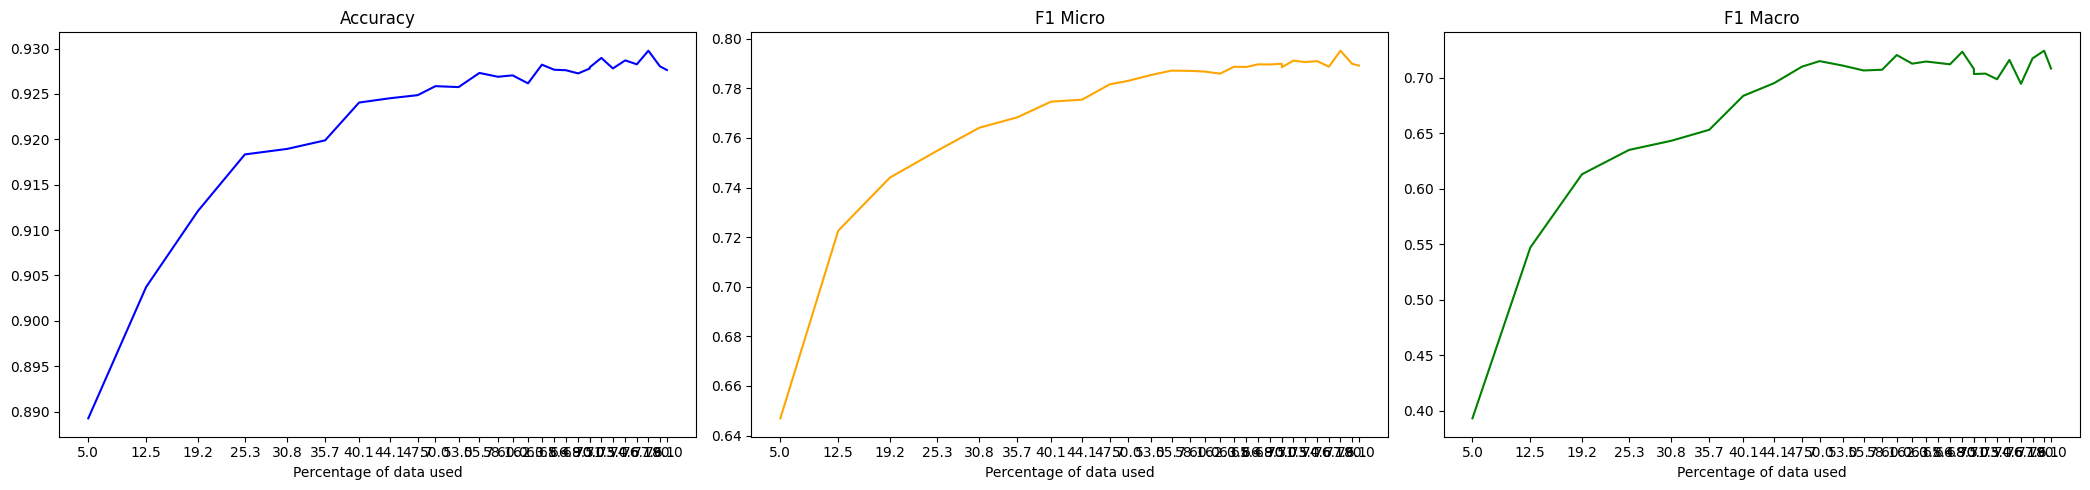

In [ ]:
active_learning(seeds[4], 4)